In [357]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import random
import math
import pandas as pd
import xgboost
import lightgbm
import catboost
import scipy

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from matplotlib.colors import ListedColormap
from scipy.stats import pearsonr
from itertools import combinations
from sklearn.base import BaseEstimator
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.ensemble import (RandomForestClassifier,
                              ExtraTreesClassifier,
                              VotingClassifier)
from sklearn.tree import (DecisionTreeRegressor,
                          DecisionTreeClassifier)
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score

In [226]:
plt.rcParams["figure.figsize"] = 12, 9
sns.set_style("whitegrid")
warnings.filterwarnings("ignore")

SEED = 111
random.seed(SEED)
np.random.seed(SEED)

### Задание 1. Bias-variance trade-off

**2 балла**

Продемонстрируйте bias-variance trade-off для `DecisionTreeRegressor` при изменении глубины дерева. Постройте регрессионную модель функции от одной независимой переменной, представленной в ячейке ниже, используя функцию `plot_regression_predictions` (можете ее как-то поменять, если захочется). Попробуйте разные значения глубины деревьев, при каком значении, на ваш взгляд, модель оптимальна, при каком variance становится слишком большим?

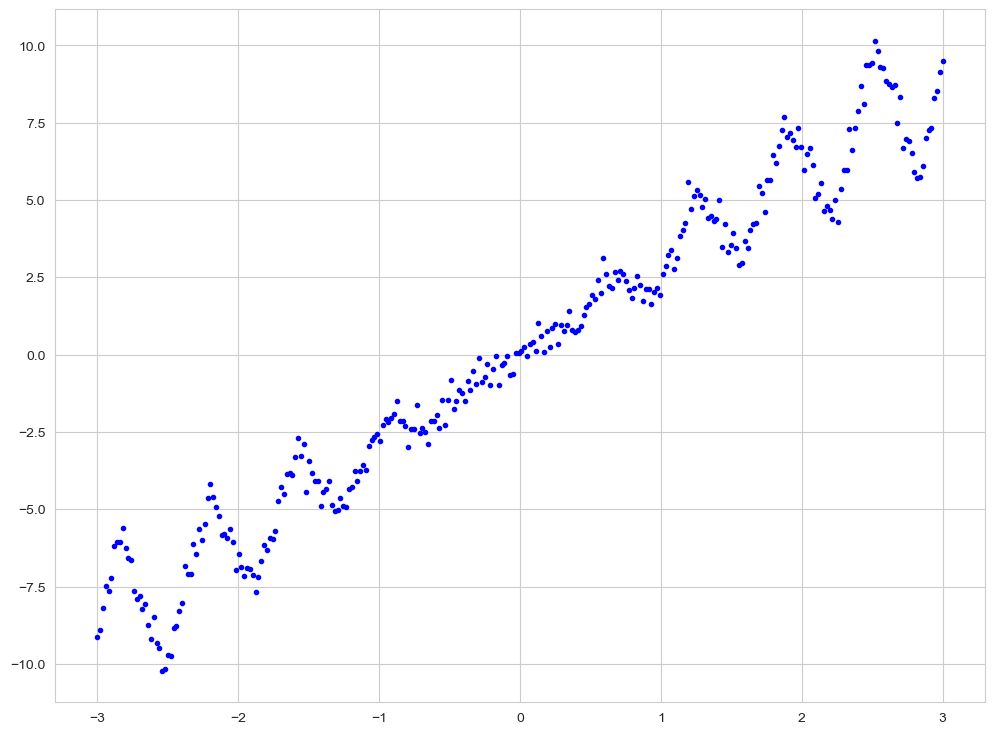

In [227]:
# Сгенерируем какую-нибудь необычную зависимость и научимся ее предсказывать
np.random.seed(42)
m = 300
X = np.linspace(-3, 3, m).reshape(-1, 1)
y = (3 + 2/np.pi * np.arcsin(np.cos(10 * X))) * X
y = y + np.random.randn(m, 1) / 3
plt.plot(X.reshape(-1), y.reshape(-1), "b.");

In [228]:
# Функция для отрисовки предсказаний деревьев решений в случае регрессии
def plot_regression_predictions(tree_reg, X, y, axes=[-3, 3, -10, 10], ylabel="$y$"):
    x1 = np.linspace(axes[0], axes[1], 500).reshape(-1, 1)
    y_pred = tree_reg.predict(x1)
    plt.axis(axes)
    plt.xlabel("$x_1$", fontsize=18)
    if ylabel:
        plt.ylabel(ylabel, fontsize=18, rotation=0)

    plt.plot(x1, y_pred, linewidth=2, label=r"$\hat{y}$")

Изобразите, как меняются предсказания дерева при увеличении максимальной глубины (можно взять что-то в диапазоне от 1 до 15):

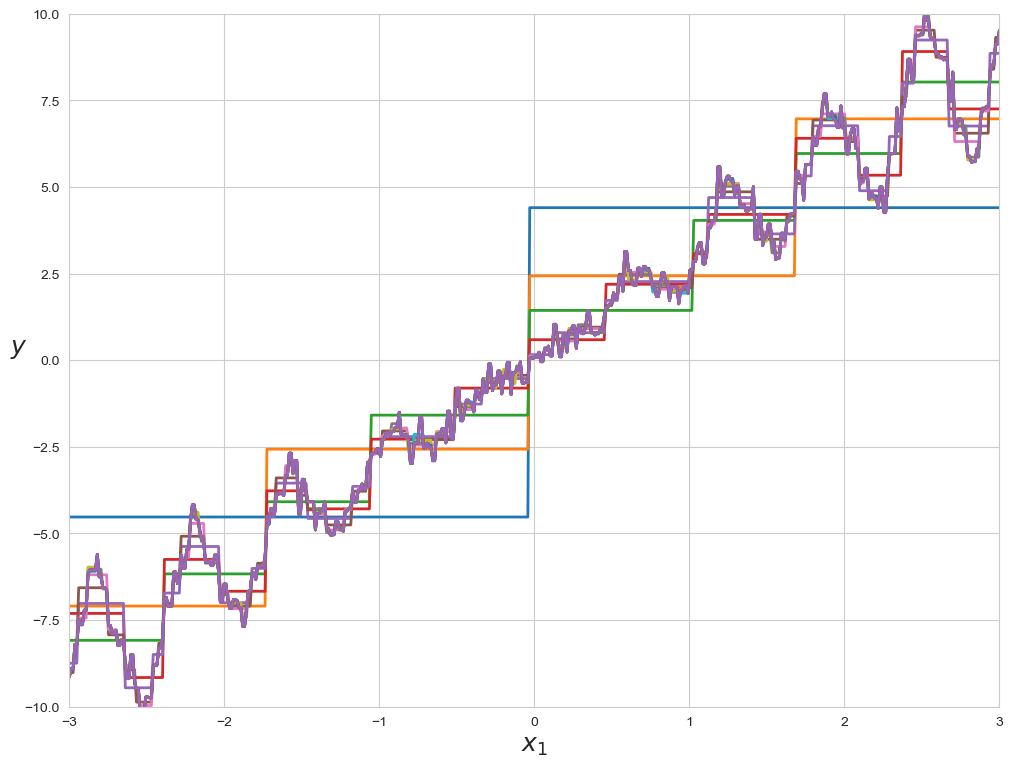

In [229]:
for max_depth in range(1,16):
    regressor = DecisionTreeRegressor(max_depth=max_depth)
    regressor = regressor.fit(X, y)
    plot_regression_predictions(regressor, X, y)

### Задание 2. Random forest

Теперь давайте немного подготовимся к тому, чтобы реализовать свой собственный случайный лес, а потом реализуем его.

#### Задание 2. 1. Простое ансамблирование

**1 балла**

Представим, что у нас есть 101 классификатор. Каждый может с вероятностью `p` (равной для всех моделей) правильно предсказать класс объекта. Будем делать предсказания по большинству голосов (majority vote). Постройте зависимость вероятности правильно классифицировать объект от значения `p`. Вам может быть полезная следующая формула:

$$ \large \mu = \sum_ {i = 51} ^ {101} C_{101} ^ ip ^ i (1-p) ^ {101-i} $$

In [230]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##

In [231]:
def total_binom_prob(prob, n_classifiers):
    majority = round((n_classifiers)/2)+1
    i = np.linspace(majority, n_classifiers, n_classifiers-majority+1)
    return np.sum((1-prob)**(101-i)*prob**i*scipy.special.binom(101,i))

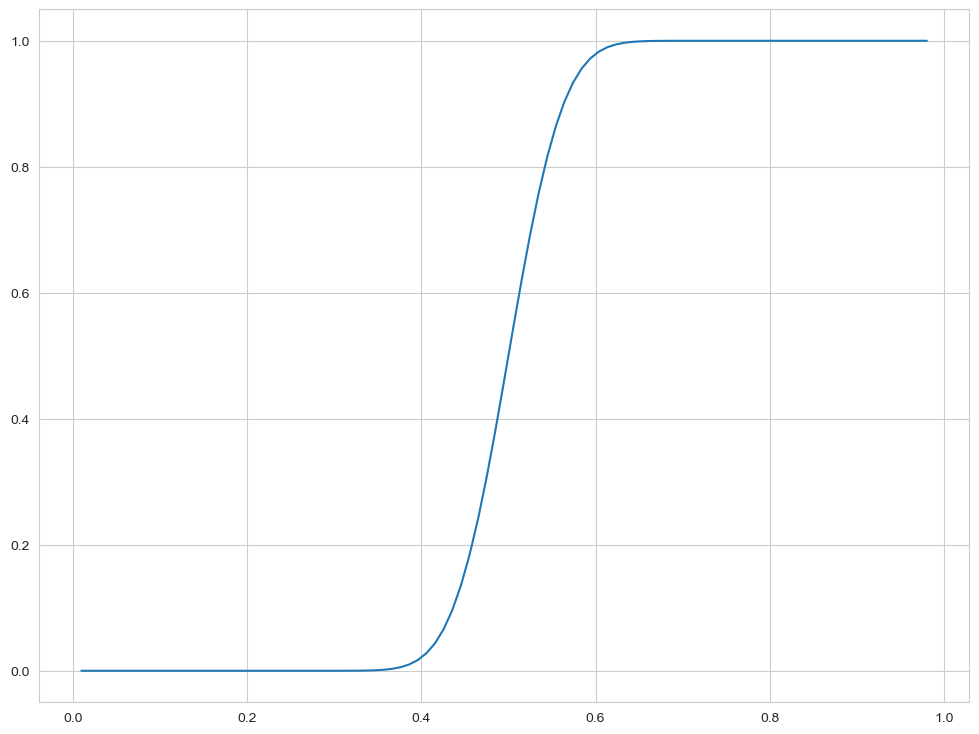

In [232]:
probs = []
total_probs = []
for p in range(1,100):
    prob = p/101
    probs.append(prob)
    total_probs.append(total_binom_prob(prob, 101))
plt.plot(probs,total_probs)

А теперь давайте посмотрим на другую ситуацию. У нас есть фиксированная вероятность того, что модель правильно классифицирует объект `p = 0.65`. Постройте зависимость вероятности правильно классифицировать объект от числа моделей в ансамбле.

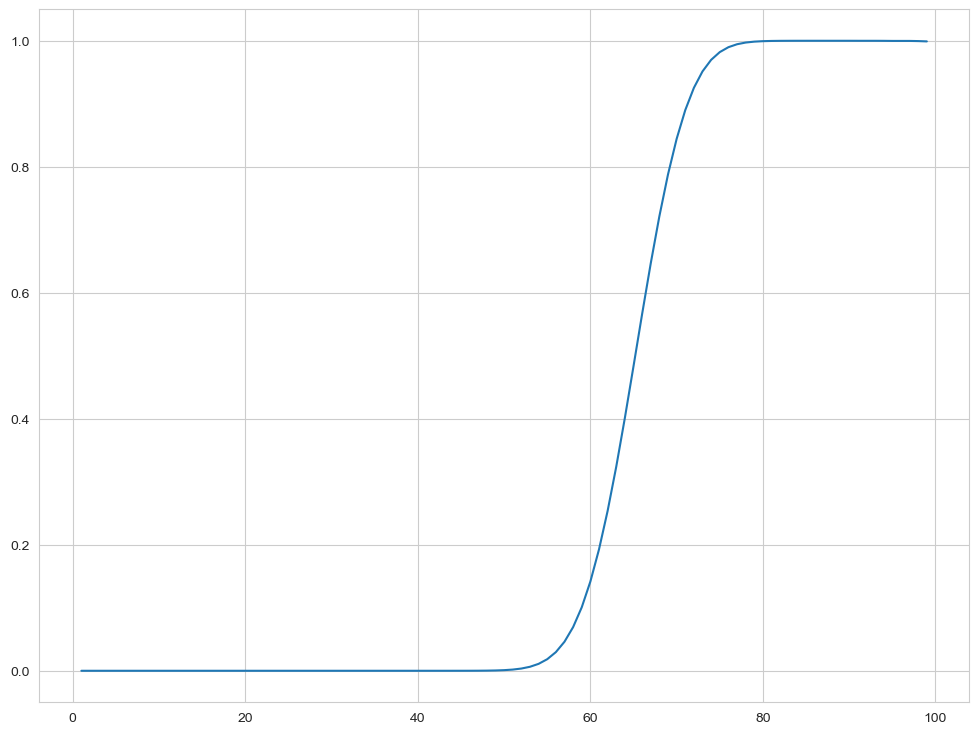

In [233]:
n = []
n_class_prob = []
for n_classifiers in range(1,100):
    n.append(n_classifiers)
    n_class_prob.append(total_binom_prob(0.65, n_classifiers))
plt.plot(n,n_class_prob)

Опишите ваши наблюдения:

* Если классификатор работает чуть лучше обычного рандома (p>0.5) - большое количество независимых классификаторов уже может на выходе давать неплохое предсказание
* Чем больше классификаторов - тем лучше


#### Задание 2. 2. Реализация простого RF

**4 балла**

Реализуйте свой собственный класс `RandomForestClassifierCustom`, используя в качестве базовой модели `DecisionTreeClassifier` из `sklearn`.

Небольшое описание:
- Используйте приведенный ниже код
- В методе `fit` в цикле (`i` от 0 до `n_estimators-1`):
    * Зафиксируйте генератор случайных чисел следующим образом np.random.seed(`random_state + i`). Идея в том, что на каждой итерации у нас будет новое значение для генератора случайных чисел, что добавит побольше "случайности", но в то же время мы сможем иметь воспроизводимые результаты
    * После чего выберите `max_features` признаков **без возвращения/without replacement**, сохраните список выбранных признаков (их индексов) в `self.feat_ids_by_tree`
    * Также создайте псевдовыборку при помощи бутстрэпа (выбор **с возвращением/with replacement**) из тренировочных данных. Может помочь функция `np.random.choice` и ее аргумент `replace`
    * Обучите дерево решений с параметрами, заданными в конструкторе класса `max_depth`, `max_features` и `random_state` на полученной псевдовыборке.
- Метод `fit` должен возвращать текущий экземпляр класса `RandomForestClassifierCustom`, то есть `self` (все по-взрослому, как в `sklearn`)
- В методе `predict_proba` мы должны пройти циклом по всем деревьям. Для каждого предсказания, нам нужно будет брать только те признаки, на которых училось изначальное дерево, поэтому мы и сохраняли эту информацию в артрибуте `self.feat_ids_by_tree`. Этот метод должен возвращать предсказанные вероятности (можно делать двумя способами: для каждого дерева предсказывать значение при помощи метода `predict_proba` и потом усреднять эти вероятности, или к примеру пользоваться методом `predict` и также считать среднее.

In [234]:
class RandomForestClassifierCustom(BaseEstimator):
    def __init__(
        self, n_estimators=10, max_depth=None, max_features=None, random_state=SEED
    ):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.max_features = max_features
        self.random_state = random_state

        self.trees = []
        self.feat_ids_by_tree = []

    def fit(self, X, y):
        self.classes_ = sorted(np.unique(y))
        for i in range(self.n_estimators):
            np.random.seed(self.random_state + i)
            try:
                feature_ids = np.sort(np.random.choice(X.shape[1], size=self.max_features, replace=False))
            except ValueError:
                print('Max features bigger than number of features in dataset. Please, lower max_features parameter')
            self.feat_ids_by_tree.append(feature_ids)
            boot_rows = np.random.choice(X.shape[0], size=X.shape[0], replace=True)
            forest_tree = DecisionTreeClassifier(max_depth = self.max_depth)
            self.trees.append (forest_tree.fit(X[boot_rows,:][:,feature_ids], y[boot_rows]))
        return self

    def predict_proba(self, X):
        preds = []
        for tree_idx, tree in enumerate(self.trees):
            preds.append(tree.predict_proba(X[:,self.feat_ids_by_tree[tree_idx]]))
        trees_probas = np.mean(preds, axis=0)
        return trees_probas
    
    def predict(self, X):
        probas = self.predict_proba(X)
        predictions = np.argmax(probas, axis=1)
        return predictions
        

Протестируем нашу реализацию на искусственных данных. Визуализируйте разделяющую границу, которую рисует ваша модель при помощи функции `plot_decision_boundary` (см. примеры в лекции).

In [235]:
def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.5, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(["#ffdab9","#9898ff", "#4B0082"])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(["#ffdab9", "#4c4c7f", "#4B0082"])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

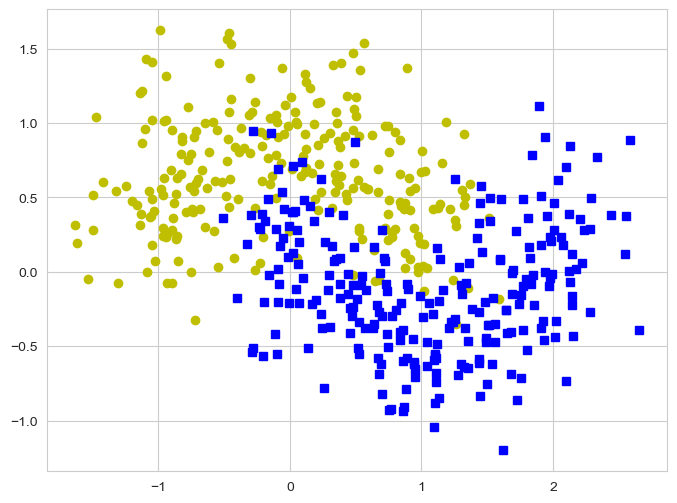

In [236]:
X, y = datasets.make_moons(n_samples=500, noise=0.30, random_state=SEED)

plt.figure(figsize=(8, 6))
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo")
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs")
plt.show()

In [237]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##

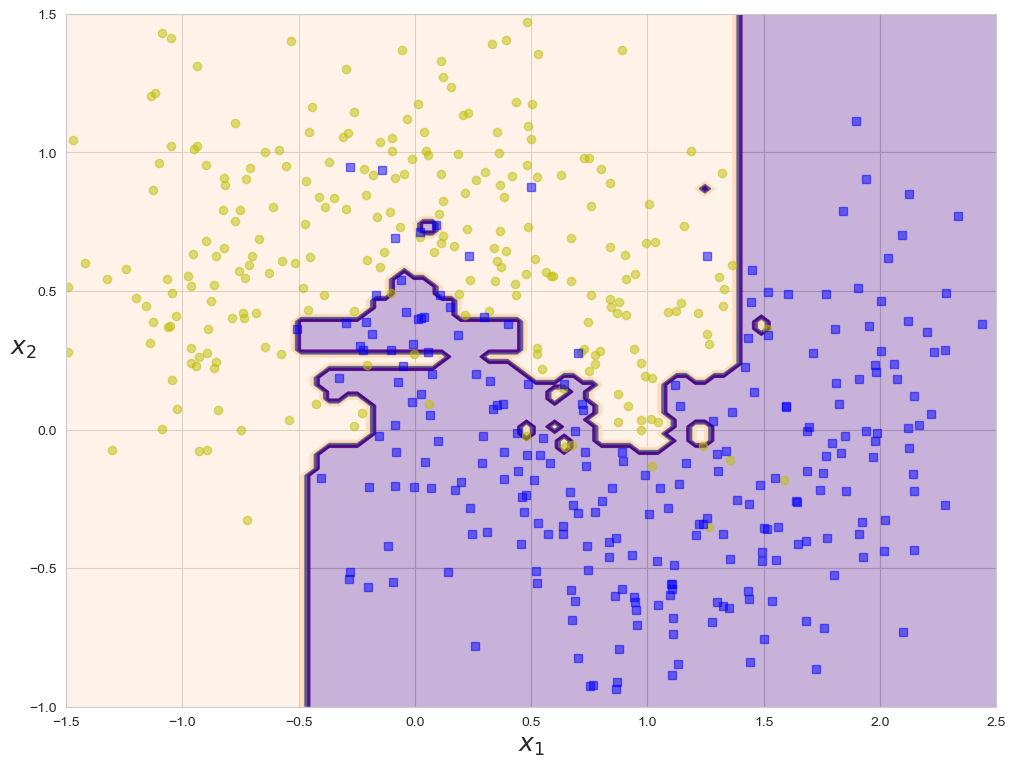

In [238]:
custom_RF = RandomForestClassifierCustom(max_features=2, max_depth=69, n_estimators=228)
custom_RF = custom_RF.fit(X, y)
plot_decision_boundary(custom_RF, X, y)

Подберите наилучшие гиперпараметры, при которых разделяющая граница будет, на ваш взгляд, оптимальной с точки зрения bias-variance. Можно также подключить какие-то метрики для выбора лучшей модели.

Я бы воспользовался GridSearh, но он не хочет сплитить наш кастомный рандом  форест :(((
Поэтому придется пользоваться уродливыми вложенными циклами, простите.

In [239]:
depths = [1, 3, 4, 5, 7, 10, 20, 30]
estimators = [10, 20, 50, 69, 80, 100] 
features = [1, 2]
MSEs = {}
for max_depth in depths:
    for n_estimators in estimators:
        for max_features in features:
            mean_squared_error
            X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
            custom_RF = RandomForestClassifierCustom(max_features=max_features, 
                                                     max_depth=max_depth, 
                                                     n_estimators=n_estimators)
            custom_RF = custom_RF.fit(X_train, y_train)
            parameters_combination = f'MaxFeatures={max_features}, Max depth={max_depth}, N estimators={n_estimators}'
            y_pred = custom_RF.predict(X_test)
            MSEs[parameters_combination] = mean_squared_error(y_test, y_pred)

print(f'Hyperparameters combination with lowest MSE={min(MSEs.values())} are: {min(MSEs, key=MSEs.get)}')


Hyperparameters combination with lowest MSE=0.096 are: MaxFeatures=2, Max depth=10, N estimators=10


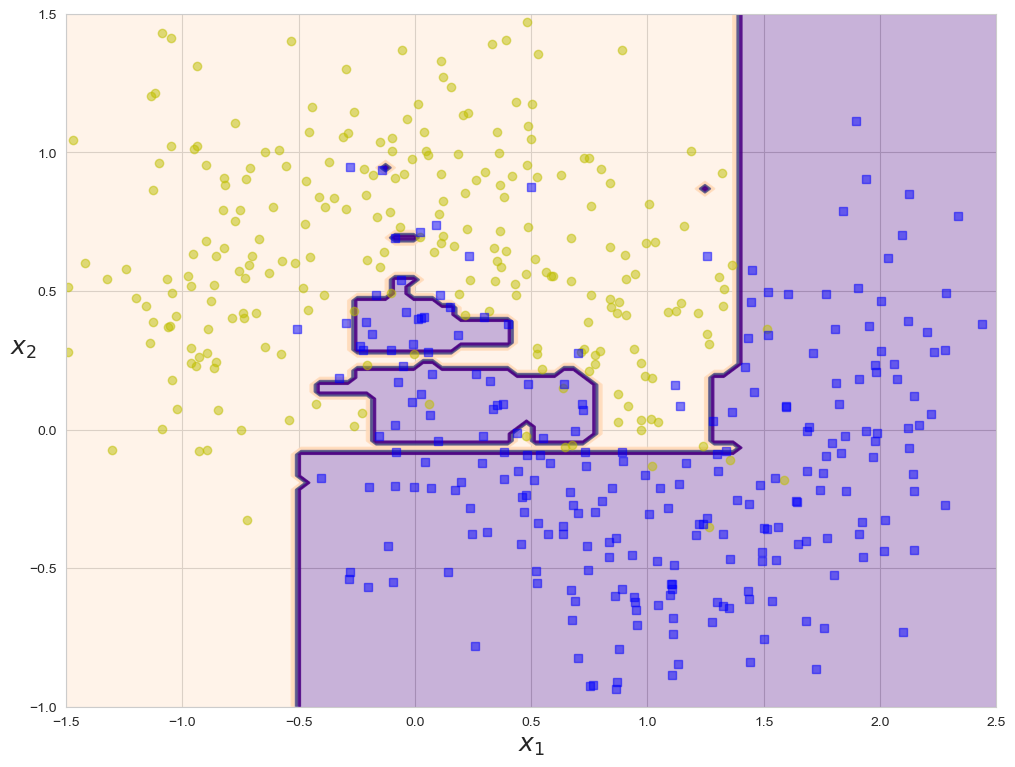

In [240]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
custom_RF = RandomForestClassifierCustom(max_features=2, 
                                         max_depth=10, 
                                         n_estimators=10)
custom_RF = custom_RF.fit(X_train, y_train)
plot_decision_boundary(custom_RF, X, y)

На мой вкус у модели c наименьшим MSE bias высоковат (маленькие синие точечки внутри желтых).\
Интуитивно я бы сделал глубину поменьше, а число деревьев побольше:

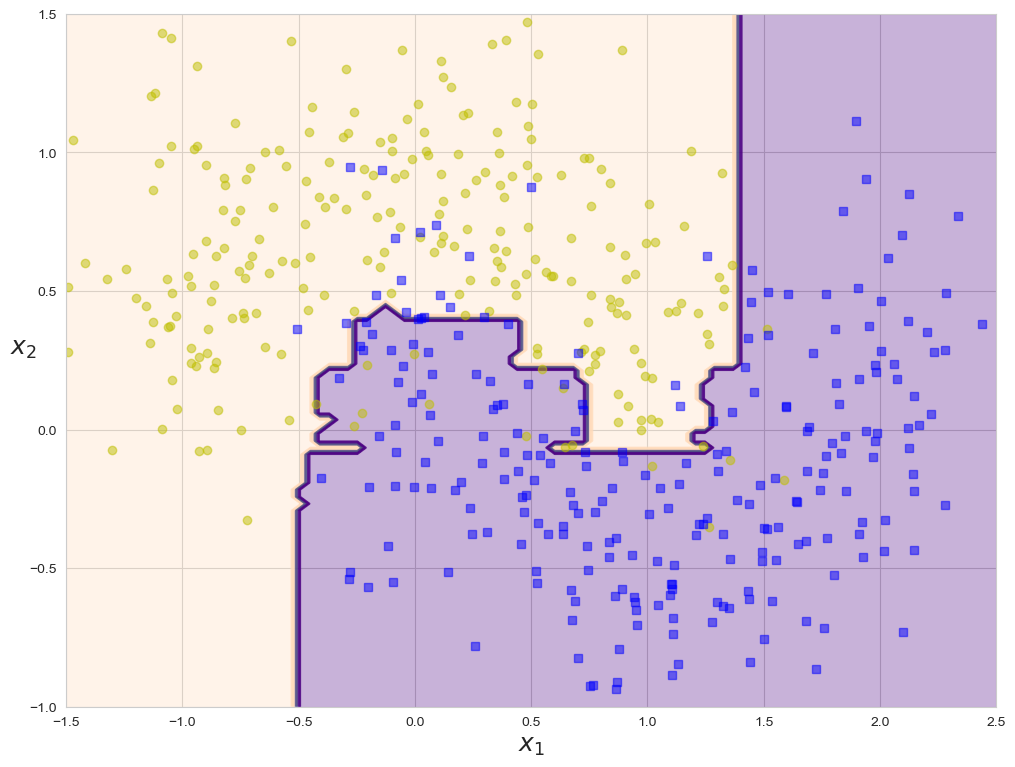

In [241]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
custom_RF = RandomForestClassifierCustom(max_features=2, 
                                         max_depth=5, 
                                         n_estimators=80)
custom_RF = custom_RF.fit(X_train, y_train)
plot_decision_boundary(custom_RF, X, y)

Тут variance похуже, но зато группы красиво разделились

#### Задание 2. 3. Корреляция базовых моделей

**3 балла**

Как мы выянили на лекции, для того, чтобы bagging работал хорошо, предсказания наших моделей не должны сильно коррелировать. Для этого в случайном лесе применяются различные подходы, в том числе и RSM. Давайте посмотрим, как влияет параметр `max_features` на корреляцию базовых моделей в случайном лесу из `sklearn`. В качестве примера будем использовать датасет `breast_cancer`. Для расчета корреляций используйте приведенную ниже функцию `base_model_pair_correlation`. Для каждой модели у вас будет получаться набор значений (попарные корреляции всех деревьев), дальше можно изобразить их в виде боксплотов, как мы на лекции рисовали распределение метрик.

In [242]:
# Функция для расчета попарных корреляций базовых моделей в случайном лесу
def base_model_pair_correlation(ensemble, X):
    corrs = []
    for (i, est1), (j, est2) in combinations(enumerate(ensemble.estimators_), 2):
        Xi_test = X
        Xj_test = X

        ypred_t1 = est1.predict_proba(Xi_test)[:, 1]
        ypred_t2 = est2.predict_proba(Xj_test)[:, 1]

        corrs.append(pearsonr(ypred_t1, ypred_t2)[0])
    return np.array(corrs)

In [243]:
# Загрузим данные
breast_cancer = datasets.load_breast_cancer()
X = breast_cancer.data
y = breast_cancer.target
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [244]:
def tree_corrs_calc(X_train, X_test, y_train, max_features, max_depth):
    RFC = RandomForestClassifier(max_depth = max_depth, max_features = max_features)
    RFC = RFC.fit(X_train, y_train)
    tree_corrs = base_model_pair_correlation(RFC, X_test)
    return tree_corrs

In [245]:
def boxplot_per_parameter(tree_corrs_dict):
    fig, ax = plt.subplots()
    ax.boxplot(tree_corrs_dict.values(), flierprops={'marker': '*', 'markersize': 1})
    ax.set_xticklabels(tree_corrs_dict.keys())
    plt.ylabel("tree correlation")
    plt.show()

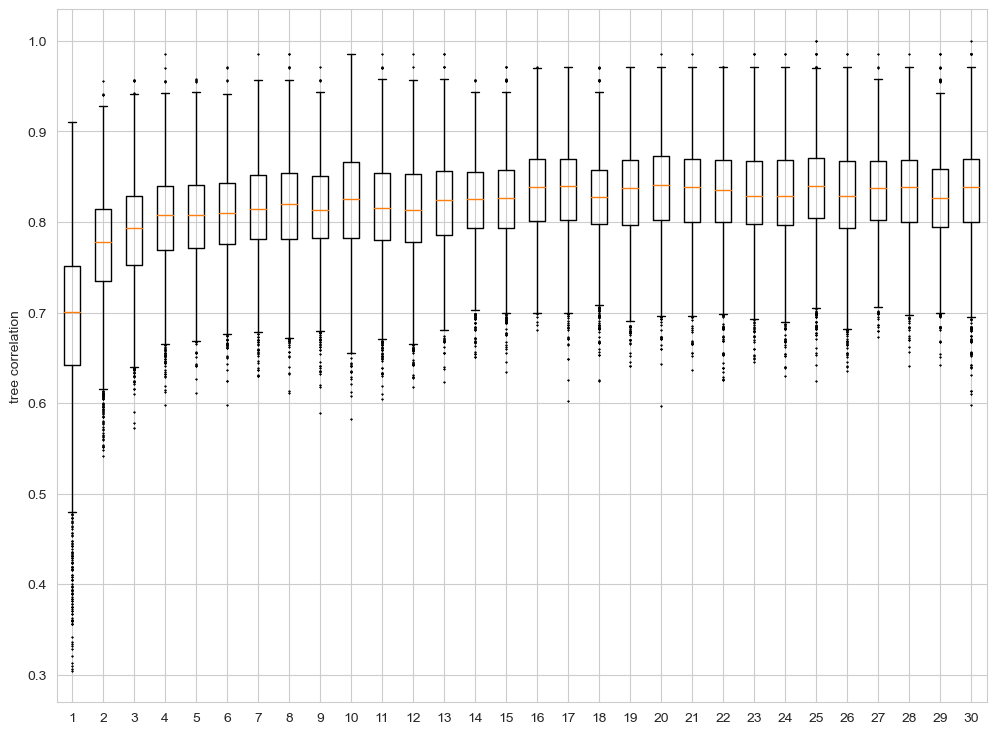

In [246]:
n_features = range(1,31)
features_corr_dict = dict.fromkeys(n_features, 0)
for max_features in features_corr_dict.keys():
    features_corr_dict[max_features] = tree_corrs_calc(X_train, X_test, y_train, 
                                                 max_features = max_features, max_depth = None)
boxplot_per_parameter(features_corr_dict)

Теперь давайте посмотрим, как на это влияет параметр `max_depth`:

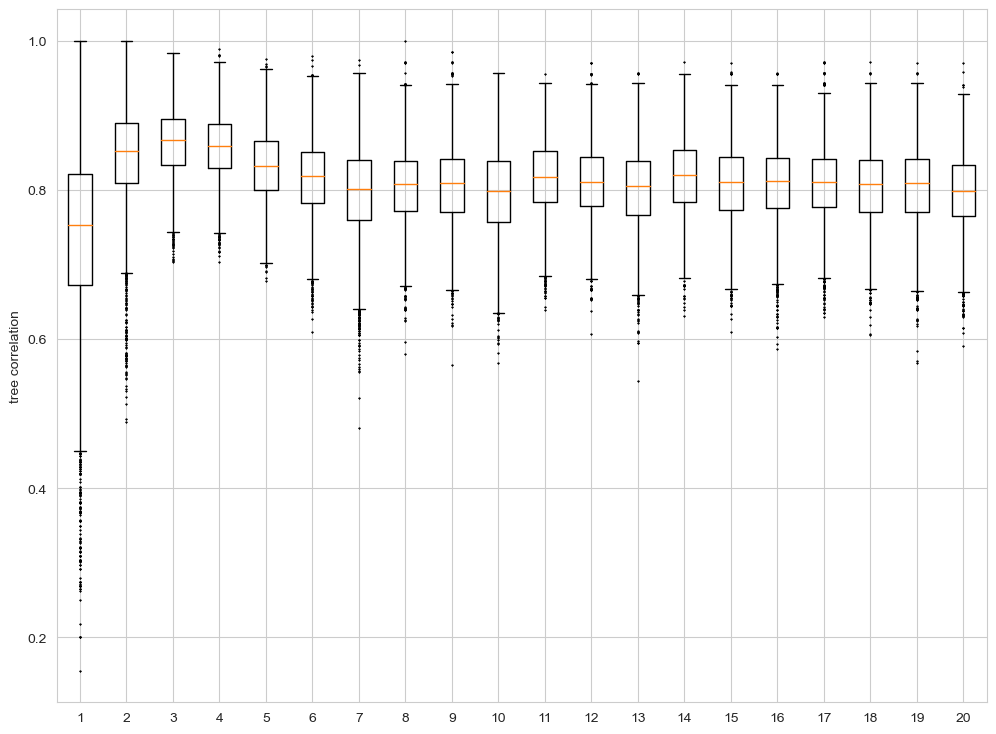

In [247]:
depths = range(1,21)
depth_corr_dict = dict.fromkeys(depths, 0)
for max_depth in depth_corr_dict.keys():
    depth_corr_dict[max_depth] = tree_corrs_calc(X_train, X_test, y_train, 
                                                 max_features = 'sqrt', max_depth = max_depth)
boxplot_per_parameter(depth_corr_dict)

Опишите ваши наблюдения:

При повышении максимальной глубины и числа фичей деревья переобучаются и становятся похожи друг на друга, поэтому уровень корреляции между деревьями растет.

+В какой-то момент уровень корреляции выходит на плато, потому что деревья уже максимально переобучились

### Задание 3. Строим большой ансамбль

**4 балла + 3 дополнительных за скор выше 0.89**

В данной задаче вам нужно диагностировать сердечное заболевание у людей по медицинским показателям.

In [280]:
heart_dataset = pd.read_csv("heart.csv")

In [281]:
X = heart_dataset.drop("target", axis=1)
y = heart_dataset["target"]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=SEED)
X_train.head()

age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  \
178   43    1   0       120   177    0        0      120      1      2.5   
298   57    0   0       140   241    0        1      123      1      0.2   
201   60    1   0       125   258    0        0      141      1      2.8   
246   56    0   0       134   409    0        0      150      1      1.9   
153   66    0   2       146   278    0        0      152      0      0.0   

     slope  ca  thal  
178      1   0     3  
298      1   0     3  
201      1   1     3  
246      1   2     3  
153      1   1     2

Обучите разнообразные классификаторы, приведенные ниже, а также ансамбль `VotingClassifier` из `sklearn.ensemble`, объединяющий эти классификаторы с помощью жесткого или мякого голосования (параметр `voting =` `'hard'` или `'soft'` соответственно). Оцените качество моделей с помощью кросс-валидации на тренировочном наборе, используя функцию `cross_val_score` и метрику `f1`. Часть моделей отсюда мы не проходили, о них можно почитать дополнительно, но в принципе для задания не очень важно знать принципы их работы (но, если есть время, то почитайте, там интересно).

In [267]:
dt = DecisionTreeClassifier(random_state=SEED, max_depth=10, min_samples_leaf=10)
rf = RandomForestClassifier(n_estimators=50, random_state=SEED)
etc = ExtraTreesClassifier(random_state=SEED)
knn = KNeighborsClassifier(n_neighbors=5, weights="distance")
svc_lin = SVC(kernel='linear', probability=True, random_state=SEED)
svc_rbf = SVC(kernel='rbf', probability=True, random_state=SEED)
cat = catboost.CatBoostClassifier(verbose=0, random_seed=SEED)
lgbm = lightgbm.LGBMClassifier(random_state=SEED)
lgbm_rf = lightgbm.LGBMClassifier(boosting_type="rf", bagging_freq=1, bagging_fraction=0.7, random_state=SEED)
xgb = xgboost.XGBClassifier(random_state=SEED)
xgb_rf = xgboost.XGBRFClassifier(random_state=SEED)
lr = LogisticRegression(solver='liblinear', max_iter=10000)
nb = GaussianNB()

base_models = [("DT", dt), ("RF", rf), 
               ("ETC", etc), ("KNN", knn), 
               ("SVC_LIN", svc_lin), ("SVC_RBF", svc_rbf), 
               ("CAT", cat), ("LGBM", lgbm), 
               ("LGBM_RF", lgbm_rf), ("XGB", xgb), 
               ("XGB_RF", xgb_rf), ("LR", lr), ("NB", nb)]

Здесь могут возникать различные предупреждения при обучении бустингов, не волнуйтесь, все нормально, просто они обычно очень разговорчивые)

In [268]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##

voting_hard = VotingClassifier(estimators=base_models, voting='hard')
voting_soft = VotingClassifier(estimators=base_models, voting='soft')
voting_soft_weights = VotingClassifier(estimators=base_models, voting='soft')

## END YOUR CODE HERE ##

for model in [dt, rf, cat, etc, knn, svc_lin, svc_rbf, xgb, lgbm, xgb_rf, lgbm_rf, lr, nb, voting_hard, voting_soft]: 
    scores = cross_val_score(model, X_train, y_train, cv=3, scoring="f1")
    print(f"{model.__class__.__name__}: {scores.mean()}")

DecisionTreeClassifier: 0.797997226792219
RandomForestClassifier: 0.8328751280279528
CatBoostClassifier: 0.8342715174922052
ExtraTreesClassifier: 0.828174603174603
KNeighborsClassifier: 0.6493313763861709
SVC: 0.8403098469098905
SVC: 0.6973119072190279
XGBClassifier: 0.820158269808819
LGBMClassifier: 0.8170106316447779
XGBRFClassifier: 0.8379629629629629
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored

Я дополнительно сделал model_scores_dict чтобы из пары сильно коррелирующих моделей выбрасывать ту у которой точность меньше

Вы можете заметить, что ансамбль показывает хорошее, но не лучшее качество предсказания, попробуем его улучшить. Как вы знаете, ансамбли работают лучше, когда модели, входящие в них не скоррелированы друг с другом. Определите корреляцию предсказаний базовых моделей в ансамбле на тестовом наборе данных, и удалите из ансамбля те модели, чьи предсказания будут сильнее коррелировать с остальными. Воспользуйтесь функцией `base_model_pair_correlation_for_voting_clf`. **Спойлер**: далеко не факт, что если вы удалите две модели с корреляцией 0.95, то все станет сильно лучше, здесь все будет немного сложнее. Чтобы добиться максимального качества может понадобиться долгий перебор различных комбинаций моделей. Наилучший скор, который мне удалось достичь, это 0.915, но он получен весьма странной комбинацией алгоритмов, а еще и простым перебором всех вариантов)

In [269]:
def base_model_pair_correlation_for_voting_clf(ensemble, X):
    corrs = []
    base_model_names = [f"{est.__class__.__name__}" for est in ensemble.estimators_]
    for (i, est1), (j, est2) in combinations(enumerate(ensemble.estimators_), 2):
        Xi_test = X
        Xj_test = X

        if not isinstance(est1, SVC):
            ypred_t1 = est1.predict_proba(Xi_test)[:, 1]
        else:
            ypred_t1 = est1.decision_function(Xi_test)


        if not isinstance(est2, SVC):
            ypred_t2 = est2.predict_proba(Xi_test)[:, 1]
        else:
            ypred_t2 = est2.decision_function(Xi_test)
        corrs.append((est1, est2, pearsonr(ypred_t1, ypred_t2)[0]))


    return corrs

In [253]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##

Для начала давайте попробуем тупой подбор

In [302]:
base_models = [("DT", dt), ("RF", rf), 
               ("ETC", etc), ("KNN", knn), 
               ("SVC_LIN", svc_lin), ("SVC_RBF", svc_rbf), 
               ("CAT", cat), ("LGBM", lgbm), 
               ("LGBM_RF", lgbm_rf), ("XGB", xgb), 
               ("XGB_RF", xgb_rf), ("LR", lr), ("NB", nb)]
best_score = 0
best_combo = ''

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=SEED)


n = len(base_models) - 1


while n >= 2:
    for models_combo in combinations(base_models, n):
        voting_soft = VotingClassifier(estimators=list(models_combo))
        combo_score = cross_val_score(voting_soft, X_train, y_train, cv=3, scoring="f1").mean()
        if combo_score > best_score:
            best_combo = models_combo
            best_score = combo_score
    n -= 1

print(best_combo, best_score)

[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagg

[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagg

[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagg

[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagg

[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagg

[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagg

[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagg

[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagg

[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagg

[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagg

[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagg

[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagg

[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagg

[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagg

[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagg

[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagg

[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagg

[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagg

[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagg

[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagg

[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagg

[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagg

KeyboardInterrupt: 

Оно так и не досчиталось (ну и не мудрено, если учесть какое огромное количество сочетаний можно из 12 алгоритмов построить)

In [305]:
print([model[0] for model in best_combo], best_score)

['DT', 'ETC', 'SVC_LIN', 'SVC_RBF', 'LGBM_RF', 'XGB', 'XGB_RF', 'LR', 'NB'] 0.8668502028935633


Попробуем выбирать пару алгоритмов с наибольшей корреляцией и выбрасывать из модели алгоритм с самой низкой точностью в паре

In [257]:
base_models_scores = {}

for model in [dt, rf, cat, etc, knn, svc_lin, xgb, lgbm, xgb_rf, lgbm_rf, lr, nb]: 
    scores = cross_val_score(model, X_train, y_train, cv=3, scoring="f1")
    base_models_scores.update({model.__class__.__name__:scores.mean()})

[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


In [309]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=SEED)

base_models = list(best_combo)

while len(base_models) > 1:
    voting_soft = VotingClassifier(estimators=base_models, voting='hard')
    scores = cross_val_score(voting_soft, X_train, y_train, cv=3, scoring="f1")
    models_in_ansamble = ', '.join(map(str, [model[0] for model in base_models]))
    print(f"{models_in_ansamble}: {scores.mean()}")
    soft_voting = VotingClassifier(estimators=base_models, voting='hard')
    soft_voting = soft_voting.fit(X_train, y_train)
    corr_pairs = base_model_pair_correlation_for_voting_clf(soft_voting, X_test)
    worst_pair = corr_pairs[np.argmax([pair[2] for pair in corr_pairs])][0:2]
    worst_names = [model.__class__.__name__ for model in worst_pair]
    worst_model = worst_pair[np.argmin([base_models_scores[name] for name in worst_names])]
    for idx, model in enumerate(base_models):
        if model[1].__class__.__name__ == worst_model.__class__.__name__:
            print(f'Throwing out {model[0]}')
            base_models.pop(idx)
            break

    
    
    

[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
DT, ETC, SVC_LIN, SVC_RBF, LGBM_RF, XGB, XGB_RF, LR, NB: 0.8668502028935633
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
Throwing out SVC_LIN
[Li

Модель сильно лучше не стала :(((

### Задание 4. Определение оттока клиентов из телекома

**6 баллов + 7 дополнительных за высокое качество модели и различные эксперименты**

Будем предсказывать, уйдет ли от нас клиент (переменная `Churn?`). Данные можно скачать [здесь](https://www.kaggle.com/venky12347/churn-telecom). Это будет уже совсем взрослое задание, так как правильного ответа на него нет. Вам нужно будет разобраться с данными, правильно подготовить их для моделей, а также выбрать лучшую модель. 

Задача минимум:

Выберите 2 модели &mdash; один случайный лес и один бустинг из приведенных ниже:

1. `xgboost.XGBClassifier`
2. `xgboost.XGBRFClassifier` &mdash; случайный лес от xgboost
3. `lightgbm.LGBMClassifier`
4. `lightgbm.LGBMClassifier(boosting_type="rf")` &mdash; случайный лес от lightgbm
5. `catboost.CatBoostClassifier`

И попробуйте разобраться с тем, как для этих моделей правильно настраивать гиперпараметры. Советую гуглить примерно следующее `how to choose best hyperparameters for lightgbm`. Там вы найдете кучу сложного и непонятного кода, но если с ним разобраться и научиться обучать нестандартные бустинги, то в плане табличных данных равных вам не будет)

In [339]:
data = pd.read_csv("churn.csv")
data.head()

State  Account Length  Area Code     Phone Int'l Plan VMail Plan  \
0    KS             128        415  382-4657         no        yes   
1    OH             107        415  371-7191         no        yes   
2    NJ             137        415  358-1921         no         no   
3    OH              84        408  375-9999        yes         no   
4    OK              75        415  330-6626        yes         no   

   VMail Message  Day Mins  Day Calls  Day Charge  ...  Eve Calls  Eve Charge  \
0             25     265.1        110       45.07  ...         99       16.78   
1             26     161.6        123       27.47  ...        103       16.62   
2              0     243.4        114       41.38  ...        110       10.30   
3              0     299.4         71       50.90  ...         88        5.26   
4              0     166.7        113       28.34  ...        122       12.61   

   Night Mins  Night Calls  Night Charge  Intl Mins  Intl Calls  Intl Charge  \
0       244.7           91         11.01       10.0           3         2.70   
1       254.4          103         11.45       13.7           3         3.70   
2       162.6          104          7.32       12.2           5         3.29   
3       196.9           89          8.86        6.6           7         1.78   
4       186.9          121          8.41       10.1           3         2.73   

   CustServ Calls  Churn?  
0               1  False.  
1               1  False.  
2               0  False.  
3               2  False.  
4               3  False.  

[5 rows x 21 columns]

In [340]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   State           3333 non-null   object 
 1   Account Length  3333 non-null   int64  
 2   Area Code       3333 non-null   int64  
 3   Phone           3333 non-null   object 
 4   Int'l Plan      3333 non-null   object 
 5   VMail Plan      3333 non-null   object 
 6   VMail Message   3333 non-null   int64  
 7   Day Mins        3333 non-null   float64
 8   Day Calls       3333 non-null   int64  
 9   Day Charge      3333 non-null   float64
 10  Eve Mins        3333 non-null   float64
 11  Eve Calls       3333 non-null   int64  
 12  Eve Charge      3333 non-null   float64
 13  Night Mins      3333 non-null   float64
 14  Night Calls     3333 non-null   int64  
 15  Night Charge    3333 non-null   float64
 16  Intl Mins       3333 non-null   float64
 17  Intl Calls      3333 non-null   i

In [341]:
data.describe()

Account Length    Area Code  VMail Message     Day Mins    Day Calls  \
count     3333.000000  3333.000000    3333.000000  3333.000000  3333.000000   
mean       101.064806   437.182418       8.099010   179.775098   100.435644   
std         39.822106    42.371290      13.688365    54.467389    20.069084   
min          1.000000   408.000000       0.000000     0.000000     0.000000   
25%         74.000000   408.000000       0.000000   143.700000    87.000000   
50%        101.000000   415.000000       0.000000   179.400000   101.000000   
75%        127.000000   510.000000      20.000000   216.400000   114.000000   
max        243.000000   510.000000      51.000000   350.800000   165.000000   

        Day Charge     Eve Mins    Eve Calls   Eve Charge   Night Mins  \
count  3333.000000  3333.000000  3333.000000  3333.000000  3333.000000   
mean     30.562307   200.980348   100.114311    17.083540   200.872037   
std       9.259435    50.713844    19.922625     4.310668    50.573847   
min       0.000000     0.000000     0.000000     0.000000    23.200000   
25%      24.430000   166.600000    87.000000    14.160000   167.000000   
50%      30.500000   201.400000   100.000000    17.120000   201.200000   
75%      36.790000   235.300000   114.000000    20.000000   235.300000   
max      59.640000   363.700000   170.000000    30.910000   395.000000   

       Night Calls  Night Charge    Intl Mins   Intl Calls  Intl Charge  \
count  3333.000000   3333.000000  3333.000000  3333.000000  3333.000000   
mean    100.107711      9.039325    10.237294     4.479448     2.764581   
std      19.568609      2.275873     2.791840     2.461214     0.753773   
min      33.000000      1.040000     0.000000     0.000000     0.000000   
25%      87.000000      7.520000     8.500000     3.000000     2.300000   
50%     100.000000      9.050000    10.300000     4.000000     2.780000   
75%     113.000000     10.590000    12.100000     6.000000     3.270000   
max     175.000000     17.770000    20.000000    20.000000     5.400000   

       CustServ Calls  
count     3333.000000  
mean         1.562856  
std          1.315491  
min          0.000000  
25%          1.000000  
50%          1.000000  
75%          2.000000  
max          9.000000

In [342]:
data.isna().sum()

State             0
Account Length    0
Area Code         0
Phone             0
Int'l Plan        0
VMail Plan        0
VMail Message     0
Day Mins          0
Day Calls         0
Day Charge        0
Eve Mins          0
Eve Calls         0
Eve Charge        0
Night Mins        0
Night Calls       0
Night Charge      0
Intl Mins         0
Intl Calls        0
Intl Charge       0
CustServ Calls    0
Churn?            0
dtype: int64

номер телефона у всех уникальный - можно смело прощаться с этой колонкой

In [343]:
data['Phone'].nunique()

3333

In [344]:
data.drop(columns='Phone', inplace=True)
data.head()

State  Account Length  Area Code Int'l Plan VMail Plan  VMail Message  \
0    KS             128        415         no        yes             25   
1    OH             107        415         no        yes             26   
2    NJ             137        415         no         no              0   
3    OH              84        408        yes         no              0   
4    OK              75        415        yes         no              0   

   Day Mins  Day Calls  Day Charge  Eve Mins  Eve Calls  Eve Charge  \
0     265.1        110       45.07     197.4         99       16.78   
1     161.6        123       27.47     195.5        103       16.62   
2     243.4        114       41.38     121.2        110       10.30   
3     299.4         71       50.90      61.9         88        5.26   
4     166.7        113       28.34     148.3        122       12.61   

   Night Mins  Night Calls  Night Charge  Intl Mins  Intl Calls  Intl Charge  \
0       244.7           91         11.01       10.0           3         2.70   
1       254.4          103         11.45       13.7           3         3.70   
2       162.6          104          7.32       12.2           5         3.29   
3       196.9           89          8.86        6.6           7         1.78   
4       186.9          121          8.41       10.1           3         2.73   

   CustServ Calls  Churn?  
0               1  False.  
1               1  False.  
2               0  False.  
3               2  False.  
4               3  False.

Поменяем название колонок на более простое

In [345]:
data.columns = data.columns.str.replace(' ', '_')
data.columns = data.columns.str.replace('\'', '')
data.columns = data.columns.str.replace('?', '')
data.head()


State  Account_Length  Area_Code Intl_Plan VMail_Plan  VMail_Message  \
0    KS             128        415        no        yes             25   
1    OH             107        415        no        yes             26   
2    NJ             137        415        no         no              0   
3    OH              84        408       yes         no              0   
4    OK              75        415       yes         no              0   

   Day_Mins  Day_Calls  Day_Charge  Eve_Mins  Eve_Calls  Eve_Charge  \
0     265.1        110       45.07     197.4         99       16.78   
1     161.6        123       27.47     195.5        103       16.62   
2     243.4        114       41.38     121.2        110       10.30   
3     299.4         71       50.90      61.9         88        5.26   
4     166.7        113       28.34     148.3        122       12.61   

   Night_Mins  Night_Calls  Night_Charge  Intl_Mins  Intl_Calls  Intl_Charge  \
0       244.7           91         11.01       10.0           3         2.70   
1       254.4          103         11.45       13.7           3         3.70   
2       162.6          104          7.32       12.2           5         3.29   
3       196.9           89          8.86        6.6           7         1.78   
4       186.9          121          8.41       10.1           3         2.73   

   CustServ_Calls   Churn  
0               1  False.  
1               1  False.  
2               0  False.  
3               2  False.  
4               3  False.

In [346]:
data['State'].unique()

array(['KS', 'OH', 'NJ', 'OK', 'AL', 'MA', 'MO', 'LA', 'WV', 'IN', 'RI',
       'IA', 'MT', 'NY', 'ID', 'VT', 'VA', 'TX', 'FL', 'CO', 'AZ', 'SC',
       'NE', 'WY', 'HI', 'IL', 'NH', 'GA', 'AK', 'MD', 'AR', 'WI', 'OR',
       'MI', 'DE', 'UT', 'CA', 'MN', 'SD', 'NC', 'WA', 'NM', 'NV', 'DC',
       'KY', 'ME', 'MS', 'TN', 'PA', 'CT', 'ND'], dtype=object)

In [348]:
data['Churn'].unique()

array(['False.', 'True.'], dtype=object)

In [349]:
data['VMail_Plan'].unique()

array(['yes', 'no'], dtype=object)

In [351]:
data['Intl_Plan'].unique()

array(['no', 'yes'], dtype=object)

In [353]:
data['Area_Code'].unique()

array([415, 408, 510], dtype=int64)

Данные явно не очень хорошо сбалансированы

<AxesSubplot:xlabel='Churn', ylabel='count'>

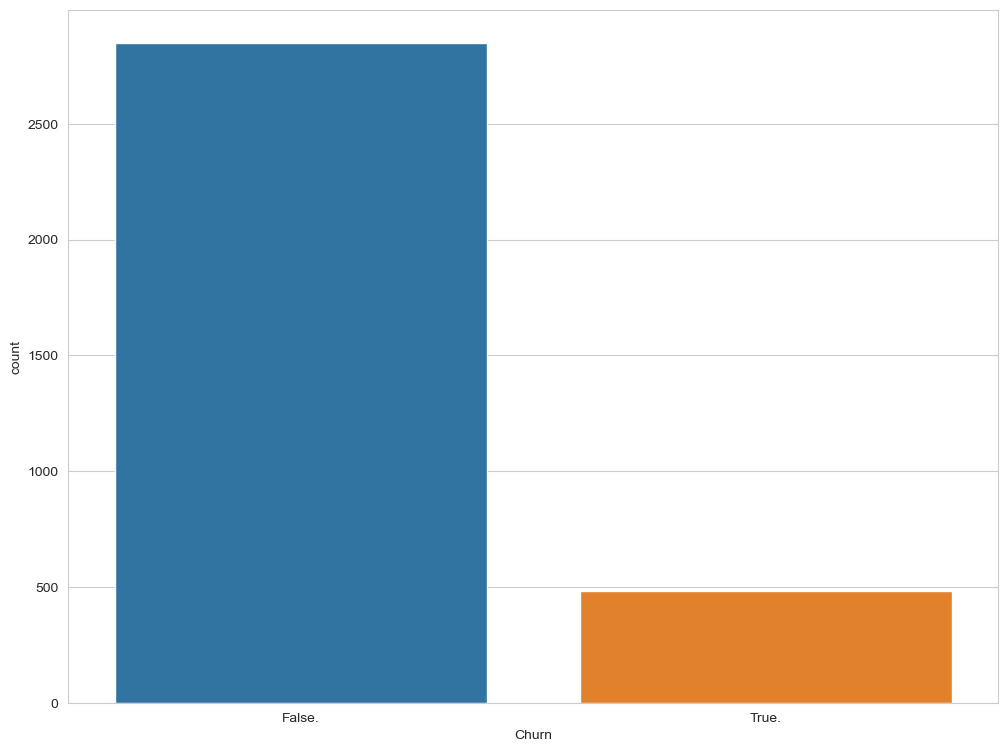

In [354]:
sns.countplot(data['Churn'])

In [390]:
y = np.where(data['Churn'] == 'True.', 1, 0)
y.shape

(3333,)

In [392]:
sum(y)

483

In [393]:
raw_X = data.drop(columns='Churn')
raw_X.head()

State  Account_Length  Area_Code Intl_Plan VMail_Plan  VMail_Message  \
0    KS             128        415        no        yes             25   
1    OH             107        415        no        yes             26   
2    NJ             137        415        no         no              0   
3    OH              84        408       yes         no              0   
4    OK              75        415       yes         no              0   

   Day_Mins  Day_Calls  Day_Charge  Eve_Mins  Eve_Calls  Eve_Charge  \
0     265.1        110       45.07     197.4         99       16.78   
1     161.6        123       27.47     195.5        103       16.62   
2     243.4        114       41.38     121.2        110       10.30   
3     299.4         71       50.90      61.9         88        5.26   
4     166.7        113       28.34     148.3        122       12.61   

   Night_Mins  Night_Calls  Night_Charge  Intl_Mins  Intl_Calls  Intl_Charge  \
0       244.7           91         11.01       10.0           3         2.70   
1       254.4          103         11.45       13.7           3         3.70   
2       162.6          104          7.32       12.2           5         3.29   
3       196.9           89          8.86        6.6           7         1.78   
4       186.9          121          8.41       10.1           3         2.73   

   CustServ_Calls  
0               1  
1               1  
2               0  
3               2  
4               3

In [394]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer

column_trans = make_column_transformer(
    (StandardScaler(), ['VMail_Message', 'Day_Mins', 'Day_Calls', 'Day_Charge', 'Eve_Mins',
       'Eve_Calls', 'Eve_Charge', 'Night_Mins', 'Night_Calls', 'Night_Charge',
       'Intl_Mins', 'Intl_Calls', 'Intl_Charge', 'CustServ_Calls']),
    (OneHotEncoder(), ['State','Area_Code','Intl_Plan', 'VMail_Plan']))

In [395]:
X = column_trans.fit_transform(raw_X)
X.shape

(3333, 72)

добавим в сплите stratify, чтобы сохранить изначальное соотношение классов

In [396]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=SEED, stratify=y)

Для начала попробуем с самыми дефолтными параметрами. Классы несбалансированы - будем использовать AUC

In [406]:
clf_xgb = xgboost.XGBClassifier(objective='binary:logistic', seed=SEED)
clf_xgb.fit(X_train, y_train, verbose=True, early_stopping_rounds=10, eval_metric='aucpr', eval_set=[(X_test, y_test)])

[0]	validation_0-aucpr:0.83227
[1]	validation_0-aucpr:0.84137
[2]	validation_0-aucpr:0.85655
[3]	validation_0-aucpr:0.85992
[4]	validation_0-aucpr:0.86641
[5]	validation_0-aucpr:0.87027
[6]	validation_0-aucpr:0.87285
[7]	validation_0-aucpr:0.87258
[8]	validation_0-aucpr:0.87634
[9]	validation_0-aucpr:0.87318
[10]	validation_0-aucpr:0.87798
[11]	validation_0-aucpr:0.88039
[12]	validation_0-aucpr:0.87951
[13]	validation_0-aucpr:0.88073
[14]	validation_0-aucpr:0.88259
[15]	validation_0-aucpr:0.88255
[16]	validation_0-aucpr:0.88277
[17]	validation_0-aucpr:0.88511
[18]	validation_0-aucpr:0.88468
[19]	validation_0-aucpr:0.88464
[20]	validation_0-aucpr:0.88464
[21]	validation_0-aucpr:0.88492
[22]	validation_0-aucpr:0.88270
[23]	validation_0-aucpr:0.88376
[24]	validation_0-aucpr:0.88389
[25]	validation_0-aucpr:0.88455
[26]	validation_0-aucpr:0.88503
[27]	validation_0-aucpr:0.88628
[28]	validation_0-aucpr:0.88589
[29]	validation_0-aucpr:0.88537
[30]	validation_0-aucpr:0.88542
[31]	validation_0-

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [408]:
print(clf_xgb.best_score)

0.8934570435648448


Уже весьма неплохо!

In [412]:
y_pred = clf_xgb.predict(X_test)

Посмотрим какие именно ошибки совершает наша модель

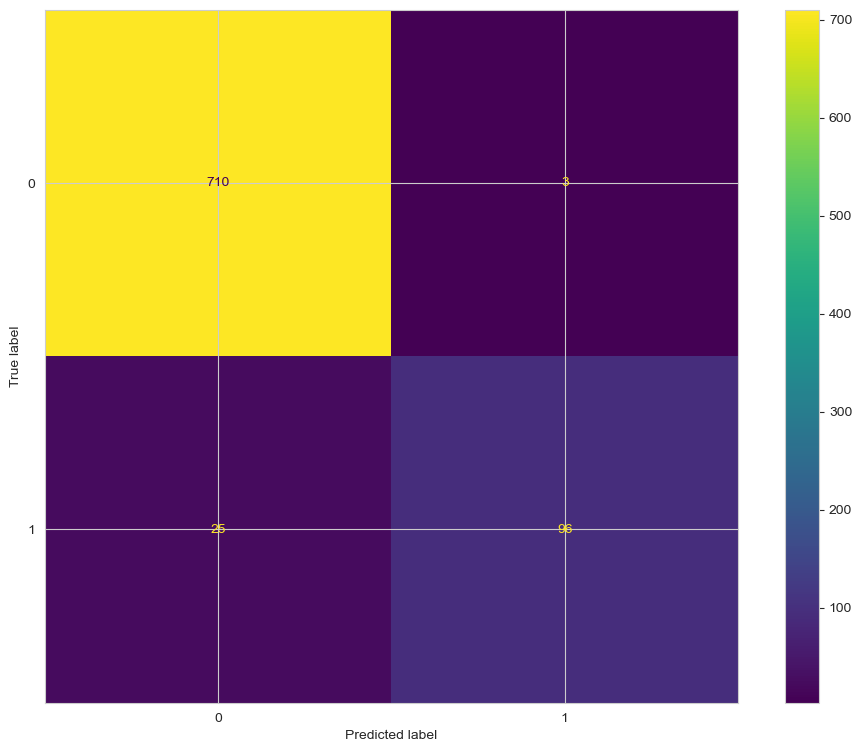

In [413]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=clf_xgb.classes_)
disp.plot()
plt.show()

Подбираем оптимальные параметры

Говорят, что для несбалансированных классов можно использовать scale_pos_weight и его оптимальный уровнь это соотношение классов (sum(y != 1)/sum(y))

In [425]:
param_grid = {
    'max_depth': [2,3,4,5,6,10],
    'learning_rate': [0.1, 0.01, 0.05, 0.005],
    'gamma': [0, 0.25, 1.0],
    'reg_lambda': [0, 1, 10],
    'scale_pos_weight': [sum(y != 1)/sum(y), 1, 3, 5]
    
}

optimal_params = GridSearchCV(
    estimator = xgboost.XGBClassifier(objective = 'binary:logistic',
                                     seed = SEED,
                                     subsampe = 0.9,
                                     colsample_by = 0.5),
    param_grid = param_grid,
    scoring = 'roc_auc',
    cv = 3
)

optimal_params.fit(X_train, y_train, early_stopping_rounds=10, eval_metric='auc', eval_set=[(X_test, y_test)])

print(optimal_params.best_params_)


[23:35:06] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "colsample_by", "subsampe" } are not used.

[0]	validation_0-auc:0.75030
[1]	validation_0-auc:0.84240
[2]	validation_0-auc:0.86665
[3]	validation_0-auc:0.87698
[4]	validation_0-auc:0.87511
[5]	validation_0-auc:0.87628
[6]	validation_0-auc:0.87931
[7]	validation_0-auc:0.88305
[8]	validation_0-auc:0.88459
[9]	validation_0-auc:0.88357
[10]	validation_0-auc:0.89435
[11]	validation_0-auc:0.88994
[12]	validation_0-auc:0.89485
[13]	validation_0-auc:0.89223
[14]	validation_0-auc:0.89197
[15]	validation_0-auc:0.89713
[16]	validation_0-auc:0.89922
[17]	validation_0-auc:0.90038
[18]	validation_0-auc:0.90024
[19]	validation_0-auc:0.89733
[20]	validation_0-auc:0.90072
[21]	validation_0-auc:0.90147
[22]	validation_0-auc:0.90358
[23]	validation_0-auc:0.90081
[24]	validation_0-auc:0.89895
[25]	validation_0-auc:0.89697
[26]	validation_

[5]	validation_0-auc:0.86742
[6]	validation_0-auc:0.86751
[7]	validation_0-auc:0.86923
[8]	validation_0-auc:0.87966
[9]	validation_0-auc:0.88280
[10]	validation_0-auc:0.88310
[11]	validation_0-auc:0.88160
[12]	validation_0-auc:0.88291
[13]	validation_0-auc:0.89888
[14]	validation_0-auc:0.89902
[15]	validation_0-auc:0.90138
[16]	validation_0-auc:0.90190
[17]	validation_0-auc:0.90182
[18]	validation_0-auc:0.90302
[19]	validation_0-auc:0.90307
[20]	validation_0-auc:0.90356
[21]	validation_0-auc:0.90358
[22]	validation_0-auc:0.90312
[23]	validation_0-auc:0.90324
[24]	validation_0-auc:0.90714
[25]	validation_0-auc:0.90638
[26]	validation_0-auc:0.90743
[27]	validation_0-auc:0.90840
[28]	validation_0-auc:0.90873
[29]	validation_0-auc:0.90580
[30]	validation_0-auc:0.90505
[31]	validation_0-auc:0.90313
[32]	validation_0-auc:0.90004
[33]	validation_0-auc:0.89999
[34]	validation_0-auc:0.90361
[35]	validation_0-auc:0.90352
[36]	validation_0-auc:0.90820
[37]	validation_0-auc:0.90847
[23:35:07] WARN

[44]	validation_0-auc:0.91113
[45]	validation_0-auc:0.91255
[46]	validation_0-auc:0.91309
[47]	validation_0-auc:0.91245
[48]	validation_0-auc:0.91267
[49]	validation_0-auc:0.91312
[50]	validation_0-auc:0.91299
[51]	validation_0-auc:0.91290
[52]	validation_0-auc:0.91208
[53]	validation_0-auc:0.91213
[54]	validation_0-auc:0.91212
[55]	validation_0-auc:0.91339
[56]	validation_0-auc:0.91343
[57]	validation_0-auc:0.91310
[58]	validation_0-auc:0.91306
[59]	validation_0-auc:0.91331
[60]	validation_0-auc:0.91310
[61]	validation_0-auc:0.91336
[62]	validation_0-auc:0.91275
[63]	validation_0-auc:0.91269
[64]	validation_0-auc:0.91276
[65]	validation_0-auc:0.91243
[66]	validation_0-auc:0.91401
[67]	validation_0-auc:0.91468
[68]	validation_0-auc:0.91463
[69]	validation_0-auc:0.91571
[70]	validation_0-auc:0.91514
[71]	validation_0-auc:0.91528
[72]	validation_0-auc:0.91513
[73]	validation_0-auc:0.91528
[74]	validation_0-auc:0.91538
[75]	validation_0-auc:0.91526
[76]	validation_0-auc:0.91586
[77]	valid

[25]	validation_0-auc:0.90191
[26]	validation_0-auc:0.89963
[27]	validation_0-auc:0.90043
[28]	validation_0-auc:0.90044
[29]	validation_0-auc:0.90839
[30]	validation_0-auc:0.90890
[31]	validation_0-auc:0.90878
[32]	validation_0-auc:0.90724
[33]	validation_0-auc:0.90856
[34]	validation_0-auc:0.90626
[35]	validation_0-auc:0.90614
[36]	validation_0-auc:0.90520
[37]	validation_0-auc:0.90545
[38]	validation_0-auc:0.90729
[39]	validation_0-auc:0.90767
[23:35:08] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "colsample_by", "subsampe" } are not used.

[0]	validation_0-auc:0.80284
[1]	validation_0-auc:0.80959
[2]	validation_0-auc:0.80919
[3]	validation_0-auc:0.87466
[4]	validation_0-auc:0.87562
[5]	validation_0-auc:0.87969
[6]	validation_0-auc:0.89020
[7]	validation_0-auc:0.88940
[8]	validation_0-auc:0.89125
[9]	validation_0-auc:0.89535
[10]	validation_0-auc:0.89398
[11]	validation_

[31]	validation_0-auc:0.90666
[32]	validation_0-auc:0.90711
[33]	validation_0-auc:0.90769
[34]	validation_0-auc:0.90906
[35]	validation_0-auc:0.91068
[36]	validation_0-auc:0.91101
[37]	validation_0-auc:0.91127
[38]	validation_0-auc:0.91351
[39]	validation_0-auc:0.91215
[40]	validation_0-auc:0.91200
[41]	validation_0-auc:0.91239
[42]	validation_0-auc:0.91172
[43]	validation_0-auc:0.91279
[44]	validation_0-auc:0.91277
[45]	validation_0-auc:0.91250
[46]	validation_0-auc:0.91384
[47]	validation_0-auc:0.91422
[48]	validation_0-auc:0.91353
[49]	validation_0-auc:0.91334
[50]	validation_0-auc:0.91395
[51]	validation_0-auc:0.91532
[52]	validation_0-auc:0.91570
[53]	validation_0-auc:0.91492
[54]	validation_0-auc:0.91552
[55]	validation_0-auc:0.91644
[56]	validation_0-auc:0.91645
[57]	validation_0-auc:0.91597
[58]	validation_0-auc:0.91595
[59]	validation_0-auc:0.91495
[60]	validation_0-auc:0.91510
[61]	validation_0-auc:0.91634
[62]	validation_0-auc:0.91821
[63]	validation_0-auc:0.91773
[64]	valid

[72]	validation_0-auc:0.91754
[73]	validation_0-auc:0.91736
[74]	validation_0-auc:0.91727
[75]	validation_0-auc:0.91773
[76]	validation_0-auc:0.91696
[77]	validation_0-auc:0.91687
[78]	validation_0-auc:0.91649
[79]	validation_0-auc:0.91604
[80]	validation_0-auc:0.91596
[81]	validation_0-auc:0.91594
[82]	validation_0-auc:0.91585
[83]	validation_0-auc:0.91561
[84]	validation_0-auc:0.91625
[23:35:09] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "colsample_by", "subsampe" } are not used.

[0]	validation_0-auc:0.75534
[1]	validation_0-auc:0.75591
[2]	validation_0-auc:0.81430
[3]	validation_0-auc:0.88221
[4]	validation_0-auc:0.87346
[5]	validation_0-auc:0.88851
[6]	validation_0-auc:0.88357
[7]	validation_0-auc:0.88662
[8]	validation_0-auc:0.89633
[9]	validation_0-auc:0.89660
[10]	validation_0-auc:0.89796
[11]	validation_0-auc:0.89713
[12]	validation_0-auc:0.89747
[13]	validation_

[24]	validation_0-auc:0.90756
[25]	validation_0-auc:0.90685
[26]	validation_0-auc:0.90844
[27]	validation_0-auc:0.90878
[28]	validation_0-auc:0.90603
[29]	validation_0-auc:0.90692
[30]	validation_0-auc:0.90873
[31]	validation_0-auc:0.90936
[32]	validation_0-auc:0.90911
[33]	validation_0-auc:0.90829
[34]	validation_0-auc:0.90819
[35]	validation_0-auc:0.90695
[36]	validation_0-auc:0.90902
[37]	validation_0-auc:0.91183
[38]	validation_0-auc:0.91267
[39]	validation_0-auc:0.91257
[40]	validation_0-auc:0.91129
[41]	validation_0-auc:0.91153
[42]	validation_0-auc:0.91157
[43]	validation_0-auc:0.91243
[44]	validation_0-auc:0.91225
[45]	validation_0-auc:0.91225
[46]	validation_0-auc:0.91204
[47]	validation_0-auc:0.91192
[48]	validation_0-auc:0.91319
[49]	validation_0-auc:0.91410
[50]	validation_0-auc:0.91388
[51]	validation_0-auc:0.91376
[52]	validation_0-auc:0.91340
[53]	validation_0-auc:0.91324
[54]	validation_0-auc:0.91333
[55]	validation_0-auc:0.91387
[56]	validation_0-auc:0.91409
[57]	valid

[4]	validation_0-auc:0.75928
[5]	validation_0-auc:0.84424
[6]	validation_0-auc:0.84451
[7]	validation_0-auc:0.88273
[8]	validation_0-auc:0.88540
[9]	validation_0-auc:0.88558
[10]	validation_0-auc:0.88593
[11]	validation_0-auc:0.88741
[12]	validation_0-auc:0.89078
[13]	validation_0-auc:0.89177
[14]	validation_0-auc:0.89307
[15]	validation_0-auc:0.89242
[16]	validation_0-auc:0.89241
[17]	validation_0-auc:0.89552
[18]	validation_0-auc:0.89549
[19]	validation_0-auc:0.89617
[20]	validation_0-auc:0.89762
[21]	validation_0-auc:0.89593
[22]	validation_0-auc:0.89624
[23]	validation_0-auc:0.89658
[24]	validation_0-auc:0.90175
[25]	validation_0-auc:0.90068
[26]	validation_0-auc:0.90256
[27]	validation_0-auc:0.90206
[28]	validation_0-auc:0.89574
[29]	validation_0-auc:0.89562
[30]	validation_0-auc:0.89791
[31]	validation_0-auc:0.89850
[32]	validation_0-auc:0.89904
[33]	validation_0-auc:0.89890
[34]	validation_0-auc:0.89948
[35]	validation_0-auc:0.89973
[36]	validation_0-auc:0.89895
[23:35:10] WARNI

[0]	validation_0-auc:0.80027
[1]	validation_0-auc:0.81380
[2]	validation_0-auc:0.80963
[3]	validation_0-auc:0.87458
[4]	validation_0-auc:0.87076
[5]	validation_0-auc:0.87945
[6]	validation_0-auc:0.87712
[7]	validation_0-auc:0.88176
[8]	validation_0-auc:0.88813
[9]	validation_0-auc:0.88656
[10]	validation_0-auc:0.89044
[11]	validation_0-auc:0.88629
[12]	validation_0-auc:0.88974
[13]	validation_0-auc:0.89421
[14]	validation_0-auc:0.89002
[15]	validation_0-auc:0.88879
[16]	validation_0-auc:0.89627
[17]	validation_0-auc:0.90024
[18]	validation_0-auc:0.90201
[19]	validation_0-auc:0.90250
[20]	validation_0-auc:0.90258
[21]	validation_0-auc:0.90199
[22]	validation_0-auc:0.89983
[23]	validation_0-auc:0.90260
[24]	validation_0-auc:0.89691
[25]	validation_0-auc:0.89680
[26]	validation_0-auc:0.89844
[27]	validation_0-auc:0.90269
[28]	validation_0-auc:0.90461
[29]	validation_0-auc:0.90542
[30]	validation_0-auc:0.90568
[31]	validation_0-auc:0.90628
[32]	validation_0-auc:0.90587
[33]	validation_0-au

[39]	validation_0-auc:0.91660
[40]	validation_0-auc:0.91740
[41]	validation_0-auc:0.91636
[42]	validation_0-auc:0.91718
[43]	validation_0-auc:0.91581
[44]	validation_0-auc:0.91425
[45]	validation_0-auc:0.91374
[46]	validation_0-auc:0.91471
[47]	validation_0-auc:0.91439
[23:35:11] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "colsample_by", "subsampe" } are not used.

[0]	validation_0-auc:0.84326
[1]	validation_0-auc:0.85432
[2]	validation_0-auc:0.85792
[3]	validation_0-auc:0.86751
[4]	validation_0-auc:0.86742
[5]	validation_0-auc:0.86784
[6]	validation_0-auc:0.86714
[7]	validation_0-auc:0.89815
[8]	validation_0-auc:0.89894
[9]	validation_0-auc:0.89998
[10]	validation_0-auc:0.90389
[11]	validation_0-auc:0.90543
[12]	validation_0-auc:0.90523
[13]	validation_0-auc:0.91027
[14]	validation_0-auc:0.91105
[15]	validation_0-auc:0.91096
[16]	validation_0-auc:0.90973
[17]	validation_

[26]	validation_0-auc:0.91365
[27]	validation_0-auc:0.91516
[28]	validation_0-auc:0.91662
[29]	validation_0-auc:0.91566
[30]	validation_0-auc:0.91526
[31]	validation_0-auc:0.91675
[32]	validation_0-auc:0.91782
[33]	validation_0-auc:0.91790
[34]	validation_0-auc:0.91746
[35]	validation_0-auc:0.91652
[36]	validation_0-auc:0.91846
[37]	validation_0-auc:0.91830
[38]	validation_0-auc:0.91523
[39]	validation_0-auc:0.91711
[40]	validation_0-auc:0.91821
[41]	validation_0-auc:0.91773
[42]	validation_0-auc:0.91781
[43]	validation_0-auc:0.91767
[44]	validation_0-auc:0.91880
[45]	validation_0-auc:0.91958
[46]	validation_0-auc:0.91988
[47]	validation_0-auc:0.91971
[48]	validation_0-auc:0.92334
[49]	validation_0-auc:0.92337
[50]	validation_0-auc:0.92306
[51]	validation_0-auc:0.92340
[52]	validation_0-auc:0.92342
[53]	validation_0-auc:0.92403
[54]	validation_0-auc:0.92396
[55]	validation_0-auc:0.92458
[56]	validation_0-auc:0.92410
[57]	validation_0-auc:0.92463
[58]	validation_0-auc:0.92345
[59]	valid

[3]	validation_0-auc:0.89356
[4]	validation_0-auc:0.89310
[5]	validation_0-auc:0.89493
[6]	validation_0-auc:0.89616
[7]	validation_0-auc:0.89773
[8]	validation_0-auc:0.89719
[9]	validation_0-auc:0.89640
[10]	validation_0-auc:0.90020
[11]	validation_0-auc:0.90055
[12]	validation_0-auc:0.89778
[13]	validation_0-auc:0.89735
[14]	validation_0-auc:0.90064
[15]	validation_0-auc:0.90062
[16]	validation_0-auc:0.90207
[17]	validation_0-auc:0.90359
[18]	validation_0-auc:0.90410
[19]	validation_0-auc:0.90570
[20]	validation_0-auc:0.90684
[21]	validation_0-auc:0.90724
[22]	validation_0-auc:0.91097
[23]	validation_0-auc:0.91026
[24]	validation_0-auc:0.91022
[25]	validation_0-auc:0.91140
[26]	validation_0-auc:0.91133
[27]	validation_0-auc:0.91113
[28]	validation_0-auc:0.91206
[29]	validation_0-auc:0.91404
[30]	validation_0-auc:0.91430
[31]	validation_0-auc:0.91528
[32]	validation_0-auc:0.91544
[33]	validation_0-auc:0.91472
[34]	validation_0-auc:0.91439
[35]	validation_0-auc:0.91793
[36]	validation_0

[41]	validation_0-auc:0.91617
[42]	validation_0-auc:0.91660
[43]	validation_0-auc:0.91629
[44]	validation_0-auc:0.91397
[45]	validation_0-auc:0.91446
[46]	validation_0-auc:0.91463
[47]	validation_0-auc:0.91436
[48]	validation_0-auc:0.91440
[49]	validation_0-auc:0.91533
[50]	validation_0-auc:0.91518
[51]	validation_0-auc:0.91650
[52]	validation_0-auc:0.91693
[53]	validation_0-auc:0.91773
[54]	validation_0-auc:0.91876
[55]	validation_0-auc:0.91867
[56]	validation_0-auc:0.91962
[57]	validation_0-auc:0.91873
[58]	validation_0-auc:0.91918
[59]	validation_0-auc:0.92036
[60]	validation_0-auc:0.92004
[61]	validation_0-auc:0.92013
[62]	validation_0-auc:0.91914
[63]	validation_0-auc:0.91930
[64]	validation_0-auc:0.91945
[65]	validation_0-auc:0.92035
[66]	validation_0-auc:0.91985
[67]	validation_0-auc:0.92074
[68]	validation_0-auc:0.92059
[69]	validation_0-auc:0.92035
[70]	validation_0-auc:0.92036
[71]	validation_0-auc:0.92058
[72]	validation_0-auc:0.92136
[73]	validation_0-auc:0.92148
[74]	valid

[21]	validation_0-auc:0.91205
[22]	validation_0-auc:0.91594
[23]	validation_0-auc:0.91618
[24]	validation_0-auc:0.91963
[25]	validation_0-auc:0.91806
[26]	validation_0-auc:0.91840
[27]	validation_0-auc:0.92004
[28]	validation_0-auc:0.92146
[29]	validation_0-auc:0.92175
[30]	validation_0-auc:0.92120
[31]	validation_0-auc:0.91749
[32]	validation_0-auc:0.91759
[33]	validation_0-auc:0.91752
[34]	validation_0-auc:0.91793
[35]	validation_0-auc:0.91811
[36]	validation_0-auc:0.91685
[37]	validation_0-auc:0.91792
[38]	validation_0-auc:0.91661
[23:35:14] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "colsample_by", "subsampe" } are not used.

[0]	validation_0-auc:0.85637
[1]	validation_0-auc:0.86028
[2]	validation_0-auc:0.89402
[3]	validation_0-auc:0.89555
[4]	validation_0-auc:0.89626
[5]	validation_0-auc:0.89486
[6]	validation_0-auc:0.89671
[7]	validation_0-auc:0.89656
[8]	validation

[87]	validation_0-auc:0.92441
[88]	validation_0-auc:0.92487
[89]	validation_0-auc:0.92514
[90]	validation_0-auc:0.92485
[91]	validation_0-auc:0.92503
[92]	validation_0-auc:0.92504
[93]	validation_0-auc:0.92457
[94]	validation_0-auc:0.92443
[95]	validation_0-auc:0.92404
[96]	validation_0-auc:0.92377
[97]	validation_0-auc:0.92407
[98]	validation_0-auc:0.92441
[99]	validation_0-auc:0.92439
[23:35:14] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "colsample_by", "subsampe" } are not used.

[0]	validation_0-auc:0.88324
[1]	validation_0-auc:0.88861
[2]	validation_0-auc:0.88941
[3]	validation_0-auc:0.88940
[4]	validation_0-auc:0.88959
[5]	validation_0-auc:0.89163
[6]	validation_0-auc:0.89297
[7]	validation_0-auc:0.89410
[8]	validation_0-auc:0.89369
[9]	validation_0-auc:0.89417
[10]	validation_0-auc:0.89589
[11]	validation_0-auc:0.89450
[12]	validation_0-auc:0.89424
[13]	validation_

[27]	validation_0-auc:0.91486
[28]	validation_0-auc:0.91493
[29]	validation_0-auc:0.91516
[30]	validation_0-auc:0.90984
[31]	validation_0-auc:0.91067
[32]	validation_0-auc:0.91077
[33]	validation_0-auc:0.91078
[34]	validation_0-auc:0.91132
[35]	validation_0-auc:0.91186
[23:35:15] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "colsample_by", "subsampe" } are not used.

[0]	validation_0-auc:0.85610
[1]	validation_0-auc:0.86968
[2]	validation_0-auc:0.87233
[3]	validation_0-auc:0.88838
[4]	validation_0-auc:0.89153
[5]	validation_0-auc:0.89050
[6]	validation_0-auc:0.89210
[7]	validation_0-auc:0.89347
[8]	validation_0-auc:0.89710
[9]	validation_0-auc:0.89857
[10]	validation_0-auc:0.89938
[11]	validation_0-auc:0.89951
[12]	validation_0-auc:0.90211
[13]	validation_0-auc:0.90190
[14]	validation_0-auc:0.90317
[15]	validation_0-auc:0.90464
[16]	validation_0-auc:0.90382
[17]	validation_

[50]	validation_0-auc:0.91873
[51]	validation_0-auc:0.91823
[52]	validation_0-auc:0.91873
[53]	validation_0-auc:0.91738
[23:35:15] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "colsample_by", "subsampe" } are not used.

[0]	validation_0-auc:0.88476
[1]	validation_0-auc:0.89060
[2]	validation_0-auc:0.88902
[3]	validation_0-auc:0.88969
[4]	validation_0-auc:0.88965
[5]	validation_0-auc:0.89128
[6]	validation_0-auc:0.89384
[7]	validation_0-auc:0.89376
[8]	validation_0-auc:0.89405
[9]	validation_0-auc:0.89499
[10]	validation_0-auc:0.89520
[11]	validation_0-auc:0.89769
[12]	validation_0-auc:0.89604
[13]	validation_0-auc:0.89836
[14]	validation_0-auc:0.89967
[15]	validation_0-auc:0.90394
[16]	validation_0-auc:0.90484
[17]	validation_0-auc:0.90626
[18]	validation_0-auc:0.90751
[19]	validation_0-auc:0.91374
[20]	validation_0-auc:0.91377
[21]	validation_0-auc:0.91328
[22]	validation_

[10]	validation_0-auc:0.91598
[11]	validation_0-auc:0.91708
[12]	validation_0-auc:0.91642
[13]	validation_0-auc:0.91734
[14]	validation_0-auc:0.91825
[15]	validation_0-auc:0.91811
[16]	validation_0-auc:0.91775
[17]	validation_0-auc:0.91875
[18]	validation_0-auc:0.91890
[19]	validation_0-auc:0.91977
[20]	validation_0-auc:0.92011
[21]	validation_0-auc:0.91942
[22]	validation_0-auc:0.91762
[23]	validation_0-auc:0.91828
[24]	validation_0-auc:0.91639
[25]	validation_0-auc:0.91520
[26]	validation_0-auc:0.91592
[27]	validation_0-auc:0.91466
[28]	validation_0-auc:0.91576
[29]	validation_0-auc:0.91479
[30]	validation_0-auc:0.91387
[23:35:16] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "colsample_by", "subsampe" } are not used.

[0]	validation_0-auc:0.88559
[1]	validation_0-auc:0.88744
[2]	validation_0-auc:0.89269
[3]	validation_0-auc:0.89832
[4]	validation_0-auc:0.89817
[5]	validat

[4]	validation_0-auc:0.90876
[5]	validation_0-auc:0.90972
[6]	validation_0-auc:0.90824
[7]	validation_0-auc:0.90822
[8]	validation_0-auc:0.90887
[9]	validation_0-auc:0.90990
[10]	validation_0-auc:0.90936
[11]	validation_0-auc:0.90829
[12]	validation_0-auc:0.90881
[13]	validation_0-auc:0.90811
[14]	validation_0-auc:0.90632
[15]	validation_0-auc:0.90539
[16]	validation_0-auc:0.90575
[17]	validation_0-auc:0.90653
[18]	validation_0-auc:0.90756
[19]	validation_0-auc:0.90918
[23:35:17] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "colsample_by", "subsampe" } are not used.

[0]	validation_0-auc:0.86877
[1]	validation_0-auc:0.87082
[2]	validation_0-auc:0.89993
[3]	validation_0-auc:0.90392
[4]	validation_0-auc:0.90744
[5]	validation_0-auc:0.90845
[6]	validation_0-auc:0.91201
[7]	validation_0-auc:0.91196
[8]	validation_0-auc:0.91317
[9]	validation_0-auc:0.91332
[10]	validation_0-auc:

[13]	validation_0-auc:0.92046
[14]	validation_0-auc:0.92120
[15]	validation_0-auc:0.92160
[16]	validation_0-auc:0.92474
[17]	validation_0-auc:0.92523
[18]	validation_0-auc:0.92956
[19]	validation_0-auc:0.92624
[20]	validation_0-auc:0.92629
[21]	validation_0-auc:0.92801
[22]	validation_0-auc:0.92297
[23]	validation_0-auc:0.92273
[24]	validation_0-auc:0.92284
[25]	validation_0-auc:0.92425
[26]	validation_0-auc:0.92358
[27]	validation_0-auc:0.92566
[23:35:18] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "colsample_by", "subsampe" } are not used.

[0]	validation_0-auc:0.87334
[1]	validation_0-auc:0.90173
[2]	validation_0-auc:0.90821
[3]	validation_0-auc:0.90801
[4]	validation_0-auc:0.91348
[5]	validation_0-auc:0.91109
[6]	validation_0-auc:0.91320
[7]	validation_0-auc:0.91922
[8]	validation_0-auc:0.92030
[9]	validation_0-auc:0.92033
[10]	validation_0-auc:0.91929
[11]	validation_

[45]	validation_0-auc:0.93158
[46]	validation_0-auc:0.93137
[47]	validation_0-auc:0.93234
[48]	validation_0-auc:0.93199
[49]	validation_0-auc:0.93269
[50]	validation_0-auc:0.93281
[51]	validation_0-auc:0.93413
[52]	validation_0-auc:0.93438
[53]	validation_0-auc:0.93397
[54]	validation_0-auc:0.93355
[55]	validation_0-auc:0.93431
[56]	validation_0-auc:0.93509
[57]	validation_0-auc:0.93495
[58]	validation_0-auc:0.93548
[59]	validation_0-auc:0.93582
[60]	validation_0-auc:0.93575
[61]	validation_0-auc:0.93565
[62]	validation_0-auc:0.93562
[63]	validation_0-auc:0.93577
[64]	validation_0-auc:0.93625
[65]	validation_0-auc:0.93582
[66]	validation_0-auc:0.93627
[67]	validation_0-auc:0.93642
[68]	validation_0-auc:0.93634
[69]	validation_0-auc:0.93684
[70]	validation_0-auc:0.93732
[71]	validation_0-auc:0.93700
[72]	validation_0-auc:0.93759
[73]	validation_0-auc:0.93792
[74]	validation_0-auc:0.93761
[75]	validation_0-auc:0.93765
[76]	validation_0-auc:0.93785
[77]	validation_0-auc:0.93801
[78]	valid

[36]	validation_0-auc:0.91873
[37]	validation_0-auc:0.91890
[38]	validation_0-auc:0.92048
[39]	validation_0-auc:0.92033
[40]	validation_0-auc:0.91935
[41]	validation_0-auc:0.91890
[42]	validation_0-auc:0.91988
[43]	validation_0-auc:0.92061
[44]	validation_0-auc:0.92127
[45]	validation_0-auc:0.92031
[46]	validation_0-auc:0.91986
[47]	validation_0-auc:0.91827
[48]	validation_0-auc:0.91820
[49]	validation_0-auc:0.91807
[50]	validation_0-auc:0.91723
[51]	validation_0-auc:0.91718
[52]	validation_0-auc:0.91789
[53]	validation_0-auc:0.91847
[23:35:19] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "colsample_by", "subsampe" } are not used.

[0]	validation_0-auc:0.87555
[1]	validation_0-auc:0.87697
[2]	validation_0-auc:0.89163
[3]	validation_0-auc:0.89365
[4]	validation_0-auc:0.90053
[5]	validation_0-auc:0.90353
[6]	validation_0-auc:0.90671
[7]	validation_0-auc:0.90862
[8]	validation

[0]	validation_0-auc:0.88425
[1]	validation_0-auc:0.89010
[2]	validation_0-auc:0.89063
[3]	validation_0-auc:0.89099
[4]	validation_0-auc:0.89929
[5]	validation_0-auc:0.91229
[6]	validation_0-auc:0.91667
[7]	validation_0-auc:0.92330
[8]	validation_0-auc:0.92491
[9]	validation_0-auc:0.92298
[10]	validation_0-auc:0.92726
[11]	validation_0-auc:0.93245
[12]	validation_0-auc:0.93258
[13]	validation_0-auc:0.93137
[14]	validation_0-auc:0.93318
[15]	validation_0-auc:0.93394
[16]	validation_0-auc:0.93331
[17]	validation_0-auc:0.93288
[18]	validation_0-auc:0.93085
[19]	validation_0-auc:0.93120
[20]	validation_0-auc:0.93347
[21]	validation_0-auc:0.93314
[22]	validation_0-auc:0.93166
[23]	validation_0-auc:0.93127
[24]	validation_0-auc:0.93230
[25]	validation_0-auc:0.93412
[26]	validation_0-auc:0.93784
[27]	validation_0-auc:0.93749
[28]	validation_0-auc:0.93525
[29]	validation_0-auc:0.93563
[30]	validation_0-auc:0.93712
[31]	validation_0-auc:0.93707
[32]	validation_0-auc:0.93579
[33]	validation_0-au

[0]	validation_0-auc:0.88425
[1]	validation_0-auc:0.88744
[2]	validation_0-auc:0.89122
[3]	validation_0-auc:0.89962
[4]	validation_0-auc:0.90400
[5]	validation_0-auc:0.91547
[6]	validation_0-auc:0.92480
[7]	validation_0-auc:0.92023
[8]	validation_0-auc:0.93042
[9]	validation_0-auc:0.93033
[10]	validation_0-auc:0.92807
[11]	validation_0-auc:0.93134
[12]	validation_0-auc:0.93343
[13]	validation_0-auc:0.93290
[14]	validation_0-auc:0.93509
[15]	validation_0-auc:0.93617
[16]	validation_0-auc:0.93596
[17]	validation_0-auc:0.93568
[18]	validation_0-auc:0.93770
[19]	validation_0-auc:0.93559
[20]	validation_0-auc:0.93526
[21]	validation_0-auc:0.93598
[22]	validation_0-auc:0.93727
[23]	validation_0-auc:0.93706
[24]	validation_0-auc:0.93691
[25]	validation_0-auc:0.93707
[26]	validation_0-auc:0.93553
[27]	validation_0-auc:0.93576
[23:35:21] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { 

[35]	validation_0-auc:0.93255
[36]	validation_0-auc:0.93245
[37]	validation_0-auc:0.93161
[23:35:21] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "colsample_by", "subsampe" } are not used.

[0]	validation_0-auc:0.90161
[1]	validation_0-auc:0.90698
[2]	validation_0-auc:0.90598
[3]	validation_0-auc:0.90795
[4]	validation_0-auc:0.91002
[5]	validation_0-auc:0.91185
[6]	validation_0-auc:0.91285
[7]	validation_0-auc:0.91322
[8]	validation_0-auc:0.91411
[9]	validation_0-auc:0.91470
[10]	validation_0-auc:0.91573
[11]	validation_0-auc:0.91638
[12]	validation_0-auc:0.91249
[13]	validation_0-auc:0.91269
[14]	validation_0-auc:0.91275
[15]	validation_0-auc:0.91323
[16]	validation_0-auc:0.91346
[17]	validation_0-auc:0.91375
[18]	validation_0-auc:0.91300
[19]	validation_0-auc:0.91288
[20]	validation_0-auc:0.91594
[23:35:21] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscal

[0]	validation_0-auc:0.89086
[1]	validation_0-auc:0.89478
[2]	validation_0-auc:0.90281
[3]	validation_0-auc:0.90255
[4]	validation_0-auc:0.90707
[5]	validation_0-auc:0.91607
[6]	validation_0-auc:0.91569
[7]	validation_0-auc:0.91316
[8]	validation_0-auc:0.91599
[9]	validation_0-auc:0.91428
[10]	validation_0-auc:0.91754
[11]	validation_0-auc:0.91647
[12]	validation_0-auc:0.91328
[13]	validation_0-auc:0.91299
[14]	validation_0-auc:0.91243
[15]	validation_0-auc:0.91392
[16]	validation_0-auc:0.91277
[17]	validation_0-auc:0.91266
[18]	validation_0-auc:0.91270
[19]	validation_0-auc:0.91139
[23:35:22] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "colsample_by", "subsampe" } are not used.

[0]	validation_0-auc:0.89445
[1]	validation_0-auc:0.89970
[2]	validation_0-auc:0.90092
[3]	validation_0-auc:0.90148
[4]	validation_0-auc:0.90507
[5]	validation_0-auc:0.90630
[6]	validation_0-auc:0

[15]	validation_0-auc:0.91373
[16]	validation_0-auc:0.91023
[17]	validation_0-auc:0.91295
[18]	validation_0-auc:0.91352
[19]	validation_0-auc:0.91395
[20]	validation_0-auc:0.91495
[21]	validation_0-auc:0.91385
[22]	validation_0-auc:0.91427
[23]	validation_0-auc:0.91281
[24]	validation_0-auc:0.91299
[25]	validation_0-auc:0.91248
[26]	validation_0-auc:0.91131
[27]	validation_0-auc:0.91108
[28]	validation_0-auc:0.91343
[29]	validation_0-auc:0.91341
[30]	validation_0-auc:0.91580
[31]	validation_0-auc:0.91452
[32]	validation_0-auc:0.91447
[33]	validation_0-auc:0.91646
[34]	validation_0-auc:0.91435
[35]	validation_0-auc:0.91536
[36]	validation_0-auc:0.91424
[37]	validation_0-auc:0.91555
[38]	validation_0-auc:0.91403
[39]	validation_0-auc:0.91391
[40]	validation_0-auc:0.91485
[41]	validation_0-auc:0.91545
[42]	validation_0-auc:0.91561
[23:35:23] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Para

[70]	validation_0-auc:0.91530
[71]	validation_0-auc:0.91501
[72]	validation_0-auc:0.91547
[73]	validation_0-auc:0.91549
[23:35:24] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "colsample_by", "subsampe" } are not used.

[0]	validation_0-auc:0.85258
[1]	validation_0-auc:0.85954
[2]	validation_0-auc:0.85563
[3]	validation_0-auc:0.87100
[4]	validation_0-auc:0.90658
[5]	validation_0-auc:0.89854
[6]	validation_0-auc:0.91782
[7]	validation_0-auc:0.91901
[8]	validation_0-auc:0.92017
[9]	validation_0-auc:0.91977
[10]	validation_0-auc:0.92002
[11]	validation_0-auc:0.91949
[12]	validation_0-auc:0.92447
[13]	validation_0-auc:0.93023
[14]	validation_0-auc:0.93089
[15]	validation_0-auc:0.93463
[16]	validation_0-auc:0.93440
[17]	validation_0-auc:0.93371
[18]	validation_0-auc:0.93640
[19]	validation_0-auc:0.93838
[20]	validation_0-auc:0.93932
[21]	validation_0-auc:0.93937
[22]	validation_

[9]	validation_0-auc:0.89324
[10]	validation_0-auc:0.89165
[11]	validation_0-auc:0.89613
[12]	validation_0-auc:0.89635
[13]	validation_0-auc:0.89588
[14]	validation_0-auc:0.89553
[15]	validation_0-auc:0.89532
[16]	validation_0-auc:0.89446
[17]	validation_0-auc:0.89494
[18]	validation_0-auc:0.89420
[19]	validation_0-auc:0.89345
[20]	validation_0-auc:0.89416
[21]	validation_0-auc:0.89560
[22]	validation_0-auc:0.89727
[23]	validation_0-auc:0.89619
[24]	validation_0-auc:0.89613
[25]	validation_0-auc:0.89696
[26]	validation_0-auc:0.89594
[27]	validation_0-auc:0.89440
[28]	validation_0-auc:0.89476
[29]	validation_0-auc:0.89573
[30]	validation_0-auc:0.89292
[31]	validation_0-auc:0.89406
[32]	validation_0-auc:0.89414
[23:35:25] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "colsample_by", "subsampe" } are not used.

[0]	validation_0-auc:0.86782
[1]	validation_0-auc:0.87126
[2]	valid

[11]	validation_0-auc:0.92759
[12]	validation_0-auc:0.92871
[13]	validation_0-auc:0.92555
[14]	validation_0-auc:0.92543
[15]	validation_0-auc:0.93157
[16]	validation_0-auc:0.93038
[17]	validation_0-auc:0.93008
[18]	validation_0-auc:0.92997
[19]	validation_0-auc:0.92862
[20]	validation_0-auc:0.92867
[21]	validation_0-auc:0.93525
[22]	validation_0-auc:0.93304
[23]	validation_0-auc:0.93086
[24]	validation_0-auc:0.92812
[25]	validation_0-auc:0.92676
[26]	validation_0-auc:0.92923
[27]	validation_0-auc:0.93176
[28]	validation_0-auc:0.93090
[29]	validation_0-auc:0.92901
[30]	validation_0-auc:0.92975
[23:35:26] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "colsample_by", "subsampe" } are not used.

[0]	validation_0-auc:0.90459
[1]	validation_0-auc:0.90360
[2]	validation_0-auc:0.90827
[3]	validation_0-auc:0.90802
[4]	validation_0-auc:0.90848
[5]	validation_0-auc:0.90888
[6]	validati

[32]	validation_0-auc:0.91016
[33]	validation_0-auc:0.90728
[34]	validation_0-auc:0.91016
[35]	validation_0-auc:0.90998
[36]	validation_0-auc:0.91188
[37]	validation_0-auc:0.91128
[38]	validation_0-auc:0.91145
[39]	validation_0-auc:0.91158
[40]	validation_0-auc:0.91177
[41]	validation_0-auc:0.91186
[42]	validation_0-auc:0.91358
[43]	validation_0-auc:0.91319
[44]	validation_0-auc:0.91190
[45]	validation_0-auc:0.91082
[46]	validation_0-auc:0.91100
[47]	validation_0-auc:0.91224
[48]	validation_0-auc:0.91232
[49]	validation_0-auc:0.91234
[50]	validation_0-auc:0.91178
[51]	validation_0-auc:0.91143
[52]	validation_0-auc:0.91172
[23:35:27] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "colsample_by", "subsampe" } are not used.

[0]	validation_0-auc:0.87927
[1]	validation_0-auc:0.89397
[2]	validation_0-auc:0.90135
[3]	validation_0-auc:0.90971
[4]	validation_0-auc:0.91475
[5]	validat

[0]	validation_0-auc:0.90008
[1]	validation_0-auc:0.90572
[2]	validation_0-auc:0.91005
[3]	validation_0-auc:0.91148
[4]	validation_0-auc:0.90975
[5]	validation_0-auc:0.90863
[6]	validation_0-auc:0.91155
[7]	validation_0-auc:0.91133
[8]	validation_0-auc:0.91365
[9]	validation_0-auc:0.91376
[10]	validation_0-auc:0.91037
[11]	validation_0-auc:0.91154
[12]	validation_0-auc:0.91090
[13]	validation_0-auc:0.91097
[14]	validation_0-auc:0.91089
[15]	validation_0-auc:0.91055
[16]	validation_0-auc:0.90999
[17]	validation_0-auc:0.90973
[18]	validation_0-auc:0.90967
[23:35:28] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "colsample_by", "subsampe" } are not used.

[0]	validation_0-auc:0.90031
[1]	validation_0-auc:0.90037
[2]	validation_0-auc:0.90044
[3]	validation_0-auc:0.90307
[4]	validation_0-auc:0.90722
[5]	validation_0-auc:0.90873
[6]	validation_0-auc:0.91031
[7]	validation_0-auc:0.

[33]	validation_0-auc:0.91847
[34]	validation_0-auc:0.91824
[35]	validation_0-auc:0.92009
[36]	validation_0-auc:0.92079
[37]	validation_0-auc:0.92096
[38]	validation_0-auc:0.92173
[39]	validation_0-auc:0.92077
[40]	validation_0-auc:0.91930
[41]	validation_0-auc:0.91986
[42]	validation_0-auc:0.92045
[43]	validation_0-auc:0.92123
[44]	validation_0-auc:0.92117
[45]	validation_0-auc:0.92220
[46]	validation_0-auc:0.92254
[47]	validation_0-auc:0.92393
[48]	validation_0-auc:0.92451
[49]	validation_0-auc:0.92467
[50]	validation_0-auc:0.92432
[51]	validation_0-auc:0.92641
[52]	validation_0-auc:0.92654
[53]	validation_0-auc:0.92569
[54]	validation_0-auc:0.92516
[55]	validation_0-auc:0.92412
[56]	validation_0-auc:0.92381
[57]	validation_0-auc:0.92344
[58]	validation_0-auc:0.92280
[59]	validation_0-auc:0.92246
[60]	validation_0-auc:0.92313
[61]	validation_0-auc:0.92270
[62]	validation_0-auc:0.92278
[23:35:29] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e

[47]	validation_0-auc:0.93729
[48]	validation_0-auc:0.93722
[49]	validation_0-auc:0.93686
[50]	validation_0-auc:0.93579
[51]	validation_0-auc:0.93552
[23:35:30] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "colsample_by", "subsampe" } are not used.

[0]	validation_0-auc:0.78526
[1]	validation_0-auc:0.84034
[2]	validation_0-auc:0.85212
[3]	validation_0-auc:0.85192
[4]	validation_0-auc:0.88055
[5]	validation_0-auc:0.89199
[6]	validation_0-auc:0.89051
[7]	validation_0-auc:0.89291
[8]	validation_0-auc:0.89775
[9]	validation_0-auc:0.89870
[10]	validation_0-auc:0.90149
[11]	validation_0-auc:0.90535
[12]	validation_0-auc:0.90573
[13]	validation_0-auc:0.91129
[14]	validation_0-auc:0.91103
[15]	validation_0-auc:0.91423
[16]	validation_0-auc:0.91529
[17]	validation_0-auc:0.91849
[18]	validation_0-auc:0.91682
[19]	validation_0-auc:0.91714
[20]	validation_0-auc:0.91654
[21]	validation_

[30]	validation_0-auc:0.90751
[31]	validation_0-auc:0.90791
[32]	validation_0-auc:0.90699
[33]	validation_0-auc:0.90886
[34]	validation_0-auc:0.90795
[35]	validation_0-auc:0.90773
[36]	validation_0-auc:0.90894
[37]	validation_0-auc:0.91026
[38]	validation_0-auc:0.90888
[39]	validation_0-auc:0.91132
[40]	validation_0-auc:0.91142
[41]	validation_0-auc:0.91252
[42]	validation_0-auc:0.91232
[43]	validation_0-auc:0.91170
[44]	validation_0-auc:0.91227
[45]	validation_0-auc:0.91330
[46]	validation_0-auc:0.91278
[47]	validation_0-auc:0.91406
[48]	validation_0-auc:0.91449
[49]	validation_0-auc:0.91454
[50]	validation_0-auc:0.91529
[51]	validation_0-auc:0.91435
[52]	validation_0-auc:0.91456
[53]	validation_0-auc:0.91357
[54]	validation_0-auc:0.91369
[55]	validation_0-auc:0.91459
[56]	validation_0-auc:0.91461
[57]	validation_0-auc:0.91570
[58]	validation_0-auc:0.91470
[59]	validation_0-auc:0.91379
[60]	validation_0-auc:0.91366
[61]	validation_0-auc:0.91369
[62]	validation_0-auc:0.91395
[63]	valid

[26]	validation_0-auc:0.91440
[27]	validation_0-auc:0.91609
[28]	validation_0-auc:0.91575
[23:35:33] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "colsample_by", "subsampe" } are not used.

[0]	validation_0-auc:0.86704
[1]	validation_0-auc:0.85868
[2]	validation_0-auc:0.85954
[3]	validation_0-auc:0.87211
[4]	validation_0-auc:0.87656
[5]	validation_0-auc:0.87748
[6]	validation_0-auc:0.87676
[7]	validation_0-auc:0.87800
[8]	validation_0-auc:0.87739
[9]	validation_0-auc:0.88041
[10]	validation_0-auc:0.88283
[11]	validation_0-auc:0.87814
[12]	validation_0-auc:0.88106
[13]	validation_0-auc:0.88238
[14]	validation_0-auc:0.88077
[15]	validation_0-auc:0.88073
[16]	validation_0-auc:0.88203
[17]	validation_0-auc:0.89016
[18]	validation_0-auc:0.89582
[19]	validation_0-auc:0.89497
[20]	validation_0-auc:0.89719
[21]	validation_0-auc:0.89596
[22]	validation_0-auc:0.89512
[23]	validation_

[5]	validation_0-auc:0.90996
[6]	validation_0-auc:0.90761
[7]	validation_0-auc:0.90756
[8]	validation_0-auc:0.90907
[9]	validation_0-auc:0.91077
[10]	validation_0-auc:0.91191
[11]	validation_0-auc:0.91217
[12]	validation_0-auc:0.90690
[13]	validation_0-auc:0.90921
[14]	validation_0-auc:0.91612
[15]	validation_0-auc:0.91772
[16]	validation_0-auc:0.91918
[17]	validation_0-auc:0.92302
[18]	validation_0-auc:0.92358
[19]	validation_0-auc:0.92324
[20]	validation_0-auc:0.92288
[21]	validation_0-auc:0.92238
[22]	validation_0-auc:0.92387
[23]	validation_0-auc:0.92412
[24]	validation_0-auc:0.92393
[25]	validation_0-auc:0.92503
[26]	validation_0-auc:0.92423
[27]	validation_0-auc:0.92275
[28]	validation_0-auc:0.92282
[29]	validation_0-auc:0.92288
[30]	validation_0-auc:0.92304
[31]	validation_0-auc:0.92215
[32]	validation_0-auc:0.92328
[33]	validation_0-auc:0.92429
[34]	validation_0-auc:0.92450
[23:35:34] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f

[0]	validation_0-auc:0.90035
[1]	validation_0-auc:0.90345
[2]	validation_0-auc:0.91024
[3]	validation_0-auc:0.91280
[4]	validation_0-auc:0.91816
[5]	validation_0-auc:0.91748
[6]	validation_0-auc:0.91786
[7]	validation_0-auc:0.91691
[8]	validation_0-auc:0.91642
[9]	validation_0-auc:0.91714
[10]	validation_0-auc:0.91789
[11]	validation_0-auc:0.91784
[12]	validation_0-auc:0.91633
[13]	validation_0-auc:0.91563
[23:35:35] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "colsample_by", "subsampe" } are not used.

[0]	validation_0-auc:0.89073
[1]	validation_0-auc:0.89610
[2]	validation_0-auc:0.90002
[3]	validation_0-auc:0.90495
[4]	validation_0-auc:0.90524
[5]	validation_0-auc:0.90231
[6]	validation_0-auc:0.90021
[7]	validation_0-auc:0.90049
[8]	validation_0-auc:0.90051
[9]	validation_0-auc:0.90277
[10]	validation_0-auc:0.90427
[11]	validation_0-auc:0.90245
[12]	validation_0-auc:0.90

[3]	validation_0-auc:0.76689
[4]	validation_0-auc:0.76689
[5]	validation_0-auc:0.76689
[6]	validation_0-auc:0.76689
[7]	validation_0-auc:0.76689
[8]	validation_0-auc:0.77211
[9]	validation_0-auc:0.77248
[10]	validation_0-auc:0.77182
[11]	validation_0-auc:0.77182
[12]	validation_0-auc:0.77182
[13]	validation_0-auc:0.84455
[14]	validation_0-auc:0.85097
[15]	validation_0-auc:0.85388
[16]	validation_0-auc:0.85455
[17]	validation_0-auc:0.85389
[18]	validation_0-auc:0.85430
[19]	validation_0-auc:0.85455
[20]	validation_0-auc:0.85438
[21]	validation_0-auc:0.85442
[22]	validation_0-auc:0.85475
[23]	validation_0-auc:0.85749
[24]	validation_0-auc:0.85743
[25]	validation_0-auc:0.85933
[26]	validation_0-auc:0.85933
[27]	validation_0-auc:0.85906
[28]	validation_0-auc:0.85920
[29]	validation_0-auc:0.85908
[30]	validation_0-auc:0.85969
[31]	validation_0-auc:0.86027
[32]	validation_0-auc:0.85927
[33]	validation_0-auc:0.86063
[34]	validation_0-auc:0.86063
[35]	validation_0-auc:0.86225
[36]	validation_0

[43]	validation_0-auc:0.88287
[44]	validation_0-auc:0.88296
[45]	validation_0-auc:0.88307
[46]	validation_0-auc:0.88307
[47]	validation_0-auc:0.88307
[48]	validation_0-auc:0.88307
[49]	validation_0-auc:0.88307
[50]	validation_0-auc:0.88709
[51]	validation_0-auc:0.88697
[52]	validation_0-auc:0.88699
[53]	validation_0-auc:0.88697
[54]	validation_0-auc:0.88696
[55]	validation_0-auc:0.88724
[56]	validation_0-auc:0.88714
[57]	validation_0-auc:0.88757
[58]	validation_0-auc:0.88923
[59]	validation_0-auc:0.88921
[60]	validation_0-auc:0.88844
[61]	validation_0-auc:0.88937
[62]	validation_0-auc:0.88921
[63]	validation_0-auc:0.88826
[64]	validation_0-auc:0.88925
[65]	validation_0-auc:0.88867
[66]	validation_0-auc:0.88879
[67]	validation_0-auc:0.88846
[68]	validation_0-auc:0.88899
[69]	validation_0-auc:0.88894
[70]	validation_0-auc:0.88906
[71]	validation_0-auc:0.88954
[72]	validation_0-auc:0.88957
[73]	validation_0-auc:0.88961
[74]	validation_0-auc:0.89098
[75]	validation_0-auc:0.89244
[76]	valid

[3]	validation_0-auc:0.80191
[4]	validation_0-auc:0.80191
[5]	validation_0-auc:0.80191
[6]	validation_0-auc:0.80191
[7]	validation_0-auc:0.80191
[8]	validation_0-auc:0.80226
[9]	validation_0-auc:0.80191
[10]	validation_0-auc:0.80226
[11]	validation_0-auc:0.80191
[12]	validation_0-auc:0.80226
[13]	validation_0-auc:0.80926
[14]	validation_0-auc:0.80226
[15]	validation_0-auc:0.80885
[16]	validation_0-auc:0.80885
[17]	validation_0-auc:0.81065
[18]	validation_0-auc:0.81270
[19]	validation_0-auc:0.81272
[20]	validation_0-auc:0.81272
[21]	validation_0-auc:0.81272
[22]	validation_0-auc:0.81272
[23]	validation_0-auc:0.87243
[24]	validation_0-auc:0.87142
[25]	validation_0-auc:0.87125
[26]	validation_0-auc:0.87661
[27]	validation_0-auc:0.87808
[28]	validation_0-auc:0.87845
[29]	validation_0-auc:0.87775
[30]	validation_0-auc:0.87903
[31]	validation_0-auc:0.87833
[32]	validation_0-auc:0.87881
[33]	validation_0-auc:0.87844
[34]	validation_0-auc:0.87995
[35]	validation_0-auc:0.88018
[36]	validation_0

[83]	validation_0-auc:0.88107
[84]	validation_0-auc:0.88113
[85]	validation_0-auc:0.88131
[86]	validation_0-auc:0.88131
[87]	validation_0-auc:0.88113
[88]	validation_0-auc:0.88113
[89]	validation_0-auc:0.88131
[90]	validation_0-auc:0.88134
[91]	validation_0-auc:0.88113
[92]	validation_0-auc:0.88134
[93]	validation_0-auc:0.88134
[94]	validation_0-auc:0.88152
[95]	validation_0-auc:0.88163
[96]	validation_0-auc:0.88134
[97]	validation_0-auc:0.88152
[98]	validation_0-auc:0.88152
[99]	validation_0-auc:0.88152
[23:35:38] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "colsample_by", "subsampe" } are not used.

[0]	validation_0-auc:0.76560
[1]	validation_0-auc:0.76560
[2]	validation_0-auc:0.76560
[3]	validation_0-auc:0.76560
[4]	validation_0-auc:0.76902
[5]	validation_0-auc:0.76902
[6]	validation_0-auc:0.76902
[7]	validation_0-auc:0.76902
[8]	validation_0-auc:0.76902
[9]	validation_

[82]	validation_0-auc:0.89568
[83]	validation_0-auc:0.89599
[84]	validation_0-auc:0.89585
[85]	validation_0-auc:0.89641
[86]	validation_0-auc:0.89677
[87]	validation_0-auc:0.89670
[88]	validation_0-auc:0.89752
[89]	validation_0-auc:0.89709
[90]	validation_0-auc:0.89737
[91]	validation_0-auc:0.89785
[92]	validation_0-auc:0.89741
[93]	validation_0-auc:0.89770
[94]	validation_0-auc:0.89726
[95]	validation_0-auc:0.89800
[96]	validation_0-auc:0.89774
[97]	validation_0-auc:0.89804
[98]	validation_0-auc:0.89816
[99]	validation_0-auc:0.89807
[23:35:39] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "colsample_by", "subsampe" } are not used.

[0]	validation_0-auc:0.76985
[1]	validation_0-auc:0.77317
[2]	validation_0-auc:0.77186
[3]	validation_0-auc:0.77317
[4]	validation_0-auc:0.77342
[5]	validation_0-auc:0.77317
[6]	validation_0-auc:0.84509
[7]	validation_0-auc:0.84698
[8]	validation

[69]	validation_0-auc:0.86498
[70]	validation_0-auc:0.86512
[71]	validation_0-auc:0.86497
[72]	validation_0-auc:0.86549
[73]	validation_0-auc:0.86561
[74]	validation_0-auc:0.86518
[75]	validation_0-auc:0.86580
[76]	validation_0-auc:0.86590
[77]	validation_0-auc:0.86509
[78]	validation_0-auc:0.86580
[79]	validation_0-auc:0.86543
[80]	validation_0-auc:0.86553
[81]	validation_0-auc:0.86543
[82]	validation_0-auc:0.86543
[83]	validation_0-auc:0.86553
[84]	validation_0-auc:0.86553
[85]	validation_0-auc:0.86515
[86]	validation_0-auc:0.87679
[87]	validation_0-auc:0.87670
[88]	validation_0-auc:0.87649
[89]	validation_0-auc:0.87670
[90]	validation_0-auc:0.87675
[91]	validation_0-auc:0.87701
[92]	validation_0-auc:0.87695
[93]	validation_0-auc:0.87685
[94]	validation_0-auc:0.87722
[95]	validation_0-auc:0.87727
[96]	validation_0-auc:0.87711
[97]	validation_0-auc:0.87720
[98]	validation_0-auc:0.87711
[99]	validation_0-auc:0.87716
[23:35:40] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-au

[90]	validation_0-auc:0.89075
[91]	validation_0-auc:0.89083
[92]	validation_0-auc:0.89076
[93]	validation_0-auc:0.89099
[94]	validation_0-auc:0.89068
[95]	validation_0-auc:0.89028
[96]	validation_0-auc:0.89049
[97]	validation_0-auc:0.89110
[98]	validation_0-auc:0.89079
[99]	validation_0-auc:0.89035
[23:35:41] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "colsample_by", "subsampe" } are not used.

[0]	validation_0-auc:0.75534
[1]	validation_0-auc:0.75534
[2]	validation_0-auc:0.75534
[3]	validation_0-auc:0.75534
[4]	validation_0-auc:0.75534
[5]	validation_0-auc:0.75534
[6]	validation_0-auc:0.75534
[7]	validation_0-auc:0.75534
[8]	validation_0-auc:0.75534
[9]	validation_0-auc:0.75534
[23:35:41] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "colsample_by", "subsampe"

[52]	validation_0-auc:0.89483
[53]	validation_0-auc:0.89479
[23:35:41] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "colsample_by", "subsampe" } are not used.

[0]	validation_0-auc:0.87100
[1]	validation_0-auc:0.87100
[2]	validation_0-auc:0.87100
[3]	validation_0-auc:0.87100
[4]	validation_0-auc:0.88831
[5]	validation_0-auc:0.88824
[6]	validation_0-auc:0.88765
[7]	validation_0-auc:0.88837
[8]	validation_0-auc:0.88837
[9]	validation_0-auc:0.88772
[10]	validation_0-auc:0.88814
[11]	validation_0-auc:0.88791
[12]	validation_0-auc:0.88807
[13]	validation_0-auc:0.88807
[14]	validation_0-auc:0.88775
[15]	validation_0-auc:0.88807
[16]	validation_0-auc:0.88802
[17]	validation_0-auc:0.88807
[23:35:41] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "colsample_by", "subsampe"

[7]	validation_0-auc:0.85711
[8]	validation_0-auc:0.85725
[9]	validation_0-auc:0.85711
[10]	validation_0-auc:0.85720
[11]	validation_0-auc:0.86364
[12]	validation_0-auc:0.86601
[13]	validation_0-auc:0.86744
[14]	validation_0-auc:0.86710
[15]	validation_0-auc:0.86825
[16]	validation_0-auc:0.86898
[17]	validation_0-auc:0.86903
[18]	validation_0-auc:0.86935
[19]	validation_0-auc:0.87024
[20]	validation_0-auc:0.87008
[21]	validation_0-auc:0.86999
[22]	validation_0-auc:0.87007
[23]	validation_0-auc:0.87041
[24]	validation_0-auc:0.87074
[25]	validation_0-auc:0.87069
[26]	validation_0-auc:0.87071
[27]	validation_0-auc:0.89479
[28]	validation_0-auc:0.89480
[29]	validation_0-auc:0.89498
[30]	validation_0-auc:0.89491
[31]	validation_0-auc:0.89548
[32]	validation_0-auc:0.89537
[33]	validation_0-auc:0.89570
[34]	validation_0-auc:0.89607
[35]	validation_0-auc:0.89616
[36]	validation_0-auc:0.89628
[37]	validation_0-auc:0.89655
[38]	validation_0-auc:0.89630
[39]	validation_0-auc:0.89646
[40]	validati

[10]	validation_0-auc:0.88910
[11]	validation_0-auc:0.88822
[12]	validation_0-auc:0.88815
[13]	validation_0-auc:0.88822
[14]	validation_0-auc:0.88790
[15]	validation_0-auc:0.88785
[16]	validation_0-auc:0.88831
[17]	validation_0-auc:0.88845
[18]	validation_0-auc:0.88885
[19]	validation_0-auc:0.88845
[20]	validation_0-auc:0.88817
[23:35:43] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "colsample_by", "subsampe" } are not used.

[0]	validation_0-auc:0.85493
[1]	validation_0-auc:0.85493
[2]	validation_0-auc:0.85493
[3]	validation_0-auc:0.89471
[4]	validation_0-auc:0.89433
[5]	validation_0-auc:0.89445
[6]	validation_0-auc:0.89441
[7]	validation_0-auc:0.89433
[8]	validation_0-auc:0.89441
[9]	validation_0-auc:0.89487
[10]	validation_0-auc:0.89413
[11]	validation_0-auc:0.89487
[12]	validation_0-auc:0.89513
[13]	validation_0-auc:0.89487
[14]	validation_0-auc:0.89513
[15]	validation_

[67]	validation_0-auc:0.89977
[68]	validation_0-auc:0.90022
[69]	validation_0-auc:0.90036
[70]	validation_0-auc:0.90057
[71]	validation_0-auc:0.90058
[72]	validation_0-auc:0.90075
[73]	validation_0-auc:0.90094
[74]	validation_0-auc:0.90104
[75]	validation_0-auc:0.90101
[76]	validation_0-auc:0.90105
[77]	validation_0-auc:0.90113
[78]	validation_0-auc:0.90116
[79]	validation_0-auc:0.90115
[80]	validation_0-auc:0.90145
[81]	validation_0-auc:0.90145
[82]	validation_0-auc:0.90141
[83]	validation_0-auc:0.90141
[84]	validation_0-auc:0.90178
[85]	validation_0-auc:0.90181
[86]	validation_0-auc:0.90181
[87]	validation_0-auc:0.90185
[88]	validation_0-auc:0.90173
[89]	validation_0-auc:0.90172
[90]	validation_0-auc:0.90163
[91]	validation_0-auc:0.90166
[92]	validation_0-auc:0.90181
[93]	validation_0-auc:0.90172
[94]	validation_0-auc:0.90170
[95]	validation_0-auc:0.90166
[96]	validation_0-auc:0.90161
[23:35:44] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e

[42]	validation_0-auc:0.89860
[43]	validation_0-auc:0.89880
[44]	validation_0-auc:0.89880
[45]	validation_0-auc:0.89866
[46]	validation_0-auc:0.89912
[47]	validation_0-auc:0.89898
[48]	validation_0-auc:0.89908
[49]	validation_0-auc:0.89854
[50]	validation_0-auc:0.89922
[51]	validation_0-auc:0.89912
[52]	validation_0-auc:0.89871
[53]	validation_0-auc:0.89866
[54]	validation_0-auc:0.89857
[55]	validation_0-auc:0.89935
[56]	validation_0-auc:0.89877
[57]	validation_0-auc:0.89870
[58]	validation_0-auc:0.89864
[59]	validation_0-auc:0.89877
[60]	validation_0-auc:0.89869
[61]	validation_0-auc:0.89886
[62]	validation_0-auc:0.89888
[63]	validation_0-auc:0.89942
[64]	validation_0-auc:0.89887
[65]	validation_0-auc:0.89942
[66]	validation_0-auc:0.89959
[67]	validation_0-auc:0.89958
[68]	validation_0-auc:0.89953
[69]	validation_0-auc:0.89953
[70]	validation_0-auc:0.89953
[71]	validation_0-auc:0.89956
[72]	validation_0-auc:0.89953
[73]	validation_0-auc:0.89956
[74]	validation_0-auc:0.89953
[75]	valid

[9]	validation_0-auc:0.88922
[10]	validation_0-auc:0.89015
[11]	validation_0-auc:0.89010
[12]	validation_0-auc:0.89144
[13]	validation_0-auc:0.89085
[14]	validation_0-auc:0.89086
[15]	validation_0-auc:0.89164
[16]	validation_0-auc:0.89148
[17]	validation_0-auc:0.89168
[18]	validation_0-auc:0.89173
[19]	validation_0-auc:0.89177
[20]	validation_0-auc:0.89256
[21]	validation_0-auc:0.89307
[22]	validation_0-auc:0.89318
[23]	validation_0-auc:0.89401
[24]	validation_0-auc:0.89266
[25]	validation_0-auc:0.89305
[26]	validation_0-auc:0.89258
[27]	validation_0-auc:0.89307
[28]	validation_0-auc:0.89309
[29]	validation_0-auc:0.89309
[30]	validation_0-auc:0.89312
[31]	validation_0-auc:0.89398
[32]	validation_0-auc:0.89394
[33]	validation_0-auc:0.89410
[34]	validation_0-auc:0.89396
[35]	validation_0-auc:0.89413
[36]	validation_0-auc:0.89312
[37]	validation_0-auc:0.89366
[38]	validation_0-auc:0.89417
[39]	validation_0-auc:0.89412
[40]	validation_0-auc:0.89399
[41]	validation_0-auc:0.89431
[42]	valida

[63]	validation_0-auc:0.89555
[64]	validation_0-auc:0.89595
[65]	validation_0-auc:0.89579
[66]	validation_0-auc:0.89581
[67]	validation_0-auc:0.89646
[68]	validation_0-auc:0.89663
[69]	validation_0-auc:0.89665
[70]	validation_0-auc:0.89658
[71]	validation_0-auc:0.89655
[72]	validation_0-auc:0.89656
[73]	validation_0-auc:0.89714
[74]	validation_0-auc:0.89711
[75]	validation_0-auc:0.89676
[76]	validation_0-auc:0.89813
[77]	validation_0-auc:0.89829
[78]	validation_0-auc:0.89844
[79]	validation_0-auc:0.89843
[80]	validation_0-auc:0.89855
[81]	validation_0-auc:0.89846
[82]	validation_0-auc:0.89883
[83]	validation_0-auc:0.89895
[84]	validation_0-auc:0.89913
[85]	validation_0-auc:0.89920
[86]	validation_0-auc:0.89944
[87]	validation_0-auc:0.89956
[88]	validation_0-auc:0.89948
[89]	validation_0-auc:0.89944
[90]	validation_0-auc:0.89956
[91]	validation_0-auc:0.89982
[92]	validation_0-auc:0.89992
[93]	validation_0-auc:0.90008
[94]	validation_0-auc:0.90008
[95]	validation_0-auc:0.90022
[96]	valid

[22]	validation_0-auc:0.89385
[23]	validation_0-auc:0.89381
[24]	validation_0-auc:0.89385
[25]	validation_0-auc:0.89385
[26]	validation_0-auc:0.89381
[23:35:48] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "colsample_by", "subsampe" } are not used.

[0]	validation_0-auc:0.86706
[1]	validation_0-auc:0.86706
[2]	validation_0-auc:0.86706
[3]	validation_0-auc:0.86706
[4]	validation_0-auc:0.86706
[5]	validation_0-auc:0.86733
[6]	validation_0-auc:0.86733
[7]	validation_0-auc:0.86868
[8]	validation_0-auc:0.86868
[9]	validation_0-auc:0.86958
[10]	validation_0-auc:0.86868
[11]	validation_0-auc:0.86958
[12]	validation_0-auc:0.86958
[13]	validation_0-auc:0.87563
[14]	validation_0-auc:0.88466
[15]	validation_0-auc:0.88466
[16]	validation_0-auc:0.88589
[17]	validation_0-auc:0.89716
[18]	validation_0-auc:0.89854
[19]	validation_0-auc:0.90010
[20]	validation_0-auc:0.90126
[21]	validation_

[54]	validation_0-auc:0.90635
[55]	validation_0-auc:0.90642
[56]	validation_0-auc:0.90662
[57]	validation_0-auc:0.90660
[58]	validation_0-auc:0.90692
[59]	validation_0-auc:0.90731
[60]	validation_0-auc:0.90727
[61]	validation_0-auc:0.90736
[62]	validation_0-auc:0.90740
[63]	validation_0-auc:0.90729
[64]	validation_0-auc:0.90737
[65]	validation_0-auc:0.90737
[66]	validation_0-auc:0.90740
[67]	validation_0-auc:0.90762
[68]	validation_0-auc:0.90765
[69]	validation_0-auc:0.90753
[70]	validation_0-auc:0.90762
[71]	validation_0-auc:0.90760
[72]	validation_0-auc:0.90778
[73]	validation_0-auc:0.90809
[74]	validation_0-auc:0.90802
[75]	validation_0-auc:0.90922
[76]	validation_0-auc:0.90939
[77]	validation_0-auc:0.90941
[78]	validation_0-auc:0.90976
[79]	validation_0-auc:0.90989
[80]	validation_0-auc:0.91023
[81]	validation_0-auc:0.91019
[82]	validation_0-auc:0.91017
[83]	validation_0-auc:0.91037
[84]	validation_0-auc:0.91033
[85]	validation_0-auc:0.91035
[86]	validation_0-auc:0.91058
[87]	valid

[81]	validation_0-auc:0.91900
[82]	validation_0-auc:0.91874
[83]	validation_0-auc:0.91874
[84]	validation_0-auc:0.91866
[85]	validation_0-auc:0.91883
[86]	validation_0-auc:0.91880
[87]	validation_0-auc:0.91879
[88]	validation_0-auc:0.91917
[89]	validation_0-auc:0.91888
[90]	validation_0-auc:0.91891
[91]	validation_0-auc:0.91884
[92]	validation_0-auc:0.91899
[93]	validation_0-auc:0.91892
[94]	validation_0-auc:0.91898
[95]	validation_0-auc:0.91897
[96]	validation_0-auc:0.91930
[97]	validation_0-auc:0.91938
[98]	validation_0-auc:0.91999
[99]	validation_0-auc:0.91973
[23:35:50] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "colsample_by", "subsampe" } are not used.

[0]	validation_0-auc:0.87114
[1]	validation_0-auc:0.87713
[2]	validation_0-auc:0.89565
[3]	validation_0-auc:0.89716
[4]	validation_0-auc:0.90022
[5]	validation_0-auc:0.89930
[6]	validation_0-auc:0.89931
[7]	validatio

[41]	validation_0-auc:0.90881
[42]	validation_0-auc:0.90891
[43]	validation_0-auc:0.90928
[44]	validation_0-auc:0.90920
[45]	validation_0-auc:0.90936
[46]	validation_0-auc:0.90933
[47]	validation_0-auc:0.90926
[48]	validation_0-auc:0.90997
[49]	validation_0-auc:0.90987
[50]	validation_0-auc:0.90980
[51]	validation_0-auc:0.90988
[52]	validation_0-auc:0.90990
[53]	validation_0-auc:0.91065
[54]	validation_0-auc:0.91065
[55]	validation_0-auc:0.91056
[56]	validation_0-auc:0.91075
[57]	validation_0-auc:0.91103
[58]	validation_0-auc:0.91065
[59]	validation_0-auc:0.91108
[60]	validation_0-auc:0.91116
[61]	validation_0-auc:0.91114
[62]	validation_0-auc:0.91119
[63]	validation_0-auc:0.91166
[64]	validation_0-auc:0.91165
[65]	validation_0-auc:0.91178
[66]	validation_0-auc:0.91173
[67]	validation_0-auc:0.91190
[68]	validation_0-auc:0.91205
[69]	validation_0-auc:0.91199
[70]	validation_0-auc:0.91165
[71]	validation_0-auc:0.91156
[72]	validation_0-auc:0.91173
[73]	validation_0-auc:0.91207
[74]	valid

[8]	validation_0-auc:0.89024
[9]	validation_0-auc:0.89213
[10]	validation_0-auc:0.89163
[11]	validation_0-auc:0.89196
[12]	validation_0-auc:0.89198
[13]	validation_0-auc:0.89280
[14]	validation_0-auc:0.89241
[15]	validation_0-auc:0.89309
[16]	validation_0-auc:0.89581
[17]	validation_0-auc:0.89602
[18]	validation_0-auc:0.89586
[19]	validation_0-auc:0.89602
[20]	validation_0-auc:0.89580
[21]	validation_0-auc:0.89574
[22]	validation_0-auc:0.89562
[23]	validation_0-auc:0.89556
[24]	validation_0-auc:0.89693
[25]	validation_0-auc:0.89625
[26]	validation_0-auc:0.89716
[27]	validation_0-auc:0.89703
[28]	validation_0-auc:0.89755
[29]	validation_0-auc:0.89754
[30]	validation_0-auc:0.89756
[31]	validation_0-auc:0.89722
[32]	validation_0-auc:0.89761
[33]	validation_0-auc:0.89775
[34]	validation_0-auc:0.89844
[35]	validation_0-auc:0.89847
[36]	validation_0-auc:0.89847
[37]	validation_0-auc:0.89842
[38]	validation_0-auc:0.89848
[39]	validation_0-auc:0.89871
[40]	validation_0-auc:0.90134
[41]	validat

[1]	validation_0-auc:0.88719
[2]	validation_0-auc:0.89697
[3]	validation_0-auc:0.89760
[4]	validation_0-auc:0.89643
[5]	validation_0-auc:0.89757
[6]	validation_0-auc:0.89833
[7]	validation_0-auc:0.89799
[8]	validation_0-auc:0.89942
[9]	validation_0-auc:0.89901
[10]	validation_0-auc:0.90426
[11]	validation_0-auc:0.90371
[12]	validation_0-auc:0.90573
[13]	validation_0-auc:0.90663
[14]	validation_0-auc:0.90688
[15]	validation_0-auc:0.90949
[16]	validation_0-auc:0.90863
[17]	validation_0-auc:0.90874
[18]	validation_0-auc:0.90904
[19]	validation_0-auc:0.90935
[20]	validation_0-auc:0.90879
[21]	validation_0-auc:0.90946
[22]	validation_0-auc:0.90952
[23]	validation_0-auc:0.90938
[24]	validation_0-auc:0.90977
[25]	validation_0-auc:0.90965
[26]	validation_0-auc:0.91004
[27]	validation_0-auc:0.91006
[28]	validation_0-auc:0.91016
[29]	validation_0-auc:0.90987
[30]	validation_0-auc:0.90997
[31]	validation_0-auc:0.91022
[32]	validation_0-auc:0.91006
[33]	validation_0-auc:0.91001
[34]	validation_0-a

[10]	validation_0-auc:0.89600
[11]	validation_0-auc:0.89602
[12]	validation_0-auc:0.89602
[13]	validation_0-auc:0.89721
[14]	validation_0-auc:0.89725
[15]	validation_0-auc:0.89725
[16]	validation_0-auc:0.89725
[17]	validation_0-auc:0.89730
[18]	validation_0-auc:0.89725
[19]	validation_0-auc:0.89730
[20]	validation_0-auc:0.89734
[21]	validation_0-auc:0.90075
[22]	validation_0-auc:0.90070
[23]	validation_0-auc:0.90314
[24]	validation_0-auc:0.90386
[25]	validation_0-auc:0.90663
[26]	validation_0-auc:0.90718
[27]	validation_0-auc:0.90665
[28]	validation_0-auc:0.90722
[29]	validation_0-auc:0.90691
[30]	validation_0-auc:0.90684
[31]	validation_0-auc:0.90769
[32]	validation_0-auc:0.90790
[33]	validation_0-auc:0.90794
[34]	validation_0-auc:0.90788
[35]	validation_0-auc:0.90789
[36]	validation_0-auc:0.90778
[37]	validation_0-auc:0.90777
[38]	validation_0-auc:0.90799
[39]	validation_0-auc:0.90801
[40]	validation_0-auc:0.90791
[41]	validation_0-auc:0.90804
[42]	validation_0-auc:0.90791
[43]	valid

[54]	validation_0-auc:0.87592
[55]	validation_0-auc:0.87592
[56]	validation_0-auc:0.87595
[57]	validation_0-auc:0.87594
[58]	validation_0-auc:0.88709
[59]	validation_0-auc:0.88755
[60]	validation_0-auc:0.88720
[61]	validation_0-auc:0.88716
[62]	validation_0-auc:0.88714
[63]	validation_0-auc:0.88714
[64]	validation_0-auc:0.88752
[65]	validation_0-auc:0.88740
[66]	validation_0-auc:0.88760
[67]	validation_0-auc:0.88760
[68]	validation_0-auc:0.88765
[69]	validation_0-auc:0.88773
[70]	validation_0-auc:0.88762
[71]	validation_0-auc:0.88789
[72]	validation_0-auc:0.88795
[73]	validation_0-auc:0.88797
[74]	validation_0-auc:0.88809
[75]	validation_0-auc:0.88800
[76]	validation_0-auc:0.88811
[77]	validation_0-auc:0.88835
[78]	validation_0-auc:0.88817
[79]	validation_0-auc:0.88823
[80]	validation_0-auc:0.88838
[81]	validation_0-auc:0.88835
[82]	validation_0-auc:0.90153
[83]	validation_0-auc:0.90146
[84]	validation_0-auc:0.90146
[85]	validation_0-auc:0.90147
[86]	validation_0-auc:0.90618
[87]	valid

[97]	validation_0-auc:0.91511
[98]	validation_0-auc:0.91526
[99]	validation_0-auc:0.91547
[23:35:56] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "colsample_by", "subsampe" } are not used.

[0]	validation_0-auc:0.88467
[1]	validation_0-auc:0.88674
[2]	validation_0-auc:0.88569
[3]	validation_0-auc:0.88625
[4]	validation_0-auc:0.88514
[5]	validation_0-auc:0.89096
[6]	validation_0-auc:0.89191
[7]	validation_0-auc:0.89236
[8]	validation_0-auc:0.89236
[9]	validation_0-auc:0.89800
[10]	validation_0-auc:0.90203
[11]	validation_0-auc:0.90224
[12]	validation_0-auc:0.90239
[13]	validation_0-auc:0.90236
[14]	validation_0-auc:0.90245
[15]	validation_0-auc:0.90261
[16]	validation_0-auc:0.90259
[17]	validation_0-auc:0.90513
[18]	validation_0-auc:0.90510
[19]	validation_0-auc:0.90523
[20]	validation_0-auc:0.90445
[21]	validation_0-auc:0.90400
[22]	validation_0-auc:0.90444
[23]	validation_

[4]	validation_0-auc:0.89265
[5]	validation_0-auc:0.89754
[6]	validation_0-auc:0.89793
[7]	validation_0-auc:0.89820
[8]	validation_0-auc:0.89847
[9]	validation_0-auc:0.89867
[10]	validation_0-auc:0.89854
[11]	validation_0-auc:0.89906
[12]	validation_0-auc:0.89951
[13]	validation_0-auc:0.89910
[14]	validation_0-auc:0.89952
[15]	validation_0-auc:0.90277
[16]	validation_0-auc:0.90264
[17]	validation_0-auc:0.90328
[18]	validation_0-auc:0.90369
[19]	validation_0-auc:0.90421
[20]	validation_0-auc:0.90485
[21]	validation_0-auc:0.90464
[22]	validation_0-auc:0.90516
[23]	validation_0-auc:0.90467
[24]	validation_0-auc:0.90478
[25]	validation_0-auc:0.90494
[26]	validation_0-auc:0.90492
[27]	validation_0-auc:0.90478
[28]	validation_0-auc:0.90616
[29]	validation_0-auc:0.90682
[30]	validation_0-auc:0.90652
[31]	validation_0-auc:0.90637
[32]	validation_0-auc:0.90652
[33]	validation_0-auc:0.90640
[34]	validation_0-auc:0.90640
[35]	validation_0-auc:0.90664
[36]	validation_0-auc:0.90680
[37]	validation_

[9]	validation_0-auc:0.86620
[10]	validation_0-auc:0.86646
[11]	validation_0-auc:0.87376
[12]	validation_0-auc:0.87806
[13]	validation_0-auc:0.87749
[14]	validation_0-auc:0.87886
[15]	validation_0-auc:0.87921
[16]	validation_0-auc:0.87966
[17]	validation_0-auc:0.87940
[18]	validation_0-auc:0.87981
[19]	validation_0-auc:0.88052
[20]	validation_0-auc:0.88039
[21]	validation_0-auc:0.88962
[22]	validation_0-auc:0.88937
[23]	validation_0-auc:0.88943
[24]	validation_0-auc:0.88962
[25]	validation_0-auc:0.88946
[26]	validation_0-auc:0.88940
[27]	validation_0-auc:0.88939
[28]	validation_0-auc:0.88932
[29]	validation_0-auc:0.88932
[30]	validation_0-auc:0.89224
[31]	validation_0-auc:0.89245
[32]	validation_0-auc:0.89241
[33]	validation_0-auc:0.89257
[34]	validation_0-auc:0.89281
[35]	validation_0-auc:0.89265
[36]	validation_0-auc:0.89292
[37]	validation_0-auc:0.89300
[38]	validation_0-auc:0.89310
[39]	validation_0-auc:0.89292
[40]	validation_0-auc:0.89311
[41]	validation_0-auc:0.89312
[42]	valida

[42]	validation_0-auc:0.92462
[43]	validation_0-auc:0.92443
[44]	validation_0-auc:0.92463
[45]	validation_0-auc:0.92614
[46]	validation_0-auc:0.92477
[47]	validation_0-auc:0.92503
[48]	validation_0-auc:0.92470
[49]	validation_0-auc:0.92449
[50]	validation_0-auc:0.92488
[51]	validation_0-auc:0.92401
[52]	validation_0-auc:0.92513
[53]	validation_0-auc:0.92515
[54]	validation_0-auc:0.92552
[23:36:00] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "colsample_by", "subsampe" } are not used.

[0]	validation_0-auc:0.88289
[1]	validation_0-auc:0.89159
[2]	validation_0-auc:0.89138
[3]	validation_0-auc:0.89175
[4]	validation_0-auc:0.89380
[5]	validation_0-auc:0.89495
[6]	validation_0-auc:0.91201
[7]	validation_0-auc:0.91464
[8]	validation_0-auc:0.91518
[9]	validation_0-auc:0.91749
[10]	validation_0-auc:0.91726
[11]	validation_0-auc:0.91581
[12]	validation_0-auc:0.91606
[13]	validation_

[42]	validation_0-auc:0.90128
[43]	validation_0-auc:0.90186
[44]	validation_0-auc:0.90225
[45]	validation_0-auc:0.90158
[46]	validation_0-auc:0.90160
[47]	validation_0-auc:0.90156
[48]	validation_0-auc:0.90161
[49]	validation_0-auc:0.90285
[50]	validation_0-auc:0.90244
[51]	validation_0-auc:0.90238
[52]	validation_0-auc:0.90345
[53]	validation_0-auc:0.90376
[54]	validation_0-auc:0.90899
[55]	validation_0-auc:0.90942
[56]	validation_0-auc:0.90963
[57]	validation_0-auc:0.91184
[58]	validation_0-auc:0.91126
[59]	validation_0-auc:0.91157
[60]	validation_0-auc:0.91187
[61]	validation_0-auc:0.91358
[62]	validation_0-auc:0.91355
[63]	validation_0-auc:0.91365
[64]	validation_0-auc:0.91614
[65]	validation_0-auc:0.91716
[66]	validation_0-auc:0.91561
[67]	validation_0-auc:0.91605
[68]	validation_0-auc:0.91630
[69]	validation_0-auc:0.92201
[70]	validation_0-auc:0.92217
[71]	validation_0-auc:0.92463
[72]	validation_0-auc:0.92470
[73]	validation_0-auc:0.92603
[74]	validation_0-auc:0.92586
[75]	valid

[9]	validation_0-auc:0.90670
[10]	validation_0-auc:0.90653
[11]	validation_0-auc:0.90669
[12]	validation_0-auc:0.90633
[13]	validation_0-auc:0.90614
[14]	validation_0-auc:0.90793
[15]	validation_0-auc:0.90794
[16]	validation_0-auc:0.90776
[17]	validation_0-auc:0.90775
[18]	validation_0-auc:0.90750
[19]	validation_0-auc:0.90773
[20]	validation_0-auc:0.90759
[21]	validation_0-auc:0.90771
[22]	validation_0-auc:0.90773
[23]	validation_0-auc:0.90765
[24]	validation_0-auc:0.90828
[25]	validation_0-auc:0.90830
[26]	validation_0-auc:0.90836
[27]	validation_0-auc:0.90884
[28]	validation_0-auc:0.90811
[29]	validation_0-auc:0.90820
[30]	validation_0-auc:0.90809
[31]	validation_0-auc:0.90819
[32]	validation_0-auc:0.90809
[33]	validation_0-auc:0.90743
[34]	validation_0-auc:0.90737
[35]	validation_0-auc:0.90740
[36]	validation_0-auc:0.90709
[23:36:03] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Param

[8]	validation_0-auc:0.90750
[9]	validation_0-auc:0.90847
[10]	validation_0-auc:0.90860
[11]	validation_0-auc:0.90864
[12]	validation_0-auc:0.90859
[13]	validation_0-auc:0.90853
[14]	validation_0-auc:0.90863
[15]	validation_0-auc:0.90862
[16]	validation_0-auc:0.90862
[17]	validation_0-auc:0.90859
[18]	validation_0-auc:0.90915
[19]	validation_0-auc:0.90858
[20]	validation_0-auc:0.90913
[21]	validation_0-auc:0.91141
[22]	validation_0-auc:0.91143
[23]	validation_0-auc:0.91143
[24]	validation_0-auc:0.91141
[25]	validation_0-auc:0.91146
[26]	validation_0-auc:0.90969
[27]	validation_0-auc:0.90969
[28]	validation_0-auc:0.91450
[29]	validation_0-auc:0.91449
[30]	validation_0-auc:0.91438
[31]	validation_0-auc:0.91334
[32]	validation_0-auc:0.91311
[33]	validation_0-auc:0.91341
[34]	validation_0-auc:0.91326
[35]	validation_0-auc:0.91337
[36]	validation_0-auc:0.91326
[37]	validation_0-auc:0.91351
[23:36:04] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e63

[23]	validation_0-auc:0.89986
[24]	validation_0-auc:0.90086
[25]	validation_0-auc:0.90088
[26]	validation_0-auc:0.90137
[27]	validation_0-auc:0.90156
[28]	validation_0-auc:0.90158
[29]	validation_0-auc:0.90171
[30]	validation_0-auc:0.90163
[31]	validation_0-auc:0.90228
[32]	validation_0-auc:0.90207
[33]	validation_0-auc:0.90418
[34]	validation_0-auc:0.90438
[35]	validation_0-auc:0.90448
[36]	validation_0-auc:0.90448
[37]	validation_0-auc:0.90449
[38]	validation_0-auc:0.90450
[39]	validation_0-auc:0.90455
[40]	validation_0-auc:0.90471
[41]	validation_0-auc:0.90787
[42]	validation_0-auc:0.90809
[43]	validation_0-auc:0.90877
[44]	validation_0-auc:0.90882
[45]	validation_0-auc:0.90893
[46]	validation_0-auc:0.91026
[47]	validation_0-auc:0.90960
[48]	validation_0-auc:0.90960
[49]	validation_0-auc:0.91027
[50]	validation_0-auc:0.91066
[51]	validation_0-auc:0.91067
[52]	validation_0-auc:0.91049
[53]	validation_0-auc:0.91064
[54]	validation_0-auc:0.91117
[55]	validation_0-auc:0.91122
[56]	valid

[11]	validation_0-auc:0.90234
[12]	validation_0-auc:0.90234
[23:36:06] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "colsample_by", "subsampe" } are not used.

[0]	validation_0-auc:0.88564
[1]	validation_0-auc:0.89043
[2]	validation_0-auc:0.89044
[3]	validation_0-auc:0.89238
[4]	validation_0-auc:0.89223
[5]	validation_0-auc:0.89259
[6]	validation_0-auc:0.89267
[7]	validation_0-auc:0.89270
[8]	validation_0-auc:0.89274
[9]	validation_0-auc:0.89275
[10]	validation_0-auc:0.89268
[11]	validation_0-auc:0.89267
[12]	validation_0-auc:0.89270
[13]	validation_0-auc:0.89282
[14]	validation_0-auc:0.89257
[15]	validation_0-auc:0.89267
[16]	validation_0-auc:0.89272
[17]	validation_0-auc:0.89273
[18]	validation_0-auc:0.89476
[19]	validation_0-auc:0.89493
[20]	validation_0-auc:0.89505
[21]	validation_0-auc:0.89520
[22]	validation_0-auc:0.89558
[23]	validation_0-auc:0.89625
[24]	validation_

[5]	validation_0-auc:0.87883
[6]	validation_0-auc:0.88578
[7]	validation_0-auc:0.88817
[8]	validation_0-auc:0.88768
[9]	validation_0-auc:0.88647
[10]	validation_0-auc:0.88411
[23:36:07] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "colsample_by", "subsampe" } are not used.

[0]	validation_0-auc:0.86247
[1]	validation_0-auc:0.86691
[2]	validation_0-auc:0.86740
[3]	validation_0-auc:0.86709
[4]	validation_0-auc:0.86582
[5]	validation_0-auc:0.86555
[6]	validation_0-auc:0.86572
[7]	validation_0-auc:0.86936
[8]	validation_0-auc:0.86548
[9]	validation_0-auc:0.86685
[10]	validation_0-auc:0.86706
[11]	validation_0-auc:0.86713
[12]	validation_0-auc:0.86706
[13]	validation_0-auc:0.86915
[14]	validation_0-auc:0.87287
[15]	validation_0-auc:0.87344
[16]	validation_0-auc:0.87547
[17]	validation_0-auc:0.87637
[18]	validation_0-auc:0.87777
[19]	validation_0-auc:0.87961
[20]	validation_0-auc

[28]	validation_0-auc:0.92006
[29]	validation_0-auc:0.92071
[30]	validation_0-auc:0.92068
[31]	validation_0-auc:0.92034
[32]	validation_0-auc:0.92046
[33]	validation_0-auc:0.91977
[23:36:09] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "colsample_by", "subsampe" } are not used.

[0]	validation_0-auc:0.86220
[1]	validation_0-auc:0.87147
[2]	validation_0-auc:0.87176
[3]	validation_0-auc:0.87174
[4]	validation_0-auc:0.87119
[5]	validation_0-auc:0.87132
[6]	validation_0-auc:0.87122
[7]	validation_0-auc:0.87124
[8]	validation_0-auc:0.87313
[9]	validation_0-auc:0.87376
[10]	validation_0-auc:0.87379
[11]	validation_0-auc:0.87386
[12]	validation_0-auc:0.87363
[13]	validation_0-auc:0.87370
[14]	validation_0-auc:0.87361
[15]	validation_0-auc:0.87366
[16]	validation_0-auc:0.87338
[17]	validation_0-auc:0.87309
[18]	validation_0-auc:0.87211
[19]	validation_0-auc:0.87290
[20]	validation_

[11]	validation_0-auc:0.89458
[12]	validation_0-auc:0.89722
[13]	validation_0-auc:0.89734
[14]	validation_0-auc:0.89884
[15]	validation_0-auc:0.89788
[16]	validation_0-auc:0.89939
[17]	validation_0-auc:0.89962
[18]	validation_0-auc:0.89996
[19]	validation_0-auc:0.90002
[20]	validation_0-auc:0.90178
[21]	validation_0-auc:0.90186
[22]	validation_0-auc:0.90193
[23]	validation_0-auc:0.90451
[24]	validation_0-auc:0.90454
[25]	validation_0-auc:0.90416
[26]	validation_0-auc:0.90524
[27]	validation_0-auc:0.90480
[28]	validation_0-auc:0.90493
[29]	validation_0-auc:0.90515
[30]	validation_0-auc:0.90590
[31]	validation_0-auc:0.90489
[32]	validation_0-auc:0.90319
[33]	validation_0-auc:0.90401
[34]	validation_0-auc:0.90441
[35]	validation_0-auc:0.90638
[36]	validation_0-auc:0.90748
[37]	validation_0-auc:0.90829
[38]	validation_0-auc:0.90816
[39]	validation_0-auc:0.90881
[40]	validation_0-auc:0.90892
[41]	validation_0-auc:0.90836
[42]	validation_0-auc:0.90983
[43]	validation_0-auc:0.90902
[44]	valid

[61]	validation_0-auc:0.93699
[62]	validation_0-auc:0.93814
[63]	validation_0-auc:0.93848
[64]	validation_0-auc:0.93878
[65]	validation_0-auc:0.94045
[66]	validation_0-auc:0.94042
[67]	validation_0-auc:0.94079
[68]	validation_0-auc:0.94014
[69]	validation_0-auc:0.93990
[70]	validation_0-auc:0.94129
[71]	validation_0-auc:0.94143
[72]	validation_0-auc:0.94053
[73]	validation_0-auc:0.94029
[74]	validation_0-auc:0.93992
[75]	validation_0-auc:0.94010
[76]	validation_0-auc:0.94071
[77]	validation_0-auc:0.94020
[78]	validation_0-auc:0.94056
[79]	validation_0-auc:0.94148
[80]	validation_0-auc:0.94159
[81]	validation_0-auc:0.94127
[82]	validation_0-auc:0.94159
[83]	validation_0-auc:0.94160
[84]	validation_0-auc:0.94171
[85]	validation_0-auc:0.94162
[86]	validation_0-auc:0.94175
[87]	validation_0-auc:0.94190
[88]	validation_0-auc:0.94169
[89]	validation_0-auc:0.94168
[90]	validation_0-auc:0.94205
[91]	validation_0-auc:0.94217
[92]	validation_0-auc:0.94225
[93]	validation_0-auc:0.94218
[94]	valid

[26]	validation_0-auc:0.90750
[27]	validation_0-auc:0.90754
[28]	validation_0-auc:0.90742
[29]	validation_0-auc:0.90572
[30]	validation_0-auc:0.90548
[31]	validation_0-auc:0.90550
[32]	validation_0-auc:0.90574
[33]	validation_0-auc:0.90882
[34]	validation_0-auc:0.90866
[35]	validation_0-auc:0.91034
[36]	validation_0-auc:0.91023
[37]	validation_0-auc:0.91031
[38]	validation_0-auc:0.91306
[39]	validation_0-auc:0.91358
[40]	validation_0-auc:0.91343
[41]	validation_0-auc:0.91333
[42]	validation_0-auc:0.91660
[43]	validation_0-auc:0.91682
[44]	validation_0-auc:0.91716
[45]	validation_0-auc:0.91671
[46]	validation_0-auc:0.91414
[47]	validation_0-auc:0.91314
[48]	validation_0-auc:0.91572
[49]	validation_0-auc:0.91635
[50]	validation_0-auc:0.91647
[51]	validation_0-auc:0.91584
[52]	validation_0-auc:0.91665
[53]	validation_0-auc:0.91671
[54]	validation_0-auc:0.91684
[23:36:12] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-win

[17]	validation_0-auc:0.86928
[18]	validation_0-auc:0.86929
[19]	validation_0-auc:0.86926
[20]	validation_0-auc:0.86928
[21]	validation_0-auc:0.86935
[22]	validation_0-auc:0.86934
[23]	validation_0-auc:0.86940
[24]	validation_0-auc:0.86949
[25]	validation_0-auc:0.86942
[26]	validation_0-auc:0.86942
[27]	validation_0-auc:0.86937
[28]	validation_0-auc:0.86941
[29]	validation_0-auc:0.86940
[30]	validation_0-auc:0.86942
[31]	validation_0-auc:0.86991
[32]	validation_0-auc:0.86993
[33]	validation_0-auc:0.86995
[34]	validation_0-auc:0.86995
[35]	validation_0-auc:0.86996
[36]	validation_0-auc:0.86994
[37]	validation_0-auc:0.86949
[38]	validation_0-auc:0.86955
[39]	validation_0-auc:0.86956
[40]	validation_0-auc:0.86972
[41]	validation_0-auc:0.86965
[42]	validation_0-auc:0.86967
[43]	validation_0-auc:0.86970
[44]	validation_0-auc:0.86969
[23:36:13] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Para

[16]	validation_0-auc:0.90603
[17]	validation_0-auc:0.90911
[18]	validation_0-auc:0.90920
[19]	validation_0-auc:0.90900
[20]	validation_0-auc:0.90907
[21]	validation_0-auc:0.90914
[22]	validation_0-auc:0.90903
[23]	validation_0-auc:0.90864
[24]	validation_0-auc:0.90956
[25]	validation_0-auc:0.90992
[26]	validation_0-auc:0.91059
[27]	validation_0-auc:0.91049
[28]	validation_0-auc:0.91041
[29]	validation_0-auc:0.91102
[30]	validation_0-auc:0.91102
[31]	validation_0-auc:0.91101
[32]	validation_0-auc:0.91164
[33]	validation_0-auc:0.91156
[34]	validation_0-auc:0.91135
[35]	validation_0-auc:0.91142
[36]	validation_0-auc:0.91048
[37]	validation_0-auc:0.91049
[38]	validation_0-auc:0.91096
[39]	validation_0-auc:0.91095
[40]	validation_0-auc:0.91096
[41]	validation_0-auc:0.91089
[23:36:14] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "colsample_by", "subsampe" } are not used.

[0]	va

[73]	validation_0-auc:0.90711
[74]	validation_0-auc:0.90725
[75]	validation_0-auc:0.90922
[76]	validation_0-auc:0.90882
[77]	validation_0-auc:0.90851
[78]	validation_0-auc:0.90835
[79]	validation_0-auc:0.90845
[80]	validation_0-auc:0.90823
[81]	validation_0-auc:0.90816
[82]	validation_0-auc:0.90569
[83]	validation_0-auc:0.90546
[84]	validation_0-auc:0.90867
[85]	validation_0-auc:0.90882
[23:36:15] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "colsample_by", "subsampe" } are not used.

[0]	validation_0-auc:0.81223
[1]	validation_0-auc:0.84336
[2]	validation_0-auc:0.85009
[3]	validation_0-auc:0.85037
[4]	validation_0-auc:0.85081
[5]	validation_0-auc:0.85025
[6]	validation_0-auc:0.85070
[7]	validation_0-auc:0.85375
[8]	validation_0-auc:0.85380
[9]	validation_0-auc:0.85881
[10]	validation_0-auc:0.85915
[11]	validation_0-auc:0.86472
[12]	validation_0-auc:0.86499
[13]	validation_

[43]	validation_0-auc:0.87263
[44]	validation_0-auc:0.87394
[45]	validation_0-auc:0.87236
[46]	validation_0-auc:0.87196
[47]	validation_0-auc:0.87130
[48]	validation_0-auc:0.86860
[49]	validation_0-auc:0.87049
[23:36:16] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "colsample_by", "subsampe" } are not used.

[0]	validation_0-auc:0.84235
[1]	validation_0-auc:0.83877
[2]	validation_0-auc:0.83892
[3]	validation_0-auc:0.83646
[4]	validation_0-auc:0.84977
[5]	validation_0-auc:0.85074
[6]	validation_0-auc:0.85075
[7]	validation_0-auc:0.85122
[8]	validation_0-auc:0.86346
[9]	validation_0-auc:0.86337
[10]	validation_0-auc:0.86351
[11]	validation_0-auc:0.86340
[12]	validation_0-auc:0.86453
[13]	validation_0-auc:0.86456
[14]	validation_0-auc:0.86236
[15]	validation_0-auc:0.85819
[16]	validation_0-auc:0.86200
[17]	validation_0-auc:0.85881
[18]	validation_0-auc:0.86189
[19]	validation_

[0]	validation_0-auc:0.88904
[1]	validation_0-auc:0.88959
[2]	validation_0-auc:0.88914
[3]	validation_0-auc:0.89217
[4]	validation_0-auc:0.89483
[5]	validation_0-auc:0.89476
[6]	validation_0-auc:0.89493
[7]	validation_0-auc:0.89502
[8]	validation_0-auc:0.89473
[9]	validation_0-auc:0.89500
[10]	validation_0-auc:0.90104
[11]	validation_0-auc:0.90140
[12]	validation_0-auc:0.90010
[13]	validation_0-auc:0.90125
[14]	validation_0-auc:0.90133
[15]	validation_0-auc:0.90157
[16]	validation_0-auc:0.90277
[17]	validation_0-auc:0.90319
[18]	validation_0-auc:0.90451
[19]	validation_0-auc:0.90489
[20]	validation_0-auc:0.90533
[21]	validation_0-auc:0.90550
[22]	validation_0-auc:0.90623
[23]	validation_0-auc:0.90618
[24]	validation_0-auc:0.90612
[25]	validation_0-auc:0.90603
[26]	validation_0-auc:0.90372
[27]	validation_0-auc:0.90412
[28]	validation_0-auc:0.90354
[29]	validation_0-auc:0.90350
[30]	validation_0-auc:0.90481
[31]	validation_0-auc:0.90417
[32]	validation_0-auc:0.90470
[23:36:18] WARNING: 

[38]	validation_0-auc:0.88824
[39]	validation_0-auc:0.88826
[40]	validation_0-auc:0.88829
[41]	validation_0-auc:0.88845
[42]	validation_0-auc:0.88868
[43]	validation_0-auc:0.89055
[44]	validation_0-auc:0.89047
[45]	validation_0-auc:0.89016
[46]	validation_0-auc:0.89045
[47]	validation_0-auc:0.89514
[48]	validation_0-auc:0.89531
[49]	validation_0-auc:0.89482
[50]	validation_0-auc:0.89468
[51]	validation_0-auc:0.89501
[52]	validation_0-auc:0.89442
[53]	validation_0-auc:0.89518
[54]	validation_0-auc:0.89510
[55]	validation_0-auc:0.89508
[56]	validation_0-auc:0.89494
[57]	validation_0-auc:0.89211
[23:36:19] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "colsample_by", "subsampe" } are not used.

[0]	validation_0-auc:0.86704
[1]	validation_0-auc:0.86315
[2]	validation_0-auc:0.86416
[3]	validation_0-auc:0.86353
[4]	validation_0-auc:0.85964
[5]	validation_0-auc:0.85874
[6]	validati

[19]	validation_0-auc:0.90981
[20]	validation_0-auc:0.90824
[21]	validation_0-auc:0.90857
[22]	validation_0-auc:0.90966
[23]	validation_0-auc:0.90789
[24]	validation_0-auc:0.90911
[23:36:20] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "colsample_by", "subsampe" } are not used.

[0]	validation_0-auc:0.86718
[1]	validation_0-auc:0.86692
[2]	validation_0-auc:0.86687
[3]	validation_0-auc:0.86687
[4]	validation_0-auc:0.86687
[5]	validation_0-auc:0.86687
[6]	validation_0-auc:0.86687
[7]	validation_0-auc:0.86811
[8]	validation_0-auc:0.86815
[9]	validation_0-auc:0.86853
[10]	validation_0-auc:0.86885
[11]	validation_0-auc:0.86899
[12]	validation_0-auc:0.86891
[13]	validation_0-auc:0.86912
[14]	validation_0-auc:0.86910
[15]	validation_0-auc:0.86915
[16]	validation_0-auc:0.86922
[17]	validation_0-auc:0.86933
[18]	validation_0-auc:0.86933
[19]	validation_0-auc:0.86937
[20]	validation_

[7]	validation_0-auc:0.90291
[8]	validation_0-auc:0.90303
[9]	validation_0-auc:0.90289
[10]	validation_0-auc:0.90317
[11]	validation_0-auc:0.90272
[12]	validation_0-auc:0.90303
[13]	validation_0-auc:0.90314
[14]	validation_0-auc:0.90303
[15]	validation_0-auc:0.90849
[16]	validation_0-auc:0.90797
[17]	validation_0-auc:0.90842
[18]	validation_0-auc:0.90851
[19]	validation_0-auc:0.90809
[20]	validation_0-auc:0.90769
[21]	validation_0-auc:0.91040
[22]	validation_0-auc:0.91068
[23]	validation_0-auc:0.91059
[24]	validation_0-auc:0.91045
[25]	validation_0-auc:0.91104
[26]	validation_0-auc:0.91357
[27]	validation_0-auc:0.91357
[28]	validation_0-auc:0.91417
[29]	validation_0-auc:0.91382
[30]	validation_0-auc:0.91502
[31]	validation_0-auc:0.91456
[32]	validation_0-auc:0.91481
[33]	validation_0-auc:0.91478
[34]	validation_0-auc:0.91450
[35]	validation_0-auc:0.91449
[36]	validation_0-auc:0.91483
[37]	validation_0-auc:0.91507
[38]	validation_0-auc:0.91503
[39]	validation_0-auc:0.91454
[40]	validati

[55]	validation_0-auc:0.90751
[56]	validation_0-auc:0.90967
[57]	validation_0-auc:0.90768
[58]	validation_0-auc:0.90795
[59]	validation_0-auc:0.90822
[60]	validation_0-auc:0.90738
[61]	validation_0-auc:0.90738
[62]	validation_0-auc:0.90745
[63]	validation_0-auc:0.90854
[64]	validation_0-auc:0.90898
[65]	validation_0-auc:0.90822
[66]	validation_0-auc:0.90775
[23:36:23] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "colsample_by", "subsampe" } are not used.

[0]	validation_0-auc:0.79888
[1]	validation_0-auc:0.80842
[2]	validation_0-auc:0.80908
[3]	validation_0-auc:0.80842
[4]	validation_0-auc:0.80963
[5]	validation_0-auc:0.81370
[6]	validation_0-auc:0.87568
[7]	validation_0-auc:0.87742
[8]	validation_0-auc:0.87656
[9]	validation_0-auc:0.88065
[10]	validation_0-auc:0.88131
[11]	validation_0-auc:0.88566
[12]	validation_0-auc:0.88722
[13]	validation_0-auc:0.88780
[14]	validation_

[2]	validation_0-auc:0.84895
[3]	validation_0-auc:0.85790
[4]	validation_0-auc:0.86003
[5]	validation_0-auc:0.86288
[6]	validation_0-auc:0.86282
[7]	validation_0-auc:0.86504
[8]	validation_0-auc:0.88105
[9]	validation_0-auc:0.88086
[10]	validation_0-auc:0.88310
[11]	validation_0-auc:0.88272
[12]	validation_0-auc:0.88356
[13]	validation_0-auc:0.89015
[14]	validation_0-auc:0.89251
[15]	validation_0-auc:0.89504
[16]	validation_0-auc:0.89041
[17]	validation_0-auc:0.89237
[18]	validation_0-auc:0.89652
[19]	validation_0-auc:0.89629
[20]	validation_0-auc:0.89629
[21]	validation_0-auc:0.89613
[22]	validation_0-auc:0.89478
[23]	validation_0-auc:0.89673
[24]	validation_0-auc:0.89637
[25]	validation_0-auc:0.89682
[26]	validation_0-auc:0.89631
[27]	validation_0-auc:0.89609
[28]	validation_0-auc:0.89588
[29]	validation_0-auc:0.89734
[30]	validation_0-auc:0.89772
[31]	validation_0-auc:0.89756
[32]	validation_0-auc:0.90080
[33]	validation_0-auc:0.90083
[34]	validation_0-auc:0.90130
[35]	validation_0-

[30]	validation_0-auc:0.89872
[31]	validation_0-auc:0.90073
[32]	validation_0-auc:0.90048
[33]	validation_0-auc:0.90021
[34]	validation_0-auc:0.89988
[35]	validation_0-auc:0.90040
[36]	validation_0-auc:0.89934
[37]	validation_0-auc:0.90144
[38]	validation_0-auc:0.89981
[39]	validation_0-auc:0.89877
[40]	validation_0-auc:0.89989
[41]	validation_0-auc:0.89957
[42]	validation_0-auc:0.90037
[43]	validation_0-auc:0.90475
[44]	validation_0-auc:0.90727
[45]	validation_0-auc:0.90612
[46]	validation_0-auc:0.90647
[47]	validation_0-auc:0.90618
[48]	validation_0-auc:0.90657
[49]	validation_0-auc:0.90767
[50]	validation_0-auc:0.90774
[51]	validation_0-auc:0.90201
[52]	validation_0-auc:0.90673
[53]	validation_0-auc:0.90382
[54]	validation_0-auc:0.90415
[55]	validation_0-auc:0.90483
[56]	validation_0-auc:0.90684
[57]	validation_0-auc:0.90736
[58]	validation_0-auc:0.90798
[59]	validation_0-auc:0.90744
[60]	validation_0-auc:0.90758
[61]	validation_0-auc:0.90764
[62]	validation_0-auc:0.90761
[63]	valid

[40]	validation_0-auc:0.90446
[41]	validation_0-auc:0.90421
[42]	validation_0-auc:0.89843
[43]	validation_0-auc:0.89829
[44]	validation_0-auc:0.89929
[45]	validation_0-auc:0.89791
[46]	validation_0-auc:0.89972
[47]	validation_0-auc:0.89973
[48]	validation_0-auc:0.90043
[49]	validation_0-auc:0.90091
[23:36:25] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "colsample_by", "subsampe" } are not used.

[0]	validation_0-auc:0.76689
[1]	validation_0-auc:0.76689
[2]	validation_0-auc:0.77181
[3]	validation_0-auc:0.84751
[4]	validation_0-auc:0.85178
[5]	validation_0-auc:0.85872
[6]	validation_0-auc:0.85869
[7]	validation_0-auc:0.85877
[8]	validation_0-auc:0.86305
[9]	validation_0-auc:0.85986
[10]	validation_0-auc:0.86667
[11]	validation_0-auc:0.86699
[12]	validation_0-auc:0.86635
[13]	validation_0-auc:0.86774
[14]	validation_0-auc:0.87843
[15]	validation_0-auc:0.88064
[16]	validation_

[48]	validation_0-auc:0.90518
[49]	validation_0-auc:0.90601
[50]	validation_0-auc:0.90597
[51]	validation_0-auc:0.90574
[52]	validation_0-auc:0.90676
[53]	validation_0-auc:0.90673
[54]	validation_0-auc:0.90656
[55]	validation_0-auc:0.90397
[23:36:25] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "colsample_by", "subsampe" } are not used.

[0]	validation_0-auc:0.79755
[1]	validation_0-auc:0.81577
[2]	validation_0-auc:0.81577
[3]	validation_0-auc:0.81420
[4]	validation_0-auc:0.81420
[5]	validation_0-auc:0.88072
[6]	validation_0-auc:0.87397
[7]	validation_0-auc:0.87844
[8]	validation_0-auc:0.87923
[9]	validation_0-auc:0.88488
[10]	validation_0-auc:0.88908
[11]	validation_0-auc:0.88703
[12]	validation_0-auc:0.89030
[13]	validation_0-auc:0.88747
[14]	validation_0-auc:0.89227
[15]	validation_0-auc:0.89178
[16]	validation_0-auc:0.89114
[17]	validation_0-auc:0.89326
[18]	validation_

[5]	validation_0-auc:0.81841
[6]	validation_0-auc:0.87736
[7]	validation_0-auc:0.87597
[8]	validation_0-auc:0.87861
[9]	validation_0-auc:0.88383
[10]	validation_0-auc:0.88116
[11]	validation_0-auc:0.88691
[12]	validation_0-auc:0.89044
[13]	validation_0-auc:0.88995
[14]	validation_0-auc:0.89215
[15]	validation_0-auc:0.89013
[16]	validation_0-auc:0.89382
[17]	validation_0-auc:0.89208
[18]	validation_0-auc:0.89633
[19]	validation_0-auc:0.89555
[20]	validation_0-auc:0.89579
[21]	validation_0-auc:0.89352
[22]	validation_0-auc:0.89682
[23]	validation_0-auc:0.89763
[24]	validation_0-auc:0.89704
[25]	validation_0-auc:0.89745
[26]	validation_0-auc:0.89696
[27]	validation_0-auc:0.89830
[28]	validation_0-auc:0.89897
[29]	validation_0-auc:0.89871
[30]	validation_0-auc:0.89916
[31]	validation_0-auc:0.89919
[32]	validation_0-auc:0.90113
[33]	validation_0-auc:0.90236
[34]	validation_0-auc:0.90362
[35]	validation_0-auc:0.90346
[36]	validation_0-auc:0.90551
[37]	validation_0-auc:0.90392
[38]	validation

[46]	validation_0-auc:0.90360
[47]	validation_0-auc:0.90304
[48]	validation_0-auc:0.89718
[49]	validation_0-auc:0.89676
[50]	validation_0-auc:0.89715
[51]	validation_0-auc:0.89660
[52]	validation_0-auc:0.89725
[53]	validation_0-auc:0.90019
[54]	validation_0-auc:0.90084
[55]	validation_0-auc:0.90102
[23:36:26] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "colsample_by", "subsampe" } are not used.

[0]	validation_0-auc:0.76689
[1]	validation_0-auc:0.77052
[2]	validation_0-auc:0.77052
[3]	validation_0-auc:0.84438
[4]	validation_0-auc:0.84553
[5]	validation_0-auc:0.84685
[6]	validation_0-auc:0.85467
[7]	validation_0-auc:0.85702
[8]	validation_0-auc:0.85706
[9]	validation_0-auc:0.86022
[10]	validation_0-auc:0.86014
[11]	validation_0-auc:0.86050
[12]	validation_0-auc:0.86215
[13]	validation_0-auc:0.86229
[14]	validation_0-auc:0.86590
[15]	validation_0-auc:0.87639
[16]	validation_

[47]	validation_0-auc:0.90024
[48]	validation_0-auc:0.90041
[49]	validation_0-auc:0.90041
[50]	validation_0-auc:0.90039
[51]	validation_0-auc:0.90007
[52]	validation_0-auc:0.89992
[53]	validation_0-auc:0.90051
[54]	validation_0-auc:0.90102
[55]	validation_0-auc:0.89627
[56]	validation_0-auc:0.89567
[57]	validation_0-auc:0.89614
[58]	validation_0-auc:0.89334
[59]	validation_0-auc:0.89233
[60]	validation_0-auc:0.89610
[61]	validation_0-auc:0.89639
[62]	validation_0-auc:0.89638
[63]	validation_0-auc:0.89619
[64]	validation_0-auc:0.89727
[23:36:27] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "colsample_by", "subsampe" } are not used.

[0]	validation_0-auc:0.76274
[1]	validation_0-auc:0.81330
[2]	validation_0-auc:0.81330
[3]	validation_0-auc:0.81319
[4]	validation_0-auc:0.81484
[5]	validation_0-auc:0.88148
[6]	validation_0-auc:0.87659
[7]	validation_0-auc:0.87683
[8]	validation

[54]	validation_0-auc:0.90523
[55]	validation_0-auc:0.90542
[56]	validation_0-auc:0.90626
[57]	validation_0-auc:0.90625
[58]	validation_0-auc:0.90633
[59]	validation_0-auc:0.90645
[60]	validation_0-auc:0.90634
[61]	validation_0-auc:0.90668
[62]	validation_0-auc:0.90567
[63]	validation_0-auc:0.90529
[64]	validation_0-auc:0.90682
[65]	validation_0-auc:0.90604
[66]	validation_0-auc:0.90713
[67]	validation_0-auc:0.90711
[68]	validation_0-auc:0.90812
[69]	validation_0-auc:0.90787
[70]	validation_0-auc:0.90735
[71]	validation_0-auc:0.90740
[72]	validation_0-auc:0.90727
[73]	validation_0-auc:0.90790
[74]	validation_0-auc:0.90809
[75]	validation_0-auc:0.90801
[76]	validation_0-auc:0.90846
[77]	validation_0-auc:0.90885
[78]	validation_0-auc:0.90886
[79]	validation_0-auc:0.90909
[80]	validation_0-auc:0.90851
[81]	validation_0-auc:0.91008
[82]	validation_0-auc:0.91052
[83]	validation_0-auc:0.91039
[84]	validation_0-auc:0.91060
[85]	validation_0-auc:0.91063
[86]	validation_0-auc:0.91110
[87]	valid

[50]	validation_0-auc:0.91660
[51]	validation_0-auc:0.91590
[52]	validation_0-auc:0.91573
[53]	validation_0-auc:0.91710
[54]	validation_0-auc:0.91655
[55]	validation_0-auc:0.91713
[56]	validation_0-auc:0.91656
[57]	validation_0-auc:0.91677
[58]	validation_0-auc:0.91680
[59]	validation_0-auc:0.91743
[60]	validation_0-auc:0.91821
[61]	validation_0-auc:0.91777
[62]	validation_0-auc:0.91838
[63]	validation_0-auc:0.91869
[64]	validation_0-auc:0.91901
[65]	validation_0-auc:0.91934
[66]	validation_0-auc:0.91876
[67]	validation_0-auc:0.91895
[68]	validation_0-auc:0.91924
[69]	validation_0-auc:0.91901
[70]	validation_0-auc:0.91864
[71]	validation_0-auc:0.92017
[72]	validation_0-auc:0.92040
[73]	validation_0-auc:0.92057
[74]	validation_0-auc:0.92088
[75]	validation_0-auc:0.92087
[76]	validation_0-auc:0.92052
[77]	validation_0-auc:0.92032
[78]	validation_0-auc:0.92004
[79]	validation_0-auc:0.91970
[80]	validation_0-auc:0.91976
[81]	validation_0-auc:0.92020
[82]	validation_0-auc:0.92070
[83]	valid

[45]	validation_0-auc:0.90795
[46]	validation_0-auc:0.90845
[47]	validation_0-auc:0.90870
[48]	validation_0-auc:0.90900
[49]	validation_0-auc:0.90998
[50]	validation_0-auc:0.90943
[51]	validation_0-auc:0.90973
[52]	validation_0-auc:0.91013
[53]	validation_0-auc:0.91114
[54]	validation_0-auc:0.91110
[55]	validation_0-auc:0.90776
[56]	validation_0-auc:0.90709
[57]	validation_0-auc:0.90700
[58]	validation_0-auc:0.90705
[59]	validation_0-auc:0.90830
[60]	validation_0-auc:0.90906
[61]	validation_0-auc:0.90966
[62]	validation_0-auc:0.90950
[23:36:29] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "colsample_by", "subsampe" } are not used.

[0]	validation_0-auc:0.85610
[1]	validation_0-auc:0.85713
[2]	validation_0-auc:0.85691
[3]	validation_0-auc:0.86252
[4]	validation_0-auc:0.86458
[5]	validation_0-auc:0.86498
[6]	validation_0-auc:0.89578
[7]	validation_0-auc:0.89605
[8]	validation

[46]	validation_0-auc:0.90999
[47]	validation_0-auc:0.91208
[48]	validation_0-auc:0.91200
[49]	validation_0-auc:0.91270
[50]	validation_0-auc:0.91259
[51]	validation_0-auc:0.91304
[52]	validation_0-auc:0.91860
[53]	validation_0-auc:0.91862
[54]	validation_0-auc:0.91526
[55]	validation_0-auc:0.91516
[56]	validation_0-auc:0.91514
[57]	validation_0-auc:0.91489
[58]	validation_0-auc:0.91482
[59]	validation_0-auc:0.91470
[60]	validation_0-auc:0.91481
[61]	validation_0-auc:0.91638
[62]	validation_0-auc:0.91695
[23:36:30] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "colsample_by", "subsampe" } are not used.

[0]	validation_0-auc:0.83921
[1]	validation_0-auc:0.87517
[2]	validation_0-auc:0.87457
[3]	validation_0-auc:0.88844
[4]	validation_0-auc:0.88766
[5]	validation_0-auc:0.88919
[6]	validation_0-auc:0.88982
[7]	validation_0-auc:0.89584
[8]	validation_0-auc:0.89550
[9]	validation_

[69]	validation_0-auc:0.92003
[70]	validation_0-auc:0.92141
[71]	validation_0-auc:0.92145
[72]	validation_0-auc:0.92168
[73]	validation_0-auc:0.92168
[74]	validation_0-auc:0.92311
[75]	validation_0-auc:0.92291
[76]	validation_0-auc:0.92294
[77]	validation_0-auc:0.92209
[78]	validation_0-auc:0.92221
[79]	validation_0-auc:0.92228
[80]	validation_0-auc:0.92250
[81]	validation_0-auc:0.92321
[82]	validation_0-auc:0.92284
[83]	validation_0-auc:0.92299
[84]	validation_0-auc:0.92253
[85]	validation_0-auc:0.92196
[86]	validation_0-auc:0.92164
[87]	validation_0-auc:0.92152
[88]	validation_0-auc:0.92192
[89]	validation_0-auc:0.92217
[90]	validation_0-auc:0.92213
[23:36:31] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "colsample_by", "subsampe" } are not used.

[0]	validation_0-auc:0.88153
[1]	validation_0-auc:0.89490
[2]	validation_0-auc:0.89325
[3]	validation_0-auc:0.89338
[4]	valida

[65]	validation_0-auc:0.91473
[66]	validation_0-auc:0.91256
[67]	validation_0-auc:0.91258
[68]	validation_0-auc:0.91415
[69]	validation_0-auc:0.91385
[70]	validation_0-auc:0.91389
[71]	validation_0-auc:0.91428
[72]	validation_0-auc:0.91556
[73]	validation_0-auc:0.91526
[74]	validation_0-auc:0.91537
[75]	validation_0-auc:0.91536
[76]	validation_0-auc:0.91580
[77]	validation_0-auc:0.91652
[78]	validation_0-auc:0.91603
[79]	validation_0-auc:0.91638
[80]	validation_0-auc:0.91643
[81]	validation_0-auc:0.91628
[82]	validation_0-auc:0.91631
[83]	validation_0-auc:0.91675
[84]	validation_0-auc:0.91700
[85]	validation_0-auc:0.91718
[86]	validation_0-auc:0.91693
[87]	validation_0-auc:0.91727
[88]	validation_0-auc:0.91730
[89]	validation_0-auc:0.91767
[90]	validation_0-auc:0.91789
[91]	validation_0-auc:0.91843
[92]	validation_0-auc:0.91829
[93]	validation_0-auc:0.91846
[94]	validation_0-auc:0.91861
[95]	validation_0-auc:0.91867
[96]	validation_0-auc:0.91878
[97]	validation_0-auc:0.91878
[98]	valid

[0]	validation_0-auc:0.85637
[1]	validation_0-auc:0.84450
[2]	validation_0-auc:0.86110
[3]	validation_0-auc:0.89230
[4]	validation_0-auc:0.89380
[5]	validation_0-auc:0.89319
[6]	validation_0-auc:0.89475
[7]	validation_0-auc:0.89327
[8]	validation_0-auc:0.89440
[9]	validation_0-auc:0.89567
[10]	validation_0-auc:0.89636
[11]	validation_0-auc:0.89614
[12]	validation_0-auc:0.89586
[13]	validation_0-auc:0.89601
[14]	validation_0-auc:0.89646
[15]	validation_0-auc:0.89663
[16]	validation_0-auc:0.89734
[17]	validation_0-auc:0.89804
[18]	validation_0-auc:0.89796
[19]	validation_0-auc:0.89917
[20]	validation_0-auc:0.90077
[21]	validation_0-auc:0.90070
[22]	validation_0-auc:0.90077
[23]	validation_0-auc:0.90314
[24]	validation_0-auc:0.90404
[25]	validation_0-auc:0.89913
[26]	validation_0-auc:0.89893
[27]	validation_0-auc:0.89921
[28]	validation_0-auc:0.89952
[29]	validation_0-auc:0.90131
[30]	validation_0-auc:0.90076
[31]	validation_0-auc:0.90218
[32]	validation_0-auc:0.90270
[33]	validation_0-au

[1]	validation_0-auc:0.85206
[2]	validation_0-auc:0.88547
[3]	validation_0-auc:0.88928
[4]	validation_0-auc:0.89176
[5]	validation_0-auc:0.89438
[6]	validation_0-auc:0.89471
[7]	validation_0-auc:0.89450
[8]	validation_0-auc:0.89395
[9]	validation_0-auc:0.89421
[10]	validation_0-auc:0.89368
[11]	validation_0-auc:0.89205
[12]	validation_0-auc:0.89449
[13]	validation_0-auc:0.89383
[14]	validation_0-auc:0.89476
[15]	validation_0-auc:0.89423
[16]	validation_0-auc:0.89570
[17]	validation_0-auc:0.89549
[18]	validation_0-auc:0.89593
[19]	validation_0-auc:0.89694
[20]	validation_0-auc:0.89919
[21]	validation_0-auc:0.89996
[22]	validation_0-auc:0.89995
[23]	validation_0-auc:0.90121
[24]	validation_0-auc:0.90192
[25]	validation_0-auc:0.90228
[26]	validation_0-auc:0.90300
[27]	validation_0-auc:0.90321
[28]	validation_0-auc:0.90261
[29]	validation_0-auc:0.90232
[30]	validation_0-auc:0.89925
[31]	validation_0-auc:0.89949
[32]	validation_0-auc:0.89962
[33]	validation_0-auc:0.90124
[34]	validation_0-a

[22]	validation_0-auc:0.89877
[23]	validation_0-auc:0.89894
[24]	validation_0-auc:0.89920
[25]	validation_0-auc:0.89905
[26]	validation_0-auc:0.89906
[27]	validation_0-auc:0.89938
[28]	validation_0-auc:0.89960
[29]	validation_0-auc:0.89916
[30]	validation_0-auc:0.89989
[31]	validation_0-auc:0.90083
[32]	validation_0-auc:0.90073
[33]	validation_0-auc:0.90263
[34]	validation_0-auc:0.90278
[35]	validation_0-auc:0.90489
[36]	validation_0-auc:0.90525
[37]	validation_0-auc:0.90584
[38]	validation_0-auc:0.90583
[39]	validation_0-auc:0.90663
[40]	validation_0-auc:0.90647
[41]	validation_0-auc:0.90708
[42]	validation_0-auc:0.90759
[43]	validation_0-auc:0.90807
[44]	validation_0-auc:0.90829
[45]	validation_0-auc:0.90835
[46]	validation_0-auc:0.90920
[47]	validation_0-auc:0.90946
[48]	validation_0-auc:0.90994
[49]	validation_0-auc:0.91031
[50]	validation_0-auc:0.91081
[51]	validation_0-auc:0.91099
[52]	validation_0-auc:0.91144
[53]	validation_0-auc:0.91310
[54]	validation_0-auc:0.91213
[55]	valid

[41]	validation_0-auc:0.91190
[42]	validation_0-auc:0.91202
[43]	validation_0-auc:0.91243
[44]	validation_0-auc:0.91235
[45]	validation_0-auc:0.91277
[46]	validation_0-auc:0.91281
[47]	validation_0-auc:0.91307
[48]	validation_0-auc:0.91379
[49]	validation_0-auc:0.91390
[50]	validation_0-auc:0.91372
[51]	validation_0-auc:0.91388
[52]	validation_0-auc:0.91374
[53]	validation_0-auc:0.90988
[54]	validation_0-auc:0.90982
[55]	validation_0-auc:0.91011
[56]	validation_0-auc:0.91041
[57]	validation_0-auc:0.91507
[58]	validation_0-auc:0.91713
[59]	validation_0-auc:0.91430
[60]	validation_0-auc:0.91838
[61]	validation_0-auc:0.91809
[62]	validation_0-auc:0.91802
[63]	validation_0-auc:0.91851
[64]	validation_0-auc:0.91726
[65]	validation_0-auc:0.91761
[66]	validation_0-auc:0.91783
[67]	validation_0-auc:0.91819
[68]	validation_0-auc:0.91798
[69]	validation_0-auc:0.91882
[70]	validation_0-auc:0.92051
[71]	validation_0-auc:0.92069
[72]	validation_0-auc:0.92089
[73]	validation_0-auc:0.92033
[74]	valid

[68]	validation_0-auc:0.91700
[69]	validation_0-auc:0.91717
[70]	validation_0-auc:0.91723
[71]	validation_0-auc:0.91755
[72]	validation_0-auc:0.91734
[73]	validation_0-auc:0.91699
[74]	validation_0-auc:0.91713
[75]	validation_0-auc:0.91755
[76]	validation_0-auc:0.91867
[77]	validation_0-auc:0.91871
[78]	validation_0-auc:0.91903
[79]	validation_0-auc:0.91898
[80]	validation_0-auc:0.91894
[81]	validation_0-auc:0.91901
[82]	validation_0-auc:0.91940
[83]	validation_0-auc:0.92025
[84]	validation_0-auc:0.91989
[85]	validation_0-auc:0.91992
[86]	validation_0-auc:0.92044
[87]	validation_0-auc:0.91902
[88]	validation_0-auc:0.91901
[89]	validation_0-auc:0.91904
[90]	validation_0-auc:0.91913
[91]	validation_0-auc:0.91856
[92]	validation_0-auc:0.91915
[93]	validation_0-auc:0.92006
[94]	validation_0-auc:0.91983
[95]	validation_0-auc:0.92046
[96]	validation_0-auc:0.92083
[97]	validation_0-auc:0.92075
[98]	validation_0-auc:0.92074
[99]	validation_0-auc:0.92052
[23:36:35] WARNING: C:/buildkite-agent/b

[0]	validation_0-auc:0.89367
[1]	validation_0-auc:0.89513
[2]	validation_0-auc:0.89547
[3]	validation_0-auc:0.90281
[4]	validation_0-auc:0.90312
[5]	validation_0-auc:0.90403
[6]	validation_0-auc:0.90831
[7]	validation_0-auc:0.90894
[8]	validation_0-auc:0.90669
[9]	validation_0-auc:0.90710
[10]	validation_0-auc:0.90812
[11]	validation_0-auc:0.90685
[12]	validation_0-auc:0.90759
[13]	validation_0-auc:0.90298
[14]	validation_0-auc:0.90294
[15]	validation_0-auc:0.90341
[16]	validation_0-auc:0.90440
[23:36:36] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "colsample_by", "subsampe" } are not used.

[0]	validation_0-auc:0.85537
[1]	validation_0-auc:0.85713
[2]	validation_0-auc:0.85917
[3]	validation_0-auc:0.86608
[4]	validation_0-auc:0.89793
[5]	validation_0-auc:0.90206
[6]	validation_0-auc:0.90194
[7]	validation_0-auc:0.90409
[8]	validation_0-auc:0.90321
[9]	validation_0-auc:0.90

[0]	validation_0-auc:0.89398
[1]	validation_0-auc:0.89715
[2]	validation_0-auc:0.89826
[3]	validation_0-auc:0.89941
[4]	validation_0-auc:0.89920
[5]	validation_0-auc:0.90492
[6]	validation_0-auc:0.90530
[7]	validation_0-auc:0.90538
[8]	validation_0-auc:0.90520
[9]	validation_0-auc:0.90826
[10]	validation_0-auc:0.91058
[11]	validation_0-auc:0.91052
[12]	validation_0-auc:0.91059
[13]	validation_0-auc:0.91135
[14]	validation_0-auc:0.91108
[15]	validation_0-auc:0.91005
[16]	validation_0-auc:0.91002
[17]	validation_0-auc:0.90951
[18]	validation_0-auc:0.91024
[19]	validation_0-auc:0.91013
[20]	validation_0-auc:0.91007
[21]	validation_0-auc:0.90941
[22]	validation_0-auc:0.90975
[23]	validation_0-auc:0.90972
[23:36:37] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "colsample_by", "subsampe" } are not used.

[0]	validation_0-auc:0.86706
[1]	validation_0-auc:0.86824
[2]	validation_0-a

[15]	validation_0-auc:0.90771
[16]	validation_0-auc:0.90784
[17]	validation_0-auc:0.90885
[18]	validation_0-auc:0.90960
[19]	validation_0-auc:0.91043
[20]	validation_0-auc:0.91062
[21]	validation_0-auc:0.91208
[22]	validation_0-auc:0.91225
[23]	validation_0-auc:0.91429
[24]	validation_0-auc:0.91556
[25]	validation_0-auc:0.91580
[26]	validation_0-auc:0.91625
[27]	validation_0-auc:0.91686
[28]	validation_0-auc:0.91702
[29]	validation_0-auc:0.91691
[30]	validation_0-auc:0.91686
[31]	validation_0-auc:0.91704
[32]	validation_0-auc:0.91741
[33]	validation_0-auc:0.91720
[34]	validation_0-auc:0.91735
[35]	validation_0-auc:0.91770
[36]	validation_0-auc:0.91780
[37]	validation_0-auc:0.91791
[38]	validation_0-auc:0.92173
[39]	validation_0-auc:0.92217
[40]	validation_0-auc:0.92214
[41]	validation_0-auc:0.92512
[42]	validation_0-auc:0.92524
[43]	validation_0-auc:0.92520
[44]	validation_0-auc:0.92541
[45]	validation_0-auc:0.92528
[46]	validation_0-auc:0.92530
[47]	validation_0-auc:0.92527
[48]	valid

[1]	validation_0-auc:0.89561
[2]	validation_0-auc:0.89874
[3]	validation_0-auc:0.89868
[4]	validation_0-auc:0.89917
[5]	validation_0-auc:0.90356
[6]	validation_0-auc:0.90345
[7]	validation_0-auc:0.90567
[8]	validation_0-auc:0.90591
[9]	validation_0-auc:0.90900
[10]	validation_0-auc:0.91023
[11]	validation_0-auc:0.91038
[12]	validation_0-auc:0.91050
[13]	validation_0-auc:0.90975
[14]	validation_0-auc:0.91023
[15]	validation_0-auc:0.90924
[16]	validation_0-auc:0.90959
[17]	validation_0-auc:0.90884
[18]	validation_0-auc:0.90957
[19]	validation_0-auc:0.90928
[20]	validation_0-auc:0.90932
[21]	validation_0-auc:0.90964
[23:36:39] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "colsample_by", "subsampe" } are not used.

[0]	validation_0-auc:0.87407
[1]	validation_0-auc:0.87531
[2]	validation_0-auc:0.88172
[3]	validation_0-auc:0.89068
[4]	validation_0-auc:0.90532
[5]	validation_0-auc

[0]	validation_0-auc:0.88993
[1]	validation_0-auc:0.89445
[2]	validation_0-auc:0.89508
[3]	validation_0-auc:0.89619
[4]	validation_0-auc:0.89635
[5]	validation_0-auc:0.90222
[6]	validation_0-auc:0.90173
[7]	validation_0-auc:0.90128
[8]	validation_0-auc:0.90157
[9]	validation_0-auc:0.90157
[10]	validation_0-auc:0.90156
[11]	validation_0-auc:0.90104
[12]	validation_0-auc:0.90233
[13]	validation_0-auc:0.90218
[14]	validation_0-auc:0.90215
[15]	validation_0-auc:0.90389
[16]	validation_0-auc:0.90417
[17]	validation_0-auc:0.90409
[18]	validation_0-auc:0.90616
[19]	validation_0-auc:0.90436
[20]	validation_0-auc:0.90380
[21]	validation_0-auc:0.90445
[22]	validation_0-auc:0.90442
[23]	validation_0-auc:0.90463
[24]	validation_0-auc:0.90574
[25]	validation_0-auc:0.90600
[26]	validation_0-auc:0.90583
[27]	validation_0-auc:0.90578
[28]	validation_0-auc:0.90671
[29]	validation_0-auc:0.90667
[30]	validation_0-auc:0.90678
[31]	validation_0-auc:0.90614
[32]	validation_0-auc:0.90656
[33]	validation_0-au

[55]	validation_0-auc:0.91601
[56]	validation_0-auc:0.91661
[57]	validation_0-auc:0.91651
[58]	validation_0-auc:0.90771
[59]	validation_0-auc:0.90782
[60]	validation_0-auc:0.90810
[61]	validation_0-auc:0.90815
[62]	validation_0-auc:0.90789
[63]	validation_0-auc:0.90766
[64]	validation_0-auc:0.90659
[65]	validation_0-auc:0.90682
[23:36:40] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "colsample_by", "subsampe" } are not used.

[0]	validation_0-auc:0.87555
[1]	validation_0-auc:0.87544
[2]	validation_0-auc:0.87721
[3]	validation_0-auc:0.89163
[4]	validation_0-auc:0.89107
[5]	validation_0-auc:0.89372
[6]	validation_0-auc:0.89418
[7]	validation_0-auc:0.89993
[8]	validation_0-auc:0.90082
[9]	validation_0-auc:0.90370
[10]	validation_0-auc:0.90465
[11]	validation_0-auc:0.90684
[12]	validation_0-auc:0.90787
[13]	validation_0-auc:0.90757
[14]	validation_0-auc:0.91179
[15]	validation_

[13]	validation_0-auc:0.90789
[14]	validation_0-auc:0.91096
[15]	validation_0-auc:0.91064
[16]	validation_0-auc:0.91115
[17]	validation_0-auc:0.91285
[18]	validation_0-auc:0.91249
[19]	validation_0-auc:0.91187
[20]	validation_0-auc:0.91202
[21]	validation_0-auc:0.91478
[22]	validation_0-auc:0.91337
[23]	validation_0-auc:0.91344
[24]	validation_0-auc:0.91423
[25]	validation_0-auc:0.91505
[26]	validation_0-auc:0.91507
[27]	validation_0-auc:0.91506
[28]	validation_0-auc:0.91581
[29]	validation_0-auc:0.91250
[30]	validation_0-auc:0.91312
[31]	validation_0-auc:0.91457
[32]	validation_0-auc:0.91461
[33]	validation_0-auc:0.91467
[34]	validation_0-auc:0.91487
[35]	validation_0-auc:0.91215
[36]	validation_0-auc:0.91195
[37]	validation_0-auc:0.91218
[23:36:41] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "colsample_by", "subsampe" } are not used.

[0]	validation_0-auc:0.89417
[1]	val

[3]	validation_0-auc:0.90370
[4]	validation_0-auc:0.90320
[5]	validation_0-auc:0.90376
[6]	validation_0-auc:0.90406
[7]	validation_0-auc:0.90604
[8]	validation_0-auc:0.90844
[9]	validation_0-auc:0.90965
[10]	validation_0-auc:0.90911
[11]	validation_0-auc:0.90994
[12]	validation_0-auc:0.90490
[13]	validation_0-auc:0.90466
[14]	validation_0-auc:0.90531
[15]	validation_0-auc:0.90940
[16]	validation_0-auc:0.90342
[17]	validation_0-auc:0.90943
[18]	validation_0-auc:0.90821
[19]	validation_0-auc:0.90910
[20]	validation_0-auc:0.90994
[21]	validation_0-auc:0.90782
[22]	validation_0-auc:0.90801
[23]	validation_0-auc:0.90932
[24]	validation_0-auc:0.91439
[25]	validation_0-auc:0.91473
[26]	validation_0-auc:0.91523
[27]	validation_0-auc:0.91549
[28]	validation_0-auc:0.91358
[29]	validation_0-auc:0.91344
[30]	validation_0-auc:0.91354
[31]	validation_0-auc:0.91439
[32]	validation_0-auc:0.91377
[33]	validation_0-auc:0.91383
[34]	validation_0-auc:0.91317
[35]	validation_0-auc:0.91329
[36]	validation_0

[0]	validation_0-auc:0.86256
[1]	validation_0-auc:0.86373
[2]	validation_0-auc:0.87039
[3]	validation_0-auc:0.87157
[4]	validation_0-auc:0.87223
[5]	validation_0-auc:0.87196
[6]	validation_0-auc:0.89345
[7]	validation_0-auc:0.89410
[8]	validation_0-auc:0.89425
[9]	validation_0-auc:0.89460
[10]	validation_0-auc:0.89476
[11]	validation_0-auc:0.89453
[12]	validation_0-auc:0.89438
[13]	validation_0-auc:0.89699
[14]	validation_0-auc:0.89583
[15]	validation_0-auc:0.89605
[16]	validation_0-auc:0.89447
[17]	validation_0-auc:0.89531
[18]	validation_0-auc:0.89489
[19]	validation_0-auc:0.89384
[20]	validation_0-auc:0.89366
[21]	validation_0-auc:0.89325
[22]	validation_0-auc:0.89416
[23:36:43] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "colsample_by", "subsampe" } are not used.

[0]	validation_0-auc:0.87119
[1]	validation_0-auc:0.88620
[2]	validation_0-auc:0.89052
[3]	validation_0-au

[0]	validation_0-auc:0.90161
[1]	validation_0-auc:0.90429
[2]	validation_0-auc:0.90669
[3]	validation_0-auc:0.90885
[4]	validation_0-auc:0.90799
[5]	validation_0-auc:0.90883
[6]	validation_0-auc:0.90862
[7]	validation_0-auc:0.90815
[8]	validation_0-auc:0.90873
[9]	validation_0-auc:0.91106
[10]	validation_0-auc:0.91144
[11]	validation_0-auc:0.91245
[12]	validation_0-auc:0.91226
[13]	validation_0-auc:0.91264
[14]	validation_0-auc:0.91315
[15]	validation_0-auc:0.91413
[16]	validation_0-auc:0.91383
[17]	validation_0-auc:0.91400
[18]	validation_0-auc:0.91443
[19]	validation_0-auc:0.91053
[20]	validation_0-auc:0.91086
[21]	validation_0-auc:0.91121
[22]	validation_0-auc:0.91150
[23]	validation_0-auc:0.91069
[24]	validation_0-auc:0.91104
[25]	validation_0-auc:0.91080
[26]	validation_0-auc:0.91092
[27]	validation_0-auc:0.91077
[23:36:44] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { 

[0]	validation_0-auc:0.87830
[1]	validation_0-auc:0.88888
[2]	validation_0-auc:0.88942
[3]	validation_0-auc:0.89527
[4]	validation_0-auc:0.89588
[5]	validation_0-auc:0.90405
[6]	validation_0-auc:0.90384
[7]	validation_0-auc:0.90454
[8]	validation_0-auc:0.90673
[9]	validation_0-auc:0.90666
[10]	validation_0-auc:0.90856
[11]	validation_0-auc:0.90801
[12]	validation_0-auc:0.91056
[13]	validation_0-auc:0.91039
[14]	validation_0-auc:0.91096
[15]	validation_0-auc:0.91095
[16]	validation_0-auc:0.91090
[17]	validation_0-auc:0.91103
[18]	validation_0-auc:0.91107
[19]	validation_0-auc:0.90943
[20]	validation_0-auc:0.91255
[21]	validation_0-auc:0.91066
[22]	validation_0-auc:0.91370
[23]	validation_0-auc:0.91421
[24]	validation_0-auc:0.91749
[25]	validation_0-auc:0.91827
[26]	validation_0-auc:0.91936
[27]	validation_0-auc:0.92615
[28]	validation_0-auc:0.92573
[29]	validation_0-auc:0.92452
[30]	validation_0-auc:0.92675
[31]	validation_0-auc:0.92683
[32]	validation_0-auc:0.92787
[33]	validation_0-au

[17]	validation_0-auc:0.91435
[18]	validation_0-auc:0.91497
[19]	validation_0-auc:0.91490
[20]	validation_0-auc:0.91475
[21]	validation_0-auc:0.91403
[22]	validation_0-auc:0.91275
[23]	validation_0-auc:0.91240
[24]	validation_0-auc:0.91249
[25]	validation_0-auc:0.91161
[26]	validation_0-auc:0.91170
[27]	validation_0-auc:0.91113
[23:36:46] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "colsample_by", "subsampe" } are not used.

[0]	validation_0-auc:0.86104
[1]	validation_0-auc:0.86090
[2]	validation_0-auc:0.90441
[3]	validation_0-auc:0.90441
[4]	validation_0-auc:0.90560
[5]	validation_0-auc:0.90802
[6]	validation_0-auc:0.90800
[7]	validation_0-auc:0.90832
[8]	validation_0-auc:0.90829
[9]	validation_0-auc:0.90833
[10]	validation_0-auc:0.90672
[11]	validation_0-auc:0.90674
[12]	validation_0-auc:0.91090
[13]	validation_0-auc:0.91084
[14]	validation_0-auc:0.91035
[15]	validation_

[5]	validation_0-auc:0.90772
[6]	validation_0-auc:0.90713
[7]	validation_0-auc:0.90775
[8]	validation_0-auc:0.90742
[9]	validation_0-auc:0.90376
[10]	validation_0-auc:0.90549
[11]	validation_0-auc:0.90805
[12]	validation_0-auc:0.91113
[13]	validation_0-auc:0.91288
[14]	validation_0-auc:0.91330
[15]	validation_0-auc:0.91771
[16]	validation_0-auc:0.91689
[17]	validation_0-auc:0.91925
[18]	validation_0-auc:0.91866
[19]	validation_0-auc:0.91932
[20]	validation_0-auc:0.92046
[21]	validation_0-auc:0.91980
[22]	validation_0-auc:0.91985
[23]	validation_0-auc:0.91895
[24]	validation_0-auc:0.91785
[25]	validation_0-auc:0.91693
[26]	validation_0-auc:0.91688
[27]	validation_0-auc:0.91481
[28]	validation_0-auc:0.91212
[29]	validation_0-auc:0.91213
[23:36:46] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "colsample_by", "subsampe" } are not used.

[0]	validation_0-auc:0.90160
[1]	validati

[0]	validation_0-auc:0.85258
[1]	validation_0-auc:0.85954
[2]	validation_0-auc:0.86682
[3]	validation_0-auc:0.86226
[4]	validation_0-auc:0.87945
[5]	validation_0-auc:0.87966
[6]	validation_0-auc:0.90645
[7]	validation_0-auc:0.90607
[8]	validation_0-auc:0.90698
[9]	validation_0-auc:0.90882
[10]	validation_0-auc:0.89995
[11]	validation_0-auc:0.89967
[12]	validation_0-auc:0.91878
[13]	validation_0-auc:0.91861
[14]	validation_0-auc:0.91989
[15]	validation_0-auc:0.91996
[16]	validation_0-auc:0.92128
[17]	validation_0-auc:0.92137
[18]	validation_0-auc:0.92168
[19]	validation_0-auc:0.92389
[20]	validation_0-auc:0.92394
[21]	validation_0-auc:0.92407
[22]	validation_0-auc:0.92828
[23]	validation_0-auc:0.92951
[24]	validation_0-auc:0.93012
[25]	validation_0-auc:0.93038
[26]	validation_0-auc:0.93542
[27]	validation_0-auc:0.93879
[28]	validation_0-auc:0.93833
[29]	validation_0-auc:0.93510
[30]	validation_0-auc:0.93545
[31]	validation_0-auc:0.93546
[32]	validation_0-auc:0.93454
[33]	validation_0-au

[3]	validation_0-auc:0.88089
[4]	validation_0-auc:0.89154
[5]	validation_0-auc:0.89185
[6]	validation_0-auc:0.89005
[7]	validation_0-auc:0.90103
[8]	validation_0-auc:0.89802
[9]	validation_0-auc:0.90512
[10]	validation_0-auc:0.90426
[11]	validation_0-auc:0.91279
[12]	validation_0-auc:0.91501
[13]	validation_0-auc:0.91916
[14]	validation_0-auc:0.91977
[15]	validation_0-auc:0.92095
[16]	validation_0-auc:0.91978
[17]	validation_0-auc:0.92051
[18]	validation_0-auc:0.92632
[19]	validation_0-auc:0.92735
[20]	validation_0-auc:0.92556
[21]	validation_0-auc:0.92702
[22]	validation_0-auc:0.93194
[23]	validation_0-auc:0.93111
[24]	validation_0-auc:0.92898
[25]	validation_0-auc:0.92910
[26]	validation_0-auc:0.93247
[27]	validation_0-auc:0.93371
[28]	validation_0-auc:0.93467
[29]	validation_0-auc:0.93485
[30]	validation_0-auc:0.93454
[31]	validation_0-auc:0.93489
[32]	validation_0-auc:0.93577
[33]	validation_0-auc:0.93497
[34]	validation_0-auc:0.93556
[35]	validation_0-auc:0.93481
[36]	validation_0

[42]	validation_0-auc:0.90356
[43]	validation_0-auc:0.90331
[44]	validation_0-auc:0.90573
[45]	validation_0-auc:0.90654
[46]	validation_0-auc:0.90738
[47]	validation_0-auc:0.90789
[48]	validation_0-auc:0.90889
[49]	validation_0-auc:0.91056
[50]	validation_0-auc:0.91178
[51]	validation_0-auc:0.91195
[52]	validation_0-auc:0.91241
[53]	validation_0-auc:0.91301
[54]	validation_0-auc:0.91350
[55]	validation_0-auc:0.91497
[56]	validation_0-auc:0.91494
[57]	validation_0-auc:0.91604
[58]	validation_0-auc:0.91625
[59]	validation_0-auc:0.91577
[60]	validation_0-auc:0.91574
[61]	validation_0-auc:0.91692
[62]	validation_0-auc:0.91699
[63]	validation_0-auc:0.91860
[64]	validation_0-auc:0.91880
[65]	validation_0-auc:0.91851
[66]	validation_0-auc:0.91873
[67]	validation_0-auc:0.91833
[68]	validation_0-auc:0.91873
[69]	validation_0-auc:0.91885
[70]	validation_0-auc:0.91806
[71]	validation_0-auc:0.91883
[72]	validation_0-auc:0.91812
[73]	validation_0-auc:0.91805
[74]	validation_0-auc:0.91814
[75]	valid

[20]	validation_0-auc:0.92735
[23:36:50] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "colsample_by", "subsampe" } are not used.

[0]	validation_0-auc:0.84463
[1]	validation_0-auc:0.86112
[2]	validation_0-auc:0.90332
[3]	validation_0-auc:0.90465
[4]	validation_0-auc:0.90579
[5]	validation_0-auc:0.91133
[6]	validation_0-auc:0.91030
[7]	validation_0-auc:0.91454
[8]	validation_0-auc:0.91205
[9]	validation_0-auc:0.91746
[10]	validation_0-auc:0.91518
[11]	validation_0-auc:0.91476
[12]	validation_0-auc:0.91461
[13]	validation_0-auc:0.91545
[14]	validation_0-auc:0.91678
[15]	validation_0-auc:0.91996
[16]	validation_0-auc:0.92107
[17]	validation_0-auc:0.91839
[18]	validation_0-auc:0.91879
[19]	validation_0-auc:0.92218
[20]	validation_0-auc:0.92337
[21]	validation_0-auc:0.92423
[22]	validation_0-auc:0.92297
[23]	validation_0-auc:0.92160
[24]	validation_0-auc:0.92059
[25]	validation_

[26]	validation_0-auc:0.90998
[27]	validation_0-auc:0.91014
[28]	validation_0-auc:0.90988
[29]	validation_0-auc:0.91051
[23:36:51] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "colsample_by", "subsampe" } are not used.

[0]	validation_0-auc:0.86145
[1]	validation_0-auc:0.86131
[2]	validation_0-auc:0.90794
[3]	validation_0-auc:0.90677
[4]	validation_0-auc:0.90805
[5]	validation_0-auc:0.90872
[6]	validation_0-auc:0.90783
[7]	validation_0-auc:0.90782
[8]	validation_0-auc:0.90822
[9]	validation_0-auc:0.90829
[10]	validation_0-auc:0.90824
[11]	validation_0-auc:0.90801
[12]	validation_0-auc:0.90821
[13]	validation_0-auc:0.90798
[14]	validation_0-auc:0.91155
[15]	validation_0-auc:0.91105
[16]	validation_0-auc:0.90969
[17]	validation_0-auc:0.90991
[18]	validation_0-auc:0.91056
[19]	validation_0-auc:0.91033
[20]	validation_0-auc:0.91084
[21]	validation_0-auc:0.91113
[22]	validation_

[25]	validation_0-auc:0.92169
[26]	validation_0-auc:0.92102
[27]	validation_0-auc:0.92407
[28]	validation_0-auc:0.92285
[29]	validation_0-auc:0.92268
[30]	validation_0-auc:0.92320
[31]	validation_0-auc:0.92488
[32]	validation_0-auc:0.92374
[33]	validation_0-auc:0.92470
[34]	validation_0-auc:0.92504
[35]	validation_0-auc:0.92452
[36]	validation_0-auc:0.92367
[37]	validation_0-auc:0.92445
[38]	validation_0-auc:0.92414
[39]	validation_0-auc:0.92434
[40]	validation_0-auc:0.92407
[41]	validation_0-auc:0.92360
[42]	validation_0-auc:0.92298
[43]	validation_0-auc:0.92440
[23:36:53] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "colsample_by", "subsampe" } are not used.

[0]	validation_0-auc:0.81223
[1]	validation_0-auc:0.84470
[2]	validation_0-auc:0.84907
[3]	validation_0-auc:0.86118
[4]	validation_0-auc:0.86007
[5]	validation_0-auc:0.86046
[6]	validation_0-auc:0.86319
[7]	validatio

[14]	validation_0-auc:0.87519
[15]	validation_0-auc:0.87470
[16]	validation_0-auc:0.87467
[17]	validation_0-auc:0.87377
[18]	validation_0-auc:0.87303
[19]	validation_0-auc:0.87341
[20]	validation_0-auc:0.87346
[21]	validation_0-auc:0.87378
[22]	validation_0-auc:0.87329
[23]	validation_0-auc:0.87283
[23:36:54] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "colsample_by", "subsampe" } are not used.

[0]	validation_0-auc:0.86915
[1]	validation_0-auc:0.86541
[2]	validation_0-auc:0.86467
[3]	validation_0-auc:0.86558
[4]	validation_0-auc:0.87806
[5]	validation_0-auc:0.89145
[6]	validation_0-auc:0.89252
[7]	validation_0-auc:0.89785
[8]	validation_0-auc:0.89789
[9]	validation_0-auc:0.89851
[10]	validation_0-auc:0.89737
[11]	validation_0-auc:0.89723
[12]	validation_0-auc:0.89662
[13]	validation_0-auc:0.89753
[14]	validation_0-auc:0.89580
[15]	validation_0-auc:0.89858
[16]	validation_

[77]	validation_0-auc:0.92157
[23:36:55] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "colsample_by", "subsampe" } are not used.

[0]	validation_0-auc:0.83567
[1]	validation_0-auc:0.85128
[2]	validation_0-auc:0.83994
[3]	validation_0-auc:0.85633
[4]	validation_0-auc:0.85458
[5]	validation_0-auc:0.85993
[6]	validation_0-auc:0.86116
[7]	validation_0-auc:0.86482
[8]	validation_0-auc:0.86651
[9]	validation_0-auc:0.87402
[10]	validation_0-auc:0.87167
[11]	validation_0-auc:0.87148
[12]	validation_0-auc:0.87537
[13]	validation_0-auc:0.88188
[14]	validation_0-auc:0.88293
[15]	validation_0-auc:0.88143
[16]	validation_0-auc:0.88058
[17]	validation_0-auc:0.88137
[18]	validation_0-auc:0.88036
[19]	validation_0-auc:0.87955
[20]	validation_0-auc:0.87859
[21]	validation_0-auc:0.87966
[22]	validation_0-auc:0.88074
[23]	validation_0-auc:0.88183
[24]	validation_0-auc:0.88182
[23:36:55] WARNI

[11]	validation_0-auc:0.91201
[12]	validation_0-auc:0.91017
[13]	validation_0-auc:0.91027
[14]	validation_0-auc:0.91297
[15]	validation_0-auc:0.91743
[16]	validation_0-auc:0.91966
[17]	validation_0-auc:0.91966
[18]	validation_0-auc:0.91635
[19]	validation_0-auc:0.91524
[20]	validation_0-auc:0.91566
[21]	validation_0-auc:0.91446
[22]	validation_0-auc:0.91494
[23]	validation_0-auc:0.91521
[24]	validation_0-auc:0.91581
[25]	validation_0-auc:0.91675
[26]	validation_0-auc:0.91523
[23:36:56] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "colsample_by", "subsampe" } are not used.

[0]	validation_0-auc:0.88727
[1]	validation_0-auc:0.90106
[2]	validation_0-auc:0.89777
[3]	validation_0-auc:0.89933
[4]	validation_0-auc:0.91438
[5]	validation_0-auc:0.91566
[6]	validation_0-auc:0.92338
[7]	validation_0-auc:0.92295
[8]	validation_0-auc:0.91980
[9]	validation_0-auc:0.91971
[10]	validation_

[15]	validation_0-auc:0.92101
[16]	validation_0-auc:0.92205
[17]	validation_0-auc:0.92452
[18]	validation_0-auc:0.92492
[19]	validation_0-auc:0.92411
[20]	validation_0-auc:0.92432
[21]	validation_0-auc:0.92412
[22]	validation_0-auc:0.92396
[23]	validation_0-auc:0.92411
[24]	validation_0-auc:0.92389
[25]	validation_0-auc:0.92316
[26]	validation_0-auc:0.92294
[27]	validation_0-auc:0.92282
[23:36:58] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "colsample_by", "subsampe" } are not used.

[0]	validation_0-auc:0.84668
[1]	validation_0-auc:0.85994
[2]	validation_0-auc:0.85926
[3]	validation_0-auc:0.86151
[4]	validation_0-auc:0.87464
[5]	validation_0-auc:0.87259
[6]	validation_0-auc:0.89989
[7]	validation_0-auc:0.90487
[8]	validation_0-auc:0.90706
[9]	validation_0-auc:0.90663
[10]	validation_0-auc:0.90670
[11]	validation_0-auc:0.90757
[12]	validation_0-auc:0.90657
[13]	validation_

[16]	validation_0-auc:0.91377
[17]	validation_0-auc:0.91342
[18]	validation_0-auc:0.91303
[19]	validation_0-auc:0.91374
[20]	validation_0-auc:0.91384
[21]	validation_0-auc:0.91345
[22]	validation_0-auc:0.91264
[23]	validation_0-auc:0.91177
[24]	validation_0-auc:0.91122
[23:36:59] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "colsample_by", "subsampe" } are not used.

[0]	validation_0-auc:0.86145
[1]	validation_0-auc:0.86131
[2]	validation_0-auc:0.90712
[3]	validation_0-auc:0.90665
[4]	validation_0-auc:0.90778
[5]	validation_0-auc:0.90827
[6]	validation_0-auc:0.90829
[7]	validation_0-auc:0.90805
[8]	validation_0-auc:0.90829
[9]	validation_0-auc:0.90780
[10]	validation_0-auc:0.90719
[11]	validation_0-auc:0.90765
[12]	validation_0-auc:0.90756
[13]	validation_0-auc:0.90700
[14]	validation_0-auc:0.91071
[15]	validation_0-auc:0.91071
[16]	validation_0-auc:0.91038
[17]	validation_

[16]	validation_0-auc:0.85779
[17]	validation_0-auc:0.85750
[18]	validation_0-auc:0.87482
[19]	validation_0-auc:0.87414
[20]	validation_0-auc:0.87404
[21]	validation_0-auc:0.87413
[22]	validation_0-auc:0.87360
[23]	validation_0-auc:0.87329
[24]	validation_0-auc:0.87352
[25]	validation_0-auc:0.87333
[26]	validation_0-auc:0.87336
[27]	validation_0-auc:0.87333
[23:37:00] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "colsample_by", "subsampe" } are not used.

[0]	validation_0-auc:0.80284
[1]	validation_0-auc:0.80284
[2]	validation_0-auc:0.80284
[3]	validation_0-auc:0.80284
[4]	validation_0-auc:0.80284
[5]	validation_0-auc:0.80284
[6]	validation_0-auc:0.80284
[7]	validation_0-auc:0.80926
[8]	validation_0-auc:0.80926
[9]	validation_0-auc:0.80926
[10]	validation_0-auc:0.80926
[11]	validation_0-auc:0.80926
[12]	validation_0-auc:0.80926
[13]	validation_0-auc:0.80926
[14]	validation_

[79]	validation_0-auc:0.88045
[80]	validation_0-auc:0.88050
[81]	validation_0-auc:0.88059
[82]	validation_0-auc:0.88117
[83]	validation_0-auc:0.88039
[84]	validation_0-auc:0.88088
[85]	validation_0-auc:0.88098
[86]	validation_0-auc:0.88030
[87]	validation_0-auc:0.88072
[88]	validation_0-auc:0.88010
[89]	validation_0-auc:0.88088
[90]	validation_0-auc:0.88072
[91]	validation_0-auc:0.88010
[23:37:01] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "colsample_by", "subsampe" } are not used.

[0]	validation_0-auc:0.75775
[1]	validation_0-auc:0.75775
[2]	validation_0-auc:0.75775
[3]	validation_0-auc:0.80428
[4]	validation_0-auc:0.80191
[5]	validation_0-auc:0.80191
[6]	validation_0-auc:0.80191
[7]	validation_0-auc:0.80191
[8]	validation_0-auc:0.80191
[9]	validation_0-auc:0.80191
[10]	validation_0-auc:0.80191
[11]	validation_0-auc:0.80191
[12]	validation_0-auc:0.80191
[23:37:01] WARNI

[13]	validation_0-auc:0.84698
[14]	validation_0-auc:0.84698
[15]	validation_0-auc:0.86146
[16]	validation_0-auc:0.86183
[17]	validation_0-auc:0.86144
[18]	validation_0-auc:0.86161
[19]	validation_0-auc:0.86190
[20]	validation_0-auc:0.86168
[21]	validation_0-auc:0.86161
[22]	validation_0-auc:0.86147
[23]	validation_0-auc:0.86120
[24]	validation_0-auc:0.86165
[25]	validation_0-auc:0.86165
[26]	validation_0-auc:0.87929
[27]	validation_0-auc:0.87827
[28]	validation_0-auc:0.87948
[29]	validation_0-auc:0.87834
[30]	validation_0-auc:0.87825
[31]	validation_0-auc:0.87825
[32]	validation_0-auc:0.87819
[33]	validation_0-auc:0.87833
[34]	validation_0-auc:0.87826
[35]	validation_0-auc:0.87879
[36]	validation_0-auc:0.87872
[37]	validation_0-auc:0.87906
[38]	validation_0-auc:0.87901
[23:37:01] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "colsample_by", "subsampe" } are not used.

[0]	va

[0]	validation_0-auc:0.75534
[1]	validation_0-auc:0.75534
[2]	validation_0-auc:0.75534
[3]	validation_0-auc:0.75534
[4]	validation_0-auc:0.75534
[5]	validation_0-auc:0.75534
[6]	validation_0-auc:0.75534
[7]	validation_0-auc:0.75534
[8]	validation_0-auc:0.75534
[9]	validation_0-auc:0.75534
[23:37:02] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "colsample_by", "subsampe" } are not used.

[0]	validation_0-auc:0.76985
[1]	validation_0-auc:0.76985
[2]	validation_0-auc:0.76985
[3]	validation_0-auc:0.76985
[4]	validation_0-auc:0.76985
[5]	validation_0-auc:0.76985
[6]	validation_0-auc:0.76985
[7]	validation_0-auc:0.76985
[8]	validation_0-auc:0.76985
[9]	validation_0-auc:0.76985
[10]	validation_0-auc:0.76985
[23:37:02] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "colsa

[84]	validation_0-auc:0.87438
[85]	validation_0-auc:0.87438
[86]	validation_0-auc:0.87471
[87]	validation_0-auc:0.87454
[88]	validation_0-auc:0.87455
[89]	validation_0-auc:0.87489
[90]	validation_0-auc:0.87490
[91]	validation_0-auc:0.87499
[92]	validation_0-auc:0.89309
[93]	validation_0-auc:0.89332
[94]	validation_0-auc:0.89344
[95]	validation_0-auc:0.89343
[96]	validation_0-auc:0.89350
[97]	validation_0-auc:0.89365
[98]	validation_0-auc:0.89372
[99]	validation_0-auc:0.89405
[23:37:03] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "colsample_by", "subsampe" } are not used.

[0]	validation_0-auc:0.83548
[1]	validation_0-auc:0.83548
[2]	validation_0-auc:0.83548
[3]	validation_0-auc:0.83548
[4]	validation_0-auc:0.83548
[5]	validation_0-auc:0.83548
[6]	validation_0-auc:0.83548
[7]	validation_0-auc:0.83548
[8]	validation_0-auc:0.83548
[9]	validation_0-auc:0.83548
[23:37:03] WARNI

[14]	validation_0-auc:0.84965
[15]	validation_0-auc:0.84965
[16]	validation_0-auc:0.84965
[17]	validation_0-auc:0.84965
[18]	validation_0-auc:0.84965
[19]	validation_0-auc:0.84965
[20]	validation_0-auc:0.85087
[21]	validation_0-auc:0.85057
[22]	validation_0-auc:0.85220
[23]	validation_0-auc:0.85368
[24]	validation_0-auc:0.85344
[25]	validation_0-auc:0.85978
[26]	validation_0-auc:0.85980
[27]	validation_0-auc:0.86066
[28]	validation_0-auc:0.86081
[29]	validation_0-auc:0.86111
[30]	validation_0-auc:0.86174
[31]	validation_0-auc:0.86175
[32]	validation_0-auc:0.86208
[33]	validation_0-auc:0.86265
[34]	validation_0-auc:0.86265
[35]	validation_0-auc:0.86266
[36]	validation_0-auc:0.86276
[37]	validation_0-auc:0.86274
[38]	validation_0-auc:0.86276
[39]	validation_0-auc:0.86138
[40]	validation_0-auc:0.86138
[41]	validation_0-auc:0.86180
[42]	validation_0-auc:0.86159
[43]	validation_0-auc:0.86212
[44]	validation_0-auc:0.86218
[45]	validation_0-auc:0.86223
[46]	validation_0-auc:0.86224
[23:37:04]

[0]	validation_0-auc:0.87989
[1]	validation_0-auc:0.87989
[2]	validation_0-auc:0.87989
[3]	validation_0-auc:0.87989
[4]	validation_0-auc:0.87989
[5]	validation_0-auc:0.87989
[6]	validation_0-auc:0.87989
[7]	validation_0-auc:0.88142
[8]	validation_0-auc:0.88142
[9]	validation_0-auc:0.88215
[10]	validation_0-auc:0.88220
[11]	validation_0-auc:0.88259
[12]	validation_0-auc:0.88259
[13]	validation_0-auc:0.88278
[14]	validation_0-auc:0.88835
[15]	validation_0-auc:0.88835
[16]	validation_0-auc:0.88848
[17]	validation_0-auc:0.88871
[18]	validation_0-auc:0.88967
[19]	validation_0-auc:0.88970
[20]	validation_0-auc:0.88972
[21]	validation_0-auc:0.88972
[22]	validation_0-auc:0.88999
[23]	validation_0-auc:0.89040
[24]	validation_0-auc:0.89011
[25]	validation_0-auc:0.89082
[26]	validation_0-auc:0.89074
[27]	validation_0-auc:0.89139
[28]	validation_0-auc:0.89076
[29]	validation_0-auc:0.89076
[30]	validation_0-auc:0.89163
[31]	validation_0-auc:0.89164
[32]	validation_0-auc:0.89164
[33]	validation_0-au

[1]	validation_0-auc:0.88276
[2]	validation_0-auc:0.88276
[3]	validation_0-auc:0.88957
[4]	validation_0-auc:0.88957
[5]	validation_0-auc:0.89042
[6]	validation_0-auc:0.89206
[7]	validation_0-auc:0.89188
[8]	validation_0-auc:0.89262
[9]	validation_0-auc:0.89236
[10]	validation_0-auc:0.89196
[11]	validation_0-auc:0.89262
[12]	validation_0-auc:0.89213
[13]	validation_0-auc:0.89278
[14]	validation_0-auc:0.89290
[15]	validation_0-auc:0.89253
[16]	validation_0-auc:0.89299
[17]	validation_0-auc:0.89290
[18]	validation_0-auc:0.89260
[19]	validation_0-auc:0.89324
[20]	validation_0-auc:0.89289
[21]	validation_0-auc:0.89324
[22]	validation_0-auc:0.89324
[23]	validation_0-auc:0.89289
[24]	validation_0-auc:0.89324
[25]	validation_0-auc:0.89324
[26]	validation_0-auc:0.89324
[27]	validation_0-auc:0.89324
[28]	validation_0-auc:0.89324
[23:37:05] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: {

[24]	validation_0-auc:0.85858
[25]	validation_0-auc:0.85869
[26]	validation_0-auc:0.85896
[27]	validation_0-auc:0.86552
[28]	validation_0-auc:0.86555
[29]	validation_0-auc:0.86564
[30]	validation_0-auc:0.86552
[31]	validation_0-auc:0.89375
[32]	validation_0-auc:0.89402
[33]	validation_0-auc:0.89396
[34]	validation_0-auc:0.89469
[35]	validation_0-auc:0.89585
[36]	validation_0-auc:0.89525
[37]	validation_0-auc:0.89608
[38]	validation_0-auc:0.89660
[39]	validation_0-auc:0.89653
[40]	validation_0-auc:0.89661
[41]	validation_0-auc:0.89665
[42]	validation_0-auc:0.89770
[43]	validation_0-auc:0.89788
[44]	validation_0-auc:0.89822
[45]	validation_0-auc:0.89843
[46]	validation_0-auc:0.89881
[47]	validation_0-auc:0.89913
[48]	validation_0-auc:0.89964
[49]	validation_0-auc:0.89954
[50]	validation_0-auc:0.89963
[51]	validation_0-auc:0.89970
[52]	validation_0-auc:0.89996
[53]	validation_0-auc:0.90028
[54]	validation_0-auc:0.90019
[55]	validation_0-auc:0.90050
[56]	validation_0-auc:0.90047
[57]	valid

[12]	validation_0-auc:0.89924
[13]	validation_0-auc:0.89904
[14]	validation_0-auc:0.89913
[15]	validation_0-auc:0.89967
[16]	validation_0-auc:0.90002
[17]	validation_0-auc:0.89920
[18]	validation_0-auc:0.89974
[19]	validation_0-auc:0.89999
[20]	validation_0-auc:0.90002
[21]	validation_0-auc:0.90367
[22]	validation_0-auc:0.90364
[23]	validation_0-auc:0.90368
[24]	validation_0-auc:0.90370
[25]	validation_0-auc:0.90407
[26]	validation_0-auc:0.90415
[27]	validation_0-auc:0.90383
[28]	validation_0-auc:0.90731
[29]	validation_0-auc:0.90689
[30]	validation_0-auc:0.90559
[31]	validation_0-auc:0.90532
[32]	validation_0-auc:0.90739
[33]	validation_0-auc:0.90626
[34]	validation_0-auc:0.90709
[35]	validation_0-auc:0.90718
[36]	validation_0-auc:0.90693
[37]	validation_0-auc:0.90715
[38]	validation_0-auc:0.90709
[39]	validation_0-auc:0.90711
[40]	validation_0-auc:0.90656
[41]	validation_0-auc:0.90721
[42]	validation_0-auc:0.90685
[23:37:07] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-au

[40]	validation_0-auc:0.91420
[41]	validation_0-auc:0.91270
[42]	validation_0-auc:0.91419
[43]	validation_0-auc:0.91468
[44]	validation_0-auc:0.91424
[45]	validation_0-auc:0.91563
[46]	validation_0-auc:0.91468
[47]	validation_0-auc:0.91495
[48]	validation_0-auc:0.91604
[49]	validation_0-auc:0.91500
[50]	validation_0-auc:0.91522
[51]	validation_0-auc:0.91625
[52]	validation_0-auc:0.91618
[53]	validation_0-auc:0.91652
[54]	validation_0-auc:0.91635
[55]	validation_0-auc:0.91658
[56]	validation_0-auc:0.91669
[57]	validation_0-auc:0.91654
[58]	validation_0-auc:0.91683
[59]	validation_0-auc:0.91673
[60]	validation_0-auc:0.91659
[61]	validation_0-auc:0.91666
[62]	validation_0-auc:0.91671
[63]	validation_0-auc:0.91700
[64]	validation_0-auc:0.91696
[65]	validation_0-auc:0.91598
[66]	validation_0-auc:0.91591
[67]	validation_0-auc:0.91581
[68]	validation_0-auc:0.91505
[69]	validation_0-auc:0.91536
[70]	validation_0-auc:0.91510
[71]	validation_0-auc:0.91572
[72]	validation_0-auc:0.91609
[23:37:08]

[22]	validation_0-auc:0.89273
[23]	validation_0-auc:0.89242
[24]	validation_0-auc:0.89276
[25]	validation_0-auc:0.89412
[26]	validation_0-auc:0.89549
[27]	validation_0-auc:0.89661
[28]	validation_0-auc:0.89659
[29]	validation_0-auc:0.89658
[30]	validation_0-auc:0.89729
[31]	validation_0-auc:0.89730
[32]	validation_0-auc:0.89774
[33]	validation_0-auc:0.89775
[34]	validation_0-auc:0.89775
[35]	validation_0-auc:0.89776
[36]	validation_0-auc:0.89775
[37]	validation_0-auc:0.89777
[38]	validation_0-auc:0.89775
[39]	validation_0-auc:0.89774
[40]	validation_0-auc:0.89777
[41]	validation_0-auc:0.89776
[42]	validation_0-auc:0.89780
[43]	validation_0-auc:0.89780
[44]	validation_0-auc:0.89780
[45]	validation_0-auc:0.89780
[46]	validation_0-auc:0.89782
[47]	validation_0-auc:0.89785
[48]	validation_0-auc:0.89752
[49]	validation_0-auc:0.89751
[50]	validation_0-auc:0.89752
[51]	validation_0-auc:0.89751
[52]	validation_0-auc:0.89763
[53]	validation_0-auc:0.89759
[54]	validation_0-auc:0.89760
[55]	valid

[11]	validation_0-auc:0.87402
[12]	validation_0-auc:0.87381
[13]	validation_0-auc:0.87398
[14]	validation_0-auc:0.87351
[15]	validation_0-auc:0.87351
[16]	validation_0-auc:0.87351
[17]	validation_0-auc:0.87469
[18]	validation_0-auc:0.87469
[19]	validation_0-auc:0.88084
[20]	validation_0-auc:0.89049
[21]	validation_0-auc:0.89017
[22]	validation_0-auc:0.88992
[23]	validation_0-auc:0.88997
[24]	validation_0-auc:0.88997
[25]	validation_0-auc:0.89006
[26]	validation_0-auc:0.89004
[27]	validation_0-auc:0.89004
[28]	validation_0-auc:0.89004
[29]	validation_0-auc:0.89004
[23:37:11] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "colsample_by", "subsampe" } are not used.

[0]	validation_0-auc:0.87534
[1]	validation_0-auc:0.88884
[2]	validation_0-auc:0.89034
[3]	validation_0-auc:0.88904
[4]	validation_0-auc:0.89030
[5]	validation_0-auc:0.88914
[6]	validation_0-auc:0.88884
[7]	validatio

[7]	validation_0-auc:0.85472
[8]	validation_0-auc:0.85472
[9]	validation_0-auc:0.85472
[23:37:12] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "colsample_by", "subsampe" } are not used.

[0]	validation_0-auc:0.87555
[1]	validation_0-auc:0.87555
[2]	validation_0-auc:0.87555
[3]	validation_0-auc:0.87555
[4]	validation_0-auc:0.87555
[5]	validation_0-auc:0.87555
[6]	validation_0-auc:0.87555
[7]	validation_0-auc:0.87555
[8]	validation_0-auc:0.87555
[9]	validation_0-auc:0.87555
[10]	validation_0-auc:0.87535
[23:37:12] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "colsample_by", "subsampe" } are not used.

[0]	validation_0-auc:0.88467
[1]	validation_0-auc:0.88674
[2]	validation_0-auc:0.88569
[3]	validation_0-auc:0.88674
[4]	validation_0-auc:0.88562
[5]	validation_0-auc

[62]	validation_0-auc:0.90631
[63]	validation_0-auc:0.90633
[64]	validation_0-auc:0.90641
[65]	validation_0-auc:0.90631
[66]	validation_0-auc:0.90648
[67]	validation_0-auc:0.90687
[68]	validation_0-auc:0.90687
[69]	validation_0-auc:0.90693
[70]	validation_0-auc:0.90689
[71]	validation_0-auc:0.90687
[72]	validation_0-auc:0.90693
[73]	validation_0-auc:0.90693
[74]	validation_0-auc:0.90582
[75]	validation_0-auc:0.90560
[76]	validation_0-auc:0.90525
[77]	validation_0-auc:0.90576
[78]	validation_0-auc:0.90575
[23:37:13] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "colsample_by", "subsampe" } are not used.

[0]	validation_0-auc:0.89417
[1]	validation_0-auc:0.89419
[2]	validation_0-auc:0.89421
[3]	validation_0-auc:0.89419
[4]	validation_0-auc:0.89421
[5]	validation_0-auc:0.89574
[6]	validation_0-auc:0.89591
[7]	validation_0-auc:0.89499
[8]	validation_0-auc:0.89491
[9]	validation_

[1]	validation_0-auc:0.89728
[2]	validation_0-auc:0.89699
[3]	validation_0-auc:0.89713
[4]	validation_0-auc:0.89697
[5]	validation_0-auc:0.89695
[6]	validation_0-auc:0.89701
[7]	validation_0-auc:0.89691
[8]	validation_0-auc:0.89691
[9]	validation_0-auc:0.89686
[23:37:15] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "colsample_by", "subsampe" } are not used.

[0]	validation_0-auc:0.88128
[1]	validation_0-auc:0.88135
[2]	validation_0-auc:0.88257
[3]	validation_0-auc:0.88257
[4]	validation_0-auc:0.88250
[5]	validation_0-auc:0.88257
[6]	validation_0-auc:0.88257
[7]	validation_0-auc:0.88257
[8]	validation_0-auc:0.88233
[9]	validation_0-auc:0.88206
[10]	validation_0-auc:0.88212
[11]	validation_0-auc:0.88873
[12]	validation_0-auc:0.88868
[13]	validation_0-auc:0.88941
[14]	validation_0-auc:0.88975
[15]	validation_0-auc:0.89134
[16]	validation_0-auc:0.88987
[17]	validation_0-auc:0.8

[0]	validation_0-auc:0.87119
[1]	validation_0-auc:0.88620
[2]	validation_0-auc:0.88623
[3]	validation_0-auc:0.88620
[4]	validation_0-auc:0.88634
[5]	validation_0-auc:0.88620
[6]	validation_0-auc:0.88627
[7]	validation_0-auc:0.88620
[8]	validation_0-auc:0.88620
[9]	validation_0-auc:0.88620
[10]	validation_0-auc:0.88620
[11]	validation_0-auc:0.88627
[12]	validation_0-auc:0.88620
[13]	validation_0-auc:0.88624
[23:37:16] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "colsample_by", "subsampe" } are not used.

[0]	validation_0-auc:0.88660
[1]	validation_0-auc:0.88704
[2]	validation_0-auc:0.88703
[3]	validation_0-auc:0.88707
[4]	validation_0-auc:0.88686
[5]	validation_0-auc:0.88686
[6]	validation_0-auc:0.88685
[7]	validation_0-auc:0.88685
[8]	validation_0-auc:0.88701
[9]	validation_0-auc:0.88701
[10]	validation_0-auc:0.88708
[11]	validation_0-auc:0.88708
[12]	validation_0-auc:0.88

[23]	validation_0-auc:0.91603
[24]	validation_0-auc:0.91684
[25]	validation_0-auc:0.91720
[26]	validation_0-auc:0.91749
[27]	validation_0-auc:0.91809
[28]	validation_0-auc:0.91813
[29]	validation_0-auc:0.91852
[30]	validation_0-auc:0.91712
[31]	validation_0-auc:0.91749
[32]	validation_0-auc:0.91751
[33]	validation_0-auc:0.91776
[34]	validation_0-auc:0.91743
[35]	validation_0-auc:0.91777
[36]	validation_0-auc:0.91756
[37]	validation_0-auc:0.91762
[38]	validation_0-auc:0.91755
[23:37:17] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "colsample_by", "subsampe" } are not used.

[0]	validation_0-auc:0.90947
[1]	validation_0-auc:0.90945
[2]	validation_0-auc:0.90921
[3]	validation_0-auc:0.90912
[4]	validation_0-auc:0.90909
[5]	validation_0-auc:0.90904
[6]	validation_0-auc:0.90902
[7]	validation_0-auc:0.90896
[8]	validation_0-auc:0.90893
[9]	validation_0-auc:0.90892
[10]	validation_

[22]	validation_0-auc:0.90023
[23]	validation_0-auc:0.90104
[24]	validation_0-auc:0.90113
[25]	validation_0-auc:0.90028
[26]	validation_0-auc:0.90092
[27]	validation_0-auc:0.90042
[28]	validation_0-auc:0.90026
[29]	validation_0-auc:0.90129
[30]	validation_0-auc:0.90130
[31]	validation_0-auc:0.90139
[32]	validation_0-auc:0.90134
[33]	validation_0-auc:0.90037
[34]	validation_0-auc:0.90144
[35]	validation_0-auc:0.90141
[36]	validation_0-auc:0.90043
[37]	validation_0-auc:0.90149
[38]	validation_0-auc:0.90145
[39]	validation_0-auc:0.90063
[40]	validation_0-auc:0.90164
[41]	validation_0-auc:0.90166
[42]	validation_0-auc:0.90072
[43]	validation_0-auc:0.90174
[44]	validation_0-auc:0.90167
[45]	validation_0-auc:0.90073
[46]	validation_0-auc:0.90181
[47]	validation_0-auc:0.90182
[48]	validation_0-auc:0.90183
[49]	validation_0-auc:0.90178
[50]	validation_0-auc:0.90170
[51]	validation_0-auc:0.90180
[52]	validation_0-auc:0.90174
[53]	validation_0-auc:0.90229
[54]	validation_0-auc:0.90269
[55]	valid

[61]	validation_0-auc:0.89896
[62]	validation_0-auc:0.89898
[63]	validation_0-auc:0.89859
[64]	validation_0-auc:0.89869
[65]	validation_0-auc:0.89871
[66]	validation_0-auc:0.89884
[67]	validation_0-auc:0.89884
[68]	validation_0-auc:0.89888
[69]	validation_0-auc:0.90737
[70]	validation_0-auc:0.90866
[71]	validation_0-auc:0.91171
[72]	validation_0-auc:0.91192
[73]	validation_0-auc:0.91244
[74]	validation_0-auc:0.91246
[75]	validation_0-auc:0.91345
[76]	validation_0-auc:0.91395
[77]	validation_0-auc:0.91329
[78]	validation_0-auc:0.91345
[79]	validation_0-auc:0.91381
[80]	validation_0-auc:0.91420
[81]	validation_0-auc:0.91432
[82]	validation_0-auc:0.91435
[83]	validation_0-auc:0.91481
[84]	validation_0-auc:0.91473
[85]	validation_0-auc:0.91472
[86]	validation_0-auc:0.91460
[87]	validation_0-auc:0.91463
[88]	validation_0-auc:0.91464
[89]	validation_0-auc:0.91471
[90]	validation_0-auc:0.91492
[91]	validation_0-auc:0.91494
[92]	validation_0-auc:0.91510
[93]	validation_0-auc:0.91524
[94]	valid

[8]	validation_0-auc:0.88234
[9]	validation_0-auc:0.88241
[10]	validation_0-auc:0.88239
[11]	validation_0-auc:0.88245
[12]	validation_0-auc:0.88252
[13]	validation_0-auc:0.88245
[14]	validation_0-auc:0.88248
[15]	validation_0-auc:0.88248
[16]	validation_0-auc:0.88248
[17]	validation_0-auc:0.88385
[18]	validation_0-auc:0.88390
[19]	validation_0-auc:0.88380
[20]	validation_0-auc:0.88379
[21]	validation_0-auc:0.88347
[22]	validation_0-auc:0.88340
[23]	validation_0-auc:0.88340
[24]	validation_0-auc:0.88340
[25]	validation_0-auc:0.88340
[26]	validation_0-auc:0.88339
[27]	validation_0-auc:0.88341
[23:37:21] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "colsample_by", "subsampe" } are not used.

[0]	validation_0-auc:0.87880
[1]	validation_0-auc:0.88802
[2]	validation_0-auc:0.89351
[3]	validation_0-auc:0.89435
[4]	validation_0-auc:0.89505
[5]	validation_0-auc:0.89365
[6]	validation

[0]	validation_0-auc:0.89011
[1]	validation_0-auc:0.89008
[2]	validation_0-auc:0.88943
[3]	validation_0-auc:0.88996
[4]	validation_0-auc:0.88529
[5]	validation_0-auc:0.88522
[6]	validation_0-auc:0.88558
[7]	validation_0-auc:0.88501
[8]	validation_0-auc:0.88486
[9]	validation_0-auc:0.88484
[10]	validation_0-auc:0.89039
[11]	validation_0-auc:0.89184
[12]	validation_0-auc:0.89170
[13]	validation_0-auc:0.89159
[14]	validation_0-auc:0.89330
[15]	validation_0-auc:0.89222
[16]	validation_0-auc:0.89202
[17]	validation_0-auc:0.89198
[18]	validation_0-auc:0.89200
[19]	validation_0-auc:0.89169
[20]	validation_0-auc:0.89145
[21]	validation_0-auc:0.89195
[22]	validation_0-auc:0.89199
[23]	validation_0-auc:0.89199
[23:37:23] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "colsample_by", "subsampe" } are not used.

[0]	validation_0-auc:0.86302
[1]	validation_0-auc:0.86250
[2]	validation_0-a

[13]	validation_0-auc:0.89261
[23:37:24] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "colsample_by", "subsampe" } are not used.

[0]	validation_0-auc:0.87105
[1]	validation_0-auc:0.87126
[2]	validation_0-auc:0.87149
[3]	validation_0-auc:0.87150
[4]	validation_0-auc:0.87140
[5]	validation_0-auc:0.87111
[6]	validation_0-auc:0.87110
[7]	validation_0-auc:0.87111
[8]	validation_0-auc:0.87112
[9]	validation_0-auc:0.87111
[10]	validation_0-auc:0.87112
[11]	validation_0-auc:0.87110
[12]	validation_0-auc:0.87105
[23:37:24] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "colsample_by", "subsampe" } are not used.

[0]	validation_0-auc:0.88755
[1]	validation_0-auc:0.88771
[2]	validation_0-auc:0.88776
[3]	validation_0-auc:0.88776
[4]	validation_0-auc:0.88776
[5]	validation_0-

[5]	validation_0-auc:0.86687
[6]	validation_0-auc:0.86687
[7]	validation_0-auc:0.86687
[8]	validation_0-auc:0.86687
[9]	validation_0-auc:0.86687
[23:37:25] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "colsample_by", "subsampe" } are not used.

[0]	validation_0-auc:0.85985
[1]	validation_0-auc:0.85994
[2]	validation_0-auc:0.86006
[3]	validation_0-auc:0.86000
[4]	validation_0-auc:0.86004
[5]	validation_0-auc:0.86004
[6]	validation_0-auc:0.86007
[7]	validation_0-auc:0.86007
[8]	validation_0-auc:0.86007
[9]	validation_0-auc:0.86007
[10]	validation_0-auc:0.86008
[11]	validation_0-auc:0.86001
[12]	validation_0-auc:0.86001
[13]	validation_0-auc:0.86001
[14]	validation_0-auc:0.86001
[15]	validation_0-auc:0.86001
[16]	validation_0-auc:0.86001
[17]	validation_0-auc:0.86001
[18]	validation_0-auc:0.86335
[19]	validation_0-auc:0.86340
[20]	validation_0-auc:0.86335
[21]	validation_0-auc

[19]	validation_0-auc:0.89649
[20]	validation_0-auc:0.89658
[21]	validation_0-auc:0.89656
[22]	validation_0-auc:0.89647
[23]	validation_0-auc:0.89649
[24]	validation_0-auc:0.89647
[25]	validation_0-auc:0.89656
[26]	validation_0-auc:0.89826
[27]	validation_0-auc:0.89824
[28]	validation_0-auc:0.89846
[29]	validation_0-auc:0.89862
[30]	validation_0-auc:0.89869
[31]	validation_0-auc:0.89869
[32]	validation_0-auc:0.89953
[33]	validation_0-auc:0.89916
[34]	validation_0-auc:0.89916
[35]	validation_0-auc:0.90133
[36]	validation_0-auc:0.90184
[37]	validation_0-auc:0.90166
[38]	validation_0-auc:0.90255
[39]	validation_0-auc:0.90244
[40]	validation_0-auc:0.90378
[41]	validation_0-auc:0.90370
[42]	validation_0-auc:0.90378
[43]	validation_0-auc:0.90409
[44]	validation_0-auc:0.90411
[45]	validation_0-auc:0.90469
[46]	validation_0-auc:0.90469
[47]	validation_0-auc:0.90481
[48]	validation_0-auc:0.90492
[49]	validation_0-auc:0.90487
[50]	validation_0-auc:0.90519
[51]	validation_0-auc:0.90511
[52]	valid

[0]	validation_0-auc:0.86915
[1]	validation_0-auc:0.86617
[2]	validation_0-auc:0.86652
[3]	validation_0-auc:0.86635
[4]	validation_0-auc:0.86606
[5]	validation_0-auc:0.86609
[6]	validation_0-auc:0.86612
[7]	validation_0-auc:0.86616
[8]	validation_0-auc:0.86623
[9]	validation_0-auc:0.86634
[23:37:28] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "colsample_by", "subsampe" } are not used.

[0]	validation_0-auc:0.78526
[1]	validation_0-auc:0.81133
[2]	validation_0-auc:0.83417
[3]	validation_0-auc:0.83332
[4]	validation_0-auc:0.83366
[5]	validation_0-auc:0.83368
[6]	validation_0-auc:0.83276
[7]	validation_0-auc:0.83400
[8]	validation_0-auc:0.83400
[9]	validation_0-auc:0.83391
[10]	validation_0-auc:0.83437
[11]	validation_0-auc:0.83400
[12]	validation_0-auc:0.83417
[13]	validation_0-auc:0.83418
[14]	validation_0-auc:0.85011
[15]	validation_0-auc:0.85143
[16]	validation_0-auc:0.85

[48]	validation_0-auc:0.90559
[49]	validation_0-auc:0.90559
[50]	validation_0-auc:0.90551
[51]	validation_0-auc:0.90549
[52]	validation_0-auc:0.90544
[53]	validation_0-auc:0.90376
[54]	validation_0-auc:0.90400
[23:37:29] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "colsample_by", "subsampe" } are not used.

[0]	validation_0-auc:0.88091
[1]	validation_0-auc:0.88151
[2]	validation_0-auc:0.88194
[3]	validation_0-auc:0.88190
[4]	validation_0-auc:0.88190
[5]	validation_0-auc:0.87963
[6]	validation_0-auc:0.87969
[7]	validation_0-auc:0.87976
[8]	validation_0-auc:0.87986
[9]	validation_0-auc:0.87936
[10]	validation_0-auc:0.87931
[11]	validation_0-auc:0.88608
[12]	validation_0-auc:0.88573
[13]	validation_0-auc:0.88109
[14]	validation_0-auc:0.88103
[15]	validation_0-auc:0.88173
[16]	validation_0-auc:0.88218
[17]	validation_0-auc:0.88194
[18]	validation_0-auc:0.88201
[19]	validation_

[19]	validation_0-auc:0.90542
[20]	validation_0-auc:0.91111
[21]	validation_0-auc:0.91107
[22]	validation_0-auc:0.91140
[23]	validation_0-auc:0.91210
[24]	validation_0-auc:0.91219
[25]	validation_0-auc:0.91205
[26]	validation_0-auc:0.91227
[27]	validation_0-auc:0.91243
[28]	validation_0-auc:0.91302
[29]	validation_0-auc:0.91403
[30]	validation_0-auc:0.91417
[31]	validation_0-auc:0.91381
[32]	validation_0-auc:0.91413
[33]	validation_0-auc:0.91391
[34]	validation_0-auc:0.91385
[35]	validation_0-auc:0.91381
[36]	validation_0-auc:0.91406
[37]	validation_0-auc:0.91406
[38]	validation_0-auc:0.91438
[39]	validation_0-auc:0.91475
[40]	validation_0-auc:0.91418
[41]	validation_0-auc:0.91365
[42]	validation_0-auc:0.91117
[43]	validation_0-auc:0.91169
[44]	validation_0-auc:0.91114
[45]	validation_0-auc:0.91166
[46]	validation_0-auc:0.91118
[47]	validation_0-auc:0.91163
[48]	validation_0-auc:0.91156
[23:37:31] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e

[0]	validation_0-auc:0.86718
[1]	validation_0-auc:0.86692
[2]	validation_0-auc:0.86687
[3]	validation_0-auc:0.86687
[4]	validation_0-auc:0.86687
[5]	validation_0-auc:0.86687
[6]	validation_0-auc:0.86687
[7]	validation_0-auc:0.86687
[8]	validation_0-auc:0.86687
[9]	validation_0-auc:0.86687
[23:37:32] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "colsample_by", "subsampe" } are not used.

[0]	validation_0-auc:0.86113
[1]	validation_0-auc:0.86117
[2]	validation_0-auc:0.86107
[3]	validation_0-auc:0.86101
[4]	validation_0-auc:0.86110
[5]	validation_0-auc:0.86110
[6]	validation_0-auc:0.86117
[7]	validation_0-auc:0.86117
[8]	validation_0-auc:0.86117
[9]	validation_0-auc:0.86117
[10]	validation_0-auc:0.86127
[11]	validation_0-auc:0.86114
[12]	validation_0-auc:0.86120
[13]	validation_0-auc:0.86114
[14]	validation_0-auc:0.86114
[15]	validation_0-auc:0.86114
[16]	validation_0-auc:0.86

[31]	validation_0-auc:0.90511
[32]	validation_0-auc:0.90521
[33]	validation_0-auc:0.90528
[34]	validation_0-auc:0.90520
[35]	validation_0-auc:0.90545
[36]	validation_0-auc:0.90503
[37]	validation_0-auc:0.90507
[38]	validation_0-auc:0.90482
[39]	validation_0-auc:0.90470
[40]	validation_0-auc:0.90466
[41]	validation_0-auc:0.90475
[42]	validation_0-auc:0.90470
[43]	validation_0-auc:0.90467
[44]	validation_0-auc:0.90468
[23:37:33] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "colsample_by", "subsampe" } are not used.

[0]	validation_0-auc:0.91373
[1]	validation_0-auc:0.91562
[2]	validation_0-auc:0.91567
[3]	validation_0-auc:0.91547
[4]	validation_0-auc:0.91565
[5]	validation_0-auc:0.91576
[6]	validation_0-auc:0.91590
[7]	validation_0-auc:0.91575
[8]	validation_0-auc:0.91582
[9]	validation_0-auc:0.91585
[10]	validation_0-auc:0.91580
[11]	validation_0-auc:0.91580
[12]	validation_

[22]	validation_0-auc:0.89844
[23]	validation_0-auc:0.89809
[24]	validation_0-auc:0.90019
[25]	validation_0-auc:0.90351
[26]	validation_0-auc:0.90459
[27]	validation_0-auc:0.90425
[28]	validation_0-auc:0.90607
[29]	validation_0-auc:0.90567
[30]	validation_0-auc:0.90569
[31]	validation_0-auc:0.90636
[32]	validation_0-auc:0.90772
[33]	validation_0-auc:0.90723
[34]	validation_0-auc:0.90813
[35]	validation_0-auc:0.90799
[36]	validation_0-auc:0.90935
[37]	validation_0-auc:0.90885
[38]	validation_0-auc:0.90816
[39]	validation_0-auc:0.90874
[40]	validation_0-auc:0.90871
[41]	validation_0-auc:0.90884
[42]	validation_0-auc:0.90950
[43]	validation_0-auc:0.91064
[44]	validation_0-auc:0.91080
[45]	validation_0-auc:0.91092
[46]	validation_0-auc:0.91068
[47]	validation_0-auc:0.91151
[48]	validation_0-auc:0.91249
[49]	validation_0-auc:0.91294
[50]	validation_0-auc:0.91412
[51]	validation_0-auc:0.91476
[52]	validation_0-auc:0.91453
[53]	validation_0-auc:0.91431
[54]	validation_0-auc:0.91392
[55]	valid

[33]	validation_0-auc:0.90764
[34]	validation_0-auc:0.90820
[35]	validation_0-auc:0.90786
[36]	validation_0-auc:0.90567
[37]	validation_0-auc:0.90565
[38]	validation_0-auc:0.90540
[39]	validation_0-auc:0.90582
[40]	validation_0-auc:0.90636
[41]	validation_0-auc:0.90618
[23:37:35] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "colsample_by", "subsampe" } are not used.

[0]	validation_0-auc:0.79755
[1]	validation_0-auc:0.81577
[2]	validation_0-auc:0.81420
[3]	validation_0-auc:0.88234
[4]	validation_0-auc:0.88168
[5]	validation_0-auc:0.88059
[6]	validation_0-auc:0.88874
[7]	validation_0-auc:0.88452
[8]	validation_0-auc:0.89041
[9]	validation_0-auc:0.89254
[10]	validation_0-auc:0.89393
[11]	validation_0-auc:0.89398
[12]	validation_0-auc:0.89154
[13]	validation_0-auc:0.89488
[14]	validation_0-auc:0.89617
[15]	validation_0-auc:0.89294
[16]	validation_0-auc:0.89425
[17]	validation_

[1]	validation_0-auc:0.84240
[2]	validation_0-auc:0.86665
[3]	validation_0-auc:0.87756
[4]	validation_0-auc:0.87511
[5]	validation_0-auc:0.87612
[6]	validation_0-auc:0.87832
[7]	validation_0-auc:0.88276
[8]	validation_0-auc:0.88419
[9]	validation_0-auc:0.88350
[10]	validation_0-auc:0.89381
[11]	validation_0-auc:0.88973
[12]	validation_0-auc:0.89510
[13]	validation_0-auc:0.89410
[14]	validation_0-auc:0.89366
[15]	validation_0-auc:0.89724
[16]	validation_0-auc:0.89930
[17]	validation_0-auc:0.90094
[18]	validation_0-auc:0.89982
[19]	validation_0-auc:0.89712
[20]	validation_0-auc:0.89900
[21]	validation_0-auc:0.89837
[22]	validation_0-auc:0.90019
[23]	validation_0-auc:0.90091
[24]	validation_0-auc:0.90178
[25]	validation_0-auc:0.90191
[26]	validation_0-auc:0.89963
[27]	validation_0-auc:0.90043
[28]	validation_0-auc:0.90044
[29]	validation_0-auc:0.90839
[30]	validation_0-auc:0.90890
[31]	validation_0-auc:0.90878
[32]	validation_0-auc:0.90724
[33]	validation_0-auc:0.90856
[34]	validation_0-a

[6]	validation_0-auc:0.88194
[7]	validation_0-auc:0.88247
[8]	validation_0-auc:0.88840
[9]	validation_0-auc:0.89400
[10]	validation_0-auc:0.89341
[11]	validation_0-auc:0.89515
[12]	validation_0-auc:0.89378
[13]	validation_0-auc:0.89872
[14]	validation_0-auc:0.89764
[15]	validation_0-auc:0.89764
[16]	validation_0-auc:0.89841
[17]	validation_0-auc:0.89894
[18]	validation_0-auc:0.89753
[19]	validation_0-auc:0.89780
[20]	validation_0-auc:0.90104
[21]	validation_0-auc:0.90170
[22]	validation_0-auc:0.90261
[23]	validation_0-auc:0.90328
[24]	validation_0-auc:0.90113
[25]	validation_0-auc:0.90143
[26]	validation_0-auc:0.90171
[27]	validation_0-auc:0.90313
[28]	validation_0-auc:0.90307
[29]	validation_0-auc:0.90538
[30]	validation_0-auc:0.90610
[31]	validation_0-auc:0.90666
[32]	validation_0-auc:0.90711
[33]	validation_0-auc:0.90769
[34]	validation_0-auc:0.90906
[35]	validation_0-auc:0.91068
[36]	validation_0-auc:0.91101
[37]	validation_0-auc:0.91127
[38]	validation_0-auc:0.91351
[39]	validatio

[47]	validation_0-auc:0.91355
[48]	validation_0-auc:0.91337
[49]	validation_0-auc:0.91408
[50]	validation_0-auc:0.91501
[51]	validation_0-auc:0.91515
[52]	validation_0-auc:0.91511
[53]	validation_0-auc:0.91538
[54]	validation_0-auc:0.91551
[55]	validation_0-auc:0.91536
[56]	validation_0-auc:0.91496
[57]	validation_0-auc:0.91541
[58]	validation_0-auc:0.91556
[59]	validation_0-auc:0.91676
[60]	validation_0-auc:0.91656
[61]	validation_0-auc:0.91652
[62]	validation_0-auc:0.91612
[63]	validation_0-auc:0.91679
[64]	validation_0-auc:0.91680
[65]	validation_0-auc:0.91657
[66]	validation_0-auc:0.91640
[67]	validation_0-auc:0.91638
[68]	validation_0-auc:0.91742
[69]	validation_0-auc:0.91737
[70]	validation_0-auc:0.91697
[71]	validation_0-auc:0.91760
[72]	validation_0-auc:0.91754
[73]	validation_0-auc:0.91736
[74]	validation_0-auc:0.91727
[75]	validation_0-auc:0.91773
[76]	validation_0-auc:0.91696
[77]	validation_0-auc:0.91687
[78]	validation_0-auc:0.91649
[79]	validation_0-auc:0.91604
[80]	valid

[0]	validation_0-auc:0.80284
[1]	validation_0-auc:0.80924
[2]	validation_0-auc:0.80919
[3]	validation_0-auc:0.87444
[4]	validation_0-auc:0.87166
[5]	validation_0-auc:0.88066
[6]	validation_0-auc:0.88897
[7]	validation_0-auc:0.88429
[8]	validation_0-auc:0.88764
[9]	validation_0-auc:0.89152
[10]	validation_0-auc:0.88680
[11]	validation_0-auc:0.89297
[12]	validation_0-auc:0.88966
[13]	validation_0-auc:0.89142
[14]	validation_0-auc:0.89236
[15]	validation_0-auc:0.89245
[16]	validation_0-auc:0.89412
[17]	validation_0-auc:0.89235
[18]	validation_0-auc:0.89850
[19]	validation_0-auc:0.89922
[20]	validation_0-auc:0.90006
[21]	validation_0-auc:0.90288
[22]	validation_0-auc:0.90536
[23]	validation_0-auc:0.90470
[24]	validation_0-auc:0.90756
[25]	validation_0-auc:0.90685
[26]	validation_0-auc:0.90844
[27]	validation_0-auc:0.90878
[28]	validation_0-auc:0.90603
[29]	validation_0-auc:0.90692
[30]	validation_0-auc:0.90873
[31]	validation_0-auc:0.90936
[32]	validation_0-auc:0.90911
[33]	validation_0-au

[55]	validation_0-auc:0.90797
[56]	validation_0-auc:0.90799
[57]	validation_0-auc:0.90783
[58]	validation_0-auc:0.90797
[59]	validation_0-auc:0.90815
[60]	validation_0-auc:0.90805
[61]	validation_0-auc:0.90867
[62]	validation_0-auc:0.90862
[63]	validation_0-auc:0.90859
[23:37:40] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "colsample_by", "subsampe" } are not used.

[0]	validation_0-auc:0.74752
[1]	validation_0-auc:0.75660
[2]	validation_0-auc:0.75646
[3]	validation_0-auc:0.75924
[4]	validation_0-auc:0.75928
[5]	validation_0-auc:0.84424
[6]	validation_0-auc:0.84451
[7]	validation_0-auc:0.88273
[8]	validation_0-auc:0.88540
[9]	validation_0-auc:0.88558
[10]	validation_0-auc:0.88593
[11]	validation_0-auc:0.88741
[12]	validation_0-auc:0.89078
[13]	validation_0-auc:0.89177
[14]	validation_0-auc:0.89307
[15]	validation_0-auc:0.89242
[16]	validation_0-auc:0.89241
[17]	validation_

[32]	validation_0-auc:0.90935
[33]	validation_0-auc:0.91028
[34]	validation_0-auc:0.91021
[35]	validation_0-auc:0.90961
[36]	validation_0-auc:0.90821
[37]	validation_0-auc:0.90862
[38]	validation_0-auc:0.90892
[39]	validation_0-auc:0.90921
[40]	validation_0-auc:0.90975
[41]	validation_0-auc:0.90863
[42]	validation_0-auc:0.90928
[23:37:40] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "colsample_by", "subsampe" } are not used.

[0]	validation_0-auc:0.80027
[1]	validation_0-auc:0.81380
[2]	validation_0-auc:0.80963
[3]	validation_0-auc:0.87458
[4]	validation_0-auc:0.87076
[5]	validation_0-auc:0.87945
[6]	validation_0-auc:0.87712
[7]	validation_0-auc:0.88176
[8]	validation_0-auc:0.88813
[9]	validation_0-auc:0.88656
[10]	validation_0-auc:0.89044
[11]	validation_0-auc:0.88629
[12]	validation_0-auc:0.88974
[13]	validation_0-auc:0.89421
[14]	validation_0-auc:0.89002
[15]	validation_

[42]	validation_0-auc:0.91476
[43]	validation_0-auc:0.91585
[44]	validation_0-auc:0.91718
[45]	validation_0-auc:0.91606
[46]	validation_0-auc:0.91694
[47]	validation_0-auc:0.91753
[48]	validation_0-auc:0.91725
[49]	validation_0-auc:0.91889
[50]	validation_0-auc:0.91940
[51]	validation_0-auc:0.91916
[52]	validation_0-auc:0.91849
[53]	validation_0-auc:0.91912
[54]	validation_0-auc:0.91851
[55]	validation_0-auc:0.91955
[56]	validation_0-auc:0.91851
[57]	validation_0-auc:0.91912
[58]	validation_0-auc:0.92068
[59]	validation_0-auc:0.92131
[60]	validation_0-auc:0.92153
[61]	validation_0-auc:0.92207
[62]	validation_0-auc:0.92178
[63]	validation_0-auc:0.92061
[64]	validation_0-auc:0.92135
[65]	validation_0-auc:0.92128
[66]	validation_0-auc:0.92027
[67]	validation_0-auc:0.91989
[68]	validation_0-auc:0.92087
[69]	validation_0-auc:0.92105
[70]	validation_0-auc:0.92079
[23:37:41] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-win

[15]	validation_0-auc:0.90788
[16]	validation_0-auc:0.90875
[17]	validation_0-auc:0.90891
[18]	validation_0-auc:0.90968
[19]	validation_0-auc:0.91078
[20]	validation_0-auc:0.91442
[21]	validation_0-auc:0.91261
[22]	validation_0-auc:0.91233
[23]	validation_0-auc:0.91467
[24]	validation_0-auc:0.91334
[25]	validation_0-auc:0.91492
[26]	validation_0-auc:0.91499
[27]	validation_0-auc:0.91600
[28]	validation_0-auc:0.91693
[29]	validation_0-auc:0.91762
[30]	validation_0-auc:0.91976
[31]	validation_0-auc:0.91958
[32]	validation_0-auc:0.91635
[33]	validation_0-auc:0.91719
[34]	validation_0-auc:0.91627
[35]	validation_0-auc:0.91607
[36]	validation_0-auc:0.91640
[37]	validation_0-auc:0.91573
[38]	validation_0-auc:0.91700
[39]	validation_0-auc:0.91525
[23:37:42] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "colsample_by", "subsampe" } are not used.

[0]	validation_0-auc:0.85444
[1]	val

[45]	validation_0-auc:0.92087
[46]	validation_0-auc:0.92155
[47]	validation_0-auc:0.92180
[48]	validation_0-auc:0.92135
[49]	validation_0-auc:0.92121
[50]	validation_0-auc:0.92157
[51]	validation_0-auc:0.92258
[52]	validation_0-auc:0.92094
[53]	validation_0-auc:0.92141
[54]	validation_0-auc:0.92139
[55]	validation_0-auc:0.92230
[56]	validation_0-auc:0.92225
[57]	validation_0-auc:0.92055
[58]	validation_0-auc:0.92071
[59]	validation_0-auc:0.92158
[60]	validation_0-auc:0.92130
[23:37:43] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "colsample_by", "subsampe" } are not used.

[0]	validation_0-auc:0.87100
[1]	validation_0-auc:0.88994
[2]	validation_0-auc:0.88816
[3]	validation_0-auc:0.88793
[4]	validation_0-auc:0.88817
[5]	validation_0-auc:0.89352
[6]	validation_0-auc:0.89498
[7]	validation_0-auc:0.89427
[8]	validation_0-auc:0.89441
[9]	validation_0-auc:0.89515
[10]	validation_

[27]	validation_0-auc:0.91251
[28]	validation_0-auc:0.90824
[29]	validation_0-auc:0.90944
[30]	validation_0-auc:0.91246
[31]	validation_0-auc:0.91401
[32]	validation_0-auc:0.91567
[33]	validation_0-auc:0.91640
[34]	validation_0-auc:0.91733
[35]	validation_0-auc:0.91690
[36]	validation_0-auc:0.91612
[37]	validation_0-auc:0.91799
[38]	validation_0-auc:0.91769
[39]	validation_0-auc:0.91758
[40]	validation_0-auc:0.91823
[41]	validation_0-auc:0.91924
[42]	validation_0-auc:0.91919
[43]	validation_0-auc:0.91895
[44]	validation_0-auc:0.91929
[45]	validation_0-auc:0.91977
[46]	validation_0-auc:0.92078
[47]	validation_0-auc:0.92053
[48]	validation_0-auc:0.92026
[49]	validation_0-auc:0.92024
[50]	validation_0-auc:0.92002
[51]	validation_0-auc:0.92290
[52]	validation_0-auc:0.92275
[53]	validation_0-auc:0.92331
[54]	validation_0-auc:0.92471
[55]	validation_0-auc:0.92590
[56]	validation_0-auc:0.92525
[57]	validation_0-auc:0.92452
[58]	validation_0-auc:0.92418
[59]	validation_0-auc:0.92423
[60]	valid

[11]	validation_0-auc:0.90062
[12]	validation_0-auc:0.89963
[13]	validation_0-auc:0.89963
[14]	validation_0-auc:0.90385
[15]	validation_0-auc:0.90462
[16]	validation_0-auc:0.90615
[17]	validation_0-auc:0.90760
[18]	validation_0-auc:0.90840
[19]	validation_0-auc:0.90917
[20]	validation_0-auc:0.90996
[21]	validation_0-auc:0.91194
[22]	validation_0-auc:0.91195
[23]	validation_0-auc:0.91324
[24]	validation_0-auc:0.91197
[25]	validation_0-auc:0.91171
[26]	validation_0-auc:0.91366
[27]	validation_0-auc:0.91487
[28]	validation_0-auc:0.91498
[29]	validation_0-auc:0.91356
[30]	validation_0-auc:0.91384
[31]	validation_0-auc:0.91433
[32]	validation_0-auc:0.91547
[33]	validation_0-auc:0.91720
[34]	validation_0-auc:0.91631
[35]	validation_0-auc:0.91686
[36]	validation_0-auc:0.91725
[37]	validation_0-auc:0.91669
[38]	validation_0-auc:0.91667
[39]	validation_0-auc:0.91648
[40]	validation_0-auc:0.91656
[41]	validation_0-auc:0.91660
[42]	validation_0-auc:0.91709
[43]	validation_0-auc:0.91656
[44]	valid

[23:37:46] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "colsample_by", "subsampe" } are not used.

[0]	validation_0-auc:0.84768
[1]	validation_0-auc:0.85286
[2]	validation_0-auc:0.85964
[3]	validation_0-auc:0.86144
[4]	validation_0-auc:0.86231
[5]	validation_0-auc:0.86186
[6]	validation_0-auc:0.86459
[7]	validation_0-auc:0.86536
[8]	validation_0-auc:0.86765
[9]	validation_0-auc:0.89715
[10]	validation_0-auc:0.89837
[11]	validation_0-auc:0.89851
[12]	validation_0-auc:0.89890
[13]	validation_0-auc:0.89885
[14]	validation_0-auc:0.90087
[15]	validation_0-auc:0.90193
[16]	validation_0-auc:0.90256
[17]	validation_0-auc:0.90482
[18]	validation_0-auc:0.90437
[19]	validation_0-auc:0.90634
[20]	validation_0-auc:0.90718
[21]	validation_0-auc:0.90687
[22]	validation_0-auc:0.90816
[23]	validation_0-auc:0.90873
[24]	validation_0-auc:0.90949
[25]	validation_0-auc:0.90985
[26]	validation_

[0]	validation_0-auc:0.84900
[1]	validation_0-auc:0.88928
[2]	validation_0-auc:0.88968
[3]	validation_0-auc:0.89301
[4]	validation_0-auc:0.89143
[5]	validation_0-auc:0.89428
[6]	validation_0-auc:0.89456
[7]	validation_0-auc:0.89633
[8]	validation_0-auc:0.89577
[9]	validation_0-auc:0.89590
[10]	validation_0-auc:0.89734
[11]	validation_0-auc:0.89785
[12]	validation_0-auc:0.89821
[13]	validation_0-auc:0.90342
[14]	validation_0-auc:0.90595
[15]	validation_0-auc:0.90604
[16]	validation_0-auc:0.90853
[17]	validation_0-auc:0.90928
[18]	validation_0-auc:0.90940
[19]	validation_0-auc:0.90882
[20]	validation_0-auc:0.90965
[21]	validation_0-auc:0.91043
[22]	validation_0-auc:0.91369
[23]	validation_0-auc:0.91394
[24]	validation_0-auc:0.91457
[25]	validation_0-auc:0.91234
[26]	validation_0-auc:0.91264
[27]	validation_0-auc:0.91492
[28]	validation_0-auc:0.91482
[29]	validation_0-auc:0.91536
[30]	validation_0-auc:0.91509
[31]	validation_0-auc:0.91665
[32]	validation_0-auc:0.91717
[33]	validation_0-au

[18]	validation_0-auc:0.91774
[19]	validation_0-auc:0.91973
[20]	validation_0-auc:0.91956
[21]	validation_0-auc:0.92221
[22]	validation_0-auc:0.92420
[23]	validation_0-auc:0.92221
[24]	validation_0-auc:0.92244
[25]	validation_0-auc:0.92315
[26]	validation_0-auc:0.92318
[27]	validation_0-auc:0.92378
[28]	validation_0-auc:0.92331
[29]	validation_0-auc:0.92406
[30]	validation_0-auc:0.92414
[31]	validation_0-auc:0.92491
[32]	validation_0-auc:0.92477
[33]	validation_0-auc:0.92436
[34]	validation_0-auc:0.92425
[35]	validation_0-auc:0.92416
[36]	validation_0-auc:0.92318
[37]	validation_0-auc:0.92266
[38]	validation_0-auc:0.92426
[39]	validation_0-auc:0.92328
[40]	validation_0-auc:0.92378
[23:37:48] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "colsample_by", "subsampe" } are not used.

[0]	validation_0-auc:0.86771
[1]	validation_0-auc:0.90355
[2]	validation_0-auc:0.90928
[3]	valid

[4]	validation_0-auc:0.90950
[5]	validation_0-auc:0.91092
[6]	validation_0-auc:0.91082
[7]	validation_0-auc:0.91178
[8]	validation_0-auc:0.90976
[9]	validation_0-auc:0.90907
[10]	validation_0-auc:0.91002
[11]	validation_0-auc:0.91037
[12]	validation_0-auc:0.90982
[13]	validation_0-auc:0.90936
[14]	validation_0-auc:0.90953
[15]	validation_0-auc:0.90864
[16]	validation_0-auc:0.91019
[17]	validation_0-auc:0.91013
[23:37:49] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "colsample_by", "subsampe" } are not used.

[0]	validation_0-auc:0.86706
[1]	validation_0-auc:0.87410
[2]	validation_0-auc:0.90780
[3]	validation_0-auc:0.90677
[4]	validation_0-auc:0.90805
[5]	validation_0-auc:0.91136
[6]	validation_0-auc:0.91103
[7]	validation_0-auc:0.91770
[8]	validation_0-auc:0.92139
[9]	validation_0-auc:0.92026
[10]	validation_0-auc:0.92377
[11]	validation_0-auc:0.92461
[12]	validation_0-auc:

[21]	validation_0-auc:0.91700
[22]	validation_0-auc:0.91622
[23]	validation_0-auc:0.91359
[24]	validation_0-auc:0.91366
[25]	validation_0-auc:0.91406
[26]	validation_0-auc:0.91657
[27]	validation_0-auc:0.91203
[28]	validation_0-auc:0.91594
[29]	validation_0-auc:0.91733
[30]	validation_0-auc:0.91873
[31]	validation_0-auc:0.91784
[32]	validation_0-auc:0.91637
[33]	validation_0-auc:0.91714
[34]	validation_0-auc:0.91635
[35]	validation_0-auc:0.91760
[36]	validation_0-auc:0.91995
[37]	validation_0-auc:0.92158
[38]	validation_0-auc:0.92079
[39]	validation_0-auc:0.92156
[40]	validation_0-auc:0.92145
[41]	validation_0-auc:0.92116
[42]	validation_0-auc:0.92083
[43]	validation_0-auc:0.92094
[44]	validation_0-auc:0.92126
[45]	validation_0-auc:0.92244
[46]	validation_0-auc:0.92202
[47]	validation_0-auc:0.91984
[48]	validation_0-auc:0.92046
[49]	validation_0-auc:0.91982
[50]	validation_0-auc:0.92068
[51]	validation_0-auc:0.92063
[52]	validation_0-auc:0.91953
[53]	validation_0-auc:0.92031
[54]	valid

[32]	validation_0-auc:0.91900
[33]	validation_0-auc:0.91964
[34]	validation_0-auc:0.91915
[35]	validation_0-auc:0.91991
[36]	validation_0-auc:0.92084
[37]	validation_0-auc:0.92077
[38]	validation_0-auc:0.92039
[39]	validation_0-auc:0.92143
[40]	validation_0-auc:0.92195
[41]	validation_0-auc:0.92231
[42]	validation_0-auc:0.92323
[43]	validation_0-auc:0.92326
[44]	validation_0-auc:0.92233
[45]	validation_0-auc:0.92312
[46]	validation_0-auc:0.92401
[47]	validation_0-auc:0.92473
[48]	validation_0-auc:0.92440
[49]	validation_0-auc:0.92258
[50]	validation_0-auc:0.92308
[51]	validation_0-auc:0.92320
[52]	validation_0-auc:0.92360
[53]	validation_0-auc:0.92451
[54]	validation_0-auc:0.92479
[55]	validation_0-auc:0.92491
[56]	validation_0-auc:0.92438
[57]	validation_0-auc:0.92470
[58]	validation_0-auc:0.92477
[59]	validation_0-auc:0.92498
[60]	validation_0-auc:0.92594
[61]	validation_0-auc:0.92612
[62]	validation_0-auc:0.92638
[63]	validation_0-auc:0.92640
[64]	validation_0-auc:0.92491
[65]	valid

[26]	validation_0-auc:0.92142
[27]	validation_0-auc:0.92144
[28]	validation_0-auc:0.92162
[29]	validation_0-auc:0.92185
[30]	validation_0-auc:0.93078
[31]	validation_0-auc:0.93042
[32]	validation_0-auc:0.92687
[33]	validation_0-auc:0.92637
[34]	validation_0-auc:0.92580
[35]	validation_0-auc:0.92753
[36]	validation_0-auc:0.93064
[37]	validation_0-auc:0.93044
[38]	validation_0-auc:0.92951
[39]	validation_0-auc:0.92685
[40]	validation_0-auc:0.92496
[23:37:52] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "colsample_by", "subsampe" } are not used.

[0]	validation_0-auc:0.84676
[1]	validation_0-auc:0.85293
[2]	validation_0-auc:0.89134
[3]	validation_0-auc:0.89083
[4]	validation_0-auc:0.89045
[5]	validation_0-auc:0.90337
[6]	validation_0-auc:0.90525
[7]	validation_0-auc:0.90627
[8]	validation_0-auc:0.90947
[9]	validation_0-auc:0.90970
[10]	validation_0-auc:0.90847
[11]	validation_

[18]	validation_0-auc:0.92531
[19]	validation_0-auc:0.92779
[20]	validation_0-auc:0.93015
[21]	validation_0-auc:0.92804
[22]	validation_0-auc:0.92903
[23]	validation_0-auc:0.93002
[24]	validation_0-auc:0.93312
[25]	validation_0-auc:0.93187
[26]	validation_0-auc:0.93158
[27]	validation_0-auc:0.93172
[28]	validation_0-auc:0.93138
[29]	validation_0-auc:0.93274
[30]	validation_0-auc:0.93412
[31]	validation_0-auc:0.93399
[32]	validation_0-auc:0.93439
[33]	validation_0-auc:0.93440
[34]	validation_0-auc:0.93392
[35]	validation_0-auc:0.93383
[36]	validation_0-auc:0.93287
[37]	validation_0-auc:0.93344
[38]	validation_0-auc:0.93286
[39]	validation_0-auc:0.93325
[40]	validation_0-auc:0.93392
[41]	validation_0-auc:0.93502
[42]	validation_0-auc:0.93451
[43]	validation_0-auc:0.93439
[44]	validation_0-auc:0.93435
[45]	validation_0-auc:0.93514
[46]	validation_0-auc:0.93539
[47]	validation_0-auc:0.93493
[48]	validation_0-auc:0.93567
[49]	validation_0-auc:0.93548
[50]	validation_0-auc:0.93486
[51]	valid

[0]	validation_0-auc:0.89894
[1]	validation_0-auc:0.89919
[2]	validation_0-auc:0.90270
[3]	validation_0-auc:0.90334
[4]	validation_0-auc:0.90439
[5]	validation_0-auc:0.90448
[6]	validation_0-auc:0.90098
[7]	validation_0-auc:0.90123
[8]	validation_0-auc:0.90106
[9]	validation_0-auc:0.90059
[10]	validation_0-auc:0.89846
[11]	validation_0-auc:0.91521
[12]	validation_0-auc:0.90933
[13]	validation_0-auc:0.89019
[14]	validation_0-auc:0.89083
[15]	validation_0-auc:0.89044
[16]	validation_0-auc:0.89468
[17]	validation_0-auc:0.89546
[18]	validation_0-auc:0.90624
[19]	validation_0-auc:0.90835
[20]	validation_0-auc:0.90497
[23:37:55] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "colsample_by", "subsampe" } are not used.

[0]	validation_0-auc:0.88128
[1]	validation_0-auc:0.89353
[2]	validation_0-auc:0.90623
[3]	validation_0-auc:0.92071
[4]	validation_0-auc:0.91995
[5]	validation_0-auc:

[15]	validation_0-auc:0.90086
[16]	validation_0-auc:0.89836
[17]	validation_0-auc:0.89848
[18]	validation_0-auc:0.89572
[19]	validation_0-auc:0.89995
[20]	validation_0-auc:0.90195
[21]	validation_0-auc:0.90392
[22]	validation_0-auc:0.90459
[23]	validation_0-auc:0.90418
[24]	validation_0-auc:0.90593
[25]	validation_0-auc:0.90633
[26]	validation_0-auc:0.90639
[27]	validation_0-auc:0.90616
[28]	validation_0-auc:0.90655
[29]	validation_0-auc:0.90940
[30]	validation_0-auc:0.90899
[31]	validation_0-auc:0.91056
[32]	validation_0-auc:0.91027
[33]	validation_0-auc:0.91122
[34]	validation_0-auc:0.91040
[35]	validation_0-auc:0.90910
[36]	validation_0-auc:0.91001
[37]	validation_0-auc:0.91005
[38]	validation_0-auc:0.91051
[39]	validation_0-auc:0.91113
[40]	validation_0-auc:0.91082
[41]	validation_0-auc:0.91149
[42]	validation_0-auc:0.91204
[43]	validation_0-auc:0.91267
[44]	validation_0-auc:0.91443
[45]	validation_0-auc:0.91408
[46]	validation_0-auc:0.91431
[47]	validation_0-auc:0.91601
[48]	valid

[0]	validation_0-auc:0.88747
[1]	validation_0-auc:0.89222
[2]	validation_0-auc:0.90649
[3]	validation_0-auc:0.91552
[4]	validation_0-auc:0.92188
[5]	validation_0-auc:0.92627
[6]	validation_0-auc:0.92692
[7]	validation_0-auc:0.93373
[8]	validation_0-auc:0.92987
[9]	validation_0-auc:0.93007
[10]	validation_0-auc:0.92808
[11]	validation_0-auc:0.92820
[12]	validation_0-auc:0.92933
[13]	validation_0-auc:0.92971
[14]	validation_0-auc:0.93626
[15]	validation_0-auc:0.93836
[16]	validation_0-auc:0.94005
[17]	validation_0-auc:0.93959
[18]	validation_0-auc:0.94132
[19]	validation_0-auc:0.93674
[20]	validation_0-auc:0.93462
[21]	validation_0-auc:0.93493
[22]	validation_0-auc:0.93384
[23]	validation_0-auc:0.93542
[24]	validation_0-auc:0.93622
[25]	validation_0-auc:0.93749
[26]	validation_0-auc:0.93719
[27]	validation_0-auc:0.93876
[23:37:57] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { 

[9]	validation_0-auc:0.91358
[10]	validation_0-auc:0.91358
[11]	validation_0-auc:0.91358
[12]	validation_0-auc:0.91232
[13]	validation_0-auc:0.91095
[14]	validation_0-auc:0.91122
[15]	validation_0-auc:0.91173
[16]	validation_0-auc:0.91178
[23:37:58] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "colsample_by", "subsampe" } are not used.

[0]	validation_0-auc:0.86122
[1]	validation_0-auc:0.90578
[2]	validation_0-auc:0.90567
[3]	validation_0-auc:0.90545
[4]	validation_0-auc:0.90828
[5]	validation_0-auc:0.90828
[6]	validation_0-auc:0.90775
[7]	validation_0-auc:0.91233
[8]	validation_0-auc:0.91254
[9]	validation_0-auc:0.91184
[10]	validation_0-auc:0.91260
[11]	validation_0-auc:0.91255
[12]	validation_0-auc:0.91282
[13]	validation_0-auc:0.91282
[14]	validation_0-auc:0.91286
[15]	validation_0-auc:0.91283
[16]	validation_0-auc:0.91197
[17]	validation_0-auc:0.91294
[18]	validation_0

[15]	validation_0-auc:0.92150
[16]	validation_0-auc:0.92481
[17]	validation_0-auc:0.92739
[18]	validation_0-auc:0.92857
[19]	validation_0-auc:0.93060
[20]	validation_0-auc:0.93131
[21]	validation_0-auc:0.93145
[22]	validation_0-auc:0.93252
[23]	validation_0-auc:0.93320
[24]	validation_0-auc:0.93364
[25]	validation_0-auc:0.93456
[26]	validation_0-auc:0.93609
[27]	validation_0-auc:0.93603
[28]	validation_0-auc:0.93602
[29]	validation_0-auc:0.93651
[30]	validation_0-auc:0.93667
[31]	validation_0-auc:0.93696
[32]	validation_0-auc:0.93634
[33]	validation_0-auc:0.93595
[34]	validation_0-auc:0.93676
[35]	validation_0-auc:0.93621
[36]	validation_0-auc:0.93534
[37]	validation_0-auc:0.93627
[38]	validation_0-auc:0.93608
[39]	validation_0-auc:0.93584
[40]	validation_0-auc:0.93566
[23:37:59] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "colsample_by", "subsampe" } are not used.

[0]	va

[83]	validation_0-auc:0.91566
[84]	validation_0-auc:0.91587
[85]	validation_0-auc:0.91594
[86]	validation_0-auc:0.91646
[87]	validation_0-auc:0.91685
[88]	validation_0-auc:0.91714
[89]	validation_0-auc:0.91805
[90]	validation_0-auc:0.91864
[91]	validation_0-auc:0.91876
[92]	validation_0-auc:0.91878
[93]	validation_0-auc:0.91886
[94]	validation_0-auc:0.91868
[95]	validation_0-auc:0.91862
[96]	validation_0-auc:0.91805
[97]	validation_0-auc:0.91723
[98]	validation_0-auc:0.91802
[99]	validation_0-auc:0.91738
[23:38:01] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "colsample_by", "subsampe" } are not used.

[0]	validation_0-auc:0.88043
[1]	validation_0-auc:0.88418
[2]	validation_0-auc:0.89645
[3]	validation_0-auc:0.91864
[4]	validation_0-auc:0.92166
[5]	validation_0-auc:0.91880
[6]	validation_0-auc:0.91836
[7]	validation_0-auc:0.91540
[8]	validation_0-auc:0.92024
[9]	validation_

[18]	validation_0-auc:0.92704
[19]	validation_0-auc:0.93041
[20]	validation_0-auc:0.93273
[21]	validation_0-auc:0.93526
[22]	validation_0-auc:0.93474
[23]	validation_0-auc:0.93558
[24]	validation_0-auc:0.93697
[25]	validation_0-auc:0.93730
[26]	validation_0-auc:0.93830
[27]	validation_0-auc:0.93983
[28]	validation_0-auc:0.94043
[29]	validation_0-auc:0.94054
[30]	validation_0-auc:0.94129
[31]	validation_0-auc:0.94058
[32]	validation_0-auc:0.94014
[33]	validation_0-auc:0.94054
[34]	validation_0-auc:0.93961
[35]	validation_0-auc:0.93946
[36]	validation_0-auc:0.93838
[37]	validation_0-auc:0.93897
[38]	validation_0-auc:0.93929
[39]	validation_0-auc:0.93825
[23:38:02] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "colsample_by", "subsampe" } are not used.

[0]	validation_0-auc:0.89011
[1]	validation_0-auc:0.89512
[2]	validation_0-auc:0.88941
[3]	validation_0-auc:0.91145
[4]	valida


[0]	validation_0-auc:0.87014
[1]	validation_0-auc:0.87056
[2]	validation_0-auc:0.87260
[3]	validation_0-auc:0.88695
[4]	validation_0-auc:0.88762
[5]	validation_0-auc:0.88740
[6]	validation_0-auc:0.89611
[7]	validation_0-auc:0.89786
[8]	validation_0-auc:0.89778
[9]	validation_0-auc:0.89818
[10]	validation_0-auc:0.89729
[11]	validation_0-auc:0.89396
[12]	validation_0-auc:0.89335
[13]	validation_0-auc:0.89184
[14]	validation_0-auc:0.89352
[15]	validation_0-auc:0.89284
[16]	validation_0-auc:0.89224
[17]	validation_0-auc:0.89089
[18]	validation_0-auc:0.89018
[19]	validation_0-auc:0.89253
[23:38:03] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "colsample_by", "subsampe" } are not used.

[0]	validation_0-auc:0.88755
[1]	validation_0-auc:0.89724
[2]	validation_0-auc:0.90658
[3]	validation_0-auc:0.92491
[4]	validation_0-auc:0.92949
[5]	validation_0-auc:0.93413
[6]	validation_0-auc:

[0]	validation_0-auc:0.85985
[1]	validation_0-auc:0.86409
[2]	validation_0-auc:0.90547
[3]	validation_0-auc:0.90306
[4]	validation_0-auc:0.90772
[5]	validation_0-auc:0.90776
[6]	validation_0-auc:0.90779
[7]	validation_0-auc:0.90869
[8]	validation_0-auc:0.90914
[9]	validation_0-auc:0.91369
[10]	validation_0-auc:0.91308
[11]	validation_0-auc:0.91213
[12]	validation_0-auc:0.91310
[13]	validation_0-auc:0.91336
[14]	validation_0-auc:0.91141
[15]	validation_0-auc:0.91168
[16]	validation_0-auc:0.91158
[17]	validation_0-auc:0.91212
[18]	validation_0-auc:0.91232
[19]	validation_0-auc:0.91195
[23:38:04] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "colsample_by", "subsampe" } are not used.

[0]	validation_0-auc:0.86157
[1]	validation_0-auc:0.90655
[2]	validation_0-auc:0.90587
[3]	validation_0-auc:0.90894
[4]	validation_0-auc:0.90738
[5]	validation_0-auc:0.90702
[6]	validation_0-auc:0

[6]	validation_0-auc:0.90276
[7]	validation_0-auc:0.90538
[8]	validation_0-auc:0.90791
[9]	validation_0-auc:0.91058
[10]	validation_0-auc:0.91163
[11]	validation_0-auc:0.91893
[12]	validation_0-auc:0.91785
[13]	validation_0-auc:0.92075
[14]	validation_0-auc:0.92352
[15]	validation_0-auc:0.92419
[16]	validation_0-auc:0.92419
[17]	validation_0-auc:0.92560
[18]	validation_0-auc:0.92972
[19]	validation_0-auc:0.93079
[20]	validation_0-auc:0.92954
[21]	validation_0-auc:0.92895
[22]	validation_0-auc:0.92797
[23]	validation_0-auc:0.92739
[24]	validation_0-auc:0.92637
[25]	validation_0-auc:0.92879
[26]	validation_0-auc:0.92834
[27]	validation_0-auc:0.93086
[28]	validation_0-auc:0.93150
[29]	validation_0-auc:0.93109
[30]	validation_0-auc:0.93167
[31]	validation_0-auc:0.93154
[32]	validation_0-auc:0.93128
[33]	validation_0-auc:0.93217
[34]	validation_0-auc:0.93140
[35]	validation_0-auc:0.93402
[36]	validation_0-auc:0.93446
[37]	validation_0-auc:0.93543
[38]	validation_0-auc:0.93621
[39]	validatio

[38]	validation_0-auc:0.89603
[39]	validation_0-auc:0.89613
[40]	validation_0-auc:0.89562
[41]	validation_0-auc:0.89582
[42]	validation_0-auc:0.89675
[43]	validation_0-auc:0.89712
[44]	validation_0-auc:0.89964
[45]	validation_0-auc:0.90008
[46]	validation_0-auc:0.90228
[47]	validation_0-auc:0.90247
[48]	validation_0-auc:0.90310
[49]	validation_0-auc:0.90340
[50]	validation_0-auc:0.90405
[51]	validation_0-auc:0.90415
[52]	validation_0-auc:0.90568
[53]	validation_0-auc:0.90648
[54]	validation_0-auc:0.90455
[55]	validation_0-auc:0.90636
[56]	validation_0-auc:0.90480
[57]	validation_0-auc:0.90493
[58]	validation_0-auc:0.90692
[59]	validation_0-auc:0.90753
[60]	validation_0-auc:0.90813
[61]	validation_0-auc:0.90750
[62]	validation_0-auc:0.90875
[63]	validation_0-auc:0.90784
[64]	validation_0-auc:0.90939
[65]	validation_0-auc:0.90900
[66]	validation_0-auc:0.90852
[67]	validation_0-auc:0.90856
[68]	validation_0-auc:0.90894
[69]	validation_0-auc:0.90923
[70]	validation_0-auc:0.90966
[71]	valid

[17]	validation_0-auc:0.89209
[18]	validation_0-auc:0.89257
[19]	validation_0-auc:0.89449
[20]	validation_0-auc:0.89488
[21]	validation_0-auc:0.89529
[22]	validation_0-auc:0.90225
[23]	validation_0-auc:0.90402
[24]	validation_0-auc:0.90417
[25]	validation_0-auc:0.90640
[26]	validation_0-auc:0.90835
[27]	validation_0-auc:0.90745
[28]	validation_0-auc:0.90728
[29]	validation_0-auc:0.90942
[30]	validation_0-auc:0.91055
[31]	validation_0-auc:0.90953
[32]	validation_0-auc:0.90922
[33]	validation_0-auc:0.91090
[34]	validation_0-auc:0.91206
[35]	validation_0-auc:0.91377
[36]	validation_0-auc:0.91390
[37]	validation_0-auc:0.91362
[38]	validation_0-auc:0.91628
[39]	validation_0-auc:0.91584
[40]	validation_0-auc:0.91472
[41]	validation_0-auc:0.91455
[42]	validation_0-auc:0.91351
[43]	validation_0-auc:0.91474
[44]	validation_0-auc:0.91513
[45]	validation_0-auc:0.91561
[46]	validation_0-auc:0.91629
[47]	validation_0-auc:0.91726
[48]	validation_0-auc:0.91766
[49]	validation_0-auc:0.91763
[50]	valid

[0]	validation_0-auc:0.90955
[1]	validation_0-auc:0.90532
[2]	validation_0-auc:0.90611
[3]	validation_0-auc:0.90769
[4]	validation_0-auc:0.91299
[5]	validation_0-auc:0.91199
[6]	validation_0-auc:0.91033
[7]	validation_0-auc:0.90965
[8]	validation_0-auc:0.90957
[9]	validation_0-auc:0.91549
[10]	validation_0-auc:0.91667
[11]	validation_0-auc:0.91620
[12]	validation_0-auc:0.91955
[13]	validation_0-auc:0.91518
[14]	validation_0-auc:0.91652
[15]	validation_0-auc:0.91418
[16]	validation_0-auc:0.91470
[17]	validation_0-auc:0.91191
[18]	validation_0-auc:0.91046
[19]	validation_0-auc:0.90993
[20]	validation_0-auc:0.91213
[21]	validation_0-auc:0.91221
[23:38:10] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "colsample_by", "subsampe" } are not used.

[0]	validation_0-auc:0.88735
[1]	validation_0-auc:0.90247
[2]	validation_0-auc:0.91942
[3]	validation_0-auc:0.92635
[4]	validation_0-auc

[19]	validation_0-auc:0.89973
[20]	validation_0-auc:0.90149
[21]	validation_0-auc:0.90452
[22]	validation_0-auc:0.90532
[23]	validation_0-auc:0.90710
[24]	validation_0-auc:0.90785
[25]	validation_0-auc:0.90693
[26]	validation_0-auc:0.90881
[27]	validation_0-auc:0.90942
[28]	validation_0-auc:0.90829
[29]	validation_0-auc:0.90864
[30]	validation_0-auc:0.90816
[31]	validation_0-auc:0.90725
[32]	validation_0-auc:0.90776
[33]	validation_0-auc:0.90764
[34]	validation_0-auc:0.90808
[35]	validation_0-auc:0.90773
[36]	validation_0-auc:0.90733
[23:38:12] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "colsample_by", "subsampe" } are not used.

[0]	validation_0-auc:0.87998
[1]	validation_0-auc:0.89968
[2]	validation_0-auc:0.89788
[3]	validation_0-auc:0.90316
[4]	validation_0-auc:0.91379
[5]	validation_0-auc:0.90984
[6]	validation_0-auc:0.90756
[7]	validation_0-auc:0.90758
[8]	validation

[2]	validation_0-auc:0.90189
[3]	validation_0-auc:0.90540
[4]	validation_0-auc:0.90889
[5]	validation_0-auc:0.90416
[6]	validation_0-auc:0.90647
[7]	validation_0-auc:0.90606
[8]	validation_0-auc:0.90826
[9]	validation_0-auc:0.90808
[10]	validation_0-auc:0.90846
[11]	validation_0-auc:0.90839
[12]	validation_0-auc:0.90863
[13]	validation_0-auc:0.91042
[14]	validation_0-auc:0.91475
[15]	validation_0-auc:0.91482
[16]	validation_0-auc:0.91406
[17]	validation_0-auc:0.91329
[18]	validation_0-auc:0.91151
[19]	validation_0-auc:0.91144
[20]	validation_0-auc:0.91275
[21]	validation_0-auc:0.91393
[22]	validation_0-auc:0.91238
[23]	validation_0-auc:0.91257
[24]	validation_0-auc:0.91265
[23:38:13] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "colsample_by", "subsampe" } are not used.

[0]	validation_0-auc:0.90009
[1]	validation_0-auc:0.90331
[2]	validation_0-auc:0.90814
[3]	validation_0-

[80]	validation_0-auc:0.89118
[81]	validation_0-auc:0.89161
[82]	validation_0-auc:0.89110
[83]	validation_0-auc:0.89223
[84]	validation_0-auc:0.89121
[85]	validation_0-auc:0.89162
[86]	validation_0-auc:0.89196
[87]	validation_0-auc:0.89231
[88]	validation_0-auc:0.89260
[89]	validation_0-auc:0.89231
[90]	validation_0-auc:0.89259
[91]	validation_0-auc:0.89235
[92]	validation_0-auc:0.89243
[93]	validation_0-auc:0.89228
[94]	validation_0-auc:0.89232
[95]	validation_0-auc:0.89243
[96]	validation_0-auc:0.89240
[97]	validation_0-auc:0.89270
[98]	validation_0-auc:0.89240
[99]	validation_0-auc:0.89265
[23:38:15] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "colsample_by", "subsampe" } are not used.

[0]	validation_0-auc:0.76689
[1]	validation_0-auc:0.76689
[2]	validation_0-auc:0.76689
[3]	validation_0-auc:0.76689
[4]	validation_0-auc:0.76689
[5]	validation_0-auc:0.76689
[6]	validati

[12]	validation_0-auc:0.86012
[13]	validation_0-auc:0.86032
[14]	validation_0-auc:0.86022
[15]	validation_0-auc:0.86076
[16]	validation_0-auc:0.86053
[17]	validation_0-auc:0.86053
[18]	validation_0-auc:0.86104
[19]	validation_0-auc:0.86078
[20]	validation_0-auc:0.86167
[21]	validation_0-auc:0.86022
[22]	validation_0-auc:0.86002
[23]	validation_0-auc:0.86167
[24]	validation_0-auc:0.86078
[25]	validation_0-auc:0.86078
[26]	validation_0-auc:0.86026
[27]	validation_0-auc:0.86022
[28]	validation_0-auc:0.86241
[29]	validation_0-auc:0.86026
[30]	validation_0-auc:0.86129
[31]	validation_0-auc:0.86276
[32]	validation_0-auc:0.86338
[33]	validation_0-auc:0.86187
[34]	validation_0-auc:0.86555
[35]	validation_0-auc:0.86322
[36]	validation_0-auc:0.86656
[37]	validation_0-auc:0.86643
[38]	validation_0-auc:0.88296
[39]	validation_0-auc:0.88302
[40]	validation_0-auc:0.88247
[41]	validation_0-auc:0.88273
[42]	validation_0-auc:0.88288
[43]	validation_0-auc:0.88287
[44]	validation_0-auc:0.88296
[45]	valid

[52]	validation_0-auc:0.88106
[53]	validation_0-auc:0.88468
[54]	validation_0-auc:0.88227
[55]	validation_0-auc:0.88109
[56]	validation_0-auc:0.88477
[57]	validation_0-auc:0.88287
[58]	validation_0-auc:0.88496
[59]	validation_0-auc:0.88517
[60]	validation_0-auc:0.88477
[61]	validation_0-auc:0.88517
[62]	validation_0-auc:0.88461
[63]	validation_0-auc:0.88477
[64]	validation_0-auc:0.88534
[65]	validation_0-auc:0.88458
[66]	validation_0-auc:0.88426
[67]	validation_0-auc:0.88462
[68]	validation_0-auc:0.88427
[69]	validation_0-auc:0.88448
[70]	validation_0-auc:0.88471
[71]	validation_0-auc:0.88437
[72]	validation_0-auc:0.88453
[73]	validation_0-auc:0.88437
[23:38:16] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "colsample_by", "subsampe" } are not used.

[0]	validation_0-auc:0.75775
[1]	validation_0-auc:0.75775
[2]	validation_0-auc:0.80191
[3]	validation_0-auc:0.80191
[4]	valida

[51]	validation_0-auc:0.86784
[52]	validation_0-auc:0.86781
[53]	validation_0-auc:0.86784
[54]	validation_0-auc:0.86779
[55]	validation_0-auc:0.86781
[56]	validation_0-auc:0.86805
[57]	validation_0-auc:0.86860
[58]	validation_0-auc:0.86772
[59]	validation_0-auc:0.86822
[60]	validation_0-auc:0.86800
[61]	validation_0-auc:0.86856
[62]	validation_0-auc:0.86817
[63]	validation_0-auc:0.86842
[64]	validation_0-auc:0.86867
[65]	validation_0-auc:0.86829
[66]	validation_0-auc:0.86845
[67]	validation_0-auc:0.86829
[68]	validation_0-auc:0.86852
[69]	validation_0-auc:0.86850
[70]	validation_0-auc:0.86850
[71]	validation_0-auc:0.88059
[72]	validation_0-auc:0.88057
[73]	validation_0-auc:0.88028
[74]	validation_0-auc:0.88035
[75]	validation_0-auc:0.88088
[76]	validation_0-auc:0.88068
[77]	validation_0-auc:0.88110
[78]	validation_0-auc:0.88094
[79]	validation_0-auc:0.88102
[80]	validation_0-auc:0.88110
[81]	validation_0-auc:0.88113
[82]	validation_0-auc:0.88131
[83]	validation_0-auc:0.88107
[84]	valid

[48]	validation_0-auc:0.88500
[49]	validation_0-auc:0.88616
[50]	validation_0-auc:0.88618
[51]	validation_0-auc:0.88849
[52]	validation_0-auc:0.88688
[53]	validation_0-auc:0.88833
[54]	validation_0-auc:0.88732
[55]	validation_0-auc:0.88845
[56]	validation_0-auc:0.88846
[57]	validation_0-auc:0.88851
[58]	validation_0-auc:0.88888
[59]	validation_0-auc:0.88892
[60]	validation_0-auc:0.88936
[61]	validation_0-auc:0.89185
[62]	validation_0-auc:0.88949
[63]	validation_0-auc:0.89218
[64]	validation_0-auc:0.89218
[65]	validation_0-auc:0.89277
[66]	validation_0-auc:0.89252
[67]	validation_0-auc:0.89274
[68]	validation_0-auc:0.89274
[69]	validation_0-auc:0.89296
[70]	validation_0-auc:0.89282
[71]	validation_0-auc:0.89348
[72]	validation_0-auc:0.89351
[73]	validation_0-auc:0.89357
[74]	validation_0-auc:0.89454
[75]	validation_0-auc:0.89363
[76]	validation_0-auc:0.89389
[77]	validation_0-auc:0.89475
[78]	validation_0-auc:0.89487
[79]	validation_0-auc:0.89519
[80]	validation_0-auc:0.89578
[81]	valid

[36]	validation_0-auc:0.85836
[37]	validation_0-auc:0.85838
[38]	validation_0-auc:0.85845
[39]	validation_0-auc:0.85824
[40]	validation_0-auc:0.85905
[41]	validation_0-auc:0.85836
[42]	validation_0-auc:0.85835
[43]	validation_0-auc:0.85833
[44]	validation_0-auc:0.85906
[45]	validation_0-auc:0.85910
[46]	validation_0-auc:0.85906
[47]	validation_0-auc:0.85910
[48]	validation_0-auc:0.85927
[49]	validation_0-auc:0.85929
[50]	validation_0-auc:0.85913
[51]	validation_0-auc:0.85929
[52]	validation_0-auc:0.85929
[53]	validation_0-auc:0.85931
[54]	validation_0-auc:0.85938
[55]	validation_0-auc:0.86136
[56]	validation_0-auc:0.85935
[57]	validation_0-auc:0.86190
[58]	validation_0-auc:0.86143
[59]	validation_0-auc:0.86143
[60]	validation_0-auc:0.85872
[61]	validation_0-auc:0.86215
[62]	validation_0-auc:0.86424
[63]	validation_0-auc:0.86385
[64]	validation_0-auc:0.86208
[65]	validation_0-auc:0.86445
[66]	validation_0-auc:0.86514
[67]	validation_0-auc:0.86476
[68]	validation_0-auc:0.86514
[69]	valid

[57]	validation_0-auc:0.88369
[58]	validation_0-auc:0.88740
[59]	validation_0-auc:0.88792
[60]	validation_0-auc:0.88719
[61]	validation_0-auc:0.88713
[62]	validation_0-auc:0.88779
[63]	validation_0-auc:0.88710
[64]	validation_0-auc:0.88726
[65]	validation_0-auc:0.88811
[66]	validation_0-auc:0.88831
[67]	validation_0-auc:0.88802
[68]	validation_0-auc:0.88878
[69]	validation_0-auc:0.88858
[70]	validation_0-auc:0.88904
[71]	validation_0-auc:0.88914
[72]	validation_0-auc:0.88923
[73]	validation_0-auc:0.88991
[74]	validation_0-auc:0.89020
[75]	validation_0-auc:0.88988
[76]	validation_0-auc:0.88953
[77]	validation_0-auc:0.89012
[78]	validation_0-auc:0.88973
[79]	validation_0-auc:0.88982
[80]	validation_0-auc:0.89026
[81]	validation_0-auc:0.88997
[82]	validation_0-auc:0.89012
[83]	validation_0-auc:0.89025
[84]	validation_0-auc:0.88995
[85]	validation_0-auc:0.89016
[86]	validation_0-auc:0.89028
[87]	validation_0-auc:0.89049
[88]	validation_0-auc:0.89064
[89]	validation_0-auc:0.89075
[90]	valid

[21]	validation_0-auc:0.89367
[22]	validation_0-auc:0.89367
[23]	validation_0-auc:0.89362
[24]	validation_0-auc:0.89372
[25]	validation_0-auc:0.89443
[26]	validation_0-auc:0.89441
[27]	validation_0-auc:0.89443
[28]	validation_0-auc:0.89482
[29]	validation_0-auc:0.89443
[30]	validation_0-auc:0.89483
[31]	validation_0-auc:0.89482
[32]	validation_0-auc:0.89482
[33]	validation_0-auc:0.89463
[34]	validation_0-auc:0.89510
[35]	validation_0-auc:0.89471
[36]	validation_0-auc:0.89510
[37]	validation_0-auc:0.89471
[38]	validation_0-auc:0.89522
[39]	validation_0-auc:0.89489
[40]	validation_0-auc:0.89529
[41]	validation_0-auc:0.89449
[42]	validation_0-auc:0.89500
[43]	validation_0-auc:0.89490
[44]	validation_0-auc:0.89623
[45]	validation_0-auc:0.89620
[46]	validation_0-auc:0.89518
[47]	validation_0-auc:0.89601
[48]	validation_0-auc:0.89504
[49]	validation_0-auc:0.89507
[50]	validation_0-auc:0.89493
[51]	validation_0-auc:0.89490
[52]	validation_0-auc:0.89483
[53]	validation_0-auc:0.89479
[23:38:20]

[19]	validation_0-auc:0.84572
[20]	validation_0-auc:0.84572
[21]	validation_0-auc:0.84572
[22]	validation_0-auc:0.84572
[23]	validation_0-auc:0.84576
[24]	validation_0-auc:0.84896
[25]	validation_0-auc:0.84893
[26]	validation_0-auc:0.84899
[27]	validation_0-auc:0.84885
[28]	validation_0-auc:0.84883
[29]	validation_0-auc:0.84870
[30]	validation_0-auc:0.84868
[31]	validation_0-auc:0.84868
[32]	validation_0-auc:0.84878
[33]	validation_0-auc:0.84868
[34]	validation_0-auc:0.84876
[35]	validation_0-auc:0.84883
[23:38:21] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "colsample_by", "subsampe" } are not used.

[0]	validation_0-auc:0.85610
[1]	validation_0-auc:0.85610
[2]	validation_0-auc:0.85713
[3]	validation_0-auc:0.85680
[4]	validation_0-auc:0.85713
[5]	validation_0-auc:0.85725
[6]	validation_0-auc:0.85652
[7]	validation_0-auc:0.85711
[8]	validation_0-auc:0.85725
[9]	validation_

[57]	validation_0-auc:0.89611
[58]	validation_0-auc:0.89606
[59]	validation_0-auc:0.89617
[60]	validation_0-auc:0.89696
[61]	validation_0-auc:0.89657
[62]	validation_0-auc:0.89669
[63]	validation_0-auc:0.89649
[64]	validation_0-auc:0.89657
[65]	validation_0-auc:0.89636
[66]	validation_0-auc:0.89647
[67]	validation_0-auc:0.89643
[68]	validation_0-auc:0.89643
[69]	validation_0-auc:0.89643
[70]	validation_0-auc:0.89643
[23:38:22] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "colsample_by", "subsampe" } are not used.

[0]	validation_0-auc:0.83921
[1]	validation_0-auc:0.85368
[2]	validation_0-auc:0.88737
[3]	validation_0-auc:0.88856
[4]	validation_0-auc:0.88769
[5]	validation_0-auc:0.88860
[6]	validation_0-auc:0.88822
[7]	validation_0-auc:0.88909
[8]	validation_0-auc:0.88868
[9]	validation_0-auc:0.88815
[10]	validation_0-auc:0.88910
[11]	validation_0-auc:0.88822
[12]	validation_

[34]	validation_0-auc:0.87158
[35]	validation_0-auc:0.89004
[36]	validation_0-auc:0.89117
[37]	validation_0-auc:0.89123
[38]	validation_0-auc:0.89122
[39]	validation_0-auc:0.89142
[40]	validation_0-auc:0.89159
[41]	validation_0-auc:0.89195
[42]	validation_0-auc:0.89209
[43]	validation_0-auc:0.89221
[44]	validation_0-auc:0.89308
[45]	validation_0-auc:0.89319
[46]	validation_0-auc:0.89321
[47]	validation_0-auc:0.89329
[48]	validation_0-auc:0.89333
[49]	validation_0-auc:0.89331
[50]	validation_0-auc:0.89334
[51]	validation_0-auc:0.89391
[52]	validation_0-auc:0.89436
[53]	validation_0-auc:0.89479
[54]	validation_0-auc:0.89519
[55]	validation_0-auc:0.89554
[56]	validation_0-auc:0.89592
[57]	validation_0-auc:0.89596
[58]	validation_0-auc:0.89700
[59]	validation_0-auc:0.89704
[60]	validation_0-auc:0.89762
[61]	validation_0-auc:0.89787
[62]	validation_0-auc:0.89824
[63]	validation_0-auc:0.89821
[64]	validation_0-auc:0.89858
[65]	validation_0-auc:0.89928
[66]	validation_0-auc:0.89973
[67]	valid

[10]	validation_0-auc:0.85451
[11]	validation_0-auc:0.85451
[12]	validation_0-auc:0.85451
[13]	validation_0-auc:0.85451
[14]	validation_0-auc:0.89344
[15]	validation_0-auc:0.89344
[16]	validation_0-auc:0.89464
[17]	validation_0-auc:0.89449
[18]	validation_0-auc:0.89457
[19]	validation_0-auc:0.89471
[20]	validation_0-auc:0.89472
[21]	validation_0-auc:0.89488
[22]	validation_0-auc:0.89502
[23]	validation_0-auc:0.89515
[24]	validation_0-auc:0.89515
[25]	validation_0-auc:0.89525
[26]	validation_0-auc:0.89568
[27]	validation_0-auc:0.89672
[28]	validation_0-auc:0.89625
[29]	validation_0-auc:0.89732
[30]	validation_0-auc:0.89675
[31]	validation_0-auc:0.89734
[32]	validation_0-auc:0.89737
[33]	validation_0-auc:0.89734
[34]	validation_0-auc:0.89763
[35]	validation_0-auc:0.89766
[36]	validation_0-auc:0.89797
[37]	validation_0-auc:0.89797
[38]	validation_0-auc:0.89821
[39]	validation_0-auc:0.89857
[40]	validation_0-auc:0.89857
[41]	validation_0-auc:0.89860
[42]	validation_0-auc:0.89860
[43]	valid

[23]	validation_0-auc:0.88970
[24]	validation_0-auc:0.88983
[25]	validation_0-auc:0.88981
[26]	validation_0-auc:0.88974
[27]	validation_0-auc:0.88984
[28]	validation_0-auc:0.88980
[29]	validation_0-auc:0.88990
[30]	validation_0-auc:0.88999
[31]	validation_0-auc:0.88986
[32]	validation_0-auc:0.88959
[33]	validation_0-auc:0.88989
[34]	validation_0-auc:0.88961
[35]	validation_0-auc:0.88957
[36]	validation_0-auc:0.88882
[37]	validation_0-auc:0.88903
[38]	validation_0-auc:0.88958
[39]	validation_0-auc:0.88964
[23:38:25] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "colsample_by", "subsampe" } are not used.

[0]	validation_0-auc:0.87989
[1]	validation_0-auc:0.87989
[2]	validation_0-auc:0.87989
[3]	validation_0-auc:0.87989
[4]	validation_0-auc:0.88142
[5]	validation_0-auc:0.88186
[6]	validation_0-auc:0.88259
[7]	validation_0-auc:0.88841
[8]	validation_0-auc:0.88870
[9]	validation_

[16]	validation_0-auc:0.86969
[17]	validation_0-auc:0.86923
[18]	validation_0-auc:0.86993
[19]	validation_0-auc:0.86993
[20]	validation_0-auc:0.86993
[21]	validation_0-auc:0.86977
[22]	validation_0-auc:0.86994
[23]	validation_0-auc:0.86977
[24]	validation_0-auc:0.86994
[25]	validation_0-auc:0.86999
[26]	validation_0-auc:0.86999
[27]	validation_0-auc:0.86985
[28]	validation_0-auc:0.86985
[29]	validation_0-auc:0.86985
[30]	validation_0-auc:0.88777
[31]	validation_0-auc:0.88720
[32]	validation_0-auc:0.88763
[33]	validation_0-auc:0.88766
[34]	validation_0-auc:0.88775
[35]	validation_0-auc:0.88849
[36]	validation_0-auc:0.88859
[37]	validation_0-auc:0.88945
[38]	validation_0-auc:0.88941
[39]	validation_0-auc:0.88952
[40]	validation_0-auc:0.89009
[41]	validation_0-auc:0.89096
[42]	validation_0-auc:0.89077
[43]	validation_0-auc:0.89092
[44]	validation_0-auc:0.89297
[45]	validation_0-auc:0.89322
[46]	validation_0-auc:0.89302
[47]	validation_0-auc:0.89331
[48]	validation_0-auc:0.89314
[49]	valid

[0]	validation_0-auc:0.88476
[1]	validation_0-auc:0.88476
[2]	validation_0-auc:0.88476
[3]	validation_0-auc:0.88947
[4]	validation_0-auc:0.88940
[5]	validation_0-auc:0.88890
[6]	validation_0-auc:0.88895
[7]	validation_0-auc:0.88918
[8]	validation_0-auc:0.88890
[9]	validation_0-auc:0.88889
[10]	validation_0-auc:0.88929
[11]	validation_0-auc:0.88913
[12]	validation_0-auc:0.88871
[13]	validation_0-auc:0.88845
[23:38:26] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "colsample_by", "subsampe" } are not used.

[0]	validation_0-auc:0.88276
[1]	validation_0-auc:0.88276
[2]	validation_0-auc:0.89099
[3]	validation_0-auc:0.89196
[4]	validation_0-auc:0.89320
[5]	validation_0-auc:0.89262
[6]	validation_0-auc:0.89278
[7]	validation_0-auc:0.89322
[8]	validation_0-auc:0.89299
[9]	validation_0-auc:0.89286
[10]	validation_0-auc:0.89324
[11]	validation_0-auc:0.89289
[12]	validation_0-auc:0.89

[12]	validation_0-auc:0.85851
[13]	validation_0-auc:0.85890
[14]	validation_0-auc:0.86558
[15]	validation_0-auc:0.86554
[16]	validation_0-auc:0.89374
[17]	validation_0-auc:0.89454
[18]	validation_0-auc:0.89605
[19]	validation_0-auc:0.89694
[20]	validation_0-auc:0.89693
[21]	validation_0-auc:0.89809
[22]	validation_0-auc:0.89825
[23]	validation_0-auc:0.89893
[24]	validation_0-auc:0.89820
[25]	validation_0-auc:0.89978
[26]	validation_0-auc:0.89993
[27]	validation_0-auc:0.90030
[28]	validation_0-auc:0.90104
[29]	validation_0-auc:0.90204
[30]	validation_0-auc:0.90145
[31]	validation_0-auc:0.90209
[32]	validation_0-auc:0.90216
[33]	validation_0-auc:0.90251
[34]	validation_0-auc:0.90240
[35]	validation_0-auc:0.90247
[36]	validation_0-auc:0.90270
[37]	validation_0-auc:0.90247
[38]	validation_0-auc:0.90274
[39]	validation_0-auc:0.90268
[40]	validation_0-auc:0.90348
[41]	validation_0-auc:0.90357
[42]	validation_0-auc:0.90283
[43]	validation_0-auc:0.90279
[44]	validation_0-auc:0.90277
[45]	valid

[40]	validation_0-auc:0.90686
[41]	validation_0-auc:0.90700
[42]	validation_0-auc:0.90844
[43]	validation_0-auc:0.90953
[44]	validation_0-auc:0.90951
[45]	validation_0-auc:0.91006
[46]	validation_0-auc:0.91067
[47]	validation_0-auc:0.91086
[48]	validation_0-auc:0.91130
[49]	validation_0-auc:0.91144
[50]	validation_0-auc:0.91094
[51]	validation_0-auc:0.91189
[52]	validation_0-auc:0.91225
[53]	validation_0-auc:0.91291
[54]	validation_0-auc:0.91310
[55]	validation_0-auc:0.91355
[56]	validation_0-auc:0.91367
[57]	validation_0-auc:0.91435
[58]	validation_0-auc:0.91440
[59]	validation_0-auc:0.91448
[60]	validation_0-auc:0.91452
[61]	validation_0-auc:0.91451
[62]	validation_0-auc:0.91483
[63]	validation_0-auc:0.91508
[64]	validation_0-auc:0.91519
[65]	validation_0-auc:0.91530
[66]	validation_0-auc:0.91559
[67]	validation_0-auc:0.91562
[68]	validation_0-auc:0.91572
[69]	validation_0-auc:0.91582
[70]	validation_0-auc:0.91694
[71]	validation_0-auc:0.91699
[72]	validation_0-auc:0.91698
[73]	valid

[1]	validation_0-auc:0.86877
[2]	validation_0-auc:0.86877
[3]	validation_0-auc:0.86877
[4]	validation_0-auc:0.86877
[5]	validation_0-auc:0.86876
[6]	validation_0-auc:0.86876
[7]	validation_0-auc:0.86876
[8]	validation_0-auc:0.87010
[9]	validation_0-auc:0.87129
[10]	validation_0-auc:0.87129
[11]	validation_0-auc:0.87114
[12]	validation_0-auc:0.87114
[13]	validation_0-auc:0.87114
[14]	validation_0-auc:0.88236
[15]	validation_0-auc:0.89505
[16]	validation_0-auc:0.89740
[17]	validation_0-auc:0.89921
[18]	validation_0-auc:0.90002
[19]	validation_0-auc:0.89977
[20]	validation_0-auc:0.90131
[21]	validation_0-auc:0.90149
[22]	validation_0-auc:0.90143
[23]	validation_0-auc:0.90212
[24]	validation_0-auc:0.90230
[25]	validation_0-auc:0.90294
[26]	validation_0-auc:0.90392
[27]	validation_0-auc:0.90346
[28]	validation_0-auc:0.90461
[29]	validation_0-auc:0.90671
[30]	validation_0-auc:0.90512
[31]	validation_0-auc:0.90687
[32]	validation_0-auc:0.90672
[33]	validation_0-auc:0.90707
[34]	validation_0-a

[77]	validation_0-auc:0.90838
[78]	validation_0-auc:0.90841
[79]	validation_0-auc:0.90848
[80]	validation_0-auc:0.90877
[81]	validation_0-auc:0.90883
[82]	validation_0-auc:0.90893
[83]	validation_0-auc:0.90905
[84]	validation_0-auc:0.90912
[85]	validation_0-auc:0.90911
[86]	validation_0-auc:0.90927
[87]	validation_0-auc:0.90950
[88]	validation_0-auc:0.91042
[89]	validation_0-auc:0.91044
[90]	validation_0-auc:0.91041
[91]	validation_0-auc:0.91048
[92]	validation_0-auc:0.91052
[93]	validation_0-auc:0.91054
[94]	validation_0-auc:0.91052
[95]	validation_0-auc:0.91053
[96]	validation_0-auc:0.91095
[97]	validation_0-auc:0.91107
[98]	validation_0-auc:0.91152
[99]	validation_0-auc:0.91160
[23:38:31] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "colsample_by", "subsampe" } are not used.

[0]	validation_0-auc:0.88593
[1]	validation_0-auc:0.88547
[2]	validation_0-auc:0.88547
[3]	valid

[66]	validation_0-auc:0.91462
[67]	validation_0-auc:0.91492
[68]	validation_0-auc:0.91508
[69]	validation_0-auc:0.91538
[70]	validation_0-auc:0.91551
[71]	validation_0-auc:0.91569
[72]	validation_0-auc:0.91614
[73]	validation_0-auc:0.91622
[74]	validation_0-auc:0.91719
[75]	validation_0-auc:0.91729
[76]	validation_0-auc:0.91767
[77]	validation_0-auc:0.91771
[78]	validation_0-auc:0.91769
[79]	validation_0-auc:0.91790
[80]	validation_0-auc:0.91816
[81]	validation_0-auc:0.91834
[82]	validation_0-auc:0.91860
[83]	validation_0-auc:0.91868
[84]	validation_0-auc:0.91856
[85]	validation_0-auc:0.91891
[86]	validation_0-auc:0.91893
[87]	validation_0-auc:0.91897
[88]	validation_0-auc:0.91894
[89]	validation_0-auc:0.91895
[90]	validation_0-auc:0.91896
[91]	validation_0-auc:0.91910
[92]	validation_0-auc:0.91909
[93]	validation_0-auc:0.91919
[94]	validation_0-auc:0.91911
[95]	validation_0-auc:0.91926
[96]	validation_0-auc:0.91938
[97]	validation_0-auc:0.91931
[98]	validation_0-auc:0.91930
[99]	valid

[11]	validation_0-auc:0.90601
[12]	validation_0-auc:0.90559
[13]	validation_0-auc:0.90595
[14]	validation_0-auc:0.90580
[15]	validation_0-auc:0.90582
[16]	validation_0-auc:0.91138
[17]	validation_0-auc:0.91114
[18]	validation_0-auc:0.91167
[19]	validation_0-auc:0.91154
[20]	validation_0-auc:0.91150
[21]	validation_0-auc:0.91173
[22]	validation_0-auc:0.91537
[23]	validation_0-auc:0.91523
[24]	validation_0-auc:0.91592
[25]	validation_0-auc:0.91558
[26]	validation_0-auc:0.91567
[27]	validation_0-auc:0.91585
[28]	validation_0-auc:0.91596
[29]	validation_0-auc:0.91698
[30]	validation_0-auc:0.91596
[31]	validation_0-auc:0.91624
[32]	validation_0-auc:0.91560
[33]	validation_0-auc:0.91578
[34]	validation_0-auc:0.91480
[35]	validation_0-auc:0.91436
[36]	validation_0-auc:0.91583
[37]	validation_0-auc:0.91507
[38]	validation_0-auc:0.91420
[39]	validation_0-auc:0.91381
[23:38:33] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-win

[61]	validation_0-auc:0.88724
[62]	validation_0-auc:0.88723
[63]	validation_0-auc:0.88722
[64]	validation_0-auc:0.88764
[65]	validation_0-auc:0.88745
[66]	validation_0-auc:0.88766
[67]	validation_0-auc:0.88766
[68]	validation_0-auc:0.88774
[69]	validation_0-auc:0.88774
[70]	validation_0-auc:0.88760
[71]	validation_0-auc:0.88775
[72]	validation_0-auc:0.88773
[73]	validation_0-auc:0.88795
[74]	validation_0-auc:0.88804
[75]	validation_0-auc:0.88782
[76]	validation_0-auc:0.88803
[77]	validation_0-auc:0.88826
[78]	validation_0-auc:0.88793
[79]	validation_0-auc:0.88815
[80]	validation_0-auc:0.88821
[81]	validation_0-auc:0.88827
[82]	validation_0-auc:0.90142
[83]	validation_0-auc:0.90129
[84]	validation_0-auc:0.90138
[85]	validation_0-auc:0.90127
[86]	validation_0-auc:0.90592
[87]	validation_0-auc:0.90633
[88]	validation_0-auc:0.90633
[89]	validation_0-auc:0.90644
[90]	validation_0-auc:0.90660
[91]	validation_0-auc:0.90669
[92]	validation_0-auc:0.90691
[93]	validation_0-auc:0.90707
[94]	valid

[0]	validation_0-auc:0.88467
[1]	validation_0-auc:0.88674
[2]	validation_0-auc:0.88569
[3]	validation_0-auc:0.88625
[4]	validation_0-auc:0.88514
[5]	validation_0-auc:0.89096
[6]	validation_0-auc:0.89191
[7]	validation_0-auc:0.89236
[8]	validation_0-auc:0.89236
[9]	validation_0-auc:0.89800
[10]	validation_0-auc:0.90203
[11]	validation_0-auc:0.90224
[12]	validation_0-auc:0.90239
[13]	validation_0-auc:0.90236
[14]	validation_0-auc:0.90245
[15]	validation_0-auc:0.90261
[16]	validation_0-auc:0.90259
[17]	validation_0-auc:0.90513
[18]	validation_0-auc:0.90510
[19]	validation_0-auc:0.90523
[20]	validation_0-auc:0.90445
[21]	validation_0-auc:0.90400
[22]	validation_0-auc:0.90444
[23]	validation_0-auc:0.90549
[24]	validation_0-auc:0.90600
[25]	validation_0-auc:0.90707
[26]	validation_0-auc:0.90700
[27]	validation_0-auc:0.90689
[28]	validation_0-auc:0.90702
[29]	validation_0-auc:0.90705
[30]	validation_0-auc:0.90756
[31]	validation_0-auc:0.90766
[32]	validation_0-auc:0.90804
[33]	validation_0-au

[15]	validation_0-auc:0.90277
[16]	validation_0-auc:0.90264
[17]	validation_0-auc:0.90328
[18]	validation_0-auc:0.90369
[19]	validation_0-auc:0.90421
[20]	validation_0-auc:0.90485
[21]	validation_0-auc:0.90464
[22]	validation_0-auc:0.90516
[23]	validation_0-auc:0.90467
[24]	validation_0-auc:0.90478
[25]	validation_0-auc:0.90494
[26]	validation_0-auc:0.90492
[27]	validation_0-auc:0.90478
[28]	validation_0-auc:0.90616
[29]	validation_0-auc:0.90682
[30]	validation_0-auc:0.90652
[31]	validation_0-auc:0.90637
[32]	validation_0-auc:0.90652
[33]	validation_0-auc:0.90640
[34]	validation_0-auc:0.90640
[35]	validation_0-auc:0.90664
[36]	validation_0-auc:0.90680
[37]	validation_0-auc:0.90550
[38]	validation_0-auc:0.90492
[23:38:36] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "colsample_by", "subsampe" } are not used.

[0]	validation_0-auc:0.89417
[1]	validation_0-auc:0.89419
[2]	vali

[68]	validation_0-auc:0.93064
[69]	validation_0-auc:0.93071
[70]	validation_0-auc:0.93082
[71]	validation_0-auc:0.93052
[72]	validation_0-auc:0.92895
[73]	validation_0-auc:0.92898
[74]	validation_0-auc:0.92883
[23:38:37] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "colsample_by", "subsampe" } are not used.

[0]	validation_0-auc:0.86121
[1]	validation_0-auc:0.86411
[2]	validation_0-auc:0.86346
[3]	validation_0-auc:0.86416
[4]	validation_0-auc:0.86367
[5]	validation_0-auc:0.86461
[6]	validation_0-auc:0.86497
[7]	validation_0-auc:0.87478
[8]	validation_0-auc:0.86573
[9]	validation_0-auc:0.86609
[10]	validation_0-auc:0.86636
[11]	validation_0-auc:0.87381
[12]	validation_0-auc:0.87795
[13]	validation_0-auc:0.87760
[14]	validation_0-auc:0.87895
[15]	validation_0-auc:0.87929
[16]	validation_0-auc:0.87935
[17]	validation_0-auc:0.87943
[18]	validation_0-auc:0.88040
[19]	validation_

[22]	validation_0-auc:0.89219
[23]	validation_0-auc:0.89204
[24]	validation_0-auc:0.89211
[25]	validation_0-auc:0.89574
[26]	validation_0-auc:0.90784
[27]	validation_0-auc:0.90867
[28]	validation_0-auc:0.91886
[29]	validation_0-auc:0.91848
[30]	validation_0-auc:0.91988
[31]	validation_0-auc:0.91953
[32]	validation_0-auc:0.91992
[33]	validation_0-auc:0.92020
[34]	validation_0-auc:0.92215
[35]	validation_0-auc:0.92114
[36]	validation_0-auc:0.92283
[37]	validation_0-auc:0.92294
[38]	validation_0-auc:0.92386
[39]	validation_0-auc:0.92355
[40]	validation_0-auc:0.92407
[41]	validation_0-auc:0.92450
[42]	validation_0-auc:0.92474
[43]	validation_0-auc:0.92640
[44]	validation_0-auc:0.92622
[45]	validation_0-auc:0.92611
[46]	validation_0-auc:0.92413
[47]	validation_0-auc:0.92405
[48]	validation_0-auc:0.92372
[49]	validation_0-auc:0.92346
[50]	validation_0-auc:0.92494
[51]	validation_0-auc:0.92400
[52]	validation_0-auc:0.92514
[23:38:39] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-au

[27]	validation_0-auc:0.89297
[28]	validation_0-auc:0.89329
[29]	validation_0-auc:0.89325
[30]	validation_0-auc:0.89352
[31]	validation_0-auc:0.89352
[32]	validation_0-auc:0.89365
[33]	validation_0-auc:0.89398
[34]	validation_0-auc:0.89413
[35]	validation_0-auc:0.89420
[36]	validation_0-auc:0.89429
[37]	validation_0-auc:0.89793
[38]	validation_0-auc:0.89793
[39]	validation_0-auc:0.90254
[40]	validation_0-auc:0.90265
[41]	validation_0-auc:0.90223
[42]	validation_0-auc:0.90238
[43]	validation_0-auc:0.90238
[44]	validation_0-auc:0.90245
[45]	validation_0-auc:0.90729
[46]	validation_0-auc:0.90729
[47]	validation_0-auc:0.90725
[48]	validation_0-auc:0.90731
[49]	validation_0-auc:0.90973
[50]	validation_0-auc:0.90813
[51]	validation_0-auc:0.91085
[52]	validation_0-auc:0.91045
[53]	validation_0-auc:0.91149
[54]	validation_0-auc:0.91154
[55]	validation_0-auc:0.91179
[56]	validation_0-auc:0.91169
[57]	validation_0-auc:0.91204
[58]	validation_0-auc:0.91200
[59]	validation_0-auc:0.91217
[60]	valid

[54]	validation_0-auc:0.91634
[55]	validation_0-auc:0.91642
[56]	validation_0-auc:0.91648
[57]	validation_0-auc:0.91660
[58]	validation_0-auc:0.91661
[59]	validation_0-auc:0.91634
[60]	validation_0-auc:0.91632
[61]	validation_0-auc:0.91643
[23:38:41] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "colsample_by", "subsampe" } are not used.

[0]	validation_0-auc:0.90161
[1]	validation_0-auc:0.90240
[2]	validation_0-auc:0.90251
[3]	validation_0-auc:0.90243
[4]	validation_0-auc:0.90460
[5]	validation_0-auc:0.90524
[6]	validation_0-auc:0.90512
[7]	validation_0-auc:0.90654
[8]	validation_0-auc:0.90641
[9]	validation_0-auc:0.90652
[10]	validation_0-auc:0.90670
[11]	validation_0-auc:0.90687
[12]	validation_0-auc:0.90649
[13]	validation_0-auc:0.90633
[14]	validation_0-auc:0.90809
[15]	validation_0-auc:0.90791
[16]	validation_0-auc:0.90799
[17]	validation_0-auc:0.90790
[18]	validation_

[0]	validation_0-auc:0.88747
[1]	validation_0-auc:0.88754
[2]	validation_0-auc:0.88764
[3]	validation_0-auc:0.88754
[4]	validation_0-auc:0.88754
[5]	validation_0-auc:0.88754
[6]	validation_0-auc:0.89696
[7]	validation_0-auc:0.89682
[8]	validation_0-auc:0.89825
[9]	validation_0-auc:0.89815
[10]	validation_0-auc:0.90344
[11]	validation_0-auc:0.90007
[12]	validation_0-auc:0.90536
[13]	validation_0-auc:0.90625
[14]	validation_0-auc:0.90148
[15]	validation_0-auc:0.90628
[16]	validation_0-auc:0.90615
[17]	validation_0-auc:0.90601
[18]	validation_0-auc:0.90606
[19]	validation_0-auc:0.90606
[20]	validation_0-auc:0.90625
[21]	validation_0-auc:0.90622
[22]	validation_0-auc:0.90708
[23]	validation_0-auc:0.90707
[24]	validation_0-auc:0.90750
[25]	validation_0-auc:0.90765
[26]	validation_0-auc:0.90766
[27]	validation_0-auc:0.90860
[28]	validation_0-auc:0.90855
[29]	validation_0-auc:0.90865
[30]	validation_0-auc:0.90867
[31]	validation_0-auc:0.90812
[32]	validation_0-auc:0.91300
[33]	validation_0-au

[38]	validation_0-auc:0.90335
[39]	validation_0-auc:0.90330
[40]	validation_0-auc:0.90504
[23:38:43] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "colsample_by", "subsampe" } are not used.

[0]	validation_0-auc:0.89445
[1]	validation_0-auc:0.89453
[2]	validation_0-auc:0.89396
[3]	validation_0-auc:0.89456
[4]	validation_0-auc:0.89826
[5]	validation_0-auc:0.89857
[6]	validation_0-auc:0.89907
[7]	validation_0-auc:0.89933
[8]	validation_0-auc:0.89973
[9]	validation_0-auc:0.90084
[10]	validation_0-auc:0.90083
[11]	validation_0-auc:0.90104
[12]	validation_0-auc:0.90118
[13]	validation_0-auc:0.90123
[14]	validation_0-auc:0.90094
[15]	validation_0-auc:0.90161
[16]	validation_0-auc:0.90138
[17]	validation_0-auc:0.90141
[18]	validation_0-auc:0.90137
[19]	validation_0-auc:0.90142
[20]	validation_0-auc:0.90146
[21]	validation_0-auc:0.90138
[22]	validation_0-auc:0.90141
[23]	validation_

[28]	validation_0-auc:0.90884
[29]	validation_0-auc:0.90878
[30]	validation_0-auc:0.90868
[31]	validation_0-auc:0.91049
[32]	validation_0-auc:0.91016
[33]	validation_0-auc:0.91052
[34]	validation_0-auc:0.91102
[35]	validation_0-auc:0.91103
[36]	validation_0-auc:0.91406
[37]	validation_0-auc:0.91421
[38]	validation_0-auc:0.91416
[39]	validation_0-auc:0.91419
[40]	validation_0-auc:0.91405
[41]	validation_0-auc:0.91421
[42]	validation_0-auc:0.91419
[43]	validation_0-auc:0.91438
[44]	validation_0-auc:0.91417
[45]	validation_0-auc:0.91417
[46]	validation_0-auc:0.91520
[47]	validation_0-auc:0.91530
[48]	validation_0-auc:0.91525
[49]	validation_0-auc:0.91561
[50]	validation_0-auc:0.91544
[51]	validation_0-auc:0.91541
[52]	validation_0-auc:0.91548
[53]	validation_0-auc:0.91591
[54]	validation_0-auc:0.91589
[55]	validation_0-auc:0.91596
[56]	validation_0-auc:0.91598
[57]	validation_0-auc:0.91592
[58]	validation_0-auc:0.91599
[59]	validation_0-auc:0.91602
[60]	validation_0-auc:0.91596
[61]	valid

[17]	validation_0-auc:0.87677
[18]	validation_0-auc:0.87802
[19]	validation_0-auc:0.87967
[20]	validation_0-auc:0.88003
[21]	validation_0-auc:0.88064
[22]	validation_0-auc:0.88163
[23]	validation_0-auc:0.88111
[24]	validation_0-auc:0.88075
[25]	validation_0-auc:0.88076
[26]	validation_0-auc:0.88015
[27]	validation_0-auc:0.87933
[28]	validation_0-auc:0.87997
[29]	validation_0-auc:0.88156
[30]	validation_0-auc:0.88051
[31]	validation_0-auc:0.87839
[23:38:45] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "colsample_by", "subsampe" } are not used.

[0]	validation_0-auc:0.85258
[1]	validation_0-auc:0.85942
[2]	validation_0-auc:0.86677
[3]	validation_0-auc:0.86677
[4]	validation_0-auc:0.86675
[5]	validation_0-auc:0.86671
[6]	validation_0-auc:0.86775
[7]	validation_0-auc:0.86773
[8]	validation_0-auc:0.86773
[9]	validation_0-auc:0.86761
[10]	validation_0-auc:0.86761
[11]	validation_

[22]	validation_0-auc:0.88797
[23]	validation_0-auc:0.88962
[24]	validation_0-auc:0.88976
[25]	validation_0-auc:0.89000
[26]	validation_0-auc:0.89372
[27]	validation_0-auc:0.89350
[28]	validation_0-auc:0.89055
[29]	validation_0-auc:0.89161
[30]	validation_0-auc:0.89152
[31]	validation_0-auc:0.89188
[32]	validation_0-auc:0.89096
[33]	validation_0-auc:0.89188
[34]	validation_0-auc:0.89232
[35]	validation_0-auc:0.89196
[36]	validation_0-auc:0.89210
[23:38:46] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "colsample_by", "subsampe" } are not used.

[0]	validation_0-auc:0.85189
[1]	validation_0-auc:0.86590
[2]	validation_0-auc:0.86642
[3]	validation_0-auc:0.86578
[4]	validation_0-auc:0.86590
[5]	validation_0-auc:0.86343
[6]	validation_0-auc:0.86356
[7]	validation_0-auc:0.86386
[8]	validation_0-auc:0.86396
[9]	validation_0-auc:0.86379
[10]	validation_0-auc:0.86316
[11]	validation_

[11]	validation_0-auc:0.87039
[12]	validation_0-auc:0.87056
[13]	validation_0-auc:0.87047
[14]	validation_0-auc:0.87087
[15]	validation_0-auc:0.87090
[16]	validation_0-auc:0.87001
[17]	validation_0-auc:0.87008
[23:38:47] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "colsample_by", "subsampe" } are not used.

[0]	validation_0-auc:0.90543
[1]	validation_0-auc:0.90525
[2]	validation_0-auc:0.90691
[3]	validation_0-auc:0.90641
[4]	validation_0-auc:0.90689
[5]	validation_0-auc:0.90689
[6]	validation_0-auc:0.90696
[7]	validation_0-auc:0.90704
[8]	validation_0-auc:0.90716
[9]	validation_0-auc:0.90709
[10]	validation_0-auc:0.90716
[11]	validation_0-auc:0.90709
[12]	validation_0-auc:0.90716
[13]	validation_0-auc:0.90716
[14]	validation_0-auc:0.90869
[15]	validation_0-auc:0.90860
[16]	validation_0-auc:0.90879
[17]	validation_0-auc:0.91182
[18]	validation_0-auc:0.91186
[19]	validation_

[11]	validation_0-auc:0.87072
[12]	validation_0-auc:0.87073
[13]	validation_0-auc:0.87075
[14]	validation_0-auc:0.87252
[15]	validation_0-auc:0.87334
[16]	validation_0-auc:0.87314
[17]	validation_0-auc:0.87335
[18]	validation_0-auc:0.87320
[19]	validation_0-auc:0.87327
[20]	validation_0-auc:0.87325
[21]	validation_0-auc:0.87320
[22]	validation_0-auc:0.87323
[23]	validation_0-auc:0.87325
[24]	validation_0-auc:0.87327
[25]	validation_0-auc:0.87329
[26]	validation_0-auc:0.87997
[27]	validation_0-auc:0.87995
[28]	validation_0-auc:0.88022
[29]	validation_0-auc:0.88021
[30]	validation_0-auc:0.88018
[31]	validation_0-auc:0.88022
[32]	validation_0-auc:0.88063
[33]	validation_0-auc:0.88066
[34]	validation_0-auc:0.88091
[35]	validation_0-auc:0.88074
[36]	validation_0-auc:0.88677
[37]	validation_0-auc:0.88671
[38]	validation_0-auc:0.88685
[39]	validation_0-auc:0.88691
[40]	validation_0-auc:0.88695
[41]	validation_0-auc:0.88703
[42]	validation_0-auc:0.88700
[43]	validation_0-auc:0.88699
[44]	valid

[50]	validation_0-auc:0.91058
[51]	validation_0-auc:0.91063
[52]	validation_0-auc:0.91027
[53]	validation_0-auc:0.91018
[54]	validation_0-auc:0.90998
[55]	validation_0-auc:0.90971
[56]	validation_0-auc:0.90965
[57]	validation_0-auc:0.90968
[23:38:50] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "colsample_by", "subsampe" } are not used.

[0]	validation_0-auc:0.88811
[1]	validation_0-auc:0.88895
[2]	validation_0-auc:0.89384
[3]	validation_0-auc:0.88890
[4]	validation_0-auc:0.89260
[5]	validation_0-auc:0.89272
[6]	validation_0-auc:0.89243
[7]	validation_0-auc:0.89234
[8]	validation_0-auc:0.89243
[9]	validation_0-auc:0.89220
[10]	validation_0-auc:0.89217
[11]	validation_0-auc:0.89220
[12]	validation_0-auc:0.89712
[13]	validation_0-auc:0.89884
[14]	validation_0-auc:0.89915
[15]	validation_0-auc:0.89962
[16]	validation_0-auc:0.90052
[17]	validation_0-auc:0.90137
[18]	validation_

[10]	validation_0-auc:0.90206
[11]	validation_0-auc:0.90202
[12]	validation_0-auc:0.90324
[13]	validation_0-auc:0.90578
[14]	validation_0-auc:0.90583
[15]	validation_0-auc:0.90585
[16]	validation_0-auc:0.90583
[17]	validation_0-auc:0.90812
[18]	validation_0-auc:0.90810
[19]	validation_0-auc:0.90811
[20]	validation_0-auc:0.90813
[21]	validation_0-auc:0.90811
[22]	validation_0-auc:0.90812
[23]	validation_0-auc:0.90812
[24]	validation_0-auc:0.90816
[25]	validation_0-auc:0.90856
[26]	validation_0-auc:0.90864
[27]	validation_0-auc:0.90882
[28]	validation_0-auc:0.90880
[29]	validation_0-auc:0.90885
[30]	validation_0-auc:0.90890
[31]	validation_0-auc:0.90893
[32]	validation_0-auc:0.90798
[33]	validation_0-auc:0.90805
[34]	validation_0-auc:0.90803
[35]	validation_0-auc:0.90795
[36]	validation_0-auc:0.90790
[37]	validation_0-auc:0.90830
[38]	validation_0-auc:0.90817
[39]	validation_0-auc:0.90825
[40]	validation_0-auc:0.90822
[23:38:51] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-au

[6]	validation_0-auc:0.90371
[7]	validation_0-auc:0.90461
[8]	validation_0-auc:0.90551
[9]	validation_0-auc:0.90587
[10]	validation_0-auc:0.90610
[11]	validation_0-auc:0.90550
[12]	validation_0-auc:0.90580
[13]	validation_0-auc:0.90578
[14]	validation_0-auc:0.90593
[15]	validation_0-auc:0.90591
[16]	validation_0-auc:0.90585
[17]	validation_0-auc:0.90586
[18]	validation_0-auc:0.90586
[19]	validation_0-auc:0.90581
[23:38:52] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "colsample_by", "subsampe" } are not used.

[0]	validation_0-auc:0.90266
[1]	validation_0-auc:0.90295
[2]	validation_0-auc:0.90292
[3]	validation_0-auc:0.90299
[4]	validation_0-auc:0.90351
[5]	validation_0-auc:0.90357
[6]	validation_0-auc:0.90280
[7]	validation_0-auc:0.90251
[8]	validation_0-auc:0.90269
[9]	validation_0-auc:0.90265
[10]	validation_0-auc:0.90359
[11]	validation_0-auc:0.90415
[12]	validation_0-au

[67]	validation_0-auc:0.88915
[68]	validation_0-auc:0.88903
[69]	validation_0-auc:0.88902
[70]	validation_0-auc:0.88888
[71]	validation_0-auc:0.89048
[72]	validation_0-auc:0.89022
[73]	validation_0-auc:0.89208
[74]	validation_0-auc:0.89233
[75]	validation_0-auc:0.89262
[76]	validation_0-auc:0.89287
[77]	validation_0-auc:0.89292
[78]	validation_0-auc:0.89231
[79]	validation_0-auc:0.89143
[80]	validation_0-auc:0.89158
[81]	validation_0-auc:0.89315
[82]	validation_0-auc:0.89294
[83]	validation_0-auc:0.89335
[84]	validation_0-auc:0.89593
[85]	validation_0-auc:0.89850
[86]	validation_0-auc:0.89969
[87]	validation_0-auc:0.89981
[88]	validation_0-auc:0.90021
[89]	validation_0-auc:0.89933
[90]	validation_0-auc:0.89822
[91]	validation_0-auc:0.89865
[92]	validation_0-auc:0.89979
[93]	validation_0-auc:0.89864
[94]	validation_0-auc:0.89854
[95]	validation_0-auc:0.89836
[96]	validation_0-auc:0.89837
[97]	validation_0-auc:0.89898
[23:38:54] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-au

[0]	validation_0-auc:0.85966
[1]	validation_0-auc:0.87077
[2]	validation_0-auc:0.87065
[3]	validation_0-auc:0.87035
[4]	validation_0-auc:0.87039
[5]	validation_0-auc:0.87012
[6]	validation_0-auc:0.87023
[7]	validation_0-auc:0.86994
[8]	validation_0-auc:0.86990
[9]	validation_0-auc:0.86515
[10]	validation_0-auc:0.86416
[11]	validation_0-auc:0.86393
[23:38:55] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "colsample_by", "subsampe" } are not used.

[0]	validation_0-auc:0.83567
[1]	validation_0-auc:0.83544
[2]	validation_0-auc:0.83550
[3]	validation_0-auc:0.83716
[4]	validation_0-auc:0.83680
[5]	validation_0-auc:0.83659
[6]	validation_0-auc:0.83599
[7]	validation_0-auc:0.83534
[8]	validation_0-auc:0.83539
[9]	validation_0-auc:0.83934
[10]	validation_0-auc:0.84010
[11]	validation_0-auc:0.85429
[12]	validation_0-auc:0.85470
[13]	validation_0-auc:0.85586
[14]	validation_0-auc:0.85

[27]	validation_0-auc:0.90798
[28]	validation_0-auc:0.90804
[29]	validation_0-auc:0.90800
[30]	validation_0-auc:0.90968
[31]	validation_0-auc:0.90939
[32]	validation_0-auc:0.90987
[33]	validation_0-auc:0.90980
[34]	validation_0-auc:0.90987
[35]	validation_0-auc:0.90968
[36]	validation_0-auc:0.90974
[37]	validation_0-auc:0.90977
[38]	validation_0-auc:0.90983
[39]	validation_0-auc:0.90988
[40]	validation_0-auc:0.90992
[41]	validation_0-auc:0.90953
[42]	validation_0-auc:0.90959
[43]	validation_0-auc:0.91195
[44]	validation_0-auc:0.91287
[45]	validation_0-auc:0.91312
[46]	validation_0-auc:0.91334
[47]	validation_0-auc:0.91347
[48]	validation_0-auc:0.91340
[49]	validation_0-auc:0.91365
[50]	validation_0-auc:0.91361
[51]	validation_0-auc:0.91373
[52]	validation_0-auc:0.91379
[53]	validation_0-auc:0.91386
[54]	validation_0-auc:0.91395
[55]	validation_0-auc:0.91415
[56]	validation_0-auc:0.91422
[57]	validation_0-auc:0.91435
[58]	validation_0-auc:0.91443
[59]	validation_0-auc:0.91513
[60]	valid

[20]	validation_0-auc:0.91512
[21]	validation_0-auc:0.91436
[22]	validation_0-auc:0.91465
[23]	validation_0-auc:0.91428
[24]	validation_0-auc:0.91366
[25]	validation_0-auc:0.91104
[26]	validation_0-auc:0.91133
[27]	validation_0-auc:0.91062
[28]	validation_0-auc:0.90928
[29]	validation_0-auc:0.91185
[30]	validation_0-auc:0.91142
[23:38:58] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "colsample_by", "subsampe" } are not used.

[0]	validation_0-auc:0.84668
[1]	validation_0-auc:0.85881
[2]	validation_0-auc:0.85882
[3]	validation_0-auc:0.85953
[4]	validation_0-auc:0.85959
[5]	validation_0-auc:0.85965
[6]	validation_0-auc:0.85960
[7]	validation_0-auc:0.85961
[8]	validation_0-auc:0.85890
[9]	validation_0-auc:0.85893
[10]	validation_0-auc:0.85888
[11]	validation_0-auc:0.85965
[12]	validation_0-auc:0.86005
[13]	validation_0-auc:0.85951
[14]	validation_0-auc:0.86018
[15]	validation_

[57]	validation_0-auc:0.89009
[58]	validation_0-auc:0.89046
[59]	validation_0-auc:0.89031
[60]	validation_0-auc:0.89064
[61]	validation_0-auc:0.89068
[62]	validation_0-auc:0.89071
[63]	validation_0-auc:0.89176
[64]	validation_0-auc:0.89175
[65]	validation_0-auc:0.89148
[66]	validation_0-auc:0.89148
[67]	validation_0-auc:0.90810
[68]	validation_0-auc:0.90819
[69]	validation_0-auc:0.90839
[70]	validation_0-auc:0.90863
[71]	validation_0-auc:0.90840
[72]	validation_0-auc:0.90853
[73]	validation_0-auc:0.90871
[74]	validation_0-auc:0.90867
[75]	validation_0-auc:0.90862
[76]	validation_0-auc:0.90883
[77]	validation_0-auc:0.90933
[78]	validation_0-auc:0.90920
[79]	validation_0-auc:0.90921
[80]	validation_0-auc:0.90917
[81]	validation_0-auc:0.90942
[82]	validation_0-auc:0.90938
[83]	validation_0-auc:0.91350
[84]	validation_0-auc:0.91346
[85]	validation_0-auc:0.91354
[86]	validation_0-auc:0.91351
[87]	validation_0-auc:0.91358
[88]	validation_0-auc:0.91370
[89]	validation_0-auc:0.91372
[90]	valid

[16]	validation_0-auc:0.90262
[17]	validation_0-auc:0.90841
[18]	validation_0-auc:0.90848
[19]	validation_0-auc:0.90827
[20]	validation_0-auc:0.90768
[21]	validation_0-auc:0.90874
[22]	validation_0-auc:0.91086
[23]	validation_0-auc:0.91102
[24]	validation_0-auc:0.91049
[25]	validation_0-auc:0.91035
[26]	validation_0-auc:0.91085
[27]	validation_0-auc:0.91287
[28]	validation_0-auc:0.91290
[29]	validation_0-auc:0.91404
[30]	validation_0-auc:0.91379
[31]	validation_0-auc:0.91425
[32]	validation_0-auc:0.91428
[33]	validation_0-auc:0.91399
[34]	validation_0-auc:0.91411
[35]	validation_0-auc:0.91392
[36]	validation_0-auc:0.91395
[37]	validation_0-auc:0.91493
[38]	validation_0-auc:0.91450
[39]	validation_0-auc:0.91505
[40]	validation_0-auc:0.91535
[41]	validation_0-auc:0.91540
[42]	validation_0-auc:0.91627
[43]	validation_0-auc:0.91616
[44]	validation_0-auc:0.91663
[45]	validation_0-auc:0.91674
[46]	validation_0-auc:0.91655
[47]	validation_0-auc:0.91683
[48]	validation_0-auc:0.91699
[49]	valid

[60]	validation_0-auc:0.90738
[61]	validation_0-auc:0.90738
[62]	validation_0-auc:0.90745
[63]	validation_0-auc:0.90854
[64]	validation_0-auc:0.90898
[65]	validation_0-auc:0.90822
[23:39:02] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "colsample_by", "subsampe" } are not used.

[0]	validation_0-auc:0.79888
[1]	validation_0-auc:0.80842
[2]	validation_0-auc:0.80908
[3]	validation_0-auc:0.80842
[4]	validation_0-auc:0.80963
[5]	validation_0-auc:0.81370
[6]	validation_0-auc:0.87568
[7]	validation_0-auc:0.87742
[8]	validation_0-auc:0.87656
[9]	validation_0-auc:0.88065
[10]	validation_0-auc:0.88131
[11]	validation_0-auc:0.88566
[12]	validation_0-auc:0.88722
[13]	validation_0-auc:0.88780
[14]	validation_0-auc:0.88833
[15]	validation_0-auc:0.88889
[16]	validation_0-auc:0.89152
[17]	validation_0-auc:0.88992
[18]	validation_0-auc:0.89389
[19]	validation_0-auc:0.89249
[20]	validation_

[9]	validation_0-auc:0.88086
[10]	validation_0-auc:0.88310
[11]	validation_0-auc:0.88272
[12]	validation_0-auc:0.88356
[13]	validation_0-auc:0.89015
[14]	validation_0-auc:0.89251
[15]	validation_0-auc:0.89504
[16]	validation_0-auc:0.89041
[17]	validation_0-auc:0.89237
[18]	validation_0-auc:0.89652
[19]	validation_0-auc:0.89629
[20]	validation_0-auc:0.89629
[21]	validation_0-auc:0.89613
[22]	validation_0-auc:0.89478
[23]	validation_0-auc:0.89673
[24]	validation_0-auc:0.89637
[25]	validation_0-auc:0.89682
[26]	validation_0-auc:0.89631
[27]	validation_0-auc:0.89609
[28]	validation_0-auc:0.89588
[29]	validation_0-auc:0.89734
[30]	validation_0-auc:0.89772
[31]	validation_0-auc:0.89756
[32]	validation_0-auc:0.90080
[33]	validation_0-auc:0.90083
[34]	validation_0-auc:0.90130
[35]	validation_0-auc:0.90184
[36]	validation_0-auc:0.90162
[37]	validation_0-auc:0.90188
[38]	validation_0-auc:0.90132
[39]	validation_0-auc:0.90237
[40]	validation_0-auc:0.90207
[41]	validation_0-auc:0.90148
[42]	valida

[36]	validation_0-auc:0.89934
[37]	validation_0-auc:0.90144
[38]	validation_0-auc:0.89981
[39]	validation_0-auc:0.89877
[40]	validation_0-auc:0.89989
[41]	validation_0-auc:0.89957
[42]	validation_0-auc:0.90037
[43]	validation_0-auc:0.90475
[44]	validation_0-auc:0.90727
[45]	validation_0-auc:0.90612
[46]	validation_0-auc:0.90647
[47]	validation_0-auc:0.90618
[48]	validation_0-auc:0.90657
[49]	validation_0-auc:0.90767
[50]	validation_0-auc:0.90774
[51]	validation_0-auc:0.90201
[52]	validation_0-auc:0.90673
[53]	validation_0-auc:0.90382
[54]	validation_0-auc:0.90415
[55]	validation_0-auc:0.90483
[56]	validation_0-auc:0.90684
[57]	validation_0-auc:0.90736
[58]	validation_0-auc:0.90798
[59]	validation_0-auc:0.90744
[60]	validation_0-auc:0.90758
[61]	validation_0-auc:0.90764
[62]	validation_0-auc:0.90761
[63]	validation_0-auc:0.90752
[64]	validation_0-auc:0.90824
[65]	validation_0-auc:0.90790
[66]	validation_0-auc:0.90764
[67]	validation_0-auc:0.90812
[68]	validation_0-auc:0.90832
[69]	valid

[45]	validation_0-auc:0.89791
[46]	validation_0-auc:0.89972
[47]	validation_0-auc:0.89973
[48]	validation_0-auc:0.90043
[49]	validation_0-auc:0.90091
[23:39:05] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "colsample_by", "subsampe" } are not used.

[0]	validation_0-auc:0.76689
[1]	validation_0-auc:0.76689
[2]	validation_0-auc:0.77181
[3]	validation_0-auc:0.84751
[4]	validation_0-auc:0.85178
[5]	validation_0-auc:0.85872
[6]	validation_0-auc:0.85869
[7]	validation_0-auc:0.85877
[8]	validation_0-auc:0.86305
[9]	validation_0-auc:0.85986
[10]	validation_0-auc:0.86667
[11]	validation_0-auc:0.86699
[12]	validation_0-auc:0.86635
[13]	validation_0-auc:0.86774
[14]	validation_0-auc:0.87843
[15]	validation_0-auc:0.88064
[16]	validation_0-auc:0.88137
[17]	validation_0-auc:0.87976
[18]	validation_0-auc:0.88117
[19]	validation_0-auc:0.88079
[20]	validation_0-auc:0.88158
[21]	validation_

[53]	validation_0-auc:0.90673
[54]	validation_0-auc:0.90659
[55]	validation_0-auc:0.90397
[23:39:05] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "colsample_by", "subsampe" } are not used.

[0]	validation_0-auc:0.79755
[1]	validation_0-auc:0.81577
[2]	validation_0-auc:0.81577
[3]	validation_0-auc:0.81420
[4]	validation_0-auc:0.81420
[5]	validation_0-auc:0.88072
[6]	validation_0-auc:0.87397
[7]	validation_0-auc:0.87844
[8]	validation_0-auc:0.87923
[9]	validation_0-auc:0.88488
[10]	validation_0-auc:0.88908
[11]	validation_0-auc:0.88703
[12]	validation_0-auc:0.89030
[13]	validation_0-auc:0.88747
[14]	validation_0-auc:0.89227
[15]	validation_0-auc:0.89178
[16]	validation_0-auc:0.89114
[17]	validation_0-auc:0.89326
[18]	validation_0-auc:0.89271
[19]	validation_0-auc:0.89444
[20]	validation_0-auc:0.89551
[21]	validation_0-auc:0.89230
[22]	validation_0-auc:0.89643
[23]	validation_

[10]	validation_0-auc:0.88116
[11]	validation_0-auc:0.88691
[12]	validation_0-auc:0.89044
[13]	validation_0-auc:0.88995
[14]	validation_0-auc:0.89215
[15]	validation_0-auc:0.89013
[16]	validation_0-auc:0.89382
[17]	validation_0-auc:0.89208
[18]	validation_0-auc:0.89633
[19]	validation_0-auc:0.89555
[20]	validation_0-auc:0.89579
[21]	validation_0-auc:0.89352
[22]	validation_0-auc:0.89682
[23]	validation_0-auc:0.89763
[24]	validation_0-auc:0.89704
[25]	validation_0-auc:0.89745
[26]	validation_0-auc:0.89696
[27]	validation_0-auc:0.89830
[28]	validation_0-auc:0.89897
[29]	validation_0-auc:0.89871
[30]	validation_0-auc:0.89916
[31]	validation_0-auc:0.89919
[32]	validation_0-auc:0.90113
[33]	validation_0-auc:0.90236
[34]	validation_0-auc:0.90362
[35]	validation_0-auc:0.90346
[36]	validation_0-auc:0.90551
[37]	validation_0-auc:0.90392
[38]	validation_0-auc:0.90559
[39]	validation_0-auc:0.90516
[40]	validation_0-auc:0.90602
[41]	validation_0-auc:0.90538
[42]	validation_0-auc:0.89927
[43]	valid

[52]	validation_0-auc:0.89725
[53]	validation_0-auc:0.90019
[54]	validation_0-auc:0.90084
[55]	validation_0-auc:0.90102
[23:39:07] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "colsample_by", "subsampe" } are not used.

[0]	validation_0-auc:0.76689
[1]	validation_0-auc:0.77052
[2]	validation_0-auc:0.77052
[3]	validation_0-auc:0.84438
[4]	validation_0-auc:0.84553
[5]	validation_0-auc:0.84685
[6]	validation_0-auc:0.85467
[7]	validation_0-auc:0.85702
[8]	validation_0-auc:0.85706
[9]	validation_0-auc:0.86022
[10]	validation_0-auc:0.86014
[11]	validation_0-auc:0.86050
[12]	validation_0-auc:0.86215
[13]	validation_0-auc:0.86229
[14]	validation_0-auc:0.86590
[15]	validation_0-auc:0.87639
[16]	validation_0-auc:0.87532
[17]	validation_0-auc:0.87759
[18]	validation_0-auc:0.87786
[19]	validation_0-auc:0.87752
[20]	validation_0-auc:0.87734
[21]	validation_0-auc:0.87791
[22]	validation_

[52]	validation_0-auc:0.89992
[53]	validation_0-auc:0.90051
[54]	validation_0-auc:0.90102
[55]	validation_0-auc:0.89627
[56]	validation_0-auc:0.89567
[57]	validation_0-auc:0.89614
[58]	validation_0-auc:0.89334
[59]	validation_0-auc:0.89233
[60]	validation_0-auc:0.89610
[61]	validation_0-auc:0.89639
[62]	validation_0-auc:0.89638
[63]	validation_0-auc:0.89619
[64]	validation_0-auc:0.89727
[23:39:08] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "colsample_by", "subsampe" } are not used.

[0]	validation_0-auc:0.76274
[1]	validation_0-auc:0.81330
[2]	validation_0-auc:0.81330
[3]	validation_0-auc:0.81319
[4]	validation_0-auc:0.81484
[5]	validation_0-auc:0.88148
[6]	validation_0-auc:0.87659
[7]	validation_0-auc:0.87683
[8]	validation_0-auc:0.87774
[9]	validation_0-auc:0.88518
[10]	validation_0-auc:0.88443
[11]	validation_0-auc:0.88380
[12]	validation_0-auc:0.88594
[13]	validation_

[60]	validation_0-auc:0.90634
[61]	validation_0-auc:0.90668
[62]	validation_0-auc:0.90567
[63]	validation_0-auc:0.90529
[64]	validation_0-auc:0.90682
[65]	validation_0-auc:0.90604
[66]	validation_0-auc:0.90713
[67]	validation_0-auc:0.90711
[68]	validation_0-auc:0.90812
[69]	validation_0-auc:0.90787
[70]	validation_0-auc:0.90735
[71]	validation_0-auc:0.90740
[72]	validation_0-auc:0.90727
[73]	validation_0-auc:0.90790
[74]	validation_0-auc:0.90809
[75]	validation_0-auc:0.90801
[76]	validation_0-auc:0.90846
[77]	validation_0-auc:0.90885
[78]	validation_0-auc:0.90886
[79]	validation_0-auc:0.90909
[80]	validation_0-auc:0.90851
[81]	validation_0-auc:0.91008
[82]	validation_0-auc:0.91052
[83]	validation_0-auc:0.91039
[84]	validation_0-auc:0.91060
[85]	validation_0-auc:0.91063
[86]	validation_0-auc:0.91110
[87]	validation_0-auc:0.91077
[88]	validation_0-auc:0.91065
[89]	validation_0-auc:0.91059
[90]	validation_0-auc:0.91138
[91]	validation_0-auc:0.91118
[92]	validation_0-auc:0.91144
[93]	valid

[0]	validation_0-auc:0.88153
[1]	validation_0-auc:0.89487
[2]	validation_0-auc:0.89318
[3]	validation_0-auc:0.89487
[4]	validation_0-auc:0.89489
[5]	validation_0-auc:0.89516
[6]	validation_0-auc:0.89507
[7]	validation_0-auc:0.89563
[8]	validation_0-auc:0.89644
[9]	validation_0-auc:0.89777
[10]	validation_0-auc:0.89785
[11]	validation_0-auc:0.89930
[12]	validation_0-auc:0.89902
[13]	validation_0-auc:0.89904
[14]	validation_0-auc:0.89892
[15]	validation_0-auc:0.89933
[16]	validation_0-auc:0.89902
[17]	validation_0-auc:0.89898
[18]	validation_0-auc:0.89938
[19]	validation_0-auc:0.90032
[20]	validation_0-auc:0.90011
[21]	validation_0-auc:0.90017
[22]	validation_0-auc:0.90003
[23]	validation_0-auc:0.90013
[24]	validation_0-auc:0.90171
[25]	validation_0-auc:0.90140
[26]	validation_0-auc:0.90243
[27]	validation_0-auc:0.90275
[28]	validation_0-auc:0.90312
[29]	validation_0-auc:0.90316
[30]	validation_0-auc:0.90354
[31]	validation_0-auc:0.90481
[32]	validation_0-auc:0.90473
[33]	validation_0-au

[47]	validation_0-auc:0.90880
[48]	validation_0-auc:0.90914
[49]	validation_0-auc:0.91006
[50]	validation_0-auc:0.90980
[51]	validation_0-auc:0.90981
[52]	validation_0-auc:0.91061
[53]	validation_0-auc:0.91083
[54]	validation_0-auc:0.90884
[55]	validation_0-auc:0.90706
[56]	validation_0-auc:0.90778
[57]	validation_0-auc:0.91041
[58]	validation_0-auc:0.91068
[59]	validation_0-auc:0.90921
[60]	validation_0-auc:0.91018
[61]	validation_0-auc:0.91033
[62]	validation_0-auc:0.91061
[63]	validation_0-auc:0.91098
[64]	validation_0-auc:0.91154
[65]	validation_0-auc:0.91223
[66]	validation_0-auc:0.91251
[67]	validation_0-auc:0.91314
[68]	validation_0-auc:0.91290
[69]	validation_0-auc:0.91312
[70]	validation_0-auc:0.91318
[71]	validation_0-auc:0.91257
[72]	validation_0-auc:0.91459
[73]	validation_0-auc:0.91452
[74]	validation_0-auc:0.91442
[75]	validation_0-auc:0.91438
[76]	validation_0-auc:0.91457
[77]	validation_0-auc:0.91394
[78]	validation_0-auc:0.91457
[79]	validation_0-auc:0.91735
[80]	valid

[10]	validation_0-auc:0.89554
[11]	validation_0-auc:0.89573
[12]	validation_0-auc:0.89575
[13]	validation_0-auc:0.89641
[14]	validation_0-auc:0.89763
[15]	validation_0-auc:0.89650
[16]	validation_0-auc:0.89697
[17]	validation_0-auc:0.89754
[18]	validation_0-auc:0.89798
[19]	validation_0-auc:0.89855
[20]	validation_0-auc:0.90006
[21]	validation_0-auc:0.90030
[22]	validation_0-auc:0.90179
[23]	validation_0-auc:0.90121
[24]	validation_0-auc:0.90328
[25]	validation_0-auc:0.89840
[26]	validation_0-auc:0.89823
[27]	validation_0-auc:0.89971
[28]	validation_0-auc:0.90187
[29]	validation_0-auc:0.90190
[30]	validation_0-auc:0.90279
[31]	validation_0-auc:0.90333
[32]	validation_0-auc:0.90344
[33]	validation_0-auc:0.90417
[34]	validation_0-auc:0.90381
[35]	validation_0-auc:0.90451
[36]	validation_0-auc:0.90489
[37]	validation_0-auc:0.90747
[38]	validation_0-auc:0.90754
[39]	validation_0-auc:0.90846
[40]	validation_0-auc:0.90927
[41]	validation_0-auc:0.90920
[42]	validation_0-auc:0.90936
[43]	valid

[33]	validation_0-auc:0.90694
[34]	validation_0-auc:0.90823
[35]	validation_0-auc:0.90870
[36]	validation_0-auc:0.90888
[37]	validation_0-auc:0.90740
[38]	validation_0-auc:0.90766
[39]	validation_0-auc:0.90768
[40]	validation_0-auc:0.90932
[41]	validation_0-auc:0.91077
[42]	validation_0-auc:0.91070
[43]	validation_0-auc:0.91006
[44]	validation_0-auc:0.91155
[45]	validation_0-auc:0.91237
[46]	validation_0-auc:0.91219
[47]	validation_0-auc:0.91299
[48]	validation_0-auc:0.91264
[49]	validation_0-auc:0.91340
[50]	validation_0-auc:0.91372
[51]	validation_0-auc:0.91376
[52]	validation_0-auc:0.91486
[53]	validation_0-auc:0.91479
[54]	validation_0-auc:0.91519
[55]	validation_0-auc:0.91639
[56]	validation_0-auc:0.91586
[57]	validation_0-auc:0.91647
[58]	validation_0-auc:0.91679
[59]	validation_0-auc:0.91745
[60]	validation_0-auc:0.91789
[61]	validation_0-auc:0.91824
[62]	validation_0-auc:0.91835
[63]	validation_0-auc:0.91884
[64]	validation_0-auc:0.91885
[65]	validation_0-auc:0.91913
[66]	valid

[29]	validation_0-auc:0.90044
[30]	validation_0-auc:0.90015
[31]	validation_0-auc:0.90097
[32]	validation_0-auc:0.90168
[33]	validation_0-auc:0.90145
[34]	validation_0-auc:0.90222
[35]	validation_0-auc:0.90225
[36]	validation_0-auc:0.90215
[37]	validation_0-auc:0.90405
[38]	validation_0-auc:0.90334
[39]	validation_0-auc:0.90419
[40]	validation_0-auc:0.90454
[41]	validation_0-auc:0.90628
[42]	validation_0-auc:0.90720
[43]	validation_0-auc:0.90736
[44]	validation_0-auc:0.90808
[45]	validation_0-auc:0.90794
[46]	validation_0-auc:0.90882
[47]	validation_0-auc:0.90892
[48]	validation_0-auc:0.90961
[49]	validation_0-auc:0.90961
[50]	validation_0-auc:0.90964
[51]	validation_0-auc:0.91015
[52]	validation_0-auc:0.91031
[53]	validation_0-auc:0.91048
[54]	validation_0-auc:0.91079
[55]	validation_0-auc:0.91077
[56]	validation_0-auc:0.91107
[57]	validation_0-auc:0.91141
[58]	validation_0-auc:0.91477
[59]	validation_0-auc:0.91143
[60]	validation_0-auc:0.91168
[61]	validation_0-auc:0.91293
[62]	valid

[36]	validation_0-auc:0.91113
[37]	validation_0-auc:0.91372
[38]	validation_0-auc:0.91354
[39]	validation_0-auc:0.91088
[40]	validation_0-auc:0.91067
[41]	validation_0-auc:0.91117
[42]	validation_0-auc:0.91134
[43]	validation_0-auc:0.91149
[44]	validation_0-auc:0.91187
[45]	validation_0-auc:0.91205
[46]	validation_0-auc:0.91293
[47]	validation_0-auc:0.91400
[48]	validation_0-auc:0.91407
[49]	validation_0-auc:0.91442
[50]	validation_0-auc:0.91508
[51]	validation_0-auc:0.91489
[52]	validation_0-auc:0.91533
[53]	validation_0-auc:0.91429
[54]	validation_0-auc:0.91531
[55]	validation_0-auc:0.91564
[56]	validation_0-auc:0.91555
[57]	validation_0-auc:0.91683
[58]	validation_0-auc:0.91682
[59]	validation_0-auc:0.91704
[60]	validation_0-auc:0.91601
[61]	validation_0-auc:0.91602
[62]	validation_0-auc:0.91668
[63]	validation_0-auc:0.91561
[64]	validation_0-auc:0.91465
[65]	validation_0-auc:0.91460
[66]	validation_0-auc:0.91471
[67]	validation_0-auc:0.91532
[68]	validation_0-auc:0.91492
[23:39:14]

[32]	validation_0-auc:0.90492
[33]	validation_0-auc:0.90544
[34]	validation_0-auc:0.90492
[35]	validation_0-auc:0.90492
[36]	validation_0-auc:0.90818
[37]	validation_0-auc:0.90894
[38]	validation_0-auc:0.90990
[39]	validation_0-auc:0.91110
[40]	validation_0-auc:0.91133
[41]	validation_0-auc:0.91192
[42]	validation_0-auc:0.91298
[43]	validation_0-auc:0.91149
[44]	validation_0-auc:0.91177
[45]	validation_0-auc:0.91183
[46]	validation_0-auc:0.91310
[47]	validation_0-auc:0.91380
[48]	validation_0-auc:0.91448
[49]	validation_0-auc:0.91455
[50]	validation_0-auc:0.91693
[51]	validation_0-auc:0.91625
[52]	validation_0-auc:0.91609
[53]	validation_0-auc:0.91606
[54]	validation_0-auc:0.91625
[55]	validation_0-auc:0.91693
[56]	validation_0-auc:0.91643
[57]	validation_0-auc:0.91652
[58]	validation_0-auc:0.91610
[59]	validation_0-auc:0.91504
[23:39:15] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Para

[56]	validation_0-auc:0.91365
[57]	validation_0-auc:0.91323
[58]	validation_0-auc:0.91195
[59]	validation_0-auc:0.91219
[60]	validation_0-auc:0.91243
[61]	validation_0-auc:0.91255
[62]	validation_0-auc:0.91236
[23:39:16] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "colsample_by", "subsampe" } are not used.

[0]	validation_0-auc:0.84768
[1]	validation_0-auc:0.84768
[2]	validation_0-auc:0.85297
[3]	validation_0-auc:0.85141
[4]	validation_0-auc:0.85282
[5]	validation_0-auc:0.85989
[6]	validation_0-auc:0.86059
[7]	validation_0-auc:0.86229
[8]	validation_0-auc:0.86220
[9]	validation_0-auc:0.86280
[10]	validation_0-auc:0.86260
[11]	validation_0-auc:0.86479
[12]	validation_0-auc:0.86564
[13]	validation_0-auc:0.86666
[14]	validation_0-auc:0.86698
[15]	validation_0-auc:0.86707
[16]	validation_0-auc:0.86736
[17]	validation_0-auc:0.89792
[18]	validation_0-auc:0.89786
[19]	validation_

[4]	validation_0-auc:0.86947
[5]	validation_0-auc:0.87223
[6]	validation_0-auc:0.88823
[7]	validation_0-auc:0.89039
[8]	validation_0-auc:0.89053
[9]	validation_0-auc:0.89179
[10]	validation_0-auc:0.89407
[11]	validation_0-auc:0.89461
[12]	validation_0-auc:0.89543
[13]	validation_0-auc:0.89720
[14]	validation_0-auc:0.89772
[15]	validation_0-auc:0.89737
[16]	validation_0-auc:0.89845
[17]	validation_0-auc:0.89861
[18]	validation_0-auc:0.89970
[19]	validation_0-auc:0.89971
[20]	validation_0-auc:0.90174
[21]	validation_0-auc:0.90225
[22]	validation_0-auc:0.90238
[23]	validation_0-auc:0.90263
[24]	validation_0-auc:0.90297
[25]	validation_0-auc:0.90334
[26]	validation_0-auc:0.90208
[27]	validation_0-auc:0.90268
[28]	validation_0-auc:0.90281
[29]	validation_0-auc:0.90333
[30]	validation_0-auc:0.90384
[31]	validation_0-auc:0.90431
[32]	validation_0-auc:0.90441
[33]	validation_0-auc:0.90472
[34]	validation_0-auc:0.90569
[35]	validation_0-auc:0.90579
[36]	validation_0-auc:0.90676
[37]	validation_

[31]	validation_0-auc:0.90102
[32]	validation_0-auc:0.90380
[33]	validation_0-auc:0.90445
[34]	validation_0-auc:0.90517
[35]	validation_0-auc:0.90575
[36]	validation_0-auc:0.90593
[37]	validation_0-auc:0.90707
[38]	validation_0-auc:0.90739
[39]	validation_0-auc:0.90778
[40]	validation_0-auc:0.90818
[41]	validation_0-auc:0.90841
[42]	validation_0-auc:0.90948
[43]	validation_0-auc:0.90957
[44]	validation_0-auc:0.90936
[45]	validation_0-auc:0.90947
[46]	validation_0-auc:0.90979
[47]	validation_0-auc:0.91005
[48]	validation_0-auc:0.91034
[49]	validation_0-auc:0.91071
[50]	validation_0-auc:0.91121
[51]	validation_0-auc:0.91128
[52]	validation_0-auc:0.91114
[53]	validation_0-auc:0.91095
[54]	validation_0-auc:0.91097
[55]	validation_0-auc:0.91124
[56]	validation_0-auc:0.91142
[57]	validation_0-auc:0.91103
[58]	validation_0-auc:0.91127
[59]	validation_0-auc:0.91594
[60]	validation_0-auc:0.91599
[61]	validation_0-auc:0.91564
[62]	validation_0-auc:0.91339
[63]	validation_0-auc:0.91293
[64]	valid

[13]	validation_0-auc:0.91607
[14]	validation_0-auc:0.91379
[15]	validation_0-auc:0.91444
[16]	validation_0-auc:0.91531
[17]	validation_0-auc:0.91537
[18]	validation_0-auc:0.91592
[19]	validation_0-auc:0.91538
[20]	validation_0-auc:0.91631
[21]	validation_0-auc:0.91602
[22]	validation_0-auc:0.91674
[23]	validation_0-auc:0.91584
[24]	validation_0-auc:0.91662
[25]	validation_0-auc:0.91759
[26]	validation_0-auc:0.91835
[27]	validation_0-auc:0.91765
[28]	validation_0-auc:0.91650
[29]	validation_0-auc:0.91350
[30]	validation_0-auc:0.91457
[31]	validation_0-auc:0.91391
[32]	validation_0-auc:0.91385
[33]	validation_0-auc:0.91154
[34]	validation_0-auc:0.91290
[35]	validation_0-auc:0.91417
[36]	validation_0-auc:0.91237
[23:39:19] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "colsample_by", "subsampe" } are not used.

[0]	validation_0-auc:0.89367
[1]	validation_0-auc:0.89513
[2]	vali

[0]	validation_0-auc:0.87114
[1]	validation_0-auc:0.89836
[2]	validation_0-auc:0.90039
[3]	validation_0-auc:0.90778
[4]	validation_0-auc:0.90816
[5]	validation_0-auc:0.90674
[6]	validation_0-auc:0.90619
[7]	validation_0-auc:0.90638
[8]	validation_0-auc:0.91047
[9]	validation_0-auc:0.91144
[10]	validation_0-auc:0.91813
[11]	validation_0-auc:0.91839
[12]	validation_0-auc:0.91913
[13]	validation_0-auc:0.91920
[14]	validation_0-auc:0.91973
[15]	validation_0-auc:0.91966
[16]	validation_0-auc:0.91921
[17]	validation_0-auc:0.91871
[18]	validation_0-auc:0.91855
[19]	validation_0-auc:0.91887
[20]	validation_0-auc:0.91900
[21]	validation_0-auc:0.91857
[22]	validation_0-auc:0.91883
[23]	validation_0-auc:0.91859
[23:39:20] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "colsample_by", "subsampe" } are not used.

[0]	validation_0-auc:0.89398
[1]	validation_0-auc:0.89715
[2]	validation_0-a

[6]	validation_0-auc:0.90853
[7]	validation_0-auc:0.90700
[8]	validation_0-auc:0.90594
[9]	validation_0-auc:0.90733
[10]	validation_0-auc:0.90640
[11]	validation_0-auc:0.90637
[12]	validation_0-auc:0.90554
[13]	validation_0-auc:0.90645
[14]	validation_0-auc:0.90647
[15]	validation_0-auc:0.90725
[16]	validation_0-auc:0.90718
[23:39:21] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "colsample_by", "subsampe" } are not used.

[0]	validation_0-auc:0.85690
[1]	validation_0-auc:0.85803
[2]	validation_0-auc:0.85948
[3]	validation_0-auc:0.86689
[4]	validation_0-auc:0.89671
[5]	validation_0-auc:0.89695
[6]	validation_0-auc:0.90173
[7]	validation_0-auc:0.90194
[8]	validation_0-auc:0.90279
[9]	validation_0-auc:0.90305
[10]	validation_0-auc:0.90331
[11]	validation_0-auc:0.90364
[12]	validation_0-auc:0.90674
[13]	validation_0-auc:0.90680
[14]	validation_0-auc:0.90773
[15]	validation_0-au

[29]	validation_0-auc:0.91577
[30]	validation_0-auc:0.91653
[23:39:21] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "colsample_by", "subsampe" } are not used.

[0]	validation_0-auc:0.89491
[1]	validation_0-auc:0.89561
[2]	validation_0-auc:0.89874
[3]	validation_0-auc:0.89868
[4]	validation_0-auc:0.89917
[5]	validation_0-auc:0.90356
[6]	validation_0-auc:0.90345
[7]	validation_0-auc:0.90567
[8]	validation_0-auc:0.90591
[9]	validation_0-auc:0.90900
[10]	validation_0-auc:0.91023
[11]	validation_0-auc:0.91038
[12]	validation_0-auc:0.91050
[13]	validation_0-auc:0.90975
[14]	validation_0-auc:0.91023
[15]	validation_0-auc:0.90924
[16]	validation_0-auc:0.90959
[17]	validation_0-auc:0.90884
[18]	validation_0-auc:0.90957
[19]	validation_0-auc:0.90928
[20]	validation_0-auc:0.90932
[21]	validation_0-auc:0.90964
[23:39:22] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscal

[16]	validation_0-auc:0.91095
[17]	validation_0-auc:0.91026
[18]	validation_0-auc:0.91017
[19]	validation_0-auc:0.91074
[20]	validation_0-auc:0.91055
[21]	validation_0-auc:0.91036
[22]	validation_0-auc:0.91079
[23]	validation_0-auc:0.91113
[24]	validation_0-auc:0.91194
[25]	validation_0-auc:0.91252
[26]	validation_0-auc:0.91444
[27]	validation_0-auc:0.91168
[28]	validation_0-auc:0.91201
[29]	validation_0-auc:0.91238
[30]	validation_0-auc:0.91253
[31]	validation_0-auc:0.91335
[32]	validation_0-auc:0.91383
[33]	validation_0-auc:0.91376
[34]	validation_0-auc:0.91292
[35]	validation_0-auc:0.91062
[36]	validation_0-auc:0.91097
[23:39:23] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "colsample_by", "subsampe" } are not used.

[0]	validation_0-auc:0.88993
[1]	validation_0-auc:0.89445
[2]	validation_0-auc:0.89508
[3]	validation_0-auc:0.89619
[4]	validation_0-auc:0.89635
[5]	validat

[7]	validation_0-auc:0.89865
[8]	validation_0-auc:0.89860
[9]	validation_0-auc:0.89868
[10]	validation_0-auc:0.89887
[11]	validation_0-auc:0.89942
[12]	validation_0-auc:0.89975
[13]	validation_0-auc:0.90481
[14]	validation_0-auc:0.90632
[15]	validation_0-auc:0.90652
[16]	validation_0-auc:0.90689
[17]	validation_0-auc:0.90711
[18]	validation_0-auc:0.90695
[19]	validation_0-auc:0.90816
[20]	validation_0-auc:0.90849
[21]	validation_0-auc:0.90819
[22]	validation_0-auc:0.91048
[23]	validation_0-auc:0.91192
[24]	validation_0-auc:0.91261
[25]	validation_0-auc:0.91303
[26]	validation_0-auc:0.91307
[27]	validation_0-auc:0.91251
[28]	validation_0-auc:0.91266
[29]	validation_0-auc:0.91293
[30]	validation_0-auc:0.91267
[31]	validation_0-auc:0.91271
[32]	validation_0-auc:0.91270
[33]	validation_0-auc:0.91262
[34]	validation_0-auc:0.91278
[35]	validation_0-auc:0.91307
[36]	validation_0-auc:0.91321
[37]	validation_0-auc:0.91314
[38]	validation_0-auc:0.91380
[39]	validation_0-auc:0.91410
[40]	validati

[22]	validation_0-auc:0.91912
[23]	validation_0-auc:0.92002
[24]	validation_0-auc:0.92046
[25]	validation_0-auc:0.92083
[26]	validation_0-auc:0.92119
[27]	validation_0-auc:0.92164
[28]	validation_0-auc:0.92338
[29]	validation_0-auc:0.92349
[30]	validation_0-auc:0.92572
[31]	validation_0-auc:0.92621
[32]	validation_0-auc:0.92637
[33]	validation_0-auc:0.92724
[34]	validation_0-auc:0.92764
[35]	validation_0-auc:0.92785
[36]	validation_0-auc:0.92820
[37]	validation_0-auc:0.93089
[38]	validation_0-auc:0.93080
[39]	validation_0-auc:0.93144
[40]	validation_0-auc:0.92975
[41]	validation_0-auc:0.93417
[42]	validation_0-auc:0.93205
[43]	validation_0-auc:0.93368
[44]	validation_0-auc:0.93335
[45]	validation_0-auc:0.93345
[46]	validation_0-auc:0.93244
[47]	validation_0-auc:0.93200
[48]	validation_0-auc:0.93204
[49]	validation_0-auc:0.93290
[50]	validation_0-auc:0.93245
[23:39:25] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-win

[29]	validation_0-auc:0.92913
[30]	validation_0-auc:0.92979
[31]	validation_0-auc:0.93044
[32]	validation_0-auc:0.93327
[33]	validation_0-auc:0.93365
[34]	validation_0-auc:0.93347
[35]	validation_0-auc:0.93351
[36]	validation_0-auc:0.93539
[37]	validation_0-auc:0.93624
[38]	validation_0-auc:0.93687
[39]	validation_0-auc:0.93703
[40]	validation_0-auc:0.93813
[41]	validation_0-auc:0.93656
[42]	validation_0-auc:0.93665
[43]	validation_0-auc:0.93835
[44]	validation_0-auc:0.93956
[45]	validation_0-auc:0.93976
[46]	validation_0-auc:0.94167
[47]	validation_0-auc:0.94054
[48]	validation_0-auc:0.93756
[49]	validation_0-auc:0.94100
[50]	validation_0-auc:0.94039
[51]	validation_0-auc:0.94075
[52]	validation_0-auc:0.93982
[53]	validation_0-auc:0.93534
[54]	validation_0-auc:0.93581
[55]	validation_0-auc:0.93493
[23:39:26] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "colsample_by", "sub

[37]	validation_0-auc:0.94018
[38]	validation_0-auc:0.94120
[39]	validation_0-auc:0.94153
[40]	validation_0-auc:0.94072
[41]	validation_0-auc:0.94038
[42]	validation_0-auc:0.93969
[43]	validation_0-auc:0.93955
[44]	validation_0-auc:0.93868
[45]	validation_0-auc:0.93734
[46]	validation_0-auc:0.93836
[47]	validation_0-auc:0.93791
[48]	validation_0-auc:0.93677
[23:39:27] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "colsample_by", "subsampe" } are not used.

[0]	validation_0-auc:0.88324
[1]	validation_0-auc:0.89532
[2]	validation_0-auc:0.91971
[3]	validation_0-auc:0.92007
[4]	validation_0-auc:0.92059
[5]	validation_0-auc:0.92000
[6]	validation_0-auc:0.91908
[7]	validation_0-auc:0.92163
[8]	validation_0-auc:0.91867
[9]	validation_0-auc:0.91952
[10]	validation_0-auc:0.92033
[11]	validation_0-auc:0.92019
[12]	validation_0-auc:0.92381
[13]	validation_0-auc:0.92337
[14]	validation_

[77]	validation_0-auc:0.91335
[78]	validation_0-auc:0.91361
[79]	validation_0-auc:0.91403
[80]	validation_0-auc:0.91447
[81]	validation_0-auc:0.91403
[82]	validation_0-auc:0.91532
[83]	validation_0-auc:0.91575
[84]	validation_0-auc:0.91634
[85]	validation_0-auc:0.91664
[86]	validation_0-auc:0.91648
[87]	validation_0-auc:0.91610
[88]	validation_0-auc:0.91617
[89]	validation_0-auc:0.91629
[90]	validation_0-auc:0.91644
[91]	validation_0-auc:0.91666
[92]	validation_0-auc:0.91656
[93]	validation_0-auc:0.91643
[94]	validation_0-auc:0.91678
[95]	validation_0-auc:0.91716
[96]	validation_0-auc:0.91664
[97]	validation_0-auc:0.91688
[98]	validation_0-auc:0.91698
[99]	validation_0-auc:0.91665
[23:39:28] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "colsample_by", "subsampe" } are not used.

[0]	validation_0-auc:0.89900
[1]	validation_0-auc:0.90109
[2]	validation_0-auc:0.90072
[3]	valid

[23:39:29] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "colsample_by", "subsampe" } are not used.

[0]	validation_0-auc:0.88747
[1]	validation_0-auc:0.88754
[2]	validation_0-auc:0.90365
[3]	validation_0-auc:0.90179
[4]	validation_0-auc:0.90193
[5]	validation_0-auc:0.90383
[6]	validation_0-auc:0.91223
[7]	validation_0-auc:0.91492
[8]	validation_0-auc:0.92302
[9]	validation_0-auc:0.92395
[10]	validation_0-auc:0.92532
[11]	validation_0-auc:0.92814
[12]	validation_0-auc:0.92710
[13]	validation_0-auc:0.92455
[14]	validation_0-auc:0.92678
[15]	validation_0-auc:0.92578
[16]	validation_0-auc:0.92801
[17]	validation_0-auc:0.92790
[18]	validation_0-auc:0.92797
[19]	validation_0-auc:0.92696
[20]	validation_0-auc:0.92900
[21]	validation_0-auc:0.92945
[22]	validation_0-auc:0.93133
[23]	validation_0-auc:0.93014
[24]	validation_0-auc:0.93086
[25]	validation_0-auc:0.93060
[26]	validation_

[30]	validation_0-auc:0.92447
[31]	validation_0-auc:0.92473
[32]	validation_0-auc:0.92564
[33]	validation_0-auc:0.92521
[34]	validation_0-auc:0.92511
[35]	validation_0-auc:0.92532
[36]	validation_0-auc:0.92538
[37]	validation_0-auc:0.92586
[38]	validation_0-auc:0.92607
[39]	validation_0-auc:0.92553
[40]	validation_0-auc:0.92590
[41]	validation_0-auc:0.92607
[42]	validation_0-auc:0.92949
[43]	validation_0-auc:0.92953
[44]	validation_0-auc:0.92923
[45]	validation_0-auc:0.92956
[46]	validation_0-auc:0.93015
[47]	validation_0-auc:0.93052
[48]	validation_0-auc:0.92885
[49]	validation_0-auc:0.92898
[50]	validation_0-auc:0.92841
[51]	validation_0-auc:0.92852
[52]	validation_0-auc:0.92807
[53]	validation_0-auc:0.93336
[54]	validation_0-auc:0.93364
[55]	validation_0-auc:0.93317
[56]	validation_0-auc:0.93238
[57]	validation_0-auc:0.93255
[58]	validation_0-auc:0.93167
[59]	validation_0-auc:0.93173
[60]	validation_0-auc:0.92953
[61]	validation_0-auc:0.92942
[62]	validation_0-auc:0.92931
[63]	valid

[0]	validation_0-auc:0.88594
[1]	validation_0-auc:0.89285
[2]	validation_0-auc:0.89231
[3]	validation_0-auc:0.89261
[4]	validation_0-auc:0.89559
[5]	validation_0-auc:0.89799
[6]	validation_0-auc:0.89790
[7]	validation_0-auc:0.90782
[8]	validation_0-auc:0.90718
[9]	validation_0-auc:0.90754
[10]	validation_0-auc:0.90682
[11]	validation_0-auc:0.90673
[12]	validation_0-auc:0.90991
[13]	validation_0-auc:0.90969
[14]	validation_0-auc:0.90997
[15]	validation_0-auc:0.91432
[16]	validation_0-auc:0.91439
[17]	validation_0-auc:0.91474
[18]	validation_0-auc:0.91457
[19]	validation_0-auc:0.91665
[20]	validation_0-auc:0.91766
[21]	validation_0-auc:0.91860
[22]	validation_0-auc:0.91723
[23]	validation_0-auc:0.91837
[24]	validation_0-auc:0.91723
[25]	validation_0-auc:0.91773
[26]	validation_0-auc:0.91765
[27]	validation_0-auc:0.91689
[28]	validation_0-auc:0.91536
[29]	validation_0-auc:0.91723
[30]	validation_0-auc:0.92390
[31]	validation_0-auc:0.92369
[32]	validation_0-auc:0.92290
[33]	validation_0-au

[1]	validation_0-auc:0.86849
[2]	validation_0-auc:0.86796
[3]	validation_0-auc:0.87744
[4]	validation_0-auc:0.88018
[5]	validation_0-auc:0.88325
[6]	validation_0-auc:0.88071
[7]	validation_0-auc:0.88176
[8]	validation_0-auc:0.88336
[9]	validation_0-auc:0.88211
[10]	validation_0-auc:0.88139
[11]	validation_0-auc:0.88252
[12]	validation_0-auc:0.88623
[13]	validation_0-auc:0.88900
[14]	validation_0-auc:0.89082
[15]	validation_0-auc:0.88966
[16]	validation_0-auc:0.89031
[17]	validation_0-auc:0.88823
[18]	validation_0-auc:0.88982
[19]	validation_0-auc:0.89146
[20]	validation_0-auc:0.89118
[21]	validation_0-auc:0.89438
[22]	validation_0-auc:0.89327
[23]	validation_0-auc:0.89217
[24]	validation_0-auc:0.89329
[25]	validation_0-auc:0.89333
[26]	validation_0-auc:0.89403
[27]	validation_0-auc:0.89405
[28]	validation_0-auc:0.89453
[29]	validation_0-auc:0.89436
[30]	validation_0-auc:0.89544
[31]	validation_0-auc:0.89446
[32]	validation_0-auc:0.89382
[33]	validation_0-auc:0.89384
[34]	validation_0-a

[38]	validation_0-auc:0.93011
[39]	validation_0-auc:0.93099
[40]	validation_0-auc:0.93084
[41]	validation_0-auc:0.93160
[42]	validation_0-auc:0.93238
[43]	validation_0-auc:0.93209
[44]	validation_0-auc:0.93384
[45]	validation_0-auc:0.93439
[46]	validation_0-auc:0.93463
[47]	validation_0-auc:0.93513
[48]	validation_0-auc:0.93631
[49]	validation_0-auc:0.93645
[50]	validation_0-auc:0.93634
[51]	validation_0-auc:0.93563
[52]	validation_0-auc:0.93579
[53]	validation_0-auc:0.93635
[54]	validation_0-auc:0.93762
[55]	validation_0-auc:0.93785
[56]	validation_0-auc:0.93787
[57]	validation_0-auc:0.93864
[58]	validation_0-auc:0.93813
[59]	validation_0-auc:0.93672
[60]	validation_0-auc:0.93710
[61]	validation_0-auc:0.93626
[62]	validation_0-auc:0.93696
[63]	validation_0-auc:0.93766
[64]	validation_0-auc:0.93796
[65]	validation_0-auc:0.93789
[66]	validation_0-auc:0.93780
[23:39:34] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-win

[0]	validation_0-auc:0.89011
[1]	validation_0-auc:0.89077
[2]	validation_0-auc:0.89196
[3]	validation_0-auc:0.89408
[4]	validation_0-auc:0.89548
[5]	validation_0-auc:0.91519
[6]	validation_0-auc:0.91360
[7]	validation_0-auc:0.90635
[8]	validation_0-auc:0.90867
[9]	validation_0-auc:0.90986
[10]	validation_0-auc:0.91416
[11]	validation_0-auc:0.91720
[12]	validation_0-auc:0.91660
[13]	validation_0-auc:0.91619
[14]	validation_0-auc:0.91641
[15]	validation_0-auc:0.92000
[16]	validation_0-auc:0.92024
[17]	validation_0-auc:0.91896
[18]	validation_0-auc:0.91875
[19]	validation_0-auc:0.92037
[20]	validation_0-auc:0.91918
[21]	validation_0-auc:0.91878
[22]	validation_0-auc:0.91767
[23]	validation_0-auc:0.91669
[24]	validation_0-auc:0.91614
[25]	validation_0-auc:0.91632
[26]	validation_0-auc:0.91860
[27]	validation_0-auc:0.91815
[28]	validation_0-auc:0.91610
[23:39:35] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/l

[6]	validation_0-auc:0.90383
[7]	validation_0-auc:0.91704
[8]	validation_0-auc:0.91760
[9]	validation_0-auc:0.91866
[10]	validation_0-auc:0.91923
[11]	validation_0-auc:0.91862
[12]	validation_0-auc:0.91436
[13]	validation_0-auc:0.91435
[14]	validation_0-auc:0.91213
[15]	validation_0-auc:0.91188
[16]	validation_0-auc:0.90900
[17]	validation_0-auc:0.90937
[18]	validation_0-auc:0.91316
[19]	validation_0-auc:0.91587
[23:39:37] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "colsample_by", "subsampe" } are not used.

[0]	validation_0-auc:0.87014
[1]	validation_0-auc:0.87056
[2]	validation_0-auc:0.87073
[3]	validation_0-auc:0.87333
[4]	validation_0-auc:0.87326
[5]	validation_0-auc:0.87937
[6]	validation_0-auc:0.87999
[7]	validation_0-auc:0.88678
[8]	validation_0-auc:0.88725
[9]	validation_0-auc:0.88726
[10]	validation_0-auc:0.88750
[11]	validation_0-auc:0.89652
[12]	validation_0-au

[39]	validation_0-auc:0.92634
[40]	validation_0-auc:0.92641
[41]	validation_0-auc:0.92436
[42]	validation_0-auc:0.92396
[43]	validation_0-auc:0.92425
[44]	validation_0-auc:0.92436
[45]	validation_0-auc:0.92417
[46]	validation_0-auc:0.92359
[23:39:38] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "colsample_by", "subsampe" } are not used.

[0]	validation_0-auc:0.85985
[1]	validation_0-auc:0.85994
[2]	validation_0-auc:0.86403
[3]	validation_0-auc:0.86357
[4]	validation_0-auc:0.90273
[5]	validation_0-auc:0.90079
[6]	validation_0-auc:0.90553
[7]	validation_0-auc:0.90414
[8]	validation_0-auc:0.90707
[9]	validation_0-auc:0.90702
[10]	validation_0-auc:0.90845
[11]	validation_0-auc:0.90821
[12]	validation_0-auc:0.91210
[13]	validation_0-auc:0.91226
[14]	validation_0-auc:0.91228
[15]	validation_0-auc:0.91246
[16]	validation_0-auc:0.91252
[17]	validation_0-auc:0.91235
[18]	validation_

[0]	validation_0-auc:0.86638
[1]	validation_0-auc:0.87642
[2]	validation_0-auc:0.87679
[3]	validation_0-auc:0.88365
[4]	validation_0-auc:0.88642
[5]	validation_0-auc:0.88538
[6]	validation_0-auc:0.88877
[7]	validation_0-auc:0.89627
[8]	validation_0-auc:0.89682
[9]	validation_0-auc:0.89846
[10]	validation_0-auc:0.90028
[11]	validation_0-auc:0.90160
[12]	validation_0-auc:0.90223
[13]	validation_0-auc:0.90035
[14]	validation_0-auc:0.90053
[15]	validation_0-auc:0.90285
[16]	validation_0-auc:0.90342
[17]	validation_0-auc:0.90676
[18]	validation_0-auc:0.91045
[19]	validation_0-auc:0.91237
[20]	validation_0-auc:0.91373
[21]	validation_0-auc:0.91465
[22]	validation_0-auc:0.91839
[23]	validation_0-auc:0.91792
[24]	validation_0-auc:0.91743
[25]	validation_0-auc:0.91929
[26]	validation_0-auc:0.92037
[27]	validation_0-auc:0.92003
[28]	validation_0-auc:0.91967
[29]	validation_0-auc:0.92020
[30]	validation_0-auc:0.92007
[31]	validation_0-auc:0.91997
[32]	validation_0-auc:0.92140
[33]	validation_0-au

[51]	validation_0-auc:0.93269
[52]	validation_0-auc:0.93310
[53]	validation_0-auc:0.93419
[54]	validation_0-auc:0.93449
[55]	validation_0-auc:0.93548
[56]	validation_0-auc:0.93540
[57]	validation_0-auc:0.93490
[58]	validation_0-auc:0.93519
[59]	validation_0-auc:0.93510
[60]	validation_0-auc:0.93587
[61]	validation_0-auc:0.93601
[62]	validation_0-auc:0.93573
[63]	validation_0-auc:0.93523
[64]	validation_0-auc:0.93448
[65]	validation_0-auc:0.93412
[66]	validation_0-auc:0.93339
[67]	validation_0-auc:0.93408
[68]	validation_0-auc:0.93325
[69]	validation_0-auc:0.93315
[70]	validation_0-auc:0.93205
[23:39:41] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "colsample_by", "subsampe" } are not used.

[0]	validation_0-auc:0.81870
[1]	validation_0-auc:0.84415
[2]	validation_0-auc:0.83907
[3]	validation_0-auc:0.85406
[4]	validation_0-auc:0.85953
[5]	validation_0-auc:0.86084
[6]	validati

[0]	validation_0-auc:0.86506
[1]	validation_0-auc:0.87550
[2]	validation_0-auc:0.87819
[3]	validation_0-auc:0.88946
[4]	validation_0-auc:0.88982
[5]	validation_0-auc:0.88978
[6]	validation_0-auc:0.89198
[7]	validation_0-auc:0.89887
[8]	validation_0-auc:0.89956
[9]	validation_0-auc:0.90000
[10]	validation_0-auc:0.90064
[11]	validation_0-auc:0.90075
[12]	validation_0-auc:0.90957
[13]	validation_0-auc:0.91277
[14]	validation_0-auc:0.91336
[15]	validation_0-auc:0.91588
[16]	validation_0-auc:0.91522
[17]	validation_0-auc:0.91614
[18]	validation_0-auc:0.91607
[19]	validation_0-auc:0.91680
[20]	validation_0-auc:0.91562
[21]	validation_0-auc:0.91620
[22]	validation_0-auc:0.92060
[23]	validation_0-auc:0.91951
[24]	validation_0-auc:0.92077
[25]	validation_0-auc:0.92041
[26]	validation_0-auc:0.92291
[27]	validation_0-auc:0.92429
[28]	validation_0-auc:0.92553
[29]	validation_0-auc:0.92508
[30]	validation_0-auc:0.92441
[31]	validation_0-auc:0.92502
[32]	validation_0-auc:0.92666
[33]	validation_0-au

[25]	validation_0-auc:0.91319
[26]	validation_0-auc:0.91370
[27]	validation_0-auc:0.91660
[28]	validation_0-auc:0.91635
[29]	validation_0-auc:0.91642
[30]	validation_0-auc:0.91924
[31]	validation_0-auc:0.91966
[32]	validation_0-auc:0.92027
[33]	validation_0-auc:0.92123
[34]	validation_0-auc:0.92057
[35]	validation_0-auc:0.92187
[36]	validation_0-auc:0.92201
[37]	validation_0-auc:0.92378
[38]	validation_0-auc:0.92576
[39]	validation_0-auc:0.92718
[40]	validation_0-auc:0.92744
[41]	validation_0-auc:0.92793
[42]	validation_0-auc:0.92910
[43]	validation_0-auc:0.92950
[44]	validation_0-auc:0.92951
[45]	validation_0-auc:0.92993
[46]	validation_0-auc:0.92992
[47]	validation_0-auc:0.92943
[48]	validation_0-auc:0.92839
[49]	validation_0-auc:0.92718
[50]	validation_0-auc:0.92732
[51]	validation_0-auc:0.92683
[52]	validation_0-auc:0.92700
[53]	validation_0-auc:0.92728
[54]	validation_0-auc:0.92682
[55]	validation_0-auc:0.92673
[23:39:45] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-au

[28]	validation_0-auc:0.88482
[29]	validation_0-auc:0.88613
[30]	validation_0-auc:0.88655
[31]	validation_0-auc:0.88673
[32]	validation_0-auc:0.88667
[33]	validation_0-auc:0.88699
[34]	validation_0-auc:0.88557
[35]	validation_0-auc:0.88827
[36]	validation_0-auc:0.88851
[37]	validation_0-auc:0.88907
[38]	validation_0-auc:0.88952
[39]	validation_0-auc:0.89028
[40]	validation_0-auc:0.88918
[41]	validation_0-auc:0.89212
[42]	validation_0-auc:0.89470
[43]	validation_0-auc:0.89334
[44]	validation_0-auc:0.89519
[45]	validation_0-auc:0.89477
[46]	validation_0-auc:0.89442
[47]	validation_0-auc:0.89387
[48]	validation_0-auc:0.89496
[49]	validation_0-auc:0.89629
[50]	validation_0-auc:0.89593
[51]	validation_0-auc:0.89777
[52]	validation_0-auc:0.89793
[53]	validation_0-auc:0.89807
[54]	validation_0-auc:0.89713
[55]	validation_0-auc:0.89683
[56]	validation_0-auc:0.89672
[57]	validation_0-auc:0.89683
[58]	validation_0-auc:0.89745
[59]	validation_0-auc:0.89707
[60]	validation_0-auc:0.89766
[61]	valid

[34]	validation_0-auc:0.92520
[35]	validation_0-auc:0.92468
[36]	validation_0-auc:0.92488
[37]	validation_0-auc:0.92463
[38]	validation_0-auc:0.92421
[39]	validation_0-auc:0.92450
[23:39:48] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "colsample_by", "subsampe" } are not used.

[0]	validation_0-auc:0.86113
[1]	validation_0-auc:0.86054
[2]	validation_0-auc:0.86454
[3]	validation_0-auc:0.86463
[4]	validation_0-auc:0.90281
[5]	validation_0-auc:0.90168
[6]	validation_0-auc:0.90587
[7]	validation_0-auc:0.90513
[8]	validation_0-auc:0.90746
[9]	validation_0-auc:0.90744
[10]	validation_0-auc:0.90891
[11]	validation_0-auc:0.90875
[12]	validation_0-auc:0.91233
[13]	validation_0-auc:0.91267
[14]	validation_0-auc:0.91230
[15]	validation_0-auc:0.91271
[16]	validation_0-auc:0.91341
[17]	validation_0-auc:0.91288
[18]	validation_0-auc:0.91351
[19]	validation_0-auc:0.91336
[20]	validation_

[1]	validation_0-auc:0.91617
[2]	validation_0-auc:0.91537
[3]	validation_0-auc:0.91723
[4]	validation_0-auc:0.91672
[5]	validation_0-auc:0.91755
[6]	validation_0-auc:0.91674
[7]	validation_0-auc:0.91623
[8]	validation_0-auc:0.91173
[9]	validation_0-auc:0.91216
[10]	validation_0-auc:0.91016
[11]	validation_0-auc:0.90948
[12]	validation_0-auc:0.90890
[13]	validation_0-auc:0.90846
[14]	validation_0-auc:0.90982
[23:39:49] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "colsample_by", "subsampe" } are not used.

[0]	validation_0-auc:0.75030
[1]	validation_0-auc:0.75030
[2]	validation_0-auc:0.75030
[3]	validation_0-auc:0.75030
[4]	validation_0-auc:0.75030
[5]	validation_0-auc:0.75030
[6]	validation_0-auc:0.75396
[7]	validation_0-auc:0.75396
[8]	validation_0-auc:0.75396
[9]	validation_0-auc:0.75396
[10]	validation_0-auc:0.76607
[11]	validation_0-auc:0.76607
[12]	validation_0-auc:0.8

[43]	validation_0-auc:0.87777
[44]	validation_0-auc:0.87863
[45]	validation_0-auc:0.87817
[46]	validation_0-auc:0.87861
[47]	validation_0-auc:0.87861
[48]	validation_0-auc:0.87881
[49]	validation_0-auc:0.87928
[50]	validation_0-auc:0.87921
[51]	validation_0-auc:0.87875
[52]	validation_0-auc:0.87875
[53]	validation_0-auc:0.87928
[54]	validation_0-auc:0.87921
[55]	validation_0-auc:0.87932
[56]	validation_0-auc:0.87926
[57]	validation_0-auc:0.87717
[58]	validation_0-auc:0.87858
[59]	validation_0-auc:0.87789
[60]	validation_0-auc:0.87793
[61]	validation_0-auc:0.87810
[62]	validation_0-auc:0.87793
[63]	validation_0-auc:0.87958
[64]	validation_0-auc:0.87854
[65]	validation_0-auc:0.87849
[66]	validation_0-auc:0.87810
[67]	validation_0-auc:0.87810
[68]	validation_0-auc:0.88023
[69]	validation_0-auc:0.87855
[70]	validation_0-auc:0.87850
[71]	validation_0-auc:0.88022
[72]	validation_0-auc:0.88047
[73]	validation_0-auc:0.88026
[74]	validation_0-auc:0.88047
[75]	validation_0-auc:0.88068
[76]	valid

[11]	validation_0-auc:0.81339
[23:39:51] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "colsample_by", "subsampe" } are not used.

[0]	validation_0-auc:0.75534
[1]	validation_0-auc:0.75534
[2]	validation_0-auc:0.75534
[3]	validation_0-auc:0.75534
[4]	validation_0-auc:0.75534
[5]	validation_0-auc:0.75534
[6]	validation_0-auc:0.75534
[7]	validation_0-auc:0.75534
[8]	validation_0-auc:0.75534
[9]	validation_0-auc:0.75534
[23:39:51] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "colsample_by", "subsampe" } are not used.

[0]	validation_0-auc:0.76985
[1]	validation_0-auc:0.77317
[2]	validation_0-auc:0.77186
[3]	validation_0-auc:0.77317
[4]	validation_0-auc:0.77342
[5]	validation_0-auc:0.77317
[6]	validation_0-auc:0.77342
[7]	validation_0-auc:0.77317
[8]	validation_0-auc

[0]	validation_0-auc:0.76274
[1]	validation_0-auc:0.76274
[2]	validation_0-auc:0.76274
[3]	validation_0-auc:0.76274
[4]	validation_0-auc:0.76274
[5]	validation_0-auc:0.76274
[6]	validation_0-auc:0.76274
[7]	validation_0-auc:0.76274
[8]	validation_0-auc:0.76274
[9]	validation_0-auc:0.76274
[10]	validation_0-auc:0.80913
[11]	validation_0-auc:0.80913
[12]	validation_0-auc:0.80913
[13]	validation_0-auc:0.80913
[14]	validation_0-auc:0.81330
[15]	validation_0-auc:0.80903
[16]	validation_0-auc:0.80903
[17]	validation_0-auc:0.81330
[18]	validation_0-auc:0.81526
[19]	validation_0-auc:0.81526
[20]	validation_0-auc:0.81526
[21]	validation_0-auc:0.81526
[22]	validation_0-auc:0.81526
[23]	validation_0-auc:0.81319
[24]	validation_0-auc:0.81319
[25]	validation_0-auc:0.81319
[26]	validation_0-auc:0.81319
[27]	validation_0-auc:0.81319
[23:39:52] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { 

[49]	validation_0-auc:0.85584
[50]	validation_0-auc:0.85597
[51]	validation_0-auc:0.85627
[52]	validation_0-auc:0.85672
[53]	validation_0-auc:0.87120
[54]	validation_0-auc:0.87150
[55]	validation_0-auc:0.87155
[56]	validation_0-auc:0.87156
[57]	validation_0-auc:0.87161
[58]	validation_0-auc:0.87149
[59]	validation_0-auc:0.87158
[60]	validation_0-auc:0.87164
[61]	validation_0-auc:0.87171
[62]	validation_0-auc:0.87173
[63]	validation_0-auc:0.87183
[64]	validation_0-auc:0.87193
[65]	validation_0-auc:0.87145
[66]	validation_0-auc:0.87162
[67]	validation_0-auc:0.87169
[68]	validation_0-auc:0.87265
[69]	validation_0-auc:0.87412
[70]	validation_0-auc:0.87334
[71]	validation_0-auc:0.87340
[72]	validation_0-auc:0.87343
[73]	validation_0-auc:0.87427
[74]	validation_0-auc:0.87427
[75]	validation_0-auc:0.87427
[76]	validation_0-auc:0.87419
[77]	validation_0-auc:0.87424
[78]	validation_0-auc:0.87424
[79]	validation_0-auc:0.87438
[80]	validation_0-auc:0.87438
[81]	validation_0-auc:0.87438
[82]	valid

[12]	validation_0-auc:0.89321
[13]	validation_0-auc:0.89239
[14]	validation_0-auc:0.89239
[15]	validation_0-auc:0.89325
[16]	validation_0-auc:0.89227
[17]	validation_0-auc:0.89239
[18]	validation_0-auc:0.89325
[19]	validation_0-auc:0.89309
[20]	validation_0-auc:0.89239
[21]	validation_0-auc:0.89325
[22]	validation_0-auc:0.89321
[23]	validation_0-auc:0.89325
[24]	validation_0-auc:0.89325
[23:39:53] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "colsample_by", "subsampe" } are not used.

[0]	validation_0-auc:0.84522
[1]	validation_0-auc:0.84522
[2]	validation_0-auc:0.84617
[3]	validation_0-auc:0.84617
[4]	validation_0-auc:0.84617
[5]	validation_0-auc:0.84617
[6]	validation_0-auc:0.84739
[7]	validation_0-auc:0.84934
[8]	validation_0-auc:0.84934
[9]	validation_0-auc:0.84948
[10]	validation_0-auc:0.84981
[11]	validation_0-auc:0.84972
[12]	validation_0-auc:0.84972
[13]	validation_

[1]	validation_0-auc:0.85206
[2]	validation_0-auc:0.85206
[3]	validation_0-auc:0.85206
[4]	validation_0-auc:0.85206
[5]	validation_0-auc:0.85206
[6]	validation_0-auc:0.85206
[7]	validation_0-auc:0.85206
[8]	validation_0-auc:0.85206
[9]	validation_0-auc:0.85206
[23:39:54] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "colsample_by", "subsampe" } are not used.

[0]	validation_0-auc:0.88324
[1]	validation_0-auc:0.88324
[2]	validation_0-auc:0.88324
[3]	validation_0-auc:0.88324
[4]	validation_0-auc:0.88324
[5]	validation_0-auc:0.88446
[6]	validation_0-auc:0.88446
[7]	validation_0-auc:0.88446
[8]	validation_0-auc:0.88446
[9]	validation_0-auc:0.88446
[10]	validation_0-auc:0.88446
[11]	validation_0-auc:0.88446
[12]	validation_0-auc:0.88446
[13]	validation_0-auc:0.88446
[14]	validation_0-auc:0.88446
[23:39:54] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group

[15]	validation_0-auc:0.85607
[23:39:55] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "colsample_by", "subsampe" } are not used.

[0]	validation_0-auc:0.88476
[1]	validation_0-auc:0.88476
[2]	validation_0-auc:0.88476
[3]	validation_0-auc:0.88476
[4]	validation_0-auc:0.88476
[5]	validation_0-auc:0.88476
[6]	validation_0-auc:0.88935
[7]	validation_0-auc:0.88935
[8]	validation_0-auc:0.88924
[9]	validation_0-auc:0.88940
[10]	validation_0-auc:0.88911
[11]	validation_0-auc:0.88906
[12]	validation_0-auc:0.88919
[13]	validation_0-auc:0.88913
[14]	validation_0-auc:0.88918
[15]	validation_0-auc:0.88918
[16]	validation_0-auc:0.88913
[17]	validation_0-auc:0.88929
[18]	validation_0-auc:0.88929
[23:39:55] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "colsample_by", "subsampe"

[5]	validation_0-auc:0.89513
[6]	validation_0-auc:0.89513
[7]	validation_0-auc:0.89513
[8]	validation_0-auc:0.89513
[9]	validation_0-auc:0.89513
[10]	validation_0-auc:0.89513
[23:39:56] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "colsample_by", "subsampe" } are not used.

[0]	validation_0-auc:0.85537
[1]	validation_0-auc:0.85537
[2]	validation_0-auc:0.85537
[3]	validation_0-auc:0.85537
[4]	validation_0-auc:0.85537
[5]	validation_0-auc:0.85537
[6]	validation_0-auc:0.85537
[7]	validation_0-auc:0.85599
[8]	validation_0-auc:0.85599
[9]	validation_0-auc:0.85599
[10]	validation_0-auc:0.85650
[11]	validation_0-auc:0.85650
[12]	validation_0-auc:0.85650
[13]	validation_0-auc:0.85912
[14]	validation_0-auc:0.85843
[15]	validation_0-auc:0.85897
[16]	validation_0-auc:0.85897
[17]	validation_0-auc:0.85909
[18]	validation_0-auc:0.85897
[19]	validation_0-auc:0.85857
[20]	validation_0-auc

[1]	validation_0-auc:0.87920
[2]	validation_0-auc:0.87920
[3]	validation_0-auc:0.87920
[4]	validation_0-auc:0.87920
[5]	validation_0-auc:0.87999
[6]	validation_0-auc:0.87999
[7]	validation_0-auc:0.88019
[8]	validation_0-auc:0.88010
[9]	validation_0-auc:0.88467
[10]	validation_0-auc:0.88389
[11]	validation_0-auc:0.88414
[12]	validation_0-auc:0.88396
[13]	validation_0-auc:0.88296
[14]	validation_0-auc:0.88261
[15]	validation_0-auc:0.88287
[16]	validation_0-auc:0.88284
[17]	validation_0-auc:0.88335
[18]	validation_0-auc:0.88387
[23:39:57] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "colsample_by", "subsampe" } are not used.

[0]	validation_0-auc:0.87114
[1]	validation_0-auc:0.87713
[2]	validation_0-auc:0.87699
[3]	validation_0-auc:0.87713
[4]	validation_0-auc:0.89474
[5]	validation_0-auc:0.89565
[6]	validation_0-auc:0.89606
[7]	validation_0-auc:0.89979
[8]	validation_0-auc:0.

[4]	validation_0-auc:0.88868
[5]	validation_0-auc:0.88853
[6]	validation_0-auc:0.88849
[7]	validation_0-auc:0.88853
[8]	validation_0-auc:0.88939
[9]	validation_0-auc:0.88940
[10]	validation_0-auc:0.89154
[11]	validation_0-auc:0.89155
[12]	validation_0-auc:0.89684
[13]	validation_0-auc:0.89796
[14]	validation_0-auc:0.89792
[15]	validation_0-auc:0.90117
[16]	validation_0-auc:0.90126
[17]	validation_0-auc:0.89957
[18]	validation_0-auc:0.90304
[19]	validation_0-auc:0.90298
[20]	validation_0-auc:0.90272
[21]	validation_0-auc:0.90348
[22]	validation_0-auc:0.90343
[23]	validation_0-auc:0.90324
[24]	validation_0-auc:0.90294
[25]	validation_0-auc:0.90331
[26]	validation_0-auc:0.90327
[27]	validation_0-auc:0.90336
[28]	validation_0-auc:0.90362
[29]	validation_0-auc:0.90506
[30]	validation_0-auc:0.90798
[31]	validation_0-auc:0.90867
[32]	validation_0-auc:0.90875
[33]	validation_0-auc:0.90900
[34]	validation_0-auc:0.90896
[35]	validation_0-auc:0.90899
[36]	validation_0-auc:0.90909
[37]	validation_

[3]	validation_0-auc:0.88547
[4]	validation_0-auc:0.88547
[5]	validation_0-auc:0.88453
[6]	validation_0-auc:0.88458
[7]	validation_0-auc:0.88427
[8]	validation_0-auc:0.88426
[9]	validation_0-auc:0.88425
[23:39:59] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "colsample_by", "subsampe" } are not used.

[0]	validation_0-auc:0.89021
[1]	validation_0-auc:0.89026
[2]	validation_0-auc:0.89022
[3]	validation_0-auc:0.89026
[4]	validation_0-auc:0.89021
[5]	validation_0-auc:0.89022
[6]	validation_0-auc:0.89182
[7]	validation_0-auc:0.89182
[8]	validation_0-auc:0.89205
[9]	validation_0-auc:0.89202
[10]	validation_0-auc:0.89218
[11]	validation_0-auc:0.89213
[12]	validation_0-auc:0.89226
[13]	validation_0-auc:0.89217
[14]	validation_0-auc:0.89230
[15]	validation_0-auc:0.89225
[16]	validation_0-auc:0.89225
[17]	validation_0-auc:0.89228
[18]	validation_0-auc:0.89228
[19]	validation_0-auc:0

[84]	validation_0-auc:0.90587
[85]	validation_0-auc:0.90576
[86]	validation_0-auc:0.90588
[87]	validation_0-auc:0.90716
[88]	validation_0-auc:0.90717
[89]	validation_0-auc:0.90708
[90]	validation_0-auc:0.90718
[91]	validation_0-auc:0.90870
[92]	validation_0-auc:0.90842
[93]	validation_0-auc:0.90842
[94]	validation_0-auc:0.90848
[95]	validation_0-auc:0.90859
[96]	validation_0-auc:0.90886
[97]	validation_0-auc:0.90891
[98]	validation_0-auc:0.90985
[99]	validation_0-auc:0.91051
[23:40:00] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "colsample_by", "subsampe" } are not used.

[0]	validation_0-auc:0.87407
[1]	validation_0-auc:0.87407
[2]	validation_0-auc:0.87407
[3]	validation_0-auc:0.87407
[4]	validation_0-auc:0.87407
[5]	validation_0-auc:0.87407
[6]	validation_0-auc:0.87407
[7]	validation_0-auc:0.87407
[8]	validation_0-auc:0.87407
[9]	validation_0-auc:0.87440
[10]	validation_

[0]	validation_0-auc:0.84676
[1]	validation_0-auc:0.84676
[2]	validation_0-auc:0.84676
[3]	validation_0-auc:0.84676
[4]	validation_0-auc:0.84676
[5]	validation_0-auc:0.84676
[6]	validation_0-auc:0.84676
[7]	validation_0-auc:0.84676
[8]	validation_0-auc:0.84676
[9]	validation_0-auc:0.84676
[10]	validation_0-auc:0.84676
[23:40:01] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "colsample_by", "subsampe" } are not used.

[0]	validation_0-auc:0.85532
[1]	validation_0-auc:0.85532
[2]	validation_0-auc:0.85531
[3]	validation_0-auc:0.85527
[4]	validation_0-auc:0.85530
[5]	validation_0-auc:0.85527
[6]	validation_0-auc:0.85527
[7]	validation_0-auc:0.85472
[8]	validation_0-auc:0.85472
[9]	validation_0-auc:0.85472
[10]	validation_0-auc:0.85472
[23:40:01] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner

[36]	validation_0-auc:0.90387
[37]	validation_0-auc:0.90420
[38]	validation_0-auc:0.90436
[39]	validation_0-auc:0.90397
[40]	validation_0-auc:0.90438
[41]	validation_0-auc:0.90435
[42]	validation_0-auc:0.90444
[43]	validation_0-auc:0.90496
[44]	validation_0-auc:0.90501
[45]	validation_0-auc:0.90472
[46]	validation_0-auc:0.90464
[47]	validation_0-auc:0.90491
[48]	validation_0-auc:0.90492
[49]	validation_0-auc:0.90470
[50]	validation_0-auc:0.90488
[51]	validation_0-auc:0.90489
[52]	validation_0-auc:0.90619
[53]	validation_0-auc:0.90620
[54]	validation_0-auc:0.90626
[55]	validation_0-auc:0.90582
[56]	validation_0-auc:0.90619
[57]	validation_0-auc:0.90638
[58]	validation_0-auc:0.90644
[59]	validation_0-auc:0.90643
[60]	validation_0-auc:0.90638
[61]	validation_0-auc:0.90641
[62]	validation_0-auc:0.90631
[63]	validation_0-auc:0.90633
[64]	validation_0-auc:0.90641
[65]	validation_0-auc:0.90631
[66]	validation_0-auc:0.90648
[67]	validation_0-auc:0.90687
[68]	validation_0-auc:0.90687
[69]	valid

[10]	validation_0-auc:0.87053
[23:40:04] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "colsample_by", "subsampe" } are not used.

[0]	validation_0-auc:0.89295
[1]	validation_0-auc:0.89333
[2]	validation_0-auc:0.89361
[3]	validation_0-auc:0.89361
[4]	validation_0-auc:0.89361
[5]	validation_0-auc:0.89345
[6]	validation_0-auc:0.89333
[7]	validation_0-auc:0.89338
[8]	validation_0-auc:0.89332
[9]	validation_0-auc:0.89340
[10]	validation_0-auc:0.89317
[11]	validation_0-auc:0.89241
[23:40:04] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "colsample_by", "subsampe" } are not used.

[0]	validation_0-auc:0.89894
[1]	validation_0-auc:0.89728
[2]	validation_0-auc:0.89699
[3]	validation_0-auc:0.89713
[4]	validation_0-auc:0.89697
[5]	validation_0-auc:0.89695
[6]	validation_0-a

[28]	validation_0-auc:0.87055
[29]	validation_0-auc:0.87137
[30]	validation_0-auc:0.87132
[31]	validation_0-auc:0.87152
[32]	validation_0-auc:0.87153
[33]	validation_0-auc:0.87146
[34]	validation_0-auc:0.87155
[35]	validation_0-auc:0.87145
[36]	validation_0-auc:0.87213
[37]	validation_0-auc:0.87209
[38]	validation_0-auc:0.87209
[39]	validation_0-auc:0.87227
[40]	validation_0-auc:0.87227
[41]	validation_0-auc:0.87221
[42]	validation_0-auc:0.87230
[43]	validation_0-auc:0.87229
[44]	validation_0-auc:0.87229
[45]	validation_0-auc:0.87225
[46]	validation_0-auc:0.87225
[47]	validation_0-auc:0.87225
[48]	validation_0-auc:0.87225
[49]	validation_0-auc:0.87230
[50]	validation_0-auc:0.87133
[51]	validation_0-auc:0.87127
[23:40:05] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "colsample_by", "subsampe" } are not used.

[0]	validation_0-auc:0.87119
[1]	validation_0-auc:0.88620
[2]	vali

[0]	validation_0-auc:0.88806
[1]	validation_0-auc:0.88680
[2]	validation_0-auc:0.88771
[3]	validation_0-auc:0.88645
[4]	validation_0-auc:0.88651
[5]	validation_0-auc:0.88640
[6]	validation_0-auc:0.88641
[7]	validation_0-auc:0.88521
[8]	validation_0-auc:0.88522
[9]	validation_0-auc:0.88535
[23:40:06] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "colsample_by", "subsampe" } are not used.

[0]	validation_0-auc:0.88926
[1]	validation_0-auc:0.88951
[2]	validation_0-auc:0.89584
[3]	validation_0-auc:0.89596
[4]	validation_0-auc:0.89596
[5]	validation_0-auc:0.89599
[6]	validation_0-auc:0.89875
[7]	validation_0-auc:0.89825
[8]	validation_0-auc:0.89904
[9]	validation_0-auc:0.89887
[10]	validation_0-auc:0.89904
[11]	validation_0-auc:0.89914
[12]	validation_0-auc:0.89935
[13]	validation_0-auc:0.90053
[14]	validation_0-auc:0.90073
[15]	validation_0-auc:0.90132
[16]	validation_0-auc:0.90

[5]	validation_0-auc:0.89500
[6]	validation_0-auc:0.89493
[7]	validation_0-auc:0.89425
[8]	validation_0-auc:0.89455
[9]	validation_0-auc:0.89462
[10]	validation_0-auc:0.89464
[11]	validation_0-auc:0.89474
[12]	validation_0-auc:0.89464
[13]	validation_0-auc:0.89445
[14]	validation_0-auc:0.89436
[23:40:07] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "colsample_by", "subsampe" } are not used.

[0]	validation_0-auc:0.89445
[1]	validation_0-auc:0.89453
[2]	validation_0-auc:0.89396
[3]	validation_0-auc:0.89456
[4]	validation_0-auc:0.89456
[5]	validation_0-auc:0.89456
[6]	validation_0-auc:0.89442
[7]	validation_0-auc:0.89759
[8]	validation_0-auc:0.89805
[9]	validation_0-auc:0.89824
[10]	validation_0-auc:0.89832
[11]	validation_0-auc:0.89856
[12]	validation_0-auc:0.89853
[13]	validation_0-auc:0.89912
[14]	validation_0-auc:0.89925
[15]	validation_0-auc:0.89941
[16]	validation_0-auc

[0]	validation_0-auc:0.89172
[1]	validation_0-auc:0.89239
[2]	validation_0-auc:0.89766
[3]	validation_0-auc:0.89744
[4]	validation_0-auc:0.89766
[5]	validation_0-auc:0.89744
[6]	validation_0-auc:0.89734
[7]	validation_0-auc:0.89744
[8]	validation_0-auc:0.89653
[9]	validation_0-auc:0.90166
[10]	validation_0-auc:0.90431
[11]	validation_0-auc:0.90439
[12]	validation_0-auc:0.90434
[13]	validation_0-auc:0.90434
[14]	validation_0-auc:0.90557
[15]	validation_0-auc:0.90587
[16]	validation_0-auc:0.90672
[17]	validation_0-auc:0.90707
[18]	validation_0-auc:0.90725
[19]	validation_0-auc:0.90727
[20]	validation_0-auc:0.90734
[21]	validation_0-auc:0.90761
[22]	validation_0-auc:0.90785
[23]	validation_0-auc:0.90786
[24]	validation_0-auc:0.90779
[25]	validation_0-auc:0.90784
[26]	validation_0-auc:0.90811
[27]	validation_0-auc:0.90813
[28]	validation_0-auc:0.90795
[29]	validation_0-auc:0.90833
[30]	validation_0-auc:0.90830
[31]	validation_0-auc:0.90830
[32]	validation_0-auc:0.90751
[33]	validation_0-au

[27]	validation_0-auc:0.88341
[28]	validation_0-auc:0.87963
[23:40:09] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "colsample_by", "subsampe" } are not used.

[0]	validation_0-auc:0.87877
[1]	validation_0-auc:0.88801
[2]	validation_0-auc:0.89352
[3]	validation_0-auc:0.89431
[4]	validation_0-auc:0.89443
[5]	validation_0-auc:0.89365
[6]	validation_0-auc:0.89338
[7]	validation_0-auc:0.89425
[8]	validation_0-auc:0.89353
[9]	validation_0-auc:0.89336
[10]	validation_0-auc:0.89558
[11]	validation_0-auc:0.89544
[12]	validation_0-auc:0.89558
[13]	validation_0-auc:0.89589
[14]	validation_0-auc:0.89603
[15]	validation_0-auc:0.89542
[16]	validation_0-auc:0.89573
[17]	validation_0-auc:0.89570
[18]	validation_0-auc:0.89690
[19]	validation_0-auc:0.89650
[20]	validation_0-auc:0.89661
[21]	validation_0-auc:0.89644
[22]	validation_0-auc:0.89818
[23]	validation_0-auc:0.89817
[24]	validation_

[89]	validation_0-auc:0.91417
[90]	validation_0-auc:0.91409
[91]	validation_0-auc:0.91430
[92]	validation_0-auc:0.91472
[93]	validation_0-auc:0.91467
[94]	validation_0-auc:0.91481
[95]	validation_0-auc:0.91483
[96]	validation_0-auc:0.91483
[97]	validation_0-auc:0.91478
[98]	validation_0-auc:0.91486
[99]	validation_0-auc:0.91474
[23:40:11] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "colsample_by", "subsampe" } are not used.

[0]	validation_0-auc:0.89011
[1]	validation_0-auc:0.89008
[2]	validation_0-auc:0.88943
[3]	validation_0-auc:0.88996
[4]	validation_0-auc:0.88529
[5]	validation_0-auc:0.88522
[6]	validation_0-auc:0.88558
[7]	validation_0-auc:0.88501
[8]	validation_0-auc:0.88486
[9]	validation_0-auc:0.88484
[10]	validation_0-auc:0.89039
[11]	validation_0-auc:0.89184
[12]	validation_0-auc:0.89170
[13]	validation_0-auc:0.89159
[14]	validation_0-auc:0.89330
[15]	validation_

[55]	validation_0-auc:0.91438
[23:40:12] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "colsample_by", "subsampe" } are not used.

[0]	validation_0-auc:0.89383
[1]	validation_0-auc:0.89490
[2]	validation_0-auc:0.89499
[3]	validation_0-auc:0.89508
[4]	validation_0-auc:0.89438
[5]	validation_0-auc:0.89432
[6]	validation_0-auc:0.89433
[7]	validation_0-auc:0.89435
[8]	validation_0-auc:0.89435
[9]	validation_0-auc:0.89434
[10]	validation_0-auc:0.89422
[11]	validation_0-auc:0.89439
[12]	validation_0-auc:0.89260
[13]	validation_0-auc:0.89261
[23:40:12] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "colsample_by", "subsampe" } are not used.

[0]	validation_0-auc:0.87014
[1]	validation_0-auc:0.87055
[2]	validation_0-auc:0.87078
[3]	validation_0-auc:0.87079
[4]	validation_0

[70]	validation_0-auc:0.90823
[71]	validation_0-auc:0.90814
[72]	validation_0-auc:0.90838
[73]	validation_0-auc:0.90829
[74]	validation_0-auc:0.90804
[75]	validation_0-auc:0.90873
[76]	validation_0-auc:0.90878
[77]	validation_0-auc:0.90955
[78]	validation_0-auc:0.90967
[79]	validation_0-auc:0.90962
[80]	validation_0-auc:0.90962
[81]	validation_0-auc:0.90965
[82]	validation_0-auc:0.90977
[83]	validation_0-auc:0.90977
[84]	validation_0-auc:0.90994
[85]	validation_0-auc:0.91002
[86]	validation_0-auc:0.91011
[87]	validation_0-auc:0.91096
[88]	validation_0-auc:0.91092
[89]	validation_0-auc:0.91038
[90]	validation_0-auc:0.91038
[91]	validation_0-auc:0.91041
[92]	validation_0-auc:0.91067
[93]	validation_0-auc:0.91092
[94]	validation_0-auc:0.91103
[95]	validation_0-auc:0.91194
[96]	validation_0-auc:0.91192
[97]	validation_0-auc:0.91196
[98]	validation_0-auc:0.91208
[99]	validation_0-auc:0.91058
[23:40:13] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e

[11]	validation_0-auc:0.90236
[12]	validation_0-auc:0.90343
[13]	validation_0-auc:0.90297
[14]	validation_0-auc:0.90343
[15]	validation_0-auc:0.90343
[16]	validation_0-auc:0.90343
[17]	validation_0-auc:0.90345
[18]	validation_0-auc:0.90343
[19]	validation_0-auc:0.90345
[20]	validation_0-auc:0.90345
[21]	validation_0-auc:0.90051
[22]	validation_0-auc:0.90051
[23]	validation_0-auc:0.90051
[24]	validation_0-auc:0.90051
[25]	validation_0-auc:0.90051
[26]	validation_0-auc:0.90051
[23:40:14] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "colsample_by", "subsampe" } are not used.

[0]	validation_0-auc:0.88639
[1]	validation_0-auc:0.89106
[2]	validation_0-auc:0.89044
[3]	validation_0-auc:0.89033
[4]	validation_0-auc:0.89024
[5]	validation_0-auc:0.89027
[6]	validation_0-auc:0.89201
[7]	validation_0-auc:0.89185
[8]	validation_0-auc:0.89242
[9]	validation_0-auc:0.89210
[10]	validation_

[10]	validation_0-auc:0.84222
[11]	validation_0-auc:0.84222
[23:40:16] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "colsample_by", "subsampe" } are not used.

[0]	validation_0-auc:0.84235
[1]	validation_0-auc:0.83496
[2]	validation_0-auc:0.83366
[3]	validation_0-auc:0.83301
[4]	validation_0-auc:0.83516
[5]	validation_0-auc:0.84834
[6]	validation_0-auc:0.85052
[7]	validation_0-auc:0.84788
[8]	validation_0-auc:0.85011
[9]	validation_0-auc:0.84838
[10]	validation_0-auc:0.84853
[11]	validation_0-auc:0.84857
[12]	validation_0-auc:0.85568
[13]	validation_0-auc:0.86187
[14]	validation_0-auc:0.86208
[15]	validation_0-auc:0.86203
[16]	validation_0-auc:0.86202
[17]	validation_0-auc:0.86271
[18]	validation_0-auc:0.86269
[19]	validation_0-auc:0.86271
[20]	validation_0-auc:0.85967
[21]	validation_0-auc:0.85970
[22]	validation_0-auc:0.86115
[23]	validation_0-auc:0.86167
[24]	validation_

[11]	validation_0-auc:0.89538
[12]	validation_0-auc:0.89544
[13]	validation_0-auc:0.89497
[14]	validation_0-auc:0.89494
[15]	validation_0-auc:0.89574
[16]	validation_0-auc:0.89578
[17]	validation_0-auc:0.89624
[18]	validation_0-auc:0.89620
[19]	validation_0-auc:0.89536
[20]	validation_0-auc:0.89538
[21]	validation_0-auc:0.89525
[22]	validation_0-auc:0.89536
[23]	validation_0-auc:0.89912
[24]	validation_0-auc:0.90269
[25]	validation_0-auc:0.90181
[26]	validation_0-auc:0.90226
[27]	validation_0-auc:0.90023
[28]	validation_0-auc:0.90018
[29]	validation_0-auc:0.90155
[30]	validation_0-auc:0.90128
[31]	validation_0-auc:0.90190
[32]	validation_0-auc:0.90308
[33]	validation_0-auc:0.90292
[34]	validation_0-auc:0.90323
[35]	validation_0-auc:0.90313
[36]	validation_0-auc:0.90331
[37]	validation_0-auc:0.90441
[38]	validation_0-auc:0.90437
[39]	validation_0-auc:0.90440
[40]	validation_0-auc:0.90481
[41]	validation_0-auc:0.90514
[42]	validation_0-auc:0.90569
[43]	validation_0-auc:0.90570
[44]	valid

[1]	validation_0-auc:0.87330
[2]	validation_0-auc:0.87326
[3]	validation_0-auc:0.87308
[4]	validation_0-auc:0.87096
[5]	validation_0-auc:0.87072
[6]	validation_0-auc:0.87040
[7]	validation_0-auc:0.87068
[8]	validation_0-auc:0.87070
[9]	validation_0-auc:0.87319
[10]	validation_0-auc:0.87310
[23:40:19] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "colsample_by", "subsampe" } are not used.

[0]	validation_0-auc:0.86704
[1]	validation_0-auc:0.86468
[2]	validation_0-auc:0.86558
[3]	validation_0-auc:0.86519
[4]	validation_0-auc:0.86544
[5]	validation_0-auc:0.86349
[6]	validation_0-auc:0.86360
[7]	validation_0-auc:0.86348
[8]	validation_0-auc:0.86429
[9]	validation_0-auc:0.86415
[23:40:19] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "colsample_by", "subsampe" } are no

[0]	validation_0-auc:0.90287
[1]	validation_0-auc:0.90259
[2]	validation_0-auc:0.90248
[3]	validation_0-auc:0.90276
[4]	validation_0-auc:0.90273
[5]	validation_0-auc:0.90216
[6]	validation_0-auc:0.90212
[7]	validation_0-auc:0.90497
[8]	validation_0-auc:0.90488
[9]	validation_0-auc:0.90584
[10]	validation_0-auc:0.90600
[11]	validation_0-auc:0.90665
[12]	validation_0-auc:0.90700
[13]	validation_0-auc:0.90720
[14]	validation_0-auc:0.90680
[15]	validation_0-auc:0.90694
[16]	validation_0-auc:0.90753
[17]	validation_0-auc:0.90777
[18]	validation_0-auc:0.91028
[19]	validation_0-auc:0.91033
[20]	validation_0-auc:0.91041
[21]	validation_0-auc:0.91045
[22]	validation_0-auc:0.91039
[23]	validation_0-auc:0.91172
[24]	validation_0-auc:0.91056
[25]	validation_0-auc:0.91064
[26]	validation_0-auc:0.91045
[27]	validation_0-auc:0.91064
[28]	validation_0-auc:0.91180
[29]	validation_0-auc:0.91181
[30]	validation_0-auc:0.91103
[31]	validation_0-auc:0.91090
[32]	validation_0-auc:0.90929
[33]	validation_0-au

[27]	validation_0-auc:0.91733
[28]	validation_0-auc:0.91718
[29]	validation_0-auc:0.91728
[30]	validation_0-auc:0.91762
[31]	validation_0-auc:0.91776
[32]	validation_0-auc:0.91776
[33]	validation_0-auc:0.91763
[34]	validation_0-auc:0.91769
[35]	validation_0-auc:0.91765
[36]	validation_0-auc:0.91750
[37]	validation_0-auc:0.91766
[38]	validation_0-auc:0.91745
[39]	validation_0-auc:0.91709
[40]	validation_0-auc:0.91740
[23:40:22] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "colsample_by", "subsampe" } are not used.

[0]	validation_0-auc:0.75030
[1]	validation_0-auc:0.84240
[2]	validation_0-auc:0.86665
[3]	validation_0-auc:0.87698
[4]	validation_0-auc:0.87511
[5]	validation_0-auc:0.87628
[6]	validation_0-auc:0.87931
[7]	validation_0-auc:0.88305
[8]	validation_0-auc:0.88459
[9]	validation_0-auc:0.88357
[10]	validation_0-auc:0.89435
[11]	validation_0-auc:0.88994
[12]	validation_

[26]	validation_0-auc:0.90743
[27]	validation_0-auc:0.90840
[28]	validation_0-auc:0.90873
[29]	validation_0-auc:0.90580
[30]	validation_0-auc:0.90505
[31]	validation_0-auc:0.90313
[32]	validation_0-auc:0.90003
[33]	validation_0-auc:0.89999
[34]	validation_0-auc:0.90361
[35]	validation_0-auc:0.90352
[36]	validation_0-auc:0.90820
[37]	validation_0-auc:0.90847
[23:40:23] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "colsample_by", "subsampe" } are not used.

[0]	validation_0-auc:0.76560
[1]	validation_0-auc:0.76902
[2]	validation_0-auc:0.77620
[3]	validation_0-auc:0.84741
[4]	validation_0-auc:0.87858
[5]	validation_0-auc:0.87596
[6]	validation_0-auc:0.88713
[7]	validation_0-auc:0.88240
[8]	validation_0-auc:0.89373
[9]	validation_0-auc:0.89618
[10]	validation_0-auc:0.89224
[11]	validation_0-auc:0.89458
[12]	validation_0-auc:0.89503
[13]	validation_0-auc:0.89712
[14]	validation_

[68]	validation_0-auc:0.91423
[69]	validation_0-auc:0.91397
[70]	validation_0-auc:0.91341
[71]	validation_0-auc:0.91399
[72]	validation_0-auc:0.91457
[73]	validation_0-auc:0.91425
[74]	validation_0-auc:0.91413
[75]	validation_0-auc:0.91417
[76]	validation_0-auc:0.91436
[77]	validation_0-auc:0.91547
[78]	validation_0-auc:0.91601
[79]	validation_0-auc:0.91667
[80]	validation_0-auc:0.91643
[81]	validation_0-auc:0.91607
[82]	validation_0-auc:0.91623
[83]	validation_0-auc:0.91598
[84]	validation_0-auc:0.91563
[85]	validation_0-auc:0.91622
[86]	validation_0-auc:0.91688
[87]	validation_0-auc:0.91638
[88]	validation_0-auc:0.91576
[89]	validation_0-auc:0.91581
[90]	validation_0-auc:0.91583
[91]	validation_0-auc:0.91610
[92]	validation_0-auc:0.91599
[93]	validation_0-auc:0.91572
[94]	validation_0-auc:0.91618
[95]	validation_0-auc:0.91512
[96]	validation_0-auc:0.91563
[23:40:24] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-win

[3]	validation_0-auc:0.87466
[4]	validation_0-auc:0.87562
[5]	validation_0-auc:0.87969
[6]	validation_0-auc:0.89020
[7]	validation_0-auc:0.88940
[8]	validation_0-auc:0.89125
[9]	validation_0-auc:0.89535
[10]	validation_0-auc:0.89398
[11]	validation_0-auc:0.89582
[12]	validation_0-auc:0.89518
[13]	validation_0-auc:0.89482
[14]	validation_0-auc:0.89676
[15]	validation_0-auc:0.89785
[16]	validation_0-auc:0.89915
[17]	validation_0-auc:0.89923
[18]	validation_0-auc:0.89886
[19]	validation_0-auc:0.90034
[20]	validation_0-auc:0.90495
[21]	validation_0-auc:0.90524
[22]	validation_0-auc:0.90569
[23]	validation_0-auc:0.90718
[24]	validation_0-auc:0.90698
[25]	validation_0-auc:0.90776
[26]	validation_0-auc:0.90979
[27]	validation_0-auc:0.90998
[28]	validation_0-auc:0.90534
[29]	validation_0-auc:0.90793
[30]	validation_0-auc:0.90844
[31]	validation_0-auc:0.90799
[32]	validation_0-auc:0.90764
[33]	validation_0-auc:0.90880
[34]	validation_0-auc:0.90942
[35]	validation_0-auc:0.91299
[36]	validation_0

[57]	validation_0-auc:0.91597
[58]	validation_0-auc:0.91595
[59]	validation_0-auc:0.91495
[60]	validation_0-auc:0.91510
[61]	validation_0-auc:0.91634
[62]	validation_0-auc:0.91821
[63]	validation_0-auc:0.91773
[64]	validation_0-auc:0.91887
[65]	validation_0-auc:0.91837
[66]	validation_0-auc:0.91824
[67]	validation_0-auc:0.91841
[68]	validation_0-auc:0.91834
[69]	validation_0-auc:0.91838
[70]	validation_0-auc:0.91855
[71]	validation_0-auc:0.91829
[72]	validation_0-auc:0.91805
[73]	validation_0-auc:0.91773
[23:40:25] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "colsample_by", "subsampe" } are not used.

[0]	validation_0-auc:0.74752
[1]	validation_0-auc:0.75663
[2]	validation_0-auc:0.75660
[3]	validation_0-auc:0.75927
[4]	validation_0-auc:0.84636
[5]	validation_0-auc:0.88266
[6]	validation_0-auc:0.88834
[7]	validation_0-auc:0.89162
[8]	validation_0-auc:0.89310
[9]	validation_

[21]	validation_0-auc:0.89955
[22]	validation_0-auc:0.89873
[23]	validation_0-auc:0.89949
[24]	validation_0-auc:0.89912
[25]	validation_0-auc:0.90051
[26]	validation_0-auc:0.90033
[27]	validation_0-auc:0.90072
[28]	validation_0-auc:0.90181
[29]	validation_0-auc:0.90306
[23:40:26] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "colsample_by", "subsampe" } are not used.

[0]	validation_0-auc:0.76985
[1]	validation_0-auc:0.84978
[2]	validation_0-auc:0.87439
[3]	validation_0-auc:0.88423
[4]	validation_0-auc:0.88246
[5]	validation_0-auc:0.88331
[6]	validation_0-auc:0.88531
[7]	validation_0-auc:0.89432
[8]	validation_0-auc:0.89021
[9]	validation_0-auc:0.89166
[10]	validation_0-auc:0.89006
[11]	validation_0-auc:0.89123
[12]	validation_0-auc:0.89522
[13]	validation_0-auc:0.89106
[14]	validation_0-auc:0.89394
[15]	validation_0-auc:0.89636
[16]	validation_0-auc:0.89794
[17]	validation_

[63]	validation_0-auc:0.91484
[64]	validation_0-auc:0.91462
[65]	validation_0-auc:0.91461
[66]	validation_0-auc:0.91436
[67]	validation_0-auc:0.91457
[68]	validation_0-auc:0.91427
[69]	validation_0-auc:0.91435
[70]	validation_0-auc:0.91433
[71]	validation_0-auc:0.91441
[72]	validation_0-auc:0.91372
[23:40:27] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "colsample_by", "subsampe" } are not used.

[0]	validation_0-auc:0.79888
[1]	validation_0-auc:0.81315
[2]	validation_0-auc:0.80963
[3]	validation_0-auc:0.87807
[4]	validation_0-auc:0.87446
[5]	validation_0-auc:0.87790
[6]	validation_0-auc:0.87793
[7]	validation_0-auc:0.87917
[8]	validation_0-auc:0.88873
[9]	validation_0-auc:0.88559
[10]	validation_0-auc:0.88771
[11]	validation_0-auc:0.89297
[12]	validation_0-auc:0.88852
[13]	validation_0-auc:0.89061
[14]	validation_0-auc:0.89023
[15]	validation_0-auc:0.89158
[16]	validation_

[3]	validation_0-auc:0.86147
[4]	validation_0-auc:0.86286
[5]	validation_0-auc:0.87879
[6]	validation_0-auc:0.88238
[7]	validation_0-auc:0.89148
[8]	validation_0-auc:0.88729
[9]	validation_0-auc:0.88968
[10]	validation_0-auc:0.88840
[11]	validation_0-auc:0.88891
[12]	validation_0-auc:0.89300
[13]	validation_0-auc:0.89202
[14]	validation_0-auc:0.89211
[15]	validation_0-auc:0.89327
[16]	validation_0-auc:0.89406
[17]	validation_0-auc:0.89643
[18]	validation_0-auc:0.90064
[19]	validation_0-auc:0.90038
[20]	validation_0-auc:0.90168
[21]	validation_0-auc:0.90208
[22]	validation_0-auc:0.90201
[23]	validation_0-auc:0.90181
[24]	validation_0-auc:0.90078
[25]	validation_0-auc:0.90265
[26]	validation_0-auc:0.89876
[27]	validation_0-auc:0.89860
[28]	validation_0-auc:0.89865
[29]	validation_0-auc:0.90040
[30]	validation_0-auc:0.89949
[31]	validation_0-auc:0.90719
[32]	validation_0-auc:0.90659
[33]	validation_0-auc:0.90261
[34]	validation_0-auc:0.90369
[35]	validation_0-auc:0.90371
[36]	validation_0

[46]	validation_0-auc:0.91024
[47]	validation_0-auc:0.91021
[48]	validation_0-auc:0.91063
[49]	validation_0-auc:0.91231
[50]	validation_0-auc:0.91256
[51]	validation_0-auc:0.91250
[52]	validation_0-auc:0.91284
[53]	validation_0-auc:0.91260
[54]	validation_0-auc:0.91227
[55]	validation_0-auc:0.91262
[56]	validation_0-auc:0.91368
[57]	validation_0-auc:0.91372
[58]	validation_0-auc:0.91392
[59]	validation_0-auc:0.91406
[60]	validation_0-auc:0.91361
[61]	validation_0-auc:0.91371
[62]	validation_0-auc:0.91393
[63]	validation_0-auc:0.91402
[64]	validation_0-auc:0.91448
[65]	validation_0-auc:0.91450
[66]	validation_0-auc:0.91483
[67]	validation_0-auc:0.91496
[68]	validation_0-auc:0.91434
[69]	validation_0-auc:0.91410
[70]	validation_0-auc:0.91440
[71]	validation_0-auc:0.91414
[72]	validation_0-auc:0.91433
[73]	validation_0-auc:0.91446
[74]	validation_0-auc:0.91447
[75]	validation_0-auc:0.91525
[76]	validation_0-auc:0.91450
[77]	validation_0-auc:0.91450
[78]	validation_0-auc:0.91435
[79]	valid

[15]	validation_0-auc:0.91103
[16]	validation_0-auc:0.90973
[17]	validation_0-auc:0.91026
[18]	validation_0-auc:0.91053
[19]	validation_0-auc:0.91066
[20]	validation_0-auc:0.91068
[21]	validation_0-auc:0.91243
[22]	validation_0-auc:0.91271
[23]	validation_0-auc:0.91255
[24]	validation_0-auc:0.91292
[25]	validation_0-auc:0.91311
[26]	validation_0-auc:0.91314
[27]	validation_0-auc:0.91331
[28]	validation_0-auc:0.91299
[29]	validation_0-auc:0.91320
[30]	validation_0-auc:0.91344
[31]	validation_0-auc:0.91356
[32]	validation_0-auc:0.91458
[33]	validation_0-auc:0.91400
[34]	validation_0-auc:0.91518
[35]	validation_0-auc:0.91915
[36]	validation_0-auc:0.91862
[37]	validation_0-auc:0.91558
[38]	validation_0-auc:0.91686
[39]	validation_0-auc:0.91723
[40]	validation_0-auc:0.91728
[41]	validation_0-auc:0.91734
[42]	validation_0-auc:0.92123
[43]	validation_0-auc:0.92378
[44]	validation_0-auc:0.92257
[45]	validation_0-auc:0.92134
[46]	validation_0-auc:0.92233
[47]	validation_0-auc:0.92186
[48]	valid

[34]	validation_0-auc:0.91524
[35]	validation_0-auc:0.91546
[36]	validation_0-auc:0.91588
[37]	validation_0-auc:0.91697
[38]	validation_0-auc:0.91574
[39]	validation_0-auc:0.91601
[23:40:30] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "colsample_by", "subsampe" } are not used.

[0]	validation_0-auc:0.85444
[1]	validation_0-auc:0.85479
[2]	validation_0-auc:0.89551
[3]	validation_0-auc:0.89817
[4]	validation_0-auc:0.89897
[5]	validation_0-auc:0.89928
[6]	validation_0-auc:0.89938
[7]	validation_0-auc:0.90029
[8]	validation_0-auc:0.89966
[9]	validation_0-auc:0.90057
[10]	validation_0-auc:0.90044
[11]	validation_0-auc:0.89994
[12]	validation_0-auc:0.90064
[13]	validation_0-auc:0.90493
[14]	validation_0-auc:0.90483
[15]	validation_0-auc:0.90935
[16]	validation_0-auc:0.90920
[17]	validation_0-auc:0.90930
[18]	validation_0-auc:0.91184
[19]	validation_0-auc:0.91340
[20]	validation_

[39]	validation_0-auc:0.91986
[40]	validation_0-auc:0.91899
[41]	validation_0-auc:0.91859
[42]	validation_0-auc:0.91817
[43]	validation_0-auc:0.91873
[44]	validation_0-auc:0.91954
[45]	validation_0-auc:0.92083
[46]	validation_0-auc:0.92149
[47]	validation_0-auc:0.92159
[48]	validation_0-auc:0.92112
[49]	validation_0-auc:0.92102
[50]	validation_0-auc:0.92141
[51]	validation_0-auc:0.92244
[52]	validation_0-auc:0.92077
[53]	validation_0-auc:0.92124
[54]	validation_0-auc:0.92177
[55]	validation_0-auc:0.92101
[56]	validation_0-auc:0.92064
[57]	validation_0-auc:0.92078
[58]	validation_0-auc:0.92028
[59]	validation_0-auc:0.92116
[60]	validation_0-auc:0.92087
[23:40:31] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "colsample_by", "subsampe" } are not used.

[0]	validation_0-auc:0.87100
[1]	validation_0-auc:0.88994
[2]	validation_0-auc:0.88816
[3]	validation_0-auc:0.88793
[4]	valida

[19]	validation_0-auc:0.90862
[20]	validation_0-auc:0.90974
[21]	validation_0-auc:0.91379
[22]	validation_0-auc:0.91385
[23]	validation_0-auc:0.91379
[24]	validation_0-auc:0.91218
[25]	validation_0-auc:0.91195
[26]	validation_0-auc:0.91234
[27]	validation_0-auc:0.91278
[28]	validation_0-auc:0.91383
[29]	validation_0-auc:0.90925
[30]	validation_0-auc:0.90760
[31]	validation_0-auc:0.90991
[23:40:32] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "colsample_by", "subsampe" } are not used.

[0]	validation_0-auc:0.85610
[1]	validation_0-auc:0.86933
[2]	validation_0-auc:0.87202
[3]	validation_0-auc:0.87490
[4]	validation_0-auc:0.89483
[5]	validation_0-auc:0.89549
[6]	validation_0-auc:0.89767
[7]	validation_0-auc:0.89844
[8]	validation_0-auc:0.89922
[9]	validation_0-auc:0.89974
[10]	validation_0-auc:0.90197
[11]	validation_0-auc:0.90330
[12]	validation_0-auc:0.90274
[13]	validation_

[10]	validation_0-auc:0.89493
[11]	validation_0-auc:0.90062
[12]	validation_0-auc:0.89963
[13]	validation_0-auc:0.89963
[14]	validation_0-auc:0.90385
[15]	validation_0-auc:0.90462
[16]	validation_0-auc:0.90615
[17]	validation_0-auc:0.90760
[18]	validation_0-auc:0.90840
[19]	validation_0-auc:0.90917
[20]	validation_0-auc:0.90996
[21]	validation_0-auc:0.91194
[22]	validation_0-auc:0.91195
[23]	validation_0-auc:0.91324
[24]	validation_0-auc:0.91197
[25]	validation_0-auc:0.91171
[26]	validation_0-auc:0.91366
[27]	validation_0-auc:0.91487
[28]	validation_0-auc:0.91498
[29]	validation_0-auc:0.91356
[30]	validation_0-auc:0.91384
[31]	validation_0-auc:0.91433
[32]	validation_0-auc:0.91547
[33]	validation_0-auc:0.91720
[34]	validation_0-auc:0.91631
[35]	validation_0-auc:0.91686
[36]	validation_0-auc:0.91725
[37]	validation_0-auc:0.91669
[38]	validation_0-auc:0.91667
[39]	validation_0-auc:0.91648
[40]	validation_0-auc:0.91656
[41]	validation_0-auc:0.91660
[42]	validation_0-auc:0.91709
[43]	valid

[11]	validation_0-auc:0.89823
[12]	validation_0-auc:0.89866
[13]	validation_0-auc:0.89871
[14]	validation_0-auc:0.90049
[15]	validation_0-auc:0.90165
[16]	validation_0-auc:0.90239
[17]	validation_0-auc:0.90459
[18]	validation_0-auc:0.90418
[19]	validation_0-auc:0.90608
[20]	validation_0-auc:0.90691
[21]	validation_0-auc:0.90669
[22]	validation_0-auc:0.90800
[23]	validation_0-auc:0.90835
[24]	validation_0-auc:0.90940
[25]	validation_0-auc:0.90968
[26]	validation_0-auc:0.91076
[27]	validation_0-auc:0.91086
[28]	validation_0-auc:0.91166
[29]	validation_0-auc:0.91209
[30]	validation_0-auc:0.91278
[31]	validation_0-auc:0.91312
[32]	validation_0-auc:0.91457
[33]	validation_0-auc:0.91487
[34]	validation_0-auc:0.90901
[35]	validation_0-auc:0.90800
[36]	validation_0-auc:0.91380
[37]	validation_0-auc:0.91590
[38]	validation_0-auc:0.91451
[39]	validation_0-auc:0.91457
[40]	validation_0-auc:0.91627
[41]	validation_0-auc:0.91785
[42]	validation_0-auc:0.91788
[43]	validation_0-auc:0.91765
[44]	valid

[74]	validation_0-auc:0.92094
[75]	validation_0-auc:0.92053
[76]	validation_0-auc:0.92050
[77]	validation_0-auc:0.92138
[78]	validation_0-auc:0.92096
[79]	validation_0-auc:0.92116
[80]	validation_0-auc:0.92103
[81]	validation_0-auc:0.92135
[82]	validation_0-auc:0.92184
[83]	validation_0-auc:0.92191
[84]	validation_0-auc:0.92236
[85]	validation_0-auc:0.92205
[86]	validation_0-auc:0.92183
[87]	validation_0-auc:0.92220
[88]	validation_0-auc:0.92240
[89]	validation_0-auc:0.92233
[90]	validation_0-auc:0.92215
[91]	validation_0-auc:0.92212
[92]	validation_0-auc:0.92309
[93]	validation_0-auc:0.92281
[94]	validation_0-auc:0.92336
[95]	validation_0-auc:0.92368
[96]	validation_0-auc:0.92416
[97]	validation_0-auc:0.92419
[98]	validation_0-auc:0.92389
[99]	validation_0-auc:0.92426
[23:40:35] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "colsample_by", "subsampe" } are not used.

[0]	va

[26]	validation_0-auc:0.91516
[27]	validation_0-auc:0.91402
[28]	validation_0-auc:0.91479
[29]	validation_0-auc:0.91340
[30]	validation_0-auc:0.91587
[31]	validation_0-auc:0.91514
[32]	validation_0-auc:0.91353
[33]	validation_0-auc:0.91362
[34]	validation_0-auc:0.91384
[23:40:36] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "colsample_by", "subsampe" } are not used.

[0]	validation_0-auc:0.86706
[1]	validation_0-auc:0.86932
[2]	validation_0-auc:0.89944
[3]	validation_0-auc:0.90371
[4]	validation_0-auc:0.90787
[5]	validation_0-auc:0.91151
[6]	validation_0-auc:0.91222
[7]	validation_0-auc:0.91469
[8]	validation_0-auc:0.91689
[9]	validation_0-auc:0.91554
[10]	validation_0-auc:0.91605
[11]	validation_0-auc:0.92134
[12]	validation_0-auc:0.92055
[13]	validation_0-auc:0.92120
[14]	validation_0-auc:0.92078
[15]	validation_0-auc:0.91669
[16]	validation_0-auc:0.91960
[17]	validation_

[11]	validation_0-auc:0.90319
[12]	validation_0-auc:0.90419
[13]	validation_0-auc:0.90336
[14]	validation_0-auc:0.90307
[15]	validation_0-auc:0.90264
[16]	validation_0-auc:0.90418
[17]	validation_0-auc:0.90344
[18]	validation_0-auc:0.90264
[19]	validation_0-auc:0.90243
[23:40:36] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "colsample_by", "subsampe" } are not used.

[0]	validation_0-auc:0.87920
[1]	validation_0-auc:0.88194
[2]	validation_0-auc:0.88566
[3]	validation_0-auc:0.89228
[4]	validation_0-auc:0.90903
[5]	validation_0-auc:0.91101
[6]	validation_0-auc:0.91367
[7]	validation_0-auc:0.91678
[8]	validation_0-auc:0.91833
[9]	validation_0-auc:0.91922
[10]	validation_0-auc:0.91999
[11]	validation_0-auc:0.91992
[12]	validation_0-auc:0.92072
[13]	validation_0-auc:0.92075
[14]	validation_0-auc:0.92138
[15]	validation_0-auc:0.92516
[16]	validation_0-auc:0.92510
[17]	validation_

[2]	validation_0-auc:0.90441
[3]	validation_0-auc:0.90730
[4]	validation_0-auc:0.90692
[5]	validation_0-auc:0.90724
[6]	validation_0-auc:0.90853
[7]	validation_0-auc:0.90794
[8]	validation_0-auc:0.90812
[9]	validation_0-auc:0.90693
[10]	validation_0-auc:0.90600
[11]	validation_0-auc:0.90666
[12]	validation_0-auc:0.90703
[13]	validation_0-auc:0.90747
[14]	validation_0-auc:0.90713
[15]	validation_0-auc:0.90644
[23:40:38] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "colsample_by", "subsampe" } are not used.

[0]	validation_0-auc:0.85690
[1]	validation_0-auc:0.85996
[2]	validation_0-auc:0.86742
[3]	validation_0-auc:0.90068
[4]	validation_0-auc:0.90418
[5]	validation_0-auc:0.90426
[6]	validation_0-auc:0.90445
[7]	validation_0-auc:0.90512
[8]	validation_0-auc:0.90687
[9]	validation_0-auc:0.90888
[10]	validation_0-auc:0.91210
[11]	validation_0-auc:0.91475
[12]	validation_0-auc:0.

[30]	validation_0-auc:0.90960
[31]	validation_0-auc:0.91022
[32]	validation_0-auc:0.91064
[33]	validation_0-auc:0.91151
[23:40:39] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "colsample_by", "subsampe" } are not used.

[0]	validation_0-auc:0.87407
[1]	validation_0-auc:0.88915
[2]	validation_0-auc:0.90819
[3]	validation_0-auc:0.90607
[4]	validation_0-auc:0.90890
[5]	validation_0-auc:0.91179
[6]	validation_0-auc:0.91480
[7]	validation_0-auc:0.91436
[8]	validation_0-auc:0.91595
[9]	validation_0-auc:0.91951
[10]	validation_0-auc:0.91944
[11]	validation_0-auc:0.92000
[12]	validation_0-auc:0.92370
[13]	validation_0-auc:0.92847
[14]	validation_0-auc:0.92779
[15]	validation_0-auc:0.92773
[16]	validation_0-auc:0.92977
[17]	validation_0-auc:0.92805
[18]	validation_0-auc:0.92798
[19]	validation_0-auc:0.92972
[20]	validation_0-auc:0.93207
[21]	validation_0-auc:0.93005
[22]	validation_

[12]	validation_0-auc:0.91021
[13]	validation_0-auc:0.91132
[14]	validation_0-auc:0.91290
[15]	validation_0-auc:0.91246
[16]	validation_0-auc:0.91435
[17]	validation_0-auc:0.91430
[18]	validation_0-auc:0.91581
[19]	validation_0-auc:0.91594
[20]	validation_0-auc:0.91755
[21]	validation_0-auc:0.91782
[22]	validation_0-auc:0.91788
[23]	validation_0-auc:0.91789
[24]	validation_0-auc:0.91825
[25]	validation_0-auc:0.91875
[26]	validation_0-auc:0.91885
[27]	validation_0-auc:0.91726
[28]	validation_0-auc:0.92132
[29]	validation_0-auc:0.92229
[30]	validation_0-auc:0.92236
[31]	validation_0-auc:0.92195
[32]	validation_0-auc:0.92215
[33]	validation_0-auc:0.92226
[34]	validation_0-auc:0.92567
[35]	validation_0-auc:0.92437
[36]	validation_0-auc:0.92463
[37]	validation_0-auc:0.92878
[38]	validation_0-auc:0.92818
[39]	validation_0-auc:0.92827
[40]	validation_0-auc:0.92772
[41]	validation_0-auc:0.92534
[42]	validation_0-auc:0.92429
[43]	validation_0-auc:0.92485
[44]	validation_0-auc:0.92565
[45]	valid

[0]	validation_0-auc:0.87495
[1]	validation_0-auc:0.88035
[2]	validation_0-auc:0.90164
[3]	validation_0-auc:0.90571
[4]	validation_0-auc:0.90812
[5]	validation_0-auc:0.91032
[6]	validation_0-auc:0.91202
[7]	validation_0-auc:0.91318
[8]	validation_0-auc:0.91456
[9]	validation_0-auc:0.91562
[10]	validation_0-auc:0.91644
[11]	validation_0-auc:0.91969
[12]	validation_0-auc:0.92073
[13]	validation_0-auc:0.92086
[14]	validation_0-auc:0.92352
[15]	validation_0-auc:0.92421
[16]	validation_0-auc:0.92503
[17]	validation_0-auc:0.92790
[18]	validation_0-auc:0.92799
[19]	validation_0-auc:0.92856
[20]	validation_0-auc:0.92920
[21]	validation_0-auc:0.93113
[22]	validation_0-auc:0.93078
[23]	validation_0-auc:0.93069
[24]	validation_0-auc:0.93161
[25]	validation_0-auc:0.93111
[26]	validation_0-auc:0.93133
[27]	validation_0-auc:0.93086
[28]	validation_0-auc:0.92997
[29]	validation_0-auc:0.93113
[30]	validation_0-auc:0.93241
[31]	validation_0-auc:0.93180
[32]	validation_0-auc:0.93089
[33]	validation_0-au

[18]	validation_0-auc:0.90921
[19]	validation_0-auc:0.90643
[20]	validation_0-auc:0.90602
[23:40:41] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "colsample_by", "subsampe" } are not used.

[0]	validation_0-auc:0.90014
[1]	validation_0-auc:0.89975
[2]	validation_0-auc:0.90279
[3]	validation_0-auc:0.90335
[4]	validation_0-auc:0.90440
[5]	validation_0-auc:0.90448
[6]	validation_0-auc:0.90098
[7]	validation_0-auc:0.90124
[8]	validation_0-auc:0.90107
[9]	validation_0-auc:0.90062
[10]	validation_0-auc:0.89847
[11]	validation_0-auc:0.91532
[12]	validation_0-auc:0.89182
[13]	validation_0-auc:0.89003
[14]	validation_0-auc:0.89101
[15]	validation_0-auc:0.89040
[16]	validation_0-auc:0.89088
[17]	validation_0-auc:0.90750
[18]	validation_0-auc:0.90693
[19]	validation_0-auc:0.91102
[20]	validation_0-auc:0.90482
[23:40:42] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscal

[16]	validation_0-auc:0.91894
[23:40:43] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "colsample_by", "subsampe" } are not used.

[0]	validation_0-auc:0.87427
[1]	validation_0-auc:0.88130
[2]	validation_0-auc:0.87977
[3]	validation_0-auc:0.88334
[4]	validation_0-auc:0.89044
[5]	validation_0-auc:0.88715
[6]	validation_0-auc:0.88784
[7]	validation_0-auc:0.88626
[8]	validation_0-auc:0.88939
[9]	validation_0-auc:0.88659
[10]	validation_0-auc:0.88672
[11]	validation_0-auc:0.89463
[12]	validation_0-auc:0.89640
[13]	validation_0-auc:0.89697
[14]	validation_0-auc:0.89690
[15]	validation_0-auc:0.89928
[16]	validation_0-auc:0.89786
[17]	validation_0-auc:0.89766
[18]	validation_0-auc:0.89505
[19]	validation_0-auc:0.89930
[20]	validation_0-auc:0.90106
[21]	validation_0-auc:0.90350
[22]	validation_0-auc:0.90618
[23]	validation_0-auc:0.90686
[24]	validation_0-auc:0.90843
[25]	validation_

[32]	validation_0-auc:0.94128
[33]	validation_0-auc:0.94200
[34]	validation_0-auc:0.94244
[35]	validation_0-auc:0.94303
[36]	validation_0-auc:0.94399
[37]	validation_0-auc:0.94339
[38]	validation_0-auc:0.94266
[39]	validation_0-auc:0.94406
[40]	validation_0-auc:0.94218
[41]	validation_0-auc:0.94228
[42]	validation_0-auc:0.94244
[43]	validation_0-auc:0.94289
[44]	validation_0-auc:0.94318
[45]	validation_0-auc:0.94332
[46]	validation_0-auc:0.94258
[47]	validation_0-auc:0.94325
[48]	validation_0-auc:0.94242
[23:40:44] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "colsample_by", "subsampe" } are not used.

[0]	validation_0-auc:0.88034
[1]	validation_0-auc:0.90404
[2]	validation_0-auc:0.90412
[3]	validation_0-auc:0.90821
[4]	validation_0-auc:0.91818
[5]	validation_0-auc:0.92202
[6]	validation_0-auc:0.92692
[7]	validation_0-auc:0.92439
[8]	validation_0-auc:0.92538
[9]	validation_

[0]	validation_0-auc:0.88931
[1]	validation_0-auc:0.90672
[2]	validation_0-auc:0.91015
[3]	validation_0-auc:0.91339
[4]	validation_0-auc:0.91180
[5]	validation_0-auc:0.91403
[6]	validation_0-auc:0.91610
[7]	validation_0-auc:0.91886
[8]	validation_0-auc:0.91635
[9]	validation_0-auc:0.91636
[10]	validation_0-auc:0.91696
[11]	validation_0-auc:0.91918
[12]	validation_0-auc:0.91765
[13]	validation_0-auc:0.91978
[14]	validation_0-auc:0.91990
[15]	validation_0-auc:0.91883
[16]	validation_0-auc:0.92041
[17]	validation_0-auc:0.92124
[18]	validation_0-auc:0.92200
[19]	validation_0-auc:0.92345
[20]	validation_0-auc:0.92508
[21]	validation_0-auc:0.92562
[22]	validation_0-auc:0.92898
[23]	validation_0-auc:0.92883
[24]	validation_0-auc:0.92746
[25]	validation_0-auc:0.92520
[26]	validation_0-auc:0.92421
[27]	validation_0-auc:0.92634
[28]	validation_0-auc:0.92723
[29]	validation_0-auc:0.92909
[30]	validation_0-auc:0.92892
[31]	validation_0-auc:0.92876
[32]	validation_0-auc:0.92745
[33]	validation_0-au

[20]	validation_0-auc:0.92309
[21]	validation_0-auc:0.92083
[22]	validation_0-auc:0.92174
[23]	validation_0-auc:0.92232
[24]	validation_0-auc:0.92327
[25]	validation_0-auc:0.92129
[26]	validation_0-auc:0.92175
[23:40:46] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "colsample_by", "subsampe" } are not used.

[0]	validation_0-auc:0.86164
[1]	validation_0-auc:0.87865
[2]	validation_0-auc:0.89098
[3]	validation_0-auc:0.89136
[4]	validation_0-auc:0.88742
[5]	validation_0-auc:0.88683
[6]	validation_0-auc:0.88910
[7]	validation_0-auc:0.88764
[8]	validation_0-auc:0.88979
[9]	validation_0-auc:0.89248
[10]	validation_0-auc:0.88972
[11]	validation_0-auc:0.88909
[12]	validation_0-auc:0.88914
[13]	validation_0-auc:0.88924
[14]	validation_0-auc:0.89217
[15]	validation_0-auc:0.89535
[16]	validation_0-auc:0.89693
[17]	validation_0-auc:0.89607
[18]	validation_0-auc:0.89810
[19]	validation_

[37]	validation_0-auc:0.94013
[38]	validation_0-auc:0.93975
[39]	validation_0-auc:0.93942
[40]	validation_0-auc:0.93824
[41]	validation_0-auc:0.93838
[42]	validation_0-auc:0.93959
[43]	validation_0-auc:0.93996
[44]	validation_0-auc:0.93961
[45]	validation_0-auc:0.94069
[46]	validation_0-auc:0.94127
[47]	validation_0-auc:0.94094
[48]	validation_0-auc:0.94114
[49]	validation_0-auc:0.94101
[50]	validation_0-auc:0.94143
[51]	validation_0-auc:0.94138
[52]	validation_0-auc:0.94157
[53]	validation_0-auc:0.94196
[54]	validation_0-auc:0.94152
[55]	validation_0-auc:0.94128
[56]	validation_0-auc:0.94136
[57]	validation_0-auc:0.94144
[58]	validation_0-auc:0.94054
[59]	validation_0-auc:0.94007
[60]	validation_0-auc:0.93995
[61]	validation_0-auc:0.93858
[62]	validation_0-auc:0.93845
[23:40:47] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "colsample_by", "subsampe" } are not used.

[0]	va

[26]	validation_0-auc:0.90956
[27]	validation_0-auc:0.91017
[28]	validation_0-auc:0.91368
[29]	validation_0-auc:0.91616
[30]	validation_0-auc:0.91522
[31]	validation_0-auc:0.91618
[32]	validation_0-auc:0.91430
[33]	validation_0-auc:0.91580
[34]	validation_0-auc:0.91497
[35]	validation_0-auc:0.91201
[36]	validation_0-auc:0.91294
[37]	validation_0-auc:0.91300
[38]	validation_0-auc:0.91359
[39]	validation_0-auc:0.91437
[40]	validation_0-auc:0.91293
[41]	validation_0-auc:0.91264
[23:40:49] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "colsample_by", "subsampe" } are not used.

[0]	validation_0-auc:0.90555
[1]	validation_0-auc:0.90754
[2]	validation_0-auc:0.91226
[3]	validation_0-auc:0.91307
[4]	validation_0-auc:0.91373
[5]	validation_0-auc:0.91457
[6]	validation_0-auc:0.91581
[7]	validation_0-auc:0.92176
[8]	validation_0-auc:0.92142
[9]	validation_0-auc:0.92061
[10]	validation_

[0]	validation_0-auc:0.86902
[1]	validation_0-auc:0.87163
[2]	validation_0-auc:0.87853
[3]	validation_0-auc:0.88829
[4]	validation_0-auc:0.88880
[5]	validation_0-auc:0.88671
[6]	validation_0-auc:0.88691
[7]	validation_0-auc:0.88640
[8]	validation_0-auc:0.88652
[9]	validation_0-auc:0.88897
[10]	validation_0-auc:0.88989
[11]	validation_0-auc:0.89060
[12]	validation_0-auc:0.88893
[13]	validation_0-auc:0.88863
[14]	validation_0-auc:0.89023
[15]	validation_0-auc:0.89004
[16]	validation_0-auc:0.89327
[17]	validation_0-auc:0.89434
[18]	validation_0-auc:0.89729
[19]	validation_0-auc:0.89631
[20]	validation_0-auc:0.89740
[21]	validation_0-auc:0.89849
[22]	validation_0-auc:0.90145
[23]	validation_0-auc:0.90072
[24]	validation_0-auc:0.90109
[25]	validation_0-auc:0.90204
[26]	validation_0-auc:0.90278
[27]	validation_0-auc:0.90438
[28]	validation_0-auc:0.90435
[29]	validation_0-auc:0.90443
[30]	validation_0-auc:0.90387
[31]	validation_0-auc:0.90366
[32]	validation_0-auc:0.90254
[33]	validation_0-au

[18]	validation_0-auc:0.91563
[19]	validation_0-auc:0.91501
[20]	validation_0-auc:0.91432
[21]	validation_0-auc:0.91084
[22]	validation_0-auc:0.91089
[23]	validation_0-auc:0.91337
[24]	validation_0-auc:0.91362
[25]	validation_0-auc:0.91324
[26]	validation_0-auc:0.91395
[27]	validation_0-auc:0.91424
[28]	validation_0-auc:0.91263
[23:40:51] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "colsample_by", "subsampe" } are not used.

[0]	validation_0-auc:0.86045
[1]	validation_0-auc:0.90660
[2]	validation_0-auc:0.90575
[3]	validation_0-auc:0.90870
[4]	validation_0-auc:0.90841
[5]	validation_0-auc:0.90837
[6]	validation_0-auc:0.90880
[7]	validation_0-auc:0.90930
[8]	validation_0-auc:0.91305
[9]	validation_0-auc:0.91230
[10]	validation_0-auc:0.91103
[11]	validation_0-auc:0.91146
[12]	validation_0-auc:0.91252
[13]	validation_0-auc:0.91196
[14]	validation_0-auc:0.91187
[15]	validation_

[0]	validation_0-auc:0.81397
[1]	validation_0-auc:0.84623
[2]	validation_0-auc:0.85340
[3]	validation_0-auc:0.86533
[4]	validation_0-auc:0.87582
[5]	validation_0-auc:0.87533
[6]	validation_0-auc:0.87887
[7]	validation_0-auc:0.88476
[8]	validation_0-auc:0.88921
[9]	validation_0-auc:0.89865
[10]	validation_0-auc:0.90651
[11]	validation_0-auc:0.91077
[12]	validation_0-auc:0.91217
[13]	validation_0-auc:0.91316
[14]	validation_0-auc:0.92355
[15]	validation_0-auc:0.92616
[16]	validation_0-auc:0.92708
[17]	validation_0-auc:0.92924
[18]	validation_0-auc:0.93110
[19]	validation_0-auc:0.93069
[20]	validation_0-auc:0.93206
[21]	validation_0-auc:0.93324
[22]	validation_0-auc:0.93506
[23]	validation_0-auc:0.93454
[24]	validation_0-auc:0.93292
[25]	validation_0-auc:0.93156
[26]	validation_0-auc:0.93220
[27]	validation_0-auc:0.93280
[28]	validation_0-auc:0.93266
[29]	validation_0-auc:0.93366
[30]	validation_0-auc:0.93374
[31]	validation_0-auc:0.93402
[23:40:53] WARNING: C:/buildkite-agent/builds/buil

[0]	validation_0-auc:0.84282
[1]	validation_0-auc:0.84869
[2]	validation_0-auc:0.85337
[3]	validation_0-auc:0.85270
[4]	validation_0-auc:0.87298
[5]	validation_0-auc:0.87428
[6]	validation_0-auc:0.87912
[7]	validation_0-auc:0.88313
[8]	validation_0-auc:0.88325
[9]	validation_0-auc:0.88236
[10]	validation_0-auc:0.88129
[11]	validation_0-auc:0.88734
[12]	validation_0-auc:0.88913
[13]	validation_0-auc:0.89298
[14]	validation_0-auc:0.88864
[15]	validation_0-auc:0.88981
[16]	validation_0-auc:0.89366
[17]	validation_0-auc:0.89788
[18]	validation_0-auc:0.89747
[19]	validation_0-auc:0.89764
[20]	validation_0-auc:0.89723
[21]	validation_0-auc:0.89876
[22]	validation_0-auc:0.89834
[23]	validation_0-auc:0.90156
[24]	validation_0-auc:0.90450
[25]	validation_0-auc:0.90382
[26]	validation_0-auc:0.90572
[27]	validation_0-auc:0.90480
[28]	validation_0-auc:0.90452
[29]	validation_0-auc:0.90725
[30]	validation_0-auc:0.90636
[31]	validation_0-auc:0.90666
[32]	validation_0-auc:0.90802
[33]	validation_0-au

[20]	validation_0-auc:0.92801
[21]	validation_0-auc:0.92921
[22]	validation_0-auc:0.92840
[23]	validation_0-auc:0.92729
[24]	validation_0-auc:0.92644
[25]	validation_0-auc:0.92613
[26]	validation_0-auc:0.92552
[27]	validation_0-auc:0.92589
[28]	validation_0-auc:0.92528
[29]	validation_0-auc:0.92517
[30]	validation_0-auc:0.92605
[23:40:56] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "colsample_by", "subsampe" } are not used.

[0]	validation_0-auc:0.88080
[1]	validation_0-auc:0.89466
[2]	validation_0-auc:0.89491
[3]	validation_0-auc:0.89704
[4]	validation_0-auc:0.89643
[5]	validation_0-auc:0.89893
[6]	validation_0-auc:0.90210
[7]	validation_0-auc:0.90201
[8]	validation_0-auc:0.90258
[9]	validation_0-auc:0.90122
[10]	validation_0-auc:0.89882
[11]	validation_0-auc:0.89686
[12]	validation_0-auc:0.89265
[13]	validation_0-auc:0.89762
[14]	validation_0-auc:0.90160
[15]	validation_

[26]	validation_0-auc:0.89649
[27]	validation_0-auc:0.89842
[28]	validation_0-auc:0.89947
[29]	validation_0-auc:0.89787
[30]	validation_0-auc:0.89759
[31]	validation_0-auc:0.89766
[32]	validation_0-auc:0.89764
[33]	validation_0-auc:0.89798
[34]	validation_0-auc:0.89788
[35]	validation_0-auc:0.89927
[36]	validation_0-auc:0.89908
[37]	validation_0-auc:0.89969
[38]	validation_0-auc:0.89901
[39]	validation_0-auc:0.90025
[40]	validation_0-auc:0.90039
[41]	validation_0-auc:0.90108
[42]	validation_0-auc:0.90132
[43]	validation_0-auc:0.90134
[44]	validation_0-auc:0.90080
[45]	validation_0-auc:0.90272
[46]	validation_0-auc:0.90179
[47]	validation_0-auc:0.90177
[48]	validation_0-auc:0.90267
[49]	validation_0-auc:0.90270
[50]	validation_0-auc:0.90349
[51]	validation_0-auc:0.90436
[52]	validation_0-auc:0.90451
[53]	validation_0-auc:0.90509
[54]	validation_0-auc:0.90509
[55]	validation_0-auc:0.90609
[56]	validation_0-auc:0.90591
[57]	validation_0-auc:0.90560
[58]	validation_0-auc:0.90629
[59]	valid

[0]	validation_0-auc:0.88664
[1]	validation_0-auc:0.89338
[2]	validation_0-auc:0.90127
[3]	validation_0-auc:0.90172
[4]	validation_0-auc:0.90227
[5]	validation_0-auc:0.90402
[6]	validation_0-auc:0.90110
[7]	validation_0-auc:0.90538
[8]	validation_0-auc:0.90507
[9]	validation_0-auc:0.90744
[10]	validation_0-auc:0.90804
[11]	validation_0-auc:0.90897
[12]	validation_0-auc:0.91272
[13]	validation_0-auc:0.91016
[14]	validation_0-auc:0.91184
[15]	validation_0-auc:0.91312
[16]	validation_0-auc:0.91417
[17]	validation_0-auc:0.91318
[18]	validation_0-auc:0.91387
[19]	validation_0-auc:0.91363
[20]	validation_0-auc:0.91310
[21]	validation_0-auc:0.91294
[22]	validation_0-auc:0.91220
[23]	validation_0-auc:0.91255
[24]	validation_0-auc:0.91153
[25]	validation_0-auc:0.91226
[23:40:59] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "colsample_by", "subsampe" } are not used.

[0]	validation_0

[23]	validation_0-auc:0.92458
[24]	validation_0-auc:0.92429
[25]	validation_0-auc:0.92261
[26]	validation_0-auc:0.92328
[27]	validation_0-auc:0.92317
[28]	validation_0-auc:0.92310
[29]	validation_0-auc:0.92269
[30]	validation_0-auc:0.92271
[31]	validation_0-auc:0.92270
[23:41:01] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "colsample_by", "subsampe" } are not used.

[0]	validation_0-auc:0.88496
[1]	validation_0-auc:0.90259
[2]	validation_0-auc:0.90276
[3]	validation_0-auc:0.90330
[4]	validation_0-auc:0.90363
[5]	validation_0-auc:0.90178
[6]	validation_0-auc:0.90711
[7]	validation_0-auc:0.90560
[8]	validation_0-auc:0.91338
[9]	validation_0-auc:0.91372
[10]	validation_0-auc:0.91257
[11]	validation_0-auc:0.91222
[12]	validation_0-auc:0.91178
[13]	validation_0-auc:0.91485
[14]	validation_0-auc:0.91413
[15]	validation_0-auc:0.91543
[16]	validation_0-auc:0.91658
[17]	validation_

[50]	validation_0-auc:0.86836
[51]	validation_0-auc:0.86849
[52]	validation_0-auc:0.86815
[53]	validation_0-auc:0.86857
[54]	validation_0-auc:0.86826
[55]	validation_0-auc:0.86849
[56]	validation_0-auc:0.86805
[57]	validation_0-auc:0.86826
[58]	validation_0-auc:0.86836
[59]	validation_0-auc:0.86849
[60]	validation_0-auc:0.86889
[61]	validation_0-auc:0.86859
[62]	validation_0-auc:0.86844
[63]	validation_0-auc:0.86823
[64]	validation_0-auc:0.86889
[65]	validation_0-auc:0.86842
[66]	validation_0-auc:0.86844
[67]	validation_0-auc:0.86893
[68]	validation_0-auc:0.86868
[69]	validation_0-auc:0.86908
[70]	validation_0-auc:0.86943
[71]	validation_0-auc:0.88041
[72]	validation_0-auc:0.88085
[73]	validation_0-auc:0.88034
[74]	validation_0-auc:0.88069
[75]	validation_0-auc:0.88105
[76]	validation_0-auc:0.88158
[77]	validation_0-auc:0.88157
[78]	validation_0-auc:0.88149
[79]	validation_0-auc:0.88178
[80]	validation_0-auc:0.88153
[81]	validation_0-auc:0.88167
[82]	validation_0-auc:0.88178
[83]	valid

[90]	validation_0-auc:0.89455
[91]	validation_0-auc:0.89446
[92]	validation_0-auc:0.89455
[93]	validation_0-auc:0.89559
[94]	validation_0-auc:0.89559
[95]	validation_0-auc:0.89455
[96]	validation_0-auc:0.89455
[97]	validation_0-auc:0.89559
[98]	validation_0-auc:0.89455
[99]	validation_0-auc:0.89455
[23:41:02] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "colsample_by", "subsampe" } are not used.

[0]	validation_0-auc:0.79755
[1]	validation_0-auc:0.79719
[2]	validation_0-auc:0.81541
[3]	validation_0-auc:0.81541
[4]	validation_0-auc:0.81541
[5]	validation_0-auc:0.81541
[6]	validation_0-auc:0.81541
[7]	validation_0-auc:0.81541
[8]	validation_0-auc:0.81541
[9]	validation_0-auc:0.81541
[10]	validation_0-auc:0.81541
[11]	validation_0-auc:0.81541
[12]	validation_0-auc:0.81477
[23:41:02] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-

[49]	validation_0-auc:0.88622
[50]	validation_0-auc:0.88610
[51]	validation_0-auc:0.88619
[52]	validation_0-auc:0.88610
[53]	validation_0-auc:0.88596
[54]	validation_0-auc:0.88613
[55]	validation_0-auc:0.88634
[56]	validation_0-auc:0.88625
[57]	validation_0-auc:0.88707
[58]	validation_0-auc:0.88654
[59]	validation_0-auc:0.88764
[60]	validation_0-auc:0.88941
[61]	validation_0-auc:0.88666
[62]	validation_0-auc:0.88787
[63]	validation_0-auc:0.88989
[64]	validation_0-auc:0.88981
[65]	validation_0-auc:0.88976
[66]	validation_0-auc:0.89020
[67]	validation_0-auc:0.88977
[68]	validation_0-auc:0.88976
[69]	validation_0-auc:0.89042
[70]	validation_0-auc:0.89008
[71]	validation_0-auc:0.89036
[72]	validation_0-auc:0.89063
[73]	validation_0-auc:0.89005
[74]	validation_0-auc:0.89036
[75]	validation_0-auc:0.89043
[76]	validation_0-auc:0.89042
[77]	validation_0-auc:0.89005
[78]	validation_0-auc:0.89161
[79]	validation_0-auc:0.89211
[80]	validation_0-auc:0.89206
[81]	validation_0-auc:0.89167
[82]	valid

[23]	validation_0-auc:0.79681
[24]	validation_0-auc:0.79681
[25]	validation_0-auc:0.79662
[26]	validation_0-auc:0.79662
[27]	validation_0-auc:0.79669
[28]	validation_0-auc:0.79669
[29]	validation_0-auc:0.85850
[30]	validation_0-auc:0.85850
[31]	validation_0-auc:0.85850
[32]	validation_0-auc:0.85843
[33]	validation_0-auc:0.87532
[34]	validation_0-auc:0.87532
[35]	validation_0-auc:0.87532
[36]	validation_0-auc:0.87532
[37]	validation_0-auc:0.87532
[38]	validation_0-auc:0.87532
[39]	validation_0-auc:0.87516
[40]	validation_0-auc:0.87516
[41]	validation_0-auc:0.87726
[42]	validation_0-auc:0.87726
[43]	validation_0-auc:0.88007
[44]	validation_0-auc:0.87757
[45]	validation_0-auc:0.87650
[46]	validation_0-auc:0.87975
[47]	validation_0-auc:0.87868
[48]	validation_0-auc:0.87984
[49]	validation_0-auc:0.87877
[50]	validation_0-auc:0.87894
[51]	validation_0-auc:0.87894
[52]	validation_0-auc:0.87942
[23:41:04] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e

[21]	validation_0-auc:0.87923
[22]	validation_0-auc:0.87977
[23]	validation_0-auc:0.87898
[24]	validation_0-auc:0.87967
[25]	validation_0-auc:0.87949
[26]	validation_0-auc:0.87914
[27]	validation_0-auc:0.87858
[28]	validation_0-auc:0.88018
[29]	validation_0-auc:0.87949
[30]	validation_0-auc:0.87979
[31]	validation_0-auc:0.87826
[32]	validation_0-auc:0.87819
[33]	validation_0-auc:0.87891
[34]	validation_0-auc:0.87865
[35]	validation_0-auc:0.88061
[36]	validation_0-auc:0.87902
[37]	validation_0-auc:0.87863
[38]	validation_0-auc:0.88091
[39]	validation_0-auc:0.88076
[40]	validation_0-auc:0.88062
[41]	validation_0-auc:0.88159
[42]	validation_0-auc:0.88072
[43]	validation_0-auc:0.88134
[44]	validation_0-auc:0.88125
[45]	validation_0-auc:0.88143
[46]	validation_0-auc:0.88109
[47]	validation_0-auc:0.88034
[48]	validation_0-auc:0.88130
[49]	validation_0-auc:0.88090
[50]	validation_0-auc:0.88067
[23:41:05] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e

[6]	validation_0-auc:0.76560
[7]	validation_0-auc:0.76560
[8]	validation_0-auc:0.76560
[9]	validation_0-auc:0.76902
[10]	validation_0-auc:0.76902
[11]	validation_0-auc:0.76902
[12]	validation_0-auc:0.76902
[13]	validation_0-auc:0.76902
[14]	validation_0-auc:0.76902
[15]	validation_0-auc:0.76902
[16]	validation_0-auc:0.76902
[17]	validation_0-auc:0.77398
[18]	validation_0-auc:0.77398
[19]	validation_0-auc:0.77398
[20]	validation_0-auc:0.77398
[21]	validation_0-auc:0.77398
[22]	validation_0-auc:0.77532
[23]	validation_0-auc:0.77532
[24]	validation_0-auc:0.77565
[25]	validation_0-auc:0.77682
[26]	validation_0-auc:0.77682
[27]	validation_0-auc:0.77682
[28]	validation_0-auc:0.77682
[29]	validation_0-auc:0.77682
[30]	validation_0-auc:0.79653
[31]	validation_0-auc:0.79653
[32]	validation_0-auc:0.86156
[33]	validation_0-auc:0.85834
[34]	validation_0-auc:0.85834
[35]	validation_0-auc:0.85834
[36]	validation_0-auc:0.85811
[37]	validation_0-auc:0.85811
[38]	validation_0-auc:0.85811
[39]	validatio

[9]	validation_0-auc:0.84027
[10]	validation_0-auc:0.85644
[11]	validation_0-auc:0.85532
[12]	validation_0-auc:0.85575
[13]	validation_0-auc:0.87251
[14]	validation_0-auc:0.87421
[15]	validation_0-auc:0.87319
[16]	validation_0-auc:0.87344
[17]	validation_0-auc:0.87488
[18]	validation_0-auc:0.87547
[19]	validation_0-auc:0.87465
[20]	validation_0-auc:0.87491
[21]	validation_0-auc:0.87457
[22]	validation_0-auc:0.87431
[23]	validation_0-auc:0.87519
[24]	validation_0-auc:0.87505
[25]	validation_0-auc:0.87478
[26]	validation_0-auc:0.87512
[27]	validation_0-auc:0.87589
[28]	validation_0-auc:0.87545
[29]	validation_0-auc:0.87544
[30]	validation_0-auc:0.87682
[31]	validation_0-auc:0.87735
[32]	validation_0-auc:0.87635
[33]	validation_0-auc:0.87780
[34]	validation_0-auc:0.87753
[35]	validation_0-auc:0.87687
[36]	validation_0-auc:0.87746
[37]	validation_0-auc:0.87711
[38]	validation_0-auc:0.87743
[39]	validation_0-auc:0.87770
[40]	validation_0-auc:0.87746
[41]	validation_0-auc:0.87809
[42]	valida

[12]	validation_0-auc:0.89318
[13]	validation_0-auc:0.89330
[23:41:07] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "colsample_by", "subsampe" } are not used.

[0]	validation_0-auc:0.84326
[1]	validation_0-auc:0.84463
[2]	validation_0-auc:0.84706
[3]	validation_0-auc:0.84714
[4]	validation_0-auc:0.84706
[5]	validation_0-auc:0.84808
[6]	validation_0-auc:0.84773
[7]	validation_0-auc:0.84769
[8]	validation_0-auc:0.84897
[9]	validation_0-auc:0.85380
[10]	validation_0-auc:0.85395
[11]	validation_0-auc:0.85459
[12]	validation_0-auc:0.85513
[13]	validation_0-auc:0.85603
[14]	validation_0-auc:0.85619
[15]	validation_0-auc:0.85458
[16]	validation_0-auc:0.85472
[17]	validation_0-auc:0.85535
[18]	validation_0-auc:0.86252
[19]	validation_0-auc:0.86237
[20]	validation_0-auc:0.86256
[21]	validation_0-auc:0.86270
[22]	validation_0-auc:0.86267
[23]	validation_0-auc:0.86434
[24]	validation_

[53]	validation_0-auc:0.89815
[54]	validation_0-auc:0.89810
[55]	validation_0-auc:0.89820
[56]	validation_0-auc:0.89814
[57]	validation_0-auc:0.89818
[58]	validation_0-auc:0.89820
[59]	validation_0-auc:0.89816
[60]	validation_0-auc:0.89831
[61]	validation_0-auc:0.89824
[62]	validation_0-auc:0.89862
[63]	validation_0-auc:0.89862
[64]	validation_0-auc:0.89871
[65]	validation_0-auc:0.89885
[66]	validation_0-auc:0.89898
[67]	validation_0-auc:0.89908
[68]	validation_0-auc:0.89920
[69]	validation_0-auc:0.89913
[70]	validation_0-auc:0.89919
[71]	validation_0-auc:0.89933
[72]	validation_0-auc:0.90136
[73]	validation_0-auc:0.90145
[74]	validation_0-auc:0.90149
[75]	validation_0-auc:0.90153
[76]	validation_0-auc:0.90150
[77]	validation_0-auc:0.90270
[78]	validation_0-auc:0.90290
[79]	validation_0-auc:0.90302
[80]	validation_0-auc:0.90302
[81]	validation_0-auc:0.90299
[82]	validation_0-auc:0.90328
[83]	validation_0-auc:0.90324
[84]	validation_0-auc:0.90314
[85]	validation_0-auc:0.90334
[86]	valid

[0]	validation_0-auc:0.84404
[1]	validation_0-auc:0.84404
[2]	validation_0-auc:0.84404
[3]	validation_0-auc:0.84404
[4]	validation_0-auc:0.84404
[5]	validation_0-auc:0.84404
[6]	validation_0-auc:0.84404
[7]	validation_0-auc:0.84404
[8]	validation_0-auc:0.84404
[9]	validation_0-auc:0.84404
[10]	validation_0-auc:0.87671
[11]	validation_0-auc:0.87671
[12]	validation_0-auc:0.87671
[13]	validation_0-auc:0.88912
[14]	validation_0-auc:0.88998
[15]	validation_0-auc:0.89236
[16]	validation_0-auc:0.89246
[17]	validation_0-auc:0.89350
[18]	validation_0-auc:0.89348
[19]	validation_0-auc:0.89341
[20]	validation_0-auc:0.89341
[21]	validation_0-auc:0.89341
[22]	validation_0-auc:0.89352
[23]	validation_0-auc:0.89352
[24]	validation_0-auc:0.89355
[25]	validation_0-auc:0.89427
[26]	validation_0-auc:0.89427
[27]	validation_0-auc:0.89427
[28]	validation_0-auc:0.89464
[29]	validation_0-auc:0.89427
[30]	validation_0-auc:0.89469
[31]	validation_0-auc:0.89427
[32]	validation_0-auc:0.89426
[33]	validation_0-au

[10]	validation_0-auc:0.85120
[11]	validation_0-auc:0.85119
[12]	validation_0-auc:0.85119
[13]	validation_0-auc:0.85151
[14]	validation_0-auc:0.85138
[15]	validation_0-auc:0.85167
[16]	validation_0-auc:0.85167
[17]	validation_0-auc:0.85167
[18]	validation_0-auc:0.85167
[19]	validation_0-auc:0.85147
[20]	validation_0-auc:0.85149
[21]	validation_0-auc:0.85149
[22]	validation_0-auc:0.85149
[23]	validation_0-auc:0.85149
[24]	validation_0-auc:0.85495
[25]	validation_0-auc:0.85469
[26]	validation_0-auc:0.85494
[27]	validation_0-auc:0.85486
[28]	validation_0-auc:0.85482
[29]	validation_0-auc:0.85470
[30]	validation_0-auc:0.85470
[31]	validation_0-auc:0.85473
[32]	validation_0-auc:0.85473
[33]	validation_0-auc:0.85473
[34]	validation_0-auc:0.85473
[23:41:10] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "colsample_by", "subsampe" } are not used.

[0]	validation_0-auc:0.85610
[1]	val

[23]	validation_0-auc:0.89285
[24]	validation_0-auc:0.89289
[25]	validation_0-auc:0.89296
[26]	validation_0-auc:0.89296
[27]	validation_0-auc:0.89310
[28]	validation_0-auc:0.89331
[29]	validation_0-auc:0.89309
[30]	validation_0-auc:0.89331
[31]	validation_0-auc:0.89352
[32]	validation_0-auc:0.89445
[33]	validation_0-auc:0.89416
[34]	validation_0-auc:0.89440
[35]	validation_0-auc:0.89477
[36]	validation_0-auc:0.89467
[37]	validation_0-auc:0.89487
[38]	validation_0-auc:0.89460
[39]	validation_0-auc:0.89461
[40]	validation_0-auc:0.89466
[41]	validation_0-auc:0.89645
[42]	validation_0-auc:0.89647
[43]	validation_0-auc:0.89639
[44]	validation_0-auc:0.89640
[45]	validation_0-auc:0.89576
[46]	validation_0-auc:0.89579
[47]	validation_0-auc:0.89574
[48]	validation_0-auc:0.89564
[49]	validation_0-auc:0.89564
[50]	validation_0-auc:0.89577
[51]	validation_0-auc:0.89584
[23:41:11] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-win

[0]	validation_0-auc:0.84003
[1]	validation_0-auc:0.84003
[2]	validation_0-auc:0.84003
[3]	validation_0-auc:0.84003
[4]	validation_0-auc:0.84003
[5]	validation_0-auc:0.84003
[6]	validation_0-auc:0.84003
[7]	validation_0-auc:0.84003
[8]	validation_0-auc:0.84003
[9]	validation_0-auc:0.84005
[10]	validation_0-auc:0.84005
[11]	validation_0-auc:0.84149
[12]	validation_0-auc:0.84149
[13]	validation_0-auc:0.84487
[14]	validation_0-auc:0.84487
[15]	validation_0-auc:0.84621
[16]	validation_0-auc:0.84621
[17]	validation_0-auc:0.84621
[18]	validation_0-auc:0.84621
[19]	validation_0-auc:0.84900
[20]	validation_0-auc:0.84914
[21]	validation_0-auc:0.85227
[22]	validation_0-auc:0.85227
[23]	validation_0-auc:0.85227
[24]	validation_0-auc:0.85227
[25]	validation_0-auc:0.85237
[26]	validation_0-auc:0.85237
[27]	validation_0-auc:0.85237
[28]	validation_0-auc:0.85237
[29]	validation_0-auc:0.85237
[30]	validation_0-auc:0.85508
[31]	validation_0-auc:0.85517
[32]	validation_0-auc:0.85593
[33]	validation_0-au

[2]	validation_0-auc:0.85004
[3]	validation_0-auc:0.84946
[4]	validation_0-auc:0.84951
[5]	validation_0-auc:0.84951
[6]	validation_0-auc:0.88577
[7]	validation_0-auc:0.88575
[8]	validation_0-auc:0.88881
[9]	validation_0-auc:0.88887
[10]	validation_0-auc:0.88881
[11]	validation_0-auc:0.88895
[12]	validation_0-auc:0.88844
[13]	validation_0-auc:0.88907
[14]	validation_0-auc:0.88844
[15]	validation_0-auc:0.88895
[16]	validation_0-auc:0.88895
[17]	validation_0-auc:0.88895
[18]	validation_0-auc:0.88962
[19]	validation_0-auc:0.88952
[20]	validation_0-auc:0.88953
[21]	validation_0-auc:0.89080
[22]	validation_0-auc:0.89090
[23]	validation_0-auc:0.89099
[24]	validation_0-auc:0.89116
[25]	validation_0-auc:0.89125
[26]	validation_0-auc:0.89106
[27]	validation_0-auc:0.89154
[28]	validation_0-auc:0.89157
[29]	validation_0-auc:0.89152
[30]	validation_0-auc:0.89181
[31]	validation_0-auc:0.89380
[32]	validation_0-auc:0.89379
[33]	validation_0-auc:0.89437
[34]	validation_0-auc:0.89440
[35]	validation_0-

[33]	validation_0-auc:0.90671
[34]	validation_0-auc:0.90671
[35]	validation_0-auc:0.90775
[36]	validation_0-auc:0.90885
[37]	validation_0-auc:0.90903
[38]	validation_0-auc:0.90885
[39]	validation_0-auc:0.90921
[40]	validation_0-auc:0.91005
[41]	validation_0-auc:0.90913
[42]	validation_0-auc:0.91011
[43]	validation_0-auc:0.90999
[44]	validation_0-auc:0.91027
[45]	validation_0-auc:0.91033
[46]	validation_0-auc:0.91046
[47]	validation_0-auc:0.91044
[48]	validation_0-auc:0.91050
[49]	validation_0-auc:0.91046
[50]	validation_0-auc:0.91034
[51]	validation_0-auc:0.91057
[52]	validation_0-auc:0.91056
[53]	validation_0-auc:0.91066
[54]	validation_0-auc:0.91065
[55]	validation_0-auc:0.91081
[56]	validation_0-auc:0.91068
[57]	validation_0-auc:0.91086
[58]	validation_0-auc:0.91133
[59]	validation_0-auc:0.91139
[60]	validation_0-auc:0.91139
[61]	validation_0-auc:0.91143
[62]	validation_0-auc:0.91161
[63]	validation_0-auc:0.91202
[64]	validation_0-auc:0.91170
[65]	validation_0-auc:0.91201
[66]	valid

[97]	validation_0-auc:0.91206
[98]	validation_0-auc:0.91304
[99]	validation_0-auc:0.91345
[23:41:15] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "colsample_by", "subsampe" } are not used.

[0]	validation_0-auc:0.88332
[1]	validation_0-auc:0.88332
[2]	validation_0-auc:0.88332
[3]	validation_0-auc:0.88388
[4]	validation_0-auc:0.88388
[5]	validation_0-auc:0.88388
[6]	validation_0-auc:0.88928
[7]	validation_0-auc:0.88904
[8]	validation_0-auc:0.88884
[9]	validation_0-auc:0.88953
[10]	validation_0-auc:0.88908
[11]	validation_0-auc:0.88965
[12]	validation_0-auc:0.89209
[13]	validation_0-auc:0.89547
[14]	validation_0-auc:0.89684
[15]	validation_0-auc:0.89773
[16]	validation_0-auc:0.89878
[17]	validation_0-auc:0.89863
[18]	validation_0-auc:0.89800
[19]	validation_0-auc:0.89890
[20]	validation_0-auc:0.89885
[21]	validation_0-auc:0.90024
[22]	validation_0-auc:0.90122
[23]	validation_

[18]	validation_0-auc:0.90643
[19]	validation_0-auc:0.90728
[20]	validation_0-auc:0.90664
[21]	validation_0-auc:0.90689
[22]	validation_0-auc:0.90655
[23]	validation_0-auc:0.90699
[24]	validation_0-auc:0.90693
[25]	validation_0-auc:0.90713
[26]	validation_0-auc:0.90693
[23:41:16] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "colsample_by", "subsampe" } are not used.

[0]	validation_0-auc:0.89516
[1]	validation_0-auc:0.89516
[2]	validation_0-auc:0.89516
[3]	validation_0-auc:0.89549
[4]	validation_0-auc:0.89528
[5]	validation_0-auc:0.89791
[6]	validation_0-auc:0.89777
[7]	validation_0-auc:0.89777
[8]	validation_0-auc:0.89777
[9]	validation_0-auc:0.89737
[10]	validation_0-auc:0.89796
[11]	validation_0-auc:0.89735
[12]	validation_0-auc:0.89776
[13]	validation_0-auc:0.89783
[14]	validation_0-auc:0.89844
[15]	validation_0-auc:0.89886
[16]	validation_0-auc:0.89884
[17]	validation_

[55]	validation_0-auc:0.91051
[56]	validation_0-auc:0.91075
[57]	validation_0-auc:0.91103
[58]	validation_0-auc:0.91065
[59]	validation_0-auc:0.91108
[60]	validation_0-auc:0.91116
[61]	validation_0-auc:0.91114
[62]	validation_0-auc:0.91119
[63]	validation_0-auc:0.91167
[64]	validation_0-auc:0.91165
[65]	validation_0-auc:0.91178
[66]	validation_0-auc:0.91173
[67]	validation_0-auc:0.91190
[68]	validation_0-auc:0.91205
[69]	validation_0-auc:0.91199
[70]	validation_0-auc:0.91165
[71]	validation_0-auc:0.91156
[72]	validation_0-auc:0.91173
[73]	validation_0-auc:0.91207
[74]	validation_0-auc:0.91217
[75]	validation_0-auc:0.91221
[76]	validation_0-auc:0.91460
[77]	validation_0-auc:0.91477
[78]	validation_0-auc:0.91488
[79]	validation_0-auc:0.91502
[80]	validation_0-auc:0.91501
[81]	validation_0-auc:0.91503
[82]	validation_0-auc:0.91507
[83]	validation_0-auc:0.91517
[84]	validation_0-auc:0.91531
[85]	validation_0-auc:0.91543
[86]	validation_0-auc:0.91546
[87]	validation_0-auc:0.91568
[88]	valid

[25]	validation_0-auc:0.89623
[26]	validation_0-auc:0.89690
[27]	validation_0-auc:0.89671
[28]	validation_0-auc:0.89741
[29]	validation_0-auc:0.89700
[30]	validation_0-auc:0.89754
[31]	validation_0-auc:0.89759
[32]	validation_0-auc:0.89754
[33]	validation_0-auc:0.89788
[34]	validation_0-auc:0.89834
[35]	validation_0-auc:0.89842
[36]	validation_0-auc:0.89842
[37]	validation_0-auc:0.89831
[38]	validation_0-auc:0.89843
[39]	validation_0-auc:0.89904
[40]	validation_0-auc:0.90130
[41]	validation_0-auc:0.90124
[42]	validation_0-auc:0.90137
[43]	validation_0-auc:0.90164
[44]	validation_0-auc:0.90274
[45]	validation_0-auc:0.90288
[46]	validation_0-auc:0.90292
[47]	validation_0-auc:0.90311
[48]	validation_0-auc:0.90333
[49]	validation_0-auc:0.90437
[50]	validation_0-auc:0.90395
[51]	validation_0-auc:0.90483
[52]	validation_0-auc:0.90467
[53]	validation_0-auc:0.90490
[54]	validation_0-auc:0.90516
[55]	validation_0-auc:0.90541
[56]	validation_0-auc:0.90560
[57]	validation_0-auc:0.90576
[58]	valid

[18]	validation_0-auc:0.90878
[19]	validation_0-auc:0.90935
[20]	validation_0-auc:0.90925
[21]	validation_0-auc:0.90929
[22]	validation_0-auc:0.90932
[23]	validation_0-auc:0.90910
[24]	validation_0-auc:0.90916
[25]	validation_0-auc:0.90928
[26]	validation_0-auc:0.90896
[23:41:19] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "colsample_by", "subsampe" } are not used.

[0]	validation_0-auc:0.89491
[1]	validation_0-auc:0.89491
[2]	validation_0-auc:0.89508
[3]	validation_0-auc:0.89577
[4]	validation_0-auc:0.89590
[5]	validation_0-auc:0.89565
[6]	validation_0-auc:0.89791
[7]	validation_0-auc:0.89740
[8]	validation_0-auc:0.89765
[9]	validation_0-auc:0.89826
[10]	validation_0-auc:0.89839
[11]	validation_0-auc:0.89895
[12]	validation_0-auc:0.89842
[13]	validation_0-auc:0.89862
[14]	validation_0-auc:0.89858
[15]	validation_0-auc:0.89878
[16]	validation_0-auc:0.89878
[17]	validation_

[0]	validation_0-auc:0.88965
[1]	validation_0-auc:0.88965
[2]	validation_0-auc:0.88965
[3]	validation_0-auc:0.89359
[4]	validation_0-auc:0.89325
[5]	validation_0-auc:0.89376
[6]	validation_0-auc:0.89404
[7]	validation_0-auc:0.89429
[8]	validation_0-auc:0.89517
[9]	validation_0-auc:0.89530
[10]	validation_0-auc:0.89562
[11]	validation_0-auc:0.89527
[12]	validation_0-auc:0.89569
[13]	validation_0-auc:0.89588
[14]	validation_0-auc:0.89597
[15]	validation_0-auc:0.89598
[16]	validation_0-auc:0.89592
[17]	validation_0-auc:0.89580
[18]	validation_0-auc:0.89609
[19]	validation_0-auc:0.89609
[20]	validation_0-auc:0.89617
[21]	validation_0-auc:0.89760
[22]	validation_0-auc:0.89818
[23]	validation_0-auc:0.89876
[24]	validation_0-auc:0.89879
[25]	validation_0-auc:0.89924
[26]	validation_0-auc:0.90221
[27]	validation_0-auc:0.90201
[28]	validation_0-auc:0.90202
[29]	validation_0-auc:0.90262
[30]	validation_0-auc:0.90253
[31]	validation_0-auc:0.90292
[32]	validation_0-auc:0.90310
[33]	validation_0-au

[0]	validation_0-auc:0.87555
[1]	validation_0-auc:0.87555
[2]	validation_0-auc:0.87555
[3]	validation_0-auc:0.87555
[4]	validation_0-auc:0.87555
[5]	validation_0-auc:0.87535
[6]	validation_0-auc:0.87678
[7]	validation_0-auc:0.87678
[8]	validation_0-auc:0.87678
[9]	validation_0-auc:0.87678
[10]	validation_0-auc:0.87678
[11]	validation_0-auc:0.87709
[12]	validation_0-auc:0.89050
[13]	validation_0-auc:0.89050
[14]	validation_0-auc:0.89101
[15]	validation_0-auc:0.89077
[16]	validation_0-auc:0.89141
[17]	validation_0-auc:0.89141
[18]	validation_0-auc:0.89090
[19]	validation_0-auc:0.89177
[20]	validation_0-auc:0.89118
[21]	validation_0-auc:0.89160
[22]	validation_0-auc:0.89195
[23]	validation_0-auc:0.89252
[24]	validation_0-auc:0.89297
[25]	validation_0-auc:0.89372
[26]	validation_0-auc:0.89413
[27]	validation_0-auc:0.89412
[28]	validation_0-auc:0.89469
[29]	validation_0-auc:0.89381
[30]	validation_0-auc:0.89447
[31]	validation_0-auc:0.89415
[32]	validation_0-auc:0.89449
[33]	validation_0-au

[60]	validation_0-auc:0.90820
[61]	validation_0-auc:0.90826
[62]	validation_0-auc:0.90858
[63]	validation_0-auc:0.90865
[64]	validation_0-auc:0.90877
[65]	validation_0-auc:0.90885
[66]	validation_0-auc:0.91024
[67]	validation_0-auc:0.91016
[68]	validation_0-auc:0.91023
[69]	validation_0-auc:0.91021
[70]	validation_0-auc:0.91015
[71]	validation_0-auc:0.91022
[72]	validation_0-auc:0.91024
[73]	validation_0-auc:0.91030
[74]	validation_0-auc:0.91028
[75]	validation_0-auc:0.91023
[76]	validation_0-auc:0.91013
[77]	validation_0-auc:0.91020
[78]	validation_0-auc:0.91006
[79]	validation_0-auc:0.90991
[80]	validation_0-auc:0.90985
[81]	validation_0-auc:0.90977
[82]	validation_0-auc:0.90914
[23:41:22] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "colsample_by", "subsampe" } are not used.

[0]	validation_0-auc:0.87495
[1]	validation_0-auc:0.87680
[2]	validation_0-auc:0.87777
[3]	valid

[21]	validation_0-auc:0.89082
[22]	validation_0-auc:0.89081
[23]	validation_0-auc:0.89114
[24]	validation_0-auc:0.89123
[25]	validation_0-auc:0.89121
[26]	validation_0-auc:0.89128
[27]	validation_0-auc:0.89128
[28]	validation_0-auc:0.89124
[29]	validation_0-auc:0.89129
[30]	validation_0-auc:0.89107
[31]	validation_0-auc:0.89104
[32]	validation_0-auc:0.89140
[33]	validation_0-auc:0.89143
[34]	validation_0-auc:0.89606
[35]	validation_0-auc:0.89603
[36]	validation_0-auc:0.89669
[37]	validation_0-auc:0.89669
[38]	validation_0-auc:0.89648
[39]	validation_0-auc:0.89641
[40]	validation_0-auc:0.89645
[41]	validation_0-auc:0.89628
[42]	validation_0-auc:0.89630
[43]	validation_0-auc:0.89869
[44]	validation_0-auc:0.89890
[45]	validation_0-auc:0.89884
[46]	validation_0-auc:0.89905
[47]	validation_0-auc:0.90126
[48]	validation_0-auc:0.90038
[49]	validation_0-auc:0.90146
[50]	validation_0-auc:0.90162
[51]	validation_0-auc:0.90121
[52]	validation_0-auc:0.90155
[53]	validation_0-auc:0.90259
[54]	valid

[45]	validation_0-auc:0.91932
[46]	validation_0-auc:0.91953
[47]	validation_0-auc:0.91958
[48]	validation_0-auc:0.91975
[49]	validation_0-auc:0.91982
[50]	validation_0-auc:0.91998
[51]	validation_0-auc:0.91966
[52]	validation_0-auc:0.92027
[53]	validation_0-auc:0.91990
[54]	validation_0-auc:0.91993
[55]	validation_0-auc:0.91986
[56]	validation_0-auc:0.91989
[57]	validation_0-auc:0.91992
[58]	validation_0-auc:0.92024
[59]	validation_0-auc:0.92031
[60]	validation_0-auc:0.92162
[61]	validation_0-auc:0.92113
[62]	validation_0-auc:0.92130
[63]	validation_0-auc:0.92131
[64]	validation_0-auc:0.92130
[65]	validation_0-auc:0.92142
[66]	validation_0-auc:0.92106
[67]	validation_0-auc:0.92124
[68]	validation_0-auc:0.92137
[69]	validation_0-auc:0.92149
[70]	validation_0-auc:0.92209
[71]	validation_0-auc:0.92244
[72]	validation_0-auc:0.92245
[73]	validation_0-auc:0.92251
[74]	validation_0-auc:0.92259
[75]	validation_0-auc:0.92272
[76]	validation_0-auc:0.92273
[77]	validation_0-auc:0.92270
[78]	valid


[0]	validation_0-auc:0.88394
[1]	validation_0-auc:0.89879
[2]	validation_0-auc:0.89818
[3]	validation_0-auc:0.89868
[4]	validation_0-auc:0.89838
[5]	validation_0-auc:0.89867
[6]	validation_0-auc:0.89874
[7]	validation_0-auc:0.89853
[8]	validation_0-auc:0.90982
[9]	validation_0-auc:0.91460
[10]	validation_0-auc:0.91594
[11]	validation_0-auc:0.91958
[12]	validation_0-auc:0.91962
[13]	validation_0-auc:0.92077
[14]	validation_0-auc:0.92082
[15]	validation_0-auc:0.92087
[16]	validation_0-auc:0.92092
[17]	validation_0-auc:0.92102
[18]	validation_0-auc:0.92146
[19]	validation_0-auc:0.92080
[20]	validation_0-auc:0.92122
[21]	validation_0-auc:0.92129
[22]	validation_0-auc:0.92021
[23]	validation_0-auc:0.92001
[24]	validation_0-auc:0.92075
[25]	validation_0-auc:0.92084
[26]	validation_0-auc:0.92086
[27]	validation_0-auc:0.91969
[23:41:25] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: {

[6]	validation_0-auc:0.90071
[7]	validation_0-auc:0.90080
[8]	validation_0-auc:0.90076
[9]	validation_0-auc:0.90087
[10]	validation_0-auc:0.90083
[11]	validation_0-auc:0.90090
[12]	validation_0-auc:0.90087
[13]	validation_0-auc:0.90510
[14]	validation_0-auc:0.90509
[15]	validation_0-auc:0.90699
[16]	validation_0-auc:0.90717
[17]	validation_0-auc:0.90719
[18]	validation_0-auc:0.90907
[19]	validation_0-auc:0.91075
[20]	validation_0-auc:0.90917
[21]	validation_0-auc:0.91095
[22]	validation_0-auc:0.91238
[23]	validation_0-auc:0.91302
[24]	validation_0-auc:0.91232
[25]	validation_0-auc:0.91322
[26]	validation_0-auc:0.91445
[27]	validation_0-auc:0.91453
[28]	validation_0-auc:0.91454
[29]	validation_0-auc:0.91441
[30]	validation_0-auc:0.91447
[31]	validation_0-auc:0.91445
[32]	validation_0-auc:0.91456
[33]	validation_0-auc:0.91457
[34]	validation_0-auc:0.91500
[35]	validation_0-auc:0.91528
[36]	validation_0-auc:0.91545
[37]	validation_0-auc:0.91551
[38]	validation_0-auc:0.91586
[39]	validatio

[25]	validation_0-auc:0.90656
[26]	validation_0-auc:0.90656
[27]	validation_0-auc:0.90793
[28]	validation_0-auc:0.90789
[29]	validation_0-auc:0.90789
[30]	validation_0-auc:0.90827
[31]	validation_0-auc:0.90707
[32]	validation_0-auc:0.91160
[33]	validation_0-auc:0.90882
[34]	validation_0-auc:0.91254
[35]	validation_0-auc:0.90946
[36]	validation_0-auc:0.91250
[37]	validation_0-auc:0.91264
[38]	validation_0-auc:0.92111
[39]	validation_0-auc:0.92135
[40]	validation_0-auc:0.92482
[41]	validation_0-auc:0.92155
[42]	validation_0-auc:0.92141
[43]	validation_0-auc:0.92436
[44]	validation_0-auc:0.92670
[45]	validation_0-auc:0.92565
[46]	validation_0-auc:0.92767
[47]	validation_0-auc:0.92529
[48]	validation_0-auc:0.92774
[49]	validation_0-auc:0.92630
[50]	validation_0-auc:0.92621
[51]	validation_0-auc:0.92630
[52]	validation_0-auc:0.92630
[53]	validation_0-auc:0.92477
[54]	validation_0-auc:0.92474
[55]	validation_0-auc:0.92719
[56]	validation_0-auc:0.92742
[57]	validation_0-auc:0.92720
[58]	valid

[0]	validation_0-auc:0.89445
[1]	validation_0-auc:0.89453
[2]	validation_0-auc:0.89396
[3]	validation_0-auc:0.89456
[4]	validation_0-auc:0.89826
[5]	validation_0-auc:0.89857
[6]	validation_0-auc:0.89907
[7]	validation_0-auc:0.89933
[8]	validation_0-auc:0.89973
[9]	validation_0-auc:0.90084
[10]	validation_0-auc:0.90083
[11]	validation_0-auc:0.90104
[12]	validation_0-auc:0.90118
[13]	validation_0-auc:0.90123
[14]	validation_0-auc:0.90094
[15]	validation_0-auc:0.90161
[16]	validation_0-auc:0.90131
[17]	validation_0-auc:0.90136
[18]	validation_0-auc:0.90130
[19]	validation_0-auc:0.90135
[20]	validation_0-auc:0.90144
[21]	validation_0-auc:0.90135
[22]	validation_0-auc:0.90134
[23]	validation_0-auc:0.90119
[24]	validation_0-auc:0.90143
[23:41:29] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "colsample_by", "subsampe" } are not used.

[0]	validation_0-auc:0.86574
[1]	validation_0-

[38]	validation_0-auc:0.90773
[39]	validation_0-auc:0.90816
[40]	validation_0-auc:0.90808
[41]	validation_0-auc:0.90808
[42]	validation_0-auc:0.90816
[43]	validation_0-auc:0.90814
[44]	validation_0-auc:0.90818
[45]	validation_0-auc:0.90816
[46]	validation_0-auc:0.90824
[47]	validation_0-auc:0.90818
[48]	validation_0-auc:0.90821
[49]	validation_0-auc:0.90853
[50]	validation_0-auc:0.90848
[51]	validation_0-auc:0.90855
[52]	validation_0-auc:0.90845
[53]	validation_0-auc:0.90873
[54]	validation_0-auc:0.90869
[55]	validation_0-auc:0.90867
[56]	validation_0-auc:0.90870
[57]	validation_0-auc:0.90869
[58]	validation_0-auc:0.90875
[59]	validation_0-auc:0.90862
[60]	validation_0-auc:0.90857
[61]	validation_0-auc:0.90886
[62]	validation_0-auc:0.90874
[63]	validation_0-auc:0.90792
[64]	validation_0-auc:0.91143
[65]	validation_0-auc:0.91057
[66]	validation_0-auc:0.91064
[67]	validation_0-auc:0.91062
[68]	validation_0-auc:0.91067
[69]	validation_0-auc:0.91074
[70]	validation_0-auc:0.91081
[71]	valid

[1]	validation_0-auc:0.90160
[2]	validation_0-auc:0.90160
[3]	validation_0-auc:0.90160
[4]	validation_0-auc:0.90160
[5]	validation_0-auc:0.90155
[6]	validation_0-auc:0.90155
[7]	validation_0-auc:0.90185
[8]	validation_0-auc:0.90189
[9]	validation_0-auc:0.90190
[10]	validation_0-auc:0.90161
[11]	validation_0-auc:0.90271
[12]	validation_0-auc:0.90397
[13]	validation_0-auc:0.90510
[14]	validation_0-auc:0.90555
[15]	validation_0-auc:0.90533
[16]	validation_0-auc:0.90552
[17]	validation_0-auc:0.90555
[18]	validation_0-auc:0.90556
[19]	validation_0-auc:0.90564
[20]	validation_0-auc:0.90571
[21]	validation_0-auc:0.90567
[22]	validation_0-auc:0.90571
[23]	validation_0-auc:0.90576
[24]	validation_0-auc:0.90586
[25]	validation_0-auc:0.90585
[26]	validation_0-auc:0.90574
[27]	validation_0-auc:0.90575
[28]	validation_0-auc:0.90571
[29]	validation_0-auc:0.90575
[30]	validation_0-auc:0.90579
[31]	validation_0-auc:0.90579
[32]	validation_0-auc:0.90581
[33]	validation_0-auc:0.90581
[23:41:31] WARNING:

[13]	validation_0-auc:0.86487
[14]	validation_0-auc:0.86492
[15]	validation_0-auc:0.86505
[16]	validation_0-auc:0.86501
[17]	validation_0-auc:0.86503
[18]	validation_0-auc:0.86518
[19]	validation_0-auc:0.86522
[20]	validation_0-auc:0.86531
[21]	validation_0-auc:0.86525
[22]	validation_0-auc:0.86515
[23]	validation_0-auc:0.86514
[24]	validation_0-auc:0.86502
[25]	validation_0-auc:0.86509
[26]	validation_0-auc:0.86502
[27]	validation_0-auc:0.86499
[28]	validation_0-auc:0.86498
[29]	validation_0-auc:0.86500
[23:41:32] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "colsample_by", "subsampe" } are not used.

[0]	validation_0-auc:0.88043
[1]	validation_0-auc:0.88309
[2]	validation_0-auc:0.88153
[3]	validation_0-auc:0.88157
[4]	validation_0-auc:0.88165
[5]	validation_0-auc:0.88160
[6]	validation_0-auc:0.88170
[7]	validation_0-auc:0.88174
[8]	validation_0-auc:0.88178
[9]	validation_

[41]	validation_0-auc:0.91035
[42]	validation_0-auc:0.91002
[43]	validation_0-auc:0.90996
[44]	validation_0-auc:0.90959
[45]	validation_0-auc:0.90957
[46]	validation_0-auc:0.90931
[47]	validation_0-auc:0.91096
[48]	validation_0-auc:0.91114
[49]	validation_0-auc:0.91108
[50]	validation_0-auc:0.91109
[51]	validation_0-auc:0.91111
[52]	validation_0-auc:0.91120
[53]	validation_0-auc:0.91121
[54]	validation_0-auc:0.91149
[55]	validation_0-auc:0.91154
[56]	validation_0-auc:0.91142
[57]	validation_0-auc:0.91166
[58]	validation_0-auc:0.91122
[59]	validation_0-auc:0.91128
[60]	validation_0-auc:0.91165
[61]	validation_0-auc:0.91140
[62]	validation_0-auc:0.91136
[63]	validation_0-auc:0.91132
[64]	validation_0-auc:0.91216
[65]	validation_0-auc:0.91234
[66]	validation_0-auc:0.91221
[67]	validation_0-auc:0.91220
[68]	validation_0-auc:0.91215
[69]	validation_0-auc:0.91257
[70]	validation_0-auc:0.91264
[71]	validation_0-auc:0.91259
[72]	validation_0-auc:0.91274
[73]	validation_0-auc:0.91311
[74]	valid

[18]	validation_0-auc:0.91184
[19]	validation_0-auc:0.91192
[20]	validation_0-auc:0.91176
[21]	validation_0-auc:0.91208
[22]	validation_0-auc:0.91184
[23]	validation_0-auc:0.91197
[24]	validation_0-auc:0.91207
[25]	validation_0-auc:0.91210
[26]	validation_0-auc:0.91227
[27]	validation_0-auc:0.91219
[28]	validation_0-auc:0.91231
[29]	validation_0-auc:0.91223
[30]	validation_0-auc:0.91238
[31]	validation_0-auc:0.91238
[32]	validation_0-auc:0.91234
[33]	validation_0-auc:0.91227
[34]	validation_0-auc:0.91241
[35]	validation_0-auc:0.91246
[36]	validation_0-auc:0.91252
[37]	validation_0-auc:0.91245
[38]	validation_0-auc:0.91237
[39]	validation_0-auc:0.91240
[40]	validation_0-auc:0.91237
[41]	validation_0-auc:0.91274
[42]	validation_0-auc:0.91293
[43]	validation_0-auc:0.91325
[44]	validation_0-auc:0.91337
[45]	validation_0-auc:0.91341
[46]	validation_0-auc:0.91358
[47]	validation_0-auc:0.91366
[48]	validation_0-auc:0.91386
[49]	validation_0-auc:0.91400
[50]	validation_0-auc:0.91510
[51]	valid

[30]	validation_0-auc:0.90424
[31]	validation_0-auc:0.90401
[32]	validation_0-auc:0.90402
[33]	validation_0-auc:0.90418
[34]	validation_0-auc:0.90419
[35]	validation_0-auc:0.90510
[36]	validation_0-auc:0.91159
[37]	validation_0-auc:0.91481
[38]	validation_0-auc:0.91685
[39]	validation_0-auc:0.91726
[40]	validation_0-auc:0.91755
[41]	validation_0-auc:0.91838
[42]	validation_0-auc:0.91867
[43]	validation_0-auc:0.91970
[44]	validation_0-auc:0.91984
[45]	validation_0-auc:0.91988
[46]	validation_0-auc:0.91994
[47]	validation_0-auc:0.91967
[48]	validation_0-auc:0.91868
[49]	validation_0-auc:0.91867
[50]	validation_0-auc:0.91871
[51]	validation_0-auc:0.91880
[52]	validation_0-auc:0.91880
[53]	validation_0-auc:0.91894
[54]	validation_0-auc:0.92001
[55]	validation_0-auc:0.92003
[56]	validation_0-auc:0.92013
[57]	validation_0-auc:0.92021
[58]	validation_0-auc:0.92029
[59]	validation_0-auc:0.91977
[60]	validation_0-auc:0.92028
[61]	validation_0-auc:0.92115
[62]	validation_0-auc:0.92128
[63]	valid

[0]	validation_0-auc:0.88811
[1]	validation_0-auc:0.88895
[2]	validation_0-auc:0.89384
[3]	validation_0-auc:0.88890
[4]	validation_0-auc:0.89260
[5]	validation_0-auc:0.89272
[6]	validation_0-auc:0.89243
[7]	validation_0-auc:0.89234
[8]	validation_0-auc:0.89243
[9]	validation_0-auc:0.89220
[10]	validation_0-auc:0.89217
[11]	validation_0-auc:0.89220
[12]	validation_0-auc:0.89712
[13]	validation_0-auc:0.89884
[14]	validation_0-auc:0.89915
[15]	validation_0-auc:0.89962
[16]	validation_0-auc:0.90052
[17]	validation_0-auc:0.90137
[18]	validation_0-auc:0.90181
[19]	validation_0-auc:0.90261
[20]	validation_0-auc:0.90299
[21]	validation_0-auc:0.90260
[22]	validation_0-auc:0.90289
[23]	validation_0-auc:0.90303
[24]	validation_0-auc:0.90314
[25]	validation_0-auc:0.90321
[26]	validation_0-auc:0.90347
[27]	validation_0-auc:0.90338
[28]	validation_0-auc:0.90378
[29]	validation_0-auc:0.90378
[30]	validation_0-auc:0.90382
[31]	validation_0-auc:0.90416
[32]	validation_0-auc:0.90416
[33]	validation_0-au

[65]	validation_0-auc:0.91289
[66]	validation_0-auc:0.91322
[67]	validation_0-auc:0.91300
[68]	validation_0-auc:0.91350
[69]	validation_0-auc:0.91328
[70]	validation_0-auc:0.91355
[71]	validation_0-auc:0.91345
[72]	validation_0-auc:0.91382
[73]	validation_0-auc:0.91409
[74]	validation_0-auc:0.91399
[75]	validation_0-auc:0.91403
[76]	validation_0-auc:0.91412
[77]	validation_0-auc:0.91419
[78]	validation_0-auc:0.91341
[79]	validation_0-auc:0.91387
[80]	validation_0-auc:0.91390
[81]	validation_0-auc:0.91390
[82]	validation_0-auc:0.91386
[83]	validation_0-auc:0.91291
[84]	validation_0-auc:0.91291
[85]	validation_0-auc:0.91296
[86]	validation_0-auc:0.91293
[23:41:38] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "colsample_by", "subsampe" } are not used.

[0]	validation_0-auc:0.86045
[1]	validation_0-auc:0.86045
[2]	validation_0-auc:0.86045
[3]	validation_0-auc:0.86045
[4]	valida

[10]	validation_0-auc:0.89557
[11]	validation_0-auc:0.89550
[12]	validation_0-auc:0.89564
[13]	validation_0-auc:0.89727
[14]	validation_0-auc:0.89744
[15]	validation_0-auc:0.89770
[16]	validation_0-auc:0.89752
[17]	validation_0-auc:0.89855
[18]	validation_0-auc:0.90050
[19]	validation_0-auc:0.90046
[20]	validation_0-auc:0.90288
[21]	validation_0-auc:0.90238
[22]	validation_0-auc:0.90304
[23]	validation_0-auc:0.90301
[24]	validation_0-auc:0.90302
[25]	validation_0-auc:0.90305
[26]	validation_0-auc:0.90349
[27]	validation_0-auc:0.90302
[28]	validation_0-auc:0.90299
[29]	validation_0-auc:0.90318
[30]	validation_0-auc:0.90310
[31]	validation_0-auc:0.90393
[32]	validation_0-auc:0.90425
[33]	validation_0-auc:0.90403
[34]	validation_0-auc:0.90402
[35]	validation_0-auc:0.90453
[36]	validation_0-auc:0.90453
[37]	validation_0-auc:0.90468
[38]	validation_0-auc:0.90443
[39]	validation_0-auc:0.91252
[40]	validation_0-auc:0.91283
[41]	validation_0-auc:0.91260
[42]	validation_0-auc:0.91290
[43]	valid

[8]	validation_0-auc:0.86555
[9]	validation_0-auc:0.86559
[23:41:41] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "colsample_by", "subsampe" } are not used.

[0]	validation_0-auc:0.78596
[1]	validation_0-auc:0.81196
[2]	validation_0-auc:0.83371
[3]	validation_0-auc:0.83259
[4]	validation_0-auc:0.83125
[5]	validation_0-auc:0.83250
[6]	validation_0-auc:0.83323
[7]	validation_0-auc:0.83284
[8]	validation_0-auc:0.83469
[9]	validation_0-auc:0.85169
[10]	validation_0-auc:0.85336
[11]	validation_0-auc:0.85370
[12]	validation_0-auc:0.85358
[13]	validation_0-auc:0.85149
[14]	validation_0-auc:0.85145
[15]	validation_0-auc:0.85330
[16]	validation_0-auc:0.85003
[17]	validation_0-auc:0.84888
[18]	validation_0-auc:0.84794
[19]	validation_0-auc:0.85002
[20]	validation_0-auc:0.85108
[23:41:41] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/

[83]	validation_0-auc:0.91966
[84]	validation_0-auc:0.91968
[85]	validation_0-auc:0.92002
[86]	validation_0-auc:0.92004
[87]	validation_0-auc:0.91959
[88]	validation_0-auc:0.91955
[89]	validation_0-auc:0.91972
[90]	validation_0-auc:0.92003
[91]	validation_0-auc:0.91982
[92]	validation_0-auc:0.91989
[93]	validation_0-auc:0.92012
[94]	validation_0-auc:0.92035
[95]	validation_0-auc:0.92049
[96]	validation_0-auc:0.92059
[97]	validation_0-auc:0.92081
[98]	validation_0-auc:0.92104
[99]	validation_0-auc:0.92094
[23:41:42] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "colsample_by", "subsampe" } are not used.

[0]	validation_0-auc:0.88097
[1]	validation_0-auc:0.88164
[2]	validation_0-auc:0.88150
[3]	validation_0-auc:0.87922
[4]	validation_0-auc:0.87916
[5]	validation_0-auc:0.87846
[6]	validation_0-auc:0.88516
[7]	validation_0-auc:0.88047
[8]	validation_0-auc:0.88128
[9]	validation_

[19]	validation_0-auc:0.91476
[20]	validation_0-auc:0.91490
[21]	validation_0-auc:0.91397
[22]	validation_0-auc:0.91439
[23]	validation_0-auc:0.91403
[24]	validation_0-auc:0.91434
[25]	validation_0-auc:0.91132
[26]	validation_0-auc:0.91135
[27]	validation_0-auc:0.91268
[28]	validation_0-auc:0.91125
[29]	validation_0-auc:0.91094
[23:41:44] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "colsample_by", "subsampe" } are not used.

[0]	validation_0-auc:0.84668
[1]	validation_0-auc:0.85869
[2]	validation_0-auc:0.85870
[3]	validation_0-auc:0.85956
[4]	validation_0-auc:0.85966
[5]	validation_0-auc:0.85965
[6]	validation_0-auc:0.85958
[7]	validation_0-auc:0.85959
[8]	validation_0-auc:0.85893
[9]	validation_0-auc:0.85894
[10]	validation_0-auc:0.85878
[11]	validation_0-auc:0.86022
[12]	validation_0-auc:0.86016
[13]	validation_0-auc:0.85961
[14]	validation_0-auc:0.86016
[15]	validation_

[55]	validation_0-auc:0.88875
[56]	validation_0-auc:0.88876
[57]	validation_0-auc:0.88877
[58]	validation_0-auc:0.88881
[59]	validation_0-auc:0.88881
[60]	validation_0-auc:0.88897
[61]	validation_0-auc:0.88964
[62]	validation_0-auc:0.88972
[63]	validation_0-auc:0.88972
[64]	validation_0-auc:0.88973
[65]	validation_0-auc:0.88975
[66]	validation_0-auc:0.88978
[67]	validation_0-auc:0.90699
[68]	validation_0-auc:0.90901
[69]	validation_0-auc:0.90976
[70]	validation_0-auc:0.91006
[71]	validation_0-auc:0.90929
[72]	validation_0-auc:0.90949
[73]	validation_0-auc:0.91023
[74]	validation_0-auc:0.91010
[75]	validation_0-auc:0.91038
[76]	validation_0-auc:0.91038
[77]	validation_0-auc:0.91060
[78]	validation_0-auc:0.91068
[79]	validation_0-auc:0.91077
[80]	validation_0-auc:0.91068
[81]	validation_0-auc:0.91071
[82]	validation_0-auc:0.91092
[83]	validation_0-auc:0.91089
[84]	validation_0-auc:0.91088
[85]	validation_0-auc:0.91090
[86]	validation_0-auc:0.91100
[87]	validation_0-auc:0.91299
[88]	valid

[0]	validation_0-auc:0.89698
[1]	validation_0-auc:0.89770
[2]	validation_0-auc:0.89795
[3]	validation_0-auc:0.90110
[4]	validation_0-auc:0.90156
[5]	validation_0-auc:0.90159
[6]	validation_0-auc:0.90168
[7]	validation_0-auc:0.90129
[8]	validation_0-auc:0.90071
[9]	validation_0-auc:0.90071
[10]	validation_0-auc:0.90065
[11]	validation_0-auc:0.90048
[12]	validation_0-auc:0.90048
[13]	validation_0-auc:0.90048
[14]	validation_0-auc:0.90048
[15]	validation_0-auc:0.90048
[23:41:47] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "colsample_by", "subsampe" } are not used.

[0]	validation_0-auc:0.89058
[1]	validation_0-auc:0.89359
[2]	validation_0-auc:0.89325
[3]	validation_0-auc:0.89537
[4]	validation_0-auc:0.89487
[5]	validation_0-auc:0.89549
[6]	validation_0-auc:0.89407
[7]	validation_0-auc:0.89454
[8]	validation_0-auc:0.89440
[9]	validation_0-auc:0.89409
[10]	validation_0-auc:0.89

[23]	validation_0-auc:0.89612
[24]	validation_0-auc:0.89427
[25]	validation_0-auc:0.89705
[26]	validation_0-auc:0.89788
[27]	validation_0-auc:0.89821
[28]	validation_0-auc:0.89793
[29]	validation_0-auc:0.89729
[30]	validation_0-auc:0.89906
[31]	validation_0-auc:0.89839
[32]	validation_0-auc:0.89911
[33]	validation_0-auc:0.90161
[34]	validation_0-auc:0.90191
[35]	validation_0-auc:0.90199
[36]	validation_0-auc:0.90266
[37]	validation_0-auc:0.90253
[38]	validation_0-auc:0.90314
[39]	validation_0-auc:0.90327
[40]	validation_0-auc:0.90503
[41]	validation_0-auc:0.90435
[42]	validation_0-auc:0.89891
[43]	validation_0-auc:0.89862
[44]	validation_0-auc:0.89997
[45]	validation_0-auc:0.89910
[46]	validation_0-auc:0.90003
[47]	validation_0-auc:0.89934
[48]	validation_0-auc:0.90100
[49]	validation_0-auc:0.90099
[23:41:48] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "colsample_by", "sub

[44]	validation_0-auc:0.90334
[45]	validation_0-auc:0.90293
[46]	validation_0-auc:0.90058
[47]	validation_0-auc:0.90075
[48]	validation_0-auc:0.90771
[49]	validation_0-auc:0.90771
[50]	validation_0-auc:0.90494
[51]	validation_0-auc:0.90539
[52]	validation_0-auc:0.90541
[53]	validation_0-auc:0.90458
[54]	validation_0-auc:0.90453
[55]	validation_0-auc:0.90441
[56]	validation_0-auc:0.90153
[57]	validation_0-auc:0.90205
[23:41:48] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "colsample_by", "subsampe" } are not used.

[0]	validation_0-auc:0.79755
[1]	validation_0-auc:0.81577
[2]	validation_0-auc:0.81577
[3]	validation_0-auc:0.81420
[4]	validation_0-auc:0.81513
[5]	validation_0-auc:0.88118
[6]	validation_0-auc:0.87443
[7]	validation_0-auc:0.87886
[8]	validation_0-auc:0.87971
[9]	validation_0-auc:0.88929
[10]	validation_0-auc:0.88930
[11]	validation_0-auc:0.88747
[12]	validation_

[70]	validation_0-auc:0.90842
[71]	validation_0-auc:0.90842
[72]	validation_0-auc:0.90891
[73]	validation_0-auc:0.90888
[74]	validation_0-auc:0.90908
[75]	validation_0-auc:0.90911
[76]	validation_0-auc:0.90935
[77]	validation_0-auc:0.90851
[78]	validation_0-auc:0.90899
[79]	validation_0-auc:0.91112
[80]	validation_0-auc:0.91134
[81]	validation_0-auc:0.91124
[82]	validation_0-auc:0.91129
[83]	validation_0-auc:0.91256
[84]	validation_0-auc:0.91242
[85]	validation_0-auc:0.91288
[86]	validation_0-auc:0.91300
[87]	validation_0-auc:0.91260
[88]	validation_0-auc:0.91407
[89]	validation_0-auc:0.91369
[90]	validation_0-auc:0.91423
[91]	validation_0-auc:0.91402
[92]	validation_0-auc:0.91390
[93]	validation_0-auc:0.91358
[94]	validation_0-auc:0.91393
[95]	validation_0-auc:0.91424
[96]	validation_0-auc:0.91431
[97]	validation_0-auc:0.91436
[98]	validation_0-auc:0.91507
[99]	validation_0-auc:0.91478
[23:41:49] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e

[22]	validation_0-auc:0.88154
[23]	validation_0-auc:0.88248
[24]	validation_0-auc:0.89763
[25]	validation_0-auc:0.89915
[26]	validation_0-auc:0.89943
[27]	validation_0-auc:0.89894
[28]	validation_0-auc:0.89927
[29]	validation_0-auc:0.89897
[30]	validation_0-auc:0.89951
[31]	validation_0-auc:0.89986
[32]	validation_0-auc:0.89981
[33]	validation_0-auc:0.90001
[34]	validation_0-auc:0.89986
[35]	validation_0-auc:0.90018
[36]	validation_0-auc:0.89945
[37]	validation_0-auc:0.90003
[38]	validation_0-auc:0.90016
[39]	validation_0-auc:0.89966
[40]	validation_0-auc:0.90224
[41]	validation_0-auc:0.90222
[42]	validation_0-auc:0.90225
[43]	validation_0-auc:0.90323
[44]	validation_0-auc:0.90436
[45]	validation_0-auc:0.90437
[46]	validation_0-auc:0.90390
[47]	validation_0-auc:0.90502
[48]	validation_0-auc:0.90489
[49]	validation_0-auc:0.90540
[50]	validation_0-auc:0.90563
[51]	validation_0-auc:0.90543
[52]	validation_0-auc:0.90603
[53]	validation_0-auc:0.90614
[54]	validation_0-auc:0.90608
[55]	valid

[23]	validation_0-auc:0.89638
[24]	validation_0-auc:0.89541
[25]	validation_0-auc:0.89512
[26]	validation_0-auc:0.89618
[27]	validation_0-auc:0.89820
[28]	validation_0-auc:0.89677
[29]	validation_0-auc:0.89657
[30]	validation_0-auc:0.89880
[31]	validation_0-auc:0.89892
[32]	validation_0-auc:0.90050
[33]	validation_0-auc:0.89933
[34]	validation_0-auc:0.89964
[35]	validation_0-auc:0.90077
[36]	validation_0-auc:0.90056
[37]	validation_0-auc:0.90073
[38]	validation_0-auc:0.90153
[39]	validation_0-auc:0.90146
[40]	validation_0-auc:0.90170
[41]	validation_0-auc:0.90291
[42]	validation_0-auc:0.90273
[43]	validation_0-auc:0.90299
[44]	validation_0-auc:0.90827
[45]	validation_0-auc:0.90760
[46]	validation_0-auc:0.90838
[47]	validation_0-auc:0.90770
[48]	validation_0-auc:0.90409
[49]	validation_0-auc:0.90396
[50]	validation_0-auc:0.90318
[51]	validation_0-auc:0.90326
[52]	validation_0-auc:0.90682
[53]	validation_0-auc:0.90722
[54]	validation_0-auc:0.90667
[55]	validation_0-auc:0.90567
[56]	valid

[40]	validation_0-auc:0.90602
[41]	validation_0-auc:0.90538
[42]	validation_0-auc:0.89927
[43]	validation_0-auc:0.89895
[44]	validation_0-auc:0.89965
[45]	validation_0-auc:0.89977
[46]	validation_0-auc:0.90039
[47]	validation_0-auc:0.90065
[48]	validation_0-auc:0.90073
[49]	validation_0-auc:0.90115
[23:41:51] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "colsample_by", "subsampe" } are not used.

[0]	validation_0-auc:0.76985
[1]	validation_0-auc:0.77160
[2]	validation_0-auc:0.83683
[3]	validation_0-auc:0.83353
[4]	validation_0-auc:0.86730
[5]	validation_0-auc:0.87676
[6]	validation_0-auc:0.87753
[7]	validation_0-auc:0.87709
[8]	validation_0-auc:0.87700
[9]	validation_0-auc:0.88101
[10]	validation_0-auc:0.87954
[11]	validation_0-auc:0.87985
[12]	validation_0-auc:0.88243
[13]	validation_0-auc:0.87879
[14]	validation_0-auc:0.88066
[15]	validation_0-auc:0.88142
[16]	validation_

[19]	validation_0-auc:0.87752
[20]	validation_0-auc:0.87734
[21]	validation_0-auc:0.87791
[22]	validation_0-auc:0.87782
[23]	validation_0-auc:0.87695
[24]	validation_0-auc:0.87763
[25]	validation_0-auc:0.89413
[26]	validation_0-auc:0.89453
[27]	validation_0-auc:0.89406
[28]	validation_0-auc:0.89435
[29]	validation_0-auc:0.89470
[30]	validation_0-auc:0.89366
[31]	validation_0-auc:0.89484
[32]	validation_0-auc:0.89469
[33]	validation_0-auc:0.89480
[34]	validation_0-auc:0.89542
[35]	validation_0-auc:0.89622
[36]	validation_0-auc:0.89729
[37]	validation_0-auc:0.89650
[38]	validation_0-auc:0.89719
[39]	validation_0-auc:0.89685
[40]	validation_0-auc:0.89796
[41]	validation_0-auc:0.89774
[42]	validation_0-auc:0.89769
[43]	validation_0-auc:0.89780
[44]	validation_0-auc:0.89779
[45]	validation_0-auc:0.89806
[46]	validation_0-auc:0.89795
[47]	validation_0-auc:0.89806
[48]	validation_0-auc:0.89837
[49]	validation_0-auc:0.89851
[50]	validation_0-auc:0.89839
[51]	validation_0-auc:0.90112
[52]	valid

[10]	validation_0-auc:0.88443
[11]	validation_0-auc:0.88380
[12]	validation_0-auc:0.88594
[13]	validation_0-auc:0.88602
[14]	validation_0-auc:0.89019
[15]	validation_0-auc:0.88928
[16]	validation_0-auc:0.88816
[17]	validation_0-auc:0.88982
[18]	validation_0-auc:0.89081
[19]	validation_0-auc:0.89112
[20]	validation_0-auc:0.89263
[21]	validation_0-auc:0.89156
[22]	validation_0-auc:0.89098
[23]	validation_0-auc:0.89041
[24]	validation_0-auc:0.89205
[25]	validation_0-auc:0.89368
[26]	validation_0-auc:0.89308
[27]	validation_0-auc:0.89258
[28]	validation_0-auc:0.89289
[29]	validation_0-auc:0.89337
[30]	validation_0-auc:0.89396
[31]	validation_0-auc:0.89406
[32]	validation_0-auc:0.89545
[33]	validation_0-auc:0.89587
[34]	validation_0-auc:0.89550
[35]	validation_0-auc:0.89658
[36]	validation_0-auc:0.89669
[37]	validation_0-auc:0.89619
[38]	validation_0-auc:0.89734
[39]	validation_0-auc:0.89692
[40]	validation_0-auc:0.89779
[41]	validation_0-auc:0.89764
[42]	validation_0-auc:0.89749
[43]	valid

[90]	validation_0-auc:0.91138
[91]	validation_0-auc:0.91118
[92]	validation_0-auc:0.91144
[93]	validation_0-auc:0.91151
[94]	validation_0-auc:0.91190
[95]	validation_0-auc:0.91168
[96]	validation_0-auc:0.91155
[97]	validation_0-auc:0.91198
[98]	validation_0-auc:0.91212
[99]	validation_0-auc:0.91223
[23:41:54] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "colsample_by", "subsampe" } are not used.

[0]	validation_0-auc:0.80027
[1]	validation_0-auc:0.81380
[2]	validation_0-auc:0.80973
[3]	validation_0-auc:0.81380
[4]	validation_0-auc:0.80963
[5]	validation_0-auc:0.81370
[6]	validation_0-auc:0.81845
[7]	validation_0-auc:0.87604
[8]	validation_0-auc:0.87825
[9]	validation_0-auc:0.87963
[10]	validation_0-auc:0.87812
[11]	validation_0-auc:0.88434
[12]	validation_0-auc:0.88689
[13]	validation_0-auc:0.88619
[14]	validation_0-auc:0.88773
[15]	validation_0-auc:0.88703
[16]	validation_

[86]	validation_0-auc:0.92193
[87]	validation_0-auc:0.92124
[88]	validation_0-auc:0.92222
[89]	validation_0-auc:0.92211
[90]	validation_0-auc:0.92283
[91]	validation_0-auc:0.92322
[92]	validation_0-auc:0.92286
[93]	validation_0-auc:0.92279
[94]	validation_0-auc:0.92236
[95]	validation_0-auc:0.92266
[96]	validation_0-auc:0.92286
[97]	validation_0-auc:0.92241
[98]	validation_0-auc:0.92237
[99]	validation_0-auc:0.92284
[23:41:55] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "colsample_by", "subsampe" } are not used.

[0]	validation_0-auc:0.88153
[1]	validation_0-auc:0.89487
[2]	validation_0-auc:0.89318
[3]	validation_0-auc:0.89487
[4]	validation_0-auc:0.89489
[5]	validation_0-auc:0.89516
[6]	validation_0-auc:0.89507
[7]	validation_0-auc:0.89563
[8]	validation_0-auc:0.89644
[9]	validation_0-auc:0.89777
[10]	validation_0-auc:0.89785
[11]	validation_0-auc:0.89930
[12]	validation_

[67]	validation_0-auc:0.91421
[68]	validation_0-auc:0.91435
[69]	validation_0-auc:0.91471
[70]	validation_0-auc:0.91434
[71]	validation_0-auc:0.91515
[72]	validation_0-auc:0.91465
[73]	validation_0-auc:0.91522
[74]	validation_0-auc:0.91504
[75]	validation_0-auc:0.91482
[76]	validation_0-auc:0.91465
[77]	validation_0-auc:0.91339
[78]	validation_0-auc:0.91169
[79]	validation_0-auc:0.91434
[80]	validation_0-auc:0.91467
[81]	validation_0-auc:0.91462
[82]	validation_0-auc:0.91671
[83]	validation_0-auc:0.91686
[84]	validation_0-auc:0.91828
[85]	validation_0-auc:0.91821
[86]	validation_0-auc:0.91824
[87]	validation_0-auc:0.91867
[88]	validation_0-auc:0.91873
[89]	validation_0-auc:0.91950
[90]	validation_0-auc:0.91959
[91]	validation_0-auc:0.92015
[92]	validation_0-auc:0.92008
[93]	validation_0-auc:0.92013
[94]	validation_0-auc:0.92044
[95]	validation_0-auc:0.92055
[96]	validation_0-auc:0.92034
[97]	validation_0-auc:0.92028
[98]	validation_0-auc:0.92033
[99]	validation_0-auc:0.92037
[23:41:56]

[0]	validation_0-auc:0.83921
[1]	validation_0-auc:0.87517
[2]	validation_0-auc:0.87457
[3]	validation_0-auc:0.88844
[4]	validation_0-auc:0.88766
[5]	validation_0-auc:0.88919
[6]	validation_0-auc:0.88982
[7]	validation_0-auc:0.89584
[8]	validation_0-auc:0.89550
[9]	validation_0-auc:0.89668
[10]	validation_0-auc:0.89664
[11]	validation_0-auc:0.89491
[12]	validation_0-auc:0.89600
[13]	validation_0-auc:0.89636
[14]	validation_0-auc:0.89520
[15]	validation_0-auc:0.89491
[16]	validation_0-auc:0.89512
[17]	validation_0-auc:0.89623
[18]	validation_0-auc:0.89612
[23:41:56] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "colsample_by", "subsampe" } are not used.

[0]	validation_0-auc:0.85493
[1]	validation_0-auc:0.89487
[2]	validation_0-auc:0.89434
[3]	validation_0-auc:0.89487
[4]	validation_0-auc:0.89480
[5]	validation_0-auc:0.89487
[6]	validation_0-auc:0.89497
[7]	validation_0-auc:0.

[0]	validation_0-auc:0.88153
[1]	validation_0-auc:0.89490
[2]	validation_0-auc:0.89325
[3]	validation_0-auc:0.89338
[4]	validation_0-auc:0.89452
[5]	validation_0-auc:0.89440
[6]	validation_0-auc:0.89499
[7]	validation_0-auc:0.89523
[8]	validation_0-auc:0.89604
[9]	validation_0-auc:0.89607
[10]	validation_0-auc:0.89676
[11]	validation_0-auc:0.89738
[12]	validation_0-auc:0.89737
[13]	validation_0-auc:0.89842
[14]	validation_0-auc:0.89884
[15]	validation_0-auc:0.89856
[16]	validation_0-auc:0.89919
[17]	validation_0-auc:0.89850
[18]	validation_0-auc:0.89931
[19]	validation_0-auc:0.89935
[20]	validation_0-auc:0.89900
[21]	validation_0-auc:0.89976
[22]	validation_0-auc:0.89951
[23]	validation_0-auc:0.90014
[24]	validation_0-auc:0.89951
[25]	validation_0-auc:0.90021
[26]	validation_0-auc:0.90029
[27]	validation_0-auc:0.90062
[28]	validation_0-auc:0.90076
[29]	validation_0-auc:0.90102
[30]	validation_0-auc:0.90225
[31]	validation_0-auc:0.90280
[32]	validation_0-auc:0.90438
[33]	validation_0-au

[23]	validation_0-auc:0.90617
[24]	validation_0-auc:0.90616
[25]	validation_0-auc:0.90714
[26]	validation_0-auc:0.90503
[27]	validation_0-auc:0.90463
[28]	validation_0-auc:0.90502
[29]	validation_0-auc:0.90538
[30]	validation_0-auc:0.90552
[31]	validation_0-auc:0.90594
[32]	validation_0-auc:0.90619
[33]	validation_0-auc:0.90601
[34]	validation_0-auc:0.90742
[35]	validation_0-auc:0.91093
[36]	validation_0-auc:0.91109
[37]	validation_0-auc:0.91066
[38]	validation_0-auc:0.91179
[39]	validation_0-auc:0.91290
[40]	validation_0-auc:0.91289
[41]	validation_0-auc:0.91329
[42]	validation_0-auc:0.91309
[43]	validation_0-auc:0.91403
[44]	validation_0-auc:0.91422
[45]	validation_0-auc:0.91413
[46]	validation_0-auc:0.91449
[47]	validation_0-auc:0.91432
[48]	validation_0-auc:0.91458
[49]	validation_0-auc:0.91450
[50]	validation_0-auc:0.91530
[51]	validation_0-auc:0.91512
[52]	validation_0-auc:0.91518
[53]	validation_0-auc:0.91543
[54]	validation_0-auc:0.91507
[55]	validation_0-auc:0.91278
[56]	valid

[54]	validation_0-auc:0.91218
[55]	validation_0-auc:0.91420
[56]	validation_0-auc:0.91464
[57]	validation_0-auc:0.91444
[58]	validation_0-auc:0.91667
[59]	validation_0-auc:0.91685
[60]	validation_0-auc:0.91756
[61]	validation_0-auc:0.91741
[62]	validation_0-auc:0.91838
[63]	validation_0-auc:0.91857
[64]	validation_0-auc:0.92146
[65]	validation_0-auc:0.92157
[66]	validation_0-auc:0.92284
[67]	validation_0-auc:0.92266
[68]	validation_0-auc:0.92307
[69]	validation_0-auc:0.92431
[70]	validation_0-auc:0.92408
[71]	validation_0-auc:0.92315
[72]	validation_0-auc:0.92360
[73]	validation_0-auc:0.92414
[74]	validation_0-auc:0.92413
[75]	validation_0-auc:0.92466
[76]	validation_0-auc:0.92454
[77]	validation_0-auc:0.92566
[78]	validation_0-auc:0.92484
[79]	validation_0-auc:0.92434
[80]	validation_0-auc:0.92513
[81]	validation_0-auc:0.92461
[82]	validation_0-auc:0.92411
[83]	validation_0-auc:0.92324
[84]	validation_0-auc:0.92357
[85]	validation_0-auc:0.92358
[86]	validation_0-auc:0.92276
[23:41:59]

[56]	validation_0-auc:0.91201
[57]	validation_0-auc:0.91198
[58]	validation_0-auc:0.91573
[59]	validation_0-auc:0.91625
[60]	validation_0-auc:0.91657
[61]	validation_0-auc:0.91750
[62]	validation_0-auc:0.91756
[63]	validation_0-auc:0.91784
[64]	validation_0-auc:0.91777
[65]	validation_0-auc:0.91805
[66]	validation_0-auc:0.91796
[67]	validation_0-auc:0.91810
[68]	validation_0-auc:0.91726
[69]	validation_0-auc:0.91740
[70]	validation_0-auc:0.91727
[71]	validation_0-auc:0.91778
[72]	validation_0-auc:0.91817
[73]	validation_0-auc:0.91830
[74]	validation_0-auc:0.91807
[75]	validation_0-auc:0.91827
[76]	validation_0-auc:0.91866
[77]	validation_0-auc:0.91970
[78]	validation_0-auc:0.91958
[79]	validation_0-auc:0.91965
[80]	validation_0-auc:0.91957
[81]	validation_0-auc:0.91984
[82]	validation_0-auc:0.91982
[83]	validation_0-auc:0.91992
[84]	validation_0-auc:0.92066
[85]	validation_0-auc:0.92054
[86]	validation_0-auc:0.92079
[87]	validation_0-auc:0.92082
[88]	validation_0-auc:0.92084
[89]	valid

[77]	validation_0-auc:0.91660
[78]	validation_0-auc:0.91839
[79]	validation_0-auc:0.91897
[80]	validation_0-auc:0.91883
[81]	validation_0-auc:0.91699
[82]	validation_0-auc:0.91897
[83]	validation_0-auc:0.91855
[84]	validation_0-auc:0.91949
[85]	validation_0-auc:0.91973
[86]	validation_0-auc:0.92003
[87]	validation_0-auc:0.92034
[88]	validation_0-auc:0.92088
[89]	validation_0-auc:0.92039
[90]	validation_0-auc:0.92007
[91]	validation_0-auc:0.91973
[92]	validation_0-auc:0.92024
[93]	validation_0-auc:0.92077
[94]	validation_0-auc:0.92089
[95]	validation_0-auc:0.92032
[96]	validation_0-auc:0.92141
[97]	validation_0-auc:0.92186
[98]	validation_0-auc:0.92203
[99]	validation_0-auc:0.92177
[23:42:01] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "colsample_by", "subsampe" } are not used.

[0]	validation_0-auc:0.84003
[1]	validation_0-auc:0.84003
[2]	validation_0-auc:0.83966
[3]	valid

[94]	validation_0-auc:0.92302
[95]	validation_0-auc:0.92299
[96]	validation_0-auc:0.92275
[23:42:02] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "colsample_by", "subsampe" } are not used.

[0]	validation_0-auc:0.84900
[1]	validation_0-auc:0.88832
[2]	validation_0-auc:0.88905
[3]	validation_0-auc:0.88917
[4]	validation_0-auc:0.89190
[5]	validation_0-auc:0.89581
[6]	validation_0-auc:0.89224
[7]	validation_0-auc:0.89482
[8]	validation_0-auc:0.89515
[9]	validation_0-auc:0.89552
[10]	validation_0-auc:0.89512
[11]	validation_0-auc:0.89502
[12]	validation_0-auc:0.89460
[13]	validation_0-auc:0.89732
[14]	validation_0-auc:0.89570
[15]	validation_0-auc:0.89620
[16]	validation_0-auc:0.89754
[17]	validation_0-auc:0.89602
[18]	validation_0-auc:0.89769
[19]	validation_0-auc:0.89754
[20]	validation_0-auc:0.89915
[21]	validation_0-auc:0.89881
[22]	validation_0-auc:0.89874
[23]	validation_

[11]	validation_0-auc:0.89194
[12]	validation_0-auc:0.89312
[13]	validation_0-auc:0.89272
[14]	validation_0-auc:0.89310
[15]	validation_0-auc:0.89402
[16]	validation_0-auc:0.89447
[17]	validation_0-auc:0.89434
[18]	validation_0-auc:0.89462
[19]	validation_0-auc:0.89487
[20]	validation_0-auc:0.89509
[21]	validation_0-auc:0.89595
[22]	validation_0-auc:0.89704
[23]	validation_0-auc:0.89487
[24]	validation_0-auc:0.89522
[25]	validation_0-auc:0.89651
[26]	validation_0-auc:0.89725
[27]	validation_0-auc:0.89959
[28]	validation_0-auc:0.90187
[29]	validation_0-auc:0.90180
[30]	validation_0-auc:0.90254
[31]	validation_0-auc:0.90440
[32]	validation_0-auc:0.90487
[33]	validation_0-auc:0.90490
[34]	validation_0-auc:0.90601
[35]	validation_0-auc:0.90697
[36]	validation_0-auc:0.90763
[37]	validation_0-auc:0.90821
[38]	validation_0-auc:0.90884
[39]	validation_0-auc:0.90906
[40]	validation_0-auc:0.91005
[41]	validation_0-auc:0.91068
[42]	validation_0-auc:0.91090
[43]	validation_0-auc:0.91001
[44]	valid

[28]	validation_0-auc:0.91653
[29]	validation_0-auc:0.91669
[30]	validation_0-auc:0.92015
[31]	validation_0-auc:0.92042
[32]	validation_0-auc:0.92043
[33]	validation_0-auc:0.92051
[34]	validation_0-auc:0.92080
[35]	validation_0-auc:0.92151
[36]	validation_0-auc:0.92193
[37]	validation_0-auc:0.92167
[38]	validation_0-auc:0.92206
[39]	validation_0-auc:0.92238
[40]	validation_0-auc:0.92550
[41]	validation_0-auc:0.92572
[42]	validation_0-auc:0.92596
[43]	validation_0-auc:0.92585
[44]	validation_0-auc:0.92612
[45]	validation_0-auc:0.92625
[46]	validation_0-auc:0.93046
[47]	validation_0-auc:0.93056
[48]	validation_0-auc:0.93102
[49]	validation_0-auc:0.93129
[50]	validation_0-auc:0.93144
[51]	validation_0-auc:0.93151
[52]	validation_0-auc:0.93091
[53]	validation_0-auc:0.92988
[54]	validation_0-auc:0.92519
[55]	validation_0-auc:0.92528
[56]	validation_0-auc:0.92804
[57]	validation_0-auc:0.92787
[58]	validation_0-auc:0.92654
[59]	validation_0-auc:0.92640
[60]	validation_0-auc:0.92826
[23:42:05]

[37]	validation_0-auc:0.92812
[38]	validation_0-auc:0.92895
[39]	validation_0-auc:0.92816
[40]	validation_0-auc:0.92790
[41]	validation_0-auc:0.92809
[42]	validation_0-auc:0.92770
[43]	validation_0-auc:0.92668
[44]	validation_0-auc:0.92746
[45]	validation_0-auc:0.92804
[46]	validation_0-auc:0.92750
[47]	validation_0-auc:0.92740
[23:42:06] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "colsample_by", "subsampe" } are not used.

[0]	validation_0-auc:0.87541
[1]	validation_0-auc:0.89311
[2]	validation_0-auc:0.90532
[3]	validation_0-auc:0.90691
[4]	validation_0-auc:0.90841
[5]	validation_0-auc:0.91496
[6]	validation_0-auc:0.91502
[7]	validation_0-auc:0.91281
[8]	validation_0-auc:0.91326
[9]	validation_0-auc:0.91367
[10]	validation_0-auc:0.91351
[11]	validation_0-auc:0.91561
[12]	validation_0-auc:0.91568
[13]	validation_0-auc:0.91563
[14]	validation_0-auc:0.91660
[15]	validation_

[5]	validation_0-auc:0.89692
[6]	validation_0-auc:0.90030
[7]	validation_0-auc:0.89829
[8]	validation_0-auc:0.89900
[9]	validation_0-auc:0.90207
[10]	validation_0-auc:0.90394
[11]	validation_0-auc:0.90627
[12]	validation_0-auc:0.90506
[13]	validation_0-auc:0.90822
[14]	validation_0-auc:0.90893
[15]	validation_0-auc:0.90944
[16]	validation_0-auc:0.91045
[17]	validation_0-auc:0.91113
[18]	validation_0-auc:0.91279
[19]	validation_0-auc:0.91272
[20]	validation_0-auc:0.91300
[21]	validation_0-auc:0.91395
[22]	validation_0-auc:0.91409
[23]	validation_0-auc:0.91436
[24]	validation_0-auc:0.91473
[25]	validation_0-auc:0.91497
[26]	validation_0-auc:0.91450
[27]	validation_0-auc:0.91435
[28]	validation_0-auc:0.91449
[29]	validation_0-auc:0.91431
[30]	validation_0-auc:0.91436
[31]	validation_0-auc:0.91540
[32]	validation_0-auc:0.91584
[33]	validation_0-auc:0.91576
[34]	validation_0-auc:0.91587
[35]	validation_0-auc:0.91618
[36]	validation_0-auc:0.91635
[37]	validation_0-auc:0.91624
[38]	validation

[0]	validation_0-auc:0.87534
[1]	validation_0-auc:0.89120
[2]	validation_0-auc:0.90258
[3]	validation_0-auc:0.90649
[4]	validation_0-auc:0.91065
[5]	validation_0-auc:0.91187
[6]	validation_0-auc:0.91479
[7]	validation_0-auc:0.91289
[8]	validation_0-auc:0.91250
[9]	validation_0-auc:0.91305
[10]	validation_0-auc:0.91365
[11]	validation_0-auc:0.91397
[12]	validation_0-auc:0.91399
[13]	validation_0-auc:0.91409
[14]	validation_0-auc:0.91405
[15]	validation_0-auc:0.91602
[16]	validation_0-auc:0.91373
[17]	validation_0-auc:0.91467
[18]	validation_0-auc:0.91501
[19]	validation_0-auc:0.91477
[20]	validation_0-auc:0.91381
[21]	validation_0-auc:0.91340
[22]	validation_0-auc:0.91504
[23]	validation_0-auc:0.91473
[24]	validation_0-auc:0.91439
[23:42:09] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "colsample_by", "subsampe" } are not used.

[0]	validation_0-auc:0.89538
[1]	validation_0-

[0]	validation_0-auc:0.85591
[1]	validation_0-auc:0.85591
[2]	validation_0-auc:0.86109
[3]	validation_0-auc:0.86230
[4]	validation_0-auc:0.86281
[5]	validation_0-auc:0.86861
[6]	validation_0-auc:0.87202
[7]	validation_0-auc:0.87293
[8]	validation_0-auc:0.87298
[9]	validation_0-auc:0.87426
[10]	validation_0-auc:0.87458
[11]	validation_0-auc:0.87471
[12]	validation_0-auc:0.88694
[13]	validation_0-auc:0.88721
[14]	validation_0-auc:0.88673
[15]	validation_0-auc:0.88770
[16]	validation_0-auc:0.90164
[17]	validation_0-auc:0.90234
[18]	validation_0-auc:0.90861
[19]	validation_0-auc:0.90903
[20]	validation_0-auc:0.90899
[21]	validation_0-auc:0.90884
[22]	validation_0-auc:0.90942
[23]	validation_0-auc:0.90922
[24]	validation_0-auc:0.90984
[25]	validation_0-auc:0.90992
[26]	validation_0-auc:0.91072
[27]	validation_0-auc:0.91108
[28]	validation_0-auc:0.91155
[29]	validation_0-auc:0.91197
[30]	validation_0-auc:0.91227
[31]	validation_0-auc:0.91294
[32]	validation_0-auc:0.91255
[33]	validation_0-au

[36]	validation_0-auc:0.92502
[37]	validation_0-auc:0.92531
[38]	validation_0-auc:0.92492
[39]	validation_0-auc:0.92520
[40]	validation_0-auc:0.92536
[41]	validation_0-auc:0.93049
[42]	validation_0-auc:0.92953
[43]	validation_0-auc:0.93035
[44]	validation_0-auc:0.92910
[45]	validation_0-auc:0.92896
[46]	validation_0-auc:0.92954
[47]	validation_0-auc:0.92981
[48]	validation_0-auc:0.92991
[49]	validation_0-auc:0.93049
[50]	validation_0-auc:0.93029
[23:42:11] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "colsample_by", "subsampe" } are not used.

[0]	validation_0-auc:0.88467
[1]	validation_0-auc:0.89228
[2]	validation_0-auc:0.89832
[3]	validation_0-auc:0.90429
[4]	validation_0-auc:0.90452
[5]	validation_0-auc:0.90629
[6]	validation_0-auc:0.90626
[7]	validation_0-auc:0.90831
[8]	validation_0-auc:0.90851
[9]	validation_0-auc:0.90917
[10]	validation_0-auc:0.90964
[11]	validation_

[19]	validation_0-auc:0.92496
[20]	validation_0-auc:0.92834
[21]	validation_0-auc:0.93024
[22]	validation_0-auc:0.93056
[23]	validation_0-auc:0.93039
[24]	validation_0-auc:0.93200
[25]	validation_0-auc:0.93095
[26]	validation_0-auc:0.93375
[27]	validation_0-auc:0.93296
[28]	validation_0-auc:0.93534
[29]	validation_0-auc:0.93601
[30]	validation_0-auc:0.93835
[31]	validation_0-auc:0.93679
[32]	validation_0-auc:0.93729
[33]	validation_0-auc:0.93816
[34]	validation_0-auc:0.93761
[35]	validation_0-auc:0.93737
[36]	validation_0-auc:0.93579
[37]	validation_0-auc:0.93691
[38]	validation_0-auc:0.93696
[39]	validation_0-auc:0.93587
[23:42:12] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "colsample_by", "subsampe" } are not used.

[0]	validation_0-auc:0.87910
[1]	validation_0-auc:0.89428
[2]	validation_0-auc:0.89972
[3]	validation_0-auc:0.89976
[4]	validation_0-auc:0.90877
[5]	validat

[2]	validation_0-auc:0.89790
[3]	validation_0-auc:0.91719
[4]	validation_0-auc:0.91792
[5]	validation_0-auc:0.91884
[6]	validation_0-auc:0.91813
[7]	validation_0-auc:0.91785
[8]	validation_0-auc:0.91749
[9]	validation_0-auc:0.91678
[10]	validation_0-auc:0.91362
[11]	validation_0-auc:0.91427
[12]	validation_0-auc:0.92233
[13]	validation_0-auc:0.92268
[14]	validation_0-auc:0.92382
[15]	validation_0-auc:0.92366
[16]	validation_0-auc:0.92224
[17]	validation_0-auc:0.92290
[18]	validation_0-auc:0.91946
[19]	validation_0-auc:0.91880
[20]	validation_0-auc:0.91920
[21]	validation_0-auc:0.91814
[22]	validation_0-auc:0.91778
[23]	validation_0-auc:0.91832
[23:42:13] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "colsample_by", "subsampe" } are not used.

[0]	validation_0-auc:0.86634
[1]	validation_0-auc:0.87496
[2]	validation_0-auc:0.87531
[3]	validation_0-auc:0.88029
[4]	validation_0-a

[9]	validation_0-auc:0.88691
[10]	validation_0-auc:0.88783
[11]	validation_0-auc:0.88655
[12]	validation_0-auc:0.88785
[13]	validation_0-auc:0.88747
[14]	validation_0-auc:0.88651
[15]	validation_0-auc:0.88611
[16]	validation_0-auc:0.88606
[17]	validation_0-auc:0.88460
[18]	validation_0-auc:0.88619
[19]	validation_0-auc:0.88495
[20]	validation_0-auc:0.88691
[21]	validation_0-auc:0.88923
[22]	validation_0-auc:0.88988
[23]	validation_0-auc:0.89389
[24]	validation_0-auc:0.89436
[25]	validation_0-auc:0.89443
[26]	validation_0-auc:0.89759
[27]	validation_0-auc:0.89575
[28]	validation_0-auc:0.89680
[29]	validation_0-auc:0.89777
[30]	validation_0-auc:0.89801
[31]	validation_0-auc:0.89913
[32]	validation_0-auc:0.89905
[33]	validation_0-auc:0.89915
[34]	validation_0-auc:0.90054
[35]	validation_0-auc:0.90009
[36]	validation_0-auc:0.90018
[37]	validation_0-auc:0.90002
[38]	validation_0-auc:0.89978
[39]	validation_0-auc:0.89977
[40]	validation_0-auc:0.90123
[41]	validation_0-auc:0.90206
[42]	valida

[17]	validation_0-auc:0.91645
[18]	validation_0-auc:0.91664
[19]	validation_0-auc:0.91680
[20]	validation_0-auc:0.91723
[21]	validation_0-auc:0.91467
[22]	validation_0-auc:0.91563
[23]	validation_0-auc:0.91666
[24]	validation_0-auc:0.91700
[25]	validation_0-auc:0.91278
[26]	validation_0-auc:0.91229
[27]	validation_0-auc:0.91559
[28]	validation_0-auc:0.91497
[29]	validation_0-auc:0.91480
[23:42:15] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "colsample_by", "subsampe" } are not used.

[0]	validation_0-auc:0.90859
[1]	validation_0-auc:0.90858
[2]	validation_0-auc:0.90850
[3]	validation_0-auc:0.90914
[4]	validation_0-auc:0.91086
[5]	validation_0-auc:0.91113
[6]	validation_0-auc:0.91231
[7]	validation_0-auc:0.91118
[8]	validation_0-auc:0.91124
[9]	validation_0-auc:0.91140
[10]	validation_0-auc:0.91005
[11]	validation_0-auc:0.90955
[12]	validation_0-auc:0.90957
[13]	validation_

[27]	validation_0-auc:0.90953
[28]	validation_0-auc:0.91071
[23:42:16] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "colsample_by", "subsampe" } are not used.

[0]	validation_0-auc:0.89445
[1]	validation_0-auc:0.90080
[2]	validation_0-auc:0.90097
[3]	validation_0-auc:0.90130
[4]	validation_0-auc:0.90113
[5]	validation_0-auc:0.90141
[6]	validation_0-auc:0.90066
[7]	validation_0-auc:0.90392
[8]	validation_0-auc:0.90513
[9]	validation_0-auc:0.90545
[10]	validation_0-auc:0.90504
[11]	validation_0-auc:0.90494
[12]	validation_0-auc:0.90596
[13]	validation_0-auc:0.90368
[14]	validation_0-auc:0.90737
[15]	validation_0-auc:0.90561
[16]	validation_0-auc:0.90637
[17]	validation_0-auc:0.90589
[18]	validation_0-auc:0.90642
[19]	validation_0-auc:0.90491
[20]	validation_0-auc:0.90517
[21]	validation_0-auc:0.90600
[22]	validation_0-auc:0.90500
[23]	validation_0-auc:0.90696
[23:42:16] WARNI

[0]	validation_0-auc:0.90220
[1]	validation_0-auc:0.90230
[2]	validation_0-auc:0.90221
[3]	validation_0-auc:0.90230
[4]	validation_0-auc:0.90212
[5]	validation_0-auc:0.90230
[6]	validation_0-auc:0.90437
[7]	validation_0-auc:0.90510
[8]	validation_0-auc:0.90401
[9]	validation_0-auc:0.90468
[10]	validation_0-auc:0.90672
[11]	validation_0-auc:0.90911
[12]	validation_0-auc:0.90796
[13]	validation_0-auc:0.90847
[14]	validation_0-auc:0.90952
[15]	validation_0-auc:0.91057
[16]	validation_0-auc:0.91061
[17]	validation_0-auc:0.91170
[18]	validation_0-auc:0.91199
[19]	validation_0-auc:0.91141
[20]	validation_0-auc:0.91188
[21]	validation_0-auc:0.91159
[22]	validation_0-auc:0.91187
[23]	validation_0-auc:0.91106
[24]	validation_0-auc:0.91125
[25]	validation_0-auc:0.91129
[26]	validation_0-auc:0.91118
[27]	validation_0-auc:0.91126
[23:42:17] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { 

[35]	validation_0-auc:0.92567
[36]	validation_0-auc:0.92514
[37]	validation_0-auc:0.92288
[38]	validation_0-auc:0.92195
[39]	validation_0-auc:0.92126
[40]	validation_0-auc:0.92160
[41]	validation_0-auc:0.92194
[42]	validation_0-auc:0.92063
[43]	validation_0-auc:0.92063
[44]	validation_0-auc:0.92099
[45]	validation_0-auc:0.92003
[23:42:18] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "colsample_by", "subsampe" } are not used.

[0]	validation_0-auc:0.86164
[1]	validation_0-auc:0.86759
[2]	validation_0-auc:0.86677
[3]	validation_0-auc:0.87723
[4]	validation_0-auc:0.88008
[5]	validation_0-auc:0.88505
[6]	validation_0-auc:0.88194
[7]	validation_0-auc:0.88290
[8]	validation_0-auc:0.87893
[9]	validation_0-auc:0.88159
[10]	validation_0-auc:0.88048
[11]	validation_0-auc:0.88028
[12]	validation_0-auc:0.88552
[13]	validation_0-auc:0.88958
[14]	validation_0-auc:0.88976
[15]	validation_

[14]	validation_0-auc:0.91869
[15]	validation_0-auc:0.91939
[16]	validation_0-auc:0.91980
[23:42:20] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "colsample_by", "subsampe" } are not used.

[0]	validation_0-auc:0.87884
[1]	validation_0-auc:0.88940
[2]	validation_0-auc:0.91071
[3]	validation_0-auc:0.90710
[4]	validation_0-auc:0.90735
[5]	validation_0-auc:0.90468
[6]	validation_0-auc:0.90432
[7]	validation_0-auc:0.90585
[8]	validation_0-auc:0.90564
[9]	validation_0-auc:0.90507
[10]	validation_0-auc:0.90492
[11]	validation_0-auc:0.90432
[23:42:20] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "colsample_by", "subsampe" } are not used.

[0]	validation_0-auc:0.86361
[1]	validation_0-auc:0.87315
[2]	validation_0-auc:0.87356
[3]	validation_0-auc:0.87381
[4]	validation_0

[67]	validation_0-auc:0.90006
[68]	validation_0-auc:0.90062
[69]	validation_0-auc:0.90023
[70]	validation_0-auc:0.90013
[71]	validation_0-auc:0.90037
[72]	validation_0-auc:0.90149
[73]	validation_0-auc:0.90119
[74]	validation_0-auc:0.90097
[75]	validation_0-auc:0.90135
[76]	validation_0-auc:0.90050
[77]	validation_0-auc:0.90068
[78]	validation_0-auc:0.90141
[79]	validation_0-auc:0.90181
[80]	validation_0-auc:0.90252
[81]	validation_0-auc:0.90160
[82]	validation_0-auc:0.90304
[83]	validation_0-auc:0.90401
[84]	validation_0-auc:0.90500
[85]	validation_0-auc:0.90501
[86]	validation_0-auc:0.90565
[87]	validation_0-auc:0.90601
[88]	validation_0-auc:0.90558
[89]	validation_0-auc:0.90575
[90]	validation_0-auc:0.90634
[91]	validation_0-auc:0.90636
[92]	validation_0-auc:0.90793
[93]	validation_0-auc:0.90886
[94]	validation_0-auc:0.90842
[95]	validation_0-auc:0.90909
[96]	validation_0-auc:0.90902
[97]	validation_0-auc:0.90928
[98]	validation_0-auc:0.90929
[99]	validation_0-auc:0.90996
[23:42:21]

[32]	validation_0-auc:0.91203
[33]	validation_0-auc:0.90957
[34]	validation_0-auc:0.90951
[35]	validation_0-auc:0.90980
[23:42:22] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "colsample_by", "subsampe" } are not used.

[0]	validation_0-auc:0.90585
[1]	validation_0-auc:0.90614
[2]	validation_0-auc:0.90356
[3]	validation_0-auc:0.90522
[4]	validation_0-auc:0.90452
[5]	validation_0-auc:0.90565
[6]	validation_0-auc:0.90663
[7]	validation_0-auc:0.90625
[8]	validation_0-auc:0.90570
[9]	validation_0-auc:0.90537
[10]	validation_0-auc:0.90549
[11]	validation_0-auc:0.90551
[12]	validation_0-auc:0.90564
[13]	validation_0-auc:0.90553
[14]	validation_0-auc:0.90550
[15]	validation_0-auc:0.90554
[23:42:22] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "colsample_by", "subsampe"

[0]	validation_0-auc:0.89321
[1]	validation_0-auc:0.89902
[2]	validation_0-auc:0.89959
[3]	validation_0-auc:0.89977
[4]	validation_0-auc:0.89995
[5]	validation_0-auc:0.90015
[6]	validation_0-auc:0.90580
[7]	validation_0-auc:0.90615
[8]	validation_0-auc:0.90798
[9]	validation_0-auc:0.90400
[10]	validation_0-auc:0.90305
[11]	validation_0-auc:0.90349
[12]	validation_0-auc:0.90471
[13]	validation_0-auc:0.90384
[14]	validation_0-auc:0.90338
[15]	validation_0-auc:0.90057
[16]	validation_0-auc:0.90269
[17]	validation_0-auc:0.90439
[23:42:23] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "colsample_by", "subsampe" } are not used.

[0]	validation_0-auc:0.86574
[1]	validation_0-auc:0.86564
[2]	validation_0-auc:0.86669
[3]	validation_0-auc:0.86761
[4]	validation_0-auc:0.86861
[5]	validation_0-auc:0.86863
[6]	validation_0-auc:0.86981
[7]	validation_0-auc:0.87014
[8]	validation_0-auc:0.8

[20]	validation_0-auc:0.90900
[21]	validation_0-auc:0.91138
[22]	validation_0-auc:0.91066
[23]	validation_0-auc:0.91332
[24]	validation_0-auc:0.91325
[25]	validation_0-auc:0.91304
[26]	validation_0-auc:0.91176
[27]	validation_0-auc:0.91192
[28]	validation_0-auc:0.91241
[29]	validation_0-auc:0.91275
[30]	validation_0-auc:0.91271
[31]	validation_0-auc:0.91256
[32]	validation_0-auc:0.91267
[33]	validation_0-auc:0.91415
[34]	validation_0-auc:0.91470
[35]	validation_0-auc:0.91429
[36]	validation_0-auc:0.91514
[37]	validation_0-auc:0.91441
[38]	validation_0-auc:0.91522
[39]	validation_0-auc:0.91510
[40]	validation_0-auc:0.91546
[41]	validation_0-auc:0.91557
[42]	validation_0-auc:0.91518
[43]	validation_0-auc:0.91571
[44]	validation_0-auc:0.91578
[45]	validation_0-auc:0.91559
[46]	validation_0-auc:0.91523
[47]	validation_0-auc:0.91510
[48]	validation_0-auc:0.91417
[49]	validation_0-auc:0.91409
[50]	validation_0-auc:0.91413
[51]	validation_0-auc:0.91432
[52]	validation_0-auc:0.91291
[53]	valid

[28]	validation_0-auc:0.89466
[29]	validation_0-auc:0.89500
[30]	validation_0-auc:0.89451
[31]	validation_0-auc:0.89325
[32]	validation_0-auc:0.89243
[23:42:26] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "colsample_by", "subsampe" } are not used.

[0]	validation_0-auc:0.86593
[1]	validation_0-auc:0.84936
[2]	validation_0-auc:0.84160
[3]	validation_0-auc:0.83932
[4]	validation_0-auc:0.85448
[5]	validation_0-auc:0.86099
[6]	validation_0-auc:0.87243
[7]	validation_0-auc:0.87695
[8]	validation_0-auc:0.88354
[9]	validation_0-auc:0.88296
[10]	validation_0-auc:0.89689
[11]	validation_0-auc:0.90192
[12]	validation_0-auc:0.91428
[13]	validation_0-auc:0.91369
[14]	validation_0-auc:0.91461
[15]	validation_0-auc:0.91460
[16]	validation_0-auc:0.91478
[17]	validation_0-auc:0.91628
[18]	validation_0-auc:0.91730
[19]	validation_0-auc:0.91864
[20]	validation_0-auc:0.91956
[21]	validation_

[25]	validation_0-auc:0.88838
[26]	validation_0-auc:0.89125
[27]	validation_0-auc:0.88882
[28]	validation_0-auc:0.88922
[29]	validation_0-auc:0.88848
[30]	validation_0-auc:0.89004
[31]	validation_0-auc:0.89035
[32]	validation_0-auc:0.89033
[33]	validation_0-auc:0.88970
[34]	validation_0-auc:0.89022
[35]	validation_0-auc:0.88952
[36]	validation_0-auc:0.89259
[37]	validation_0-auc:0.89166
[38]	validation_0-auc:0.89234
[39]	validation_0-auc:0.89224
[40]	validation_0-auc:0.89240
[41]	validation_0-auc:0.89264
[42]	validation_0-auc:0.89249
[43]	validation_0-auc:0.89260
[44]	validation_0-auc:0.89180
[45]	validation_0-auc:0.89333
[46]	validation_0-auc:0.89641
[47]	validation_0-auc:0.90010
[48]	validation_0-auc:0.89977
[49]	validation_0-auc:0.90130
[50]	validation_0-auc:0.90196
[51]	validation_0-auc:0.90297
[52]	validation_0-auc:0.90550
[53]	validation_0-auc:0.90535
[54]	validation_0-auc:0.90438
[55]	validation_0-auc:0.90418
[56]	validation_0-auc:0.90523
[57]	validation_0-auc:0.90507
[58]	valid

[12]	validation_0-auc:0.90478
[13]	validation_0-auc:0.90476
[14]	validation_0-auc:0.90658
[15]	validation_0-auc:0.90579
[16]	validation_0-auc:0.90549
[17]	validation_0-auc:0.90425
[18]	validation_0-auc:0.90296
[19]	validation_0-auc:0.90200
[20]	validation_0-auc:0.90368
[21]	validation_0-auc:0.90475
[22]	validation_0-auc:0.90316
[23]	validation_0-auc:0.90067
[23:42:29] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "colsample_by", "subsampe" } are not used.

[0]	validation_0-auc:0.90539
[1]	validation_0-auc:0.90676
[2]	validation_0-auc:0.90669
[3]	validation_0-auc:0.90698
[4]	validation_0-auc:0.90982
[5]	validation_0-auc:0.91049
[6]	validation_0-auc:0.91033
[7]	validation_0-auc:0.91315
[8]	validation_0-auc:0.91066
[9]	validation_0-auc:0.91376
[10]	validation_0-auc:0.91704
[11]	validation_0-auc:0.91718
[12]	validation_0-auc:0.92073
[13]	validation_0-auc:0.92623
[14]	validation_

[21]	validation_0-auc:0.90826
[22]	validation_0-auc:0.90633
[23]	validation_0-auc:0.90541
[24]	validation_0-auc:0.90430
[25]	validation_0-auc:0.90402
[26]	validation_0-auc:0.90572
[27]	validation_0-auc:0.90786
[28]	validation_0-auc:0.90839
[23:42:31] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "colsample_by", "subsampe" } are not used.

[0]	validation_0-auc:0.87206
[1]	validation_0-auc:0.87690
[2]	validation_0-auc:0.87693
[3]	validation_0-auc:0.87250
[4]	validation_0-auc:0.88798
[5]	validation_0-auc:0.88560
[6]	validation_0-auc:0.87944
[7]	validation_0-auc:0.88110
[8]	validation_0-auc:0.88215
[9]	validation_0-auc:0.88064
[10]	validation_0-auc:0.88215
[11]	validation_0-auc:0.88197
[12]	validation_0-auc:0.88128
[13]	validation_0-auc:0.88203
[23:42:31] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/s

[0]	validation_0-auc:0.89526
[1]	validation_0-auc:0.89529
[2]	validation_0-auc:0.89947
[3]	validation_0-auc:0.91035
[4]	validation_0-auc:0.90978
[5]	validation_0-auc:0.91116
[6]	validation_0-auc:0.90968
[7]	validation_0-auc:0.90789
[8]	validation_0-auc:0.90773
[9]	validation_0-auc:0.90880
[10]	validation_0-auc:0.91053
[11]	validation_0-auc:0.91523
[12]	validation_0-auc:0.91596
[13]	validation_0-auc:0.91635
[14]	validation_0-auc:0.91683
[15]	validation_0-auc:0.91777
[16]	validation_0-auc:0.91867
[17]	validation_0-auc:0.91935
[18]	validation_0-auc:0.91584
[19]	validation_0-auc:0.91652
[20]	validation_0-auc:0.91624
[21]	validation_0-auc:0.91761
[22]	validation_0-auc:0.91756
[23]	validation_0-auc:0.91846
[24]	validation_0-auc:0.92152
[25]	validation_0-auc:0.92433
[26]	validation_0-auc:0.92251
[27]	validation_0-auc:0.92111
[28]	validation_0-auc:0.92386
[29]	validation_0-auc:0.92270
[30]	validation_0-auc:0.92206
[31]	validation_0-auc:0.92208
[32]	validation_0-auc:0.92048
[33]	validation_0-au

[0]	validation_0-auc:0.76689
[1]	validation_0-auc:0.76689
[2]	validation_0-auc:0.76689
[3]	validation_0-auc:0.76689
[4]	validation_0-auc:0.76689
[5]	validation_0-auc:0.76689
[6]	validation_0-auc:0.76689
[7]	validation_0-auc:0.76689
[8]	validation_0-auc:0.76689
[9]	validation_0-auc:0.76689
[23:42:33] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "colsample_by", "subsampe" } are not used.

[0]	validation_0-auc:0.76560
[1]	validation_0-auc:0.76560
[2]	validation_0-auc:0.76560
[3]	validation_0-auc:0.76560
[4]	validation_0-auc:0.76560
[5]	validation_0-auc:0.76560
[6]	validation_0-auc:0.76902
[7]	validation_0-auc:0.76902
[8]	validation_0-auc:0.76902
[9]	validation_0-auc:0.76902
[10]	validation_0-auc:0.76902
[11]	validation_0-auc:0.76902
[12]	validation_0-auc:0.76902
[13]	validation_0-auc:0.76902
[14]	validation_0-auc:0.76902
[15]	validation_0-auc:0.76902
[23:42:33] WARNING: C:/bui

[22]	validation_0-auc:0.81370
[23]	validation_0-auc:0.81370
[24]	validation_0-auc:0.81370
[23:42:34] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "colsample_by", "subsampe" } are not used.

[0]	validation_0-auc:0.75030
[1]	validation_0-auc:0.75030
[2]	validation_0-auc:0.75030
[3]	validation_0-auc:0.75030
[4]	validation_0-auc:0.76607
[5]	validation_0-auc:0.75396
[6]	validation_0-auc:0.76607
[7]	validation_0-auc:0.76607
[8]	validation_0-auc:0.76607
[9]	validation_0-auc:0.76607
[10]	validation_0-auc:0.76607
[11]	validation_0-auc:0.76607
[12]	validation_0-auc:0.84605
[13]	validation_0-auc:0.84522
[14]	validation_0-auc:0.84713
[15]	validation_0-auc:0.84770
[16]	validation_0-auc:0.87849
[17]	validation_0-auc:0.87442
[18]	validation_0-auc:0.87841
[19]	validation_0-auc:0.87400
[20]	validation_0-auc:0.87413
[21]	validation_0-auc:0.87374
[22]	validation_0-auc:0.87373
[23]	validation_

[8]	validation_0-auc:0.81315
[9]	validation_0-auc:0.81315
[10]	validation_0-auc:0.81370
[11]	validation_0-auc:0.81370
[12]	validation_0-auc:0.81370
[13]	validation_0-auc:0.81370
[14]	validation_0-auc:0.81370
[15]	validation_0-auc:0.81370
[16]	validation_0-auc:0.81370
[17]	validation_0-auc:0.81370
[18]	validation_0-auc:0.81370
[19]	validation_0-auc:0.81370
[23:42:35] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "colsample_by", "subsampe" } are not used.

[0]	validation_0-auc:0.76985
[1]	validation_0-auc:0.76985
[2]	validation_0-auc:0.76985
[3]	validation_0-auc:0.76985
[4]	validation_0-auc:0.76985
[5]	validation_0-auc:0.76985
[6]	validation_0-auc:0.77186
[7]	validation_0-auc:0.77186
[8]	validation_0-auc:0.77186
[9]	validation_0-auc:0.77186
[10]	validation_0-auc:0.77186
[11]	validation_0-auc:0.77186
[12]	validation_0-auc:0.77186
[13]	validation_0-auc:0.84250
[14]	validation_0-

[5]	validation_0-auc:0.80973
[6]	validation_0-auc:0.80973
[7]	validation_0-auc:0.80973
[8]	validation_0-auc:0.80973
[9]	validation_0-auc:0.80973
[10]	validation_0-auc:0.80973
[11]	validation_0-auc:0.80973
[12]	validation_0-auc:0.80973
[13]	validation_0-auc:0.80973
[23:42:36] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "colsample_by", "subsampe" } are not used.

[0]	validation_0-auc:0.84241
[1]	validation_0-auc:0.84241
[2]	validation_0-auc:0.84241
[3]	validation_0-auc:0.84241
[4]	validation_0-auc:0.84241
[5]	validation_0-auc:0.84241
[6]	validation_0-auc:0.84241
[7]	validation_0-auc:0.84241
[8]	validation_0-auc:0.84241
[9]	validation_0-auc:0.84241
[10]	validation_0-auc:0.84241
[23:42:36] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "colsample_by", "subsampe" } ar

[0]	validation_0-auc:0.87527
[1]	validation_0-auc:0.87508
[2]	validation_0-auc:0.87508
[3]	validation_0-auc:0.89059
[4]	validation_0-auc:0.89148
[5]	validation_0-auc:0.88982
[6]	validation_0-auc:0.89118
[7]	validation_0-auc:0.89114
[8]	validation_0-auc:0.89161
[9]	validation_0-auc:0.89165
[10]	validation_0-auc:0.89161
[11]	validation_0-auc:0.89165
[12]	validation_0-auc:0.89140
[13]	validation_0-auc:0.89163
[14]	validation_0-auc:0.89161
[15]	validation_0-auc:0.89161
[16]	validation_0-auc:0.89142
[17]	validation_0-auc:0.89140
[18]	validation_0-auc:0.89135
[23:42:36] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "colsample_by", "subsampe" } are not used.

[0]	validation_0-auc:0.85444
[1]	validation_0-auc:0.85444
[2]	validation_0-auc:0.85444
[3]	validation_0-auc:0.85444
[4]	validation_0-auc:0.85444
[5]	validation_0-auc:0.85444
[6]	validation_0-auc:0.85451
[7]	validation_0-auc:0.

[0]	validation_0-auc:0.84084
[1]	validation_0-auc:0.84084
[2]	validation_0-auc:0.84084
[3]	validation_0-auc:0.84084
[4]	validation_0-auc:0.84084
[5]	validation_0-auc:0.84084
[6]	validation_0-auc:0.84084
[7]	validation_0-auc:0.84084
[8]	validation_0-auc:0.84084
[9]	validation_0-auc:0.84084
[23:42:37] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "colsample_by", "subsampe" } are not used.

[0]	validation_0-auc:0.85610
[1]	validation_0-auc:0.85610
[2]	validation_0-auc:0.85610
[3]	validation_0-auc:0.85610
[4]	validation_0-auc:0.85610
[5]	validation_0-auc:0.85610
[6]	validation_0-auc:0.85610
[7]	validation_0-auc:0.85610
[8]	validation_0-auc:0.85610
[9]	validation_0-auc:0.85610
[23:42:37] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "colsample_by", "subsampe" } are not

[64]	validation_0-auc:0.89396
[65]	validation_0-auc:0.89396
[66]	validation_0-auc:0.89396
[67]	validation_0-auc:0.89398
[68]	validation_0-auc:0.89398
[69]	validation_0-auc:0.89412
[70]	validation_0-auc:0.89398
[71]	validation_0-auc:0.89398
[72]	validation_0-auc:0.89412
[73]	validation_0-auc:0.89398
[74]	validation_0-auc:0.89435
[75]	validation_0-auc:0.89431
[76]	validation_0-auc:0.89398
[77]	validation_0-auc:0.89435
[78]	validation_0-auc:0.89431
[79]	validation_0-auc:0.89431
[80]	validation_0-auc:0.89431
[81]	validation_0-auc:0.89431
[82]	validation_0-auc:0.89431
[83]	validation_0-auc:0.89431
[23:42:38] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "colsample_by", "subsampe" } are not used.

[0]	validation_0-auc:0.84552
[1]	validation_0-auc:0.84552
[2]	validation_0-auc:0.84552
[3]	validation_0-auc:0.84552
[4]	validation_0-auc:0.84552
[5]	validation_0-auc:0.84552
[6]	validati

[30]	validation_0-auc:0.88460
[31]	validation_0-auc:0.88533
[32]	validation_0-auc:0.88597
[33]	validation_0-auc:0.88579
[34]	validation_0-auc:0.88665
[35]	validation_0-auc:0.89707
[36]	validation_0-auc:0.89857
[37]	validation_0-auc:0.89884
[38]	validation_0-auc:0.90018
[39]	validation_0-auc:0.90020
[40]	validation_0-auc:0.90066
[41]	validation_0-auc:0.90131
[42]	validation_0-auc:0.90132
[43]	validation_0-auc:0.90139
[44]	validation_0-auc:0.90192
[45]	validation_0-auc:0.90190
[46]	validation_0-auc:0.90244
[47]	validation_0-auc:0.90248
[48]	validation_0-auc:0.90271
[49]	validation_0-auc:0.90302
[50]	validation_0-auc:0.90283
[51]	validation_0-auc:0.90334
[52]	validation_0-auc:0.90479
[53]	validation_0-auc:0.90383
[54]	validation_0-auc:0.90514
[55]	validation_0-auc:0.90598
[56]	validation_0-auc:0.90588
[57]	validation_0-auc:0.90642
[58]	validation_0-auc:0.90545
[59]	validation_0-auc:0.90553
[60]	validation_0-auc:0.90647
[61]	validation_0-auc:0.90575
[62]	validation_0-auc:0.90649
[63]	valid

[20]	validation_0-auc:0.88989
[21]	validation_0-auc:0.89005
[22]	validation_0-auc:0.89140
[23]	validation_0-auc:0.89134
[24]	validation_0-auc:0.89146
[25]	validation_0-auc:0.89180
[26]	validation_0-auc:0.89588
[27]	validation_0-auc:0.89596
[28]	validation_0-auc:0.89629
[29]	validation_0-auc:0.89659
[30]	validation_0-auc:0.89754
[31]	validation_0-auc:0.89742
[32]	validation_0-auc:0.89761
[33]	validation_0-auc:0.89795
[34]	validation_0-auc:0.89811
[35]	validation_0-auc:0.89946
[36]	validation_0-auc:0.89948
[37]	validation_0-auc:0.89934
[38]	validation_0-auc:0.89970
[39]	validation_0-auc:0.89893
[40]	validation_0-auc:0.89909
[41]	validation_0-auc:0.89893
[42]	validation_0-auc:0.90022
[43]	validation_0-auc:0.90037
[44]	validation_0-auc:0.90047
[45]	validation_0-auc:0.90011
[46]	validation_0-auc:0.90017
[47]	validation_0-auc:0.90049
[48]	validation_0-auc:0.90049
[49]	validation_0-auc:0.89985
[50]	validation_0-auc:0.89984
[51]	validation_0-auc:0.90008
[52]	validation_0-auc:0.90008
[53]	valid

[66]	validation_0-auc:0.90334
[67]	validation_0-auc:0.90471
[68]	validation_0-auc:0.90333
[69]	validation_0-auc:0.90522
[70]	validation_0-auc:0.90486
[71]	validation_0-auc:0.90500
[72]	validation_0-auc:0.90488
[73]	validation_0-auc:0.90499
[74]	validation_0-auc:0.90499
[75]	validation_0-auc:0.90527
[76]	validation_0-auc:0.90499
[77]	validation_0-auc:0.90524
[78]	validation_0-auc:0.90524
[79]	validation_0-auc:0.90524
[80]	validation_0-auc:0.90524
[81]	validation_0-auc:0.90524
[82]	validation_0-auc:0.90524
[83]	validation_0-auc:0.90522
[84]	validation_0-auc:0.90521
[23:42:41] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "colsample_by", "subsampe" } are not used.

[0]	validation_0-auc:0.86706
[1]	validation_0-auc:0.86706
[2]	validation_0-auc:0.86706
[3]	validation_0-auc:0.86706
[4]	validation_0-auc:0.86706
[5]	validation_0-auc:0.86706
[6]	validation_0-auc:0.86706
[7]	validatio

[40]	validation_0-auc:0.90142
[41]	validation_0-auc:0.90149
[42]	validation_0-auc:0.90143
[43]	validation_0-auc:0.90131
[44]	validation_0-auc:0.90123
[45]	validation_0-auc:0.90197
[46]	validation_0-auc:0.90173
[47]	validation_0-auc:0.90193
[48]	validation_0-auc:0.90262
[49]	validation_0-auc:0.90272
[50]	validation_0-auc:0.90304
[51]	validation_0-auc:0.90294
[52]	validation_0-auc:0.90371
[53]	validation_0-auc:0.90434
[54]	validation_0-auc:0.90370
[55]	validation_0-auc:0.90439
[56]	validation_0-auc:0.90489
[57]	validation_0-auc:0.90473
[58]	validation_0-auc:0.90497
[59]	validation_0-auc:0.90487
[60]	validation_0-auc:0.90549
[61]	validation_0-auc:0.90659
[62]	validation_0-auc:0.90657
[63]	validation_0-auc:0.90688
[64]	validation_0-auc:0.90685
[65]	validation_0-auc:0.90687
[66]	validation_0-auc:0.90717
[67]	validation_0-auc:0.90714
[68]	validation_0-auc:0.90796
[69]	validation_0-auc:0.90796
[70]	validation_0-auc:0.90783
[71]	validation_0-auc:0.90759
[72]	validation_0-auc:0.90783
[73]	valid

[30]	validation_0-auc:0.90918
[31]	validation_0-auc:0.90936
[32]	validation_0-auc:0.90959
[33]	validation_0-auc:0.90928
[34]	validation_0-auc:0.90930
[35]	validation_0-auc:0.90933
[36]	validation_0-auc:0.90966
[37]	validation_0-auc:0.90947
[38]	validation_0-auc:0.90900
[39]	validation_0-auc:0.90916
[40]	validation_0-auc:0.90921
[41]	validation_0-auc:0.90915
[42]	validation_0-auc:0.90913
[43]	validation_0-auc:0.90924
[44]	validation_0-auc:0.90922
[45]	validation_0-auc:0.90953
[23:42:43] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "colsample_by", "subsampe" } are not used.

[0]	validation_0-auc:0.89491
[1]	validation_0-auc:0.89491
[2]	validation_0-auc:0.89491
[3]	validation_0-auc:0.89508
[4]	validation_0-auc:0.89508
[5]	validation_0-auc:0.89508
[6]	validation_0-auc:0.89567
[7]	validation_0-auc:0.89567
[8]	validation_0-auc:0.89590
[9]	validation_0-auc:0.89590
[10]	validation_

[54]	validation_0-auc:0.90225
[55]	validation_0-auc:0.90221
[56]	validation_0-auc:0.90237
[57]	validation_0-auc:0.90252
[58]	validation_0-auc:0.90257
[59]	validation_0-auc:0.90260
[60]	validation_0-auc:0.90281
[61]	validation_0-auc:0.90291
[62]	validation_0-auc:0.90290
[63]	validation_0-auc:0.90292
[64]	validation_0-auc:0.90295
[65]	validation_0-auc:0.90302
[66]	validation_0-auc:0.90303
[67]	validation_0-auc:0.90302
[68]	validation_0-auc:0.90321
[69]	validation_0-auc:0.90263
[70]	validation_0-auc:0.90259
[71]	validation_0-auc:0.90259
[72]	validation_0-auc:0.90266
[73]	validation_0-auc:0.90272
[74]	validation_0-auc:0.90267
[75]	validation_0-auc:0.90265
[76]	validation_0-auc:0.90262
[77]	validation_0-auc:0.90266
[78]	validation_0-auc:0.90266
[23:42:44] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "colsample_by", "subsampe" } are not used.

[0]	validation_0-auc:0.85591
[1]	val

[97]	validation_0-auc:0.90871
[98]	validation_0-auc:0.90904
[99]	validation_0-auc:0.90888
[23:42:45] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "colsample_by", "subsampe" } are not used.

[0]	validation_0-auc:0.89063
[1]	validation_0-auc:0.89017
[2]	validation_0-auc:0.89235
[3]	validation_0-auc:0.89225
[4]	validation_0-auc:0.89232
[5]	validation_0-auc:0.89235
[6]	validation_0-auc:0.89242
[7]	validation_0-auc:0.89235
[8]	validation_0-auc:0.89268
[9]	validation_0-auc:0.89726
[10]	validation_0-auc:0.89701
[11]	validation_0-auc:0.89683
[12]	validation_0-auc:0.89788
[13]	validation_0-auc:0.89836
[14]	validation_0-auc:0.89810
[15]	validation_0-auc:0.89817
[16]	validation_0-auc:0.89814
[17]	validation_0-auc:0.89814
[18]	validation_0-auc:0.89828
[19]	validation_0-auc:0.89825
[20]	validation_0-auc:0.89832
[21]	validation_0-auc:0.89831
[22]	validation_0-auc:0.89839
[23]	validation_

[0]	validation_0-auc:0.86026
[1]	validation_0-auc:0.86318
[2]	validation_0-auc:0.86274
[3]	validation_0-auc:0.86324
[4]	validation_0-auc:0.86306
[5]	validation_0-auc:0.86322
[6]	validation_0-auc:0.86408
[7]	validation_0-auc:0.86329
[8]	validation_0-auc:0.86387
[9]	validation_0-auc:0.86370
[10]	validation_0-auc:0.86325
[11]	validation_0-auc:0.86430
[12]	validation_0-auc:0.86326
[13]	validation_0-auc:0.86383
[14]	validation_0-auc:0.87406
[15]	validation_0-auc:0.87399
[16]	validation_0-auc:0.86558
[17]	validation_0-auc:0.86572
[18]	validation_0-auc:0.86481
[19]	validation_0-auc:0.86552
[20]	validation_0-auc:0.87209
[21]	validation_0-auc:0.87232
[22]	validation_0-auc:0.87252
[23]	validation_0-auc:0.87309
[23:42:46] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "colsample_by", "subsampe" } are not used.

[0]	validation_0-auc:0.86439
[1]	validation_0-auc:0.87181
[2]	validation_0-a

[49]	validation_0-auc:0.91996
[50]	validation_0-auc:0.92003
[23:42:47] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "colsample_by", "subsampe" } are not used.

[0]	validation_0-auc:0.86194
[1]	validation_0-auc:0.86369
[2]	validation_0-auc:0.86365
[3]	validation_0-auc:0.86363
[4]	validation_0-auc:0.86365
[5]	validation_0-auc:0.86365
[6]	validation_0-auc:0.86363
[7]	validation_0-auc:0.86365
[8]	validation_0-auc:0.86365
[9]	validation_0-auc:0.86380
[10]	validation_0-auc:0.86382
[11]	validation_0-auc:0.86382
[12]	validation_0-auc:0.86380
[13]	validation_0-auc:0.86382
[14]	validation_0-auc:0.86382
[15]	validation_0-auc:0.86380
[16]	validation_0-auc:0.86382
[17]	validation_0-auc:0.86382
[18]	validation_0-auc:0.86910
[19]	validation_0-auc:0.86912
[20]	validation_0-auc:0.86933
[21]	validation_0-auc:0.87030
[22]	validation_0-auc:0.87027
[23]	validation_0-auc:0.87027
[24]	validation_

[25]	validation_0-auc:0.90655
[26]	validation_0-auc:0.90578
[27]	validation_0-auc:0.90709
[28]	validation_0-auc:0.90706
[29]	validation_0-auc:0.90698
[30]	validation_0-auc:0.90693
[31]	validation_0-auc:0.90691
[32]	validation_0-auc:0.90698
[33]	validation_0-auc:0.90749
[34]	validation_0-auc:0.90756
[35]	validation_0-auc:0.90753
[36]	validation_0-auc:0.90754
[37]	validation_0-auc:0.90749
[38]	validation_0-auc:0.90749
[39]	validation_0-auc:0.90838
[40]	validation_0-auc:0.90838
[41]	validation_0-auc:0.90838
[42]	validation_0-auc:0.90838
[43]	validation_0-auc:0.90829
[44]	validation_0-auc:0.90837
[45]	validation_0-auc:0.90840
[46]	validation_0-auc:0.90820
[47]	validation_0-auc:0.90819
[48]	validation_0-auc:0.90819
[49]	validation_0-auc:0.90843
[50]	validation_0-auc:0.90845
[51]	validation_0-auc:0.90845
[52]	validation_0-auc:0.90844
[53]	validation_0-auc:0.90844
[54]	validation_0-auc:0.90846
[55]	validation_0-auc:0.90843
[56]	validation_0-auc:0.90837
[57]	validation_0-auc:0.90842
[58]	valid

[31]	validation_0-auc:0.90862
[32]	validation_0-auc:0.90862
[23:42:49] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "colsample_by", "subsampe" } are not used.

[0]	validation_0-auc:0.87830
[1]	validation_0-auc:0.88415
[2]	validation_0-auc:0.88397
[3]	validation_0-auc:0.88400
[4]	validation_0-auc:0.88390
[5]	validation_0-auc:0.88755
[6]	validation_0-auc:0.88748
[7]	validation_0-auc:0.88741
[8]	validation_0-auc:0.88783
[9]	validation_0-auc:0.88721
[10]	validation_0-auc:0.88762
[11]	validation_0-auc:0.88784
[12]	validation_0-auc:0.88800
[13]	validation_0-auc:0.88819
[14]	validation_0-auc:0.88811
[15]	validation_0-auc:0.88823
[16]	validation_0-auc:0.88859
[17]	validation_0-auc:0.88860
[18]	validation_0-auc:0.88860
[19]	validation_0-auc:0.88860
[20]	validation_0-auc:0.89009
[21]	validation_0-auc:0.89019
[22]	validation_0-auc:0.89056
[23]	validation_0-auc:0.89060
[24]	validation_

[15]	validation_0-auc:0.90597
[16]	validation_0-auc:0.90623
[17]	validation_0-auc:0.90681
[18]	validation_0-auc:0.90695
[19]	validation_0-auc:0.90718
[20]	validation_0-auc:0.90714
[21]	validation_0-auc:0.90701
[22]	validation_0-auc:0.90701
[23]	validation_0-auc:0.90721
[24]	validation_0-auc:0.90723
[25]	validation_0-auc:0.90715
[26]	validation_0-auc:0.90718
[27]	validation_0-auc:0.90725
[28]	validation_0-auc:0.90731
[29]	validation_0-auc:0.90738
[30]	validation_0-auc:0.90692
[31]	validation_0-auc:0.90984
[32]	validation_0-auc:0.90889
[33]	validation_0-auc:0.90930
[34]	validation_0-auc:0.90949
[35]	validation_0-auc:0.90949
[36]	validation_0-auc:0.90954
[37]	validation_0-auc:0.90952
[38]	validation_0-auc:0.90949
[39]	validation_0-auc:0.90960
[40]	validation_0-auc:0.90994
[41]	validation_0-auc:0.91009
[42]	validation_0-auc:0.91009
[43]	validation_0-auc:0.91011
[44]	validation_0-auc:0.91111
[45]	validation_0-auc:0.91111
[46]	validation_0-auc:0.91137
[47]	validation_0-auc:0.91139
[48]	valid

[7]	validation_0-auc:0.87759
[8]	validation_0-auc:0.87760
[9]	validation_0-auc:0.87756
[10]	validation_0-auc:0.87817
[23:42:51] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "colsample_by", "subsampe" } are not used.

[0]	validation_0-auc:0.86164
[1]	validation_0-auc:0.86591
[2]	validation_0-auc:0.86674
[3]	validation_0-auc:0.86587
[4]	validation_0-auc:0.86660
[5]	validation_0-auc:0.86609
[6]	validation_0-auc:0.86692
[7]	validation_0-auc:0.86666
[8]	validation_0-auc:0.86479
[9]	validation_0-auc:0.86477
[10]	validation_0-auc:0.86467
[11]	validation_0-auc:0.86460
[12]	validation_0-auc:0.86472
[13]	validation_0-auc:0.86467
[14]	validation_0-auc:0.86469
[15]	validation_0-auc:0.86465
[16]	validation_0-auc:0.86475
[23:42:51] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: {

[23:42:52] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "colsample_by", "subsampe" } are not used.

[0]	validation_0-auc:0.85768
[1]	validation_0-auc:0.86103
[2]	validation_0-auc:0.86117
[3]	validation_0-auc:0.86113
[4]	validation_0-auc:0.86115
[5]	validation_0-auc:0.86115
[6]	validation_0-auc:0.86721
[7]	validation_0-auc:0.86723
[8]	validation_0-auc:0.86724
[9]	validation_0-auc:0.86718
[10]	validation_0-auc:0.86724
[11]	validation_0-auc:0.86721
[12]	validation_0-auc:0.86710
[13]	validation_0-auc:0.86714
[14]	validation_0-auc:0.86728
[15]	validation_0-auc:0.86726
[16]	validation_0-auc:0.86714
[17]	validation_0-auc:0.86728
[18]	validation_0-auc:0.86721
[19]	validation_0-auc:0.86728
[20]	validation_0-auc:0.86715
[21]	validation_0-auc:0.86711
[22]	validation_0-auc:0.86712
[23]	validation_0-auc:0.86832
[24]	validation_0-auc:0.86783
[25]	validation_0-auc:0.86829
[26]	validation_

[44]	validation_0-auc:0.91202
[45]	validation_0-auc:0.91204
[46]	validation_0-auc:0.91202
[47]	validation_0-auc:0.91229
[48]	validation_0-auc:0.91230
[49]	validation_0-auc:0.91227
[50]	validation_0-auc:0.91232
[51]	validation_0-auc:0.91231
[52]	validation_0-auc:0.91227
[53]	validation_0-auc:0.91226
[54]	validation_0-auc:0.91234
[55]	validation_0-auc:0.91228
[56]	validation_0-auc:0.91226
[57]	validation_0-auc:0.91224
[58]	validation_0-auc:0.91216
[59]	validation_0-auc:0.91226
[60]	validation_0-auc:0.91221
[61]	validation_0-auc:0.91222
[62]	validation_0-auc:0.91230
[63]	validation_0-auc:0.91223
[23:42:53] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "colsample_by", "subsampe" } are not used.

[0]	validation_0-auc:0.90265
[1]	validation_0-auc:0.90319
[2]	validation_0-auc:0.90291
[3]	validation_0-auc:0.90287
[4]	validation_0-auc:0.90287
[5]	validation_0-auc:0.90295
[6]	validati

[16]	validation_0-auc:0.86990
[17]	validation_0-auc:0.86989
[18]	validation_0-auc:0.86997
[19]	validation_0-auc:0.87108
[20]	validation_0-auc:0.87106
[21]	validation_0-auc:0.87106
[22]	validation_0-auc:0.87108
[23]	validation_0-auc:0.87108
[24]	validation_0-auc:0.87108
[25]	validation_0-auc:0.87106
[26]	validation_0-auc:0.87116
[27]	validation_0-auc:0.87104
[28]	validation_0-auc:0.87113
[29]	validation_0-auc:0.87108
[30]	validation_0-auc:0.87111
[31]	validation_0-auc:0.87111
[32]	validation_0-auc:0.87111
[33]	validation_0-auc:0.87108
[34]	validation_0-auc:0.87111
[35]	validation_0-auc:0.87111
[36]	validation_0-auc:0.87128
[37]	validation_0-auc:0.87125
[38]	validation_0-auc:0.87129
[39]	validation_0-auc:0.87129
[40]	validation_0-auc:0.87127
[41]	validation_0-auc:0.87715
[42]	validation_0-auc:0.87717
[43]	validation_0-auc:0.87716
[44]	validation_0-auc:0.87713
[45]	validation_0-auc:0.87712
[46]	validation_0-auc:0.87728
[47]	validation_0-auc:0.87728
[48]	validation_0-auc:0.87721
[49]	valid

[0]	validation_0-auc:0.86045
[1]	validation_0-auc:0.86045
[2]	validation_0-auc:0.86045
[3]	validation_0-auc:0.86045
[4]	validation_0-auc:0.86045
[5]	validation_0-auc:0.86045
[6]	validation_0-auc:0.86045
[7]	validation_0-auc:0.86045
[8]	validation_0-auc:0.86045
[9]	validation_0-auc:0.86045
[10]	validation_0-auc:0.86045
[23:42:56] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "colsample_by", "subsampe" } are not used.

[0]	validation_0-auc:0.89259
[1]	validation_0-auc:0.89322
[2]	validation_0-auc:0.89322
[3]	validation_0-auc:0.89319
[4]	validation_0-auc:0.89322
[5]	validation_0-auc:0.89316
[6]	validation_0-auc:0.89325
[7]	validation_0-auc:0.89319
[8]	validation_0-auc:0.89322
[9]	validation_0-auc:0.89319
[10]	validation_0-auc:0.89525
[11]	validation_0-auc:0.89519
[12]	validation_0-auc:0.89518
[13]	validation_0-auc:0.89516
[14]	validation_0-auc:0.89520
[15]	validation_0-auc:0.89

[0]	validation_0-auc:0.90266
[1]	validation_0-auc:0.90266
[2]	validation_0-auc:0.90287
[3]	validation_0-auc:0.90291
[4]	validation_0-auc:0.90290
[5]	validation_0-auc:0.90285
[6]	validation_0-auc:0.90285
[7]	validation_0-auc:0.90342
[8]	validation_0-auc:0.90342
[9]	validation_0-auc:0.90339
[10]	validation_0-auc:0.90352
[11]	validation_0-auc:0.90346
[12]	validation_0-auc:0.90258
[13]	validation_0-auc:0.90244
[14]	validation_0-auc:0.90262
[15]	validation_0-auc:0.90245
[16]	validation_0-auc:0.90259
[17]	validation_0-auc:0.90280
[18]	validation_0-auc:0.90359
[19]	validation_0-auc:0.90323
[20]	validation_0-auc:0.90359
[21]	validation_0-auc:0.90354
[22]	validation_0-auc:0.90374
[23]	validation_0-auc:0.90387
[24]	validation_0-auc:0.90420
[25]	validation_0-auc:0.90382
[26]	validation_0-auc:0.90425
[27]	validation_0-auc:0.90437
[28]	validation_0-auc:0.90414
[29]	validation_0-auc:0.90443
[30]	validation_0-auc:0.90463
[31]	validation_0-auc:0.90458
[32]	validation_0-auc:0.90461
[33]	validation_0-au

[7]	validation_0-auc:0.85379
[8]	validation_0-auc:0.85453
[9]	validation_0-auc:0.85449
[10]	validation_0-auc:0.85462
[11]	validation_0-auc:0.85481
[12]	validation_0-auc:0.85482
[13]	validation_0-auc:0.85472
[14]	validation_0-auc:0.85353
[15]	validation_0-auc:0.85356
[16]	validation_0-auc:0.85306
[17]	validation_0-auc:0.85307
[18]	validation_0-auc:0.85225
[19]	validation_0-auc:0.85247
[20]	validation_0-auc:0.85220
[21]	validation_0-auc:0.85115
[23:42:58] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "colsample_by", "subsampe" } are not used.

[0]	validation_0-auc:0.86372
[1]	validation_0-auc:0.87094
[2]	validation_0-auc:0.87287
[3]	validation_0-auc:0.87320
[4]	validation_0-auc:0.87299
[5]	validation_0-auc:0.87292
[6]	validation_0-auc:0.87315
[7]	validation_0-auc:0.87261
[8]	validation_0-auc:0.87292
[9]	validation_0-auc:0.87238
[10]	validation_0-auc:0.87238
[11]	validation_0-a

[0]	validation_0-auc:0.90397
[1]	validation_0-auc:0.90363
[2]	validation_0-auc:0.90334
[3]	validation_0-auc:0.90298
[4]	validation_0-auc:0.90290
[5]	validation_0-auc:0.90281
[6]	validation_0-auc:0.90280
[7]	validation_0-auc:0.90317
[8]	validation_0-auc:0.90301
[9]	validation_0-auc:0.90301
[23:43:00] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "colsample_by", "subsampe" } are not used.

[0]	validation_0-auc:0.88662
[1]	validation_0-auc:0.88487
[2]	validation_0-auc:0.88494
[3]	validation_0-auc:0.88503
[4]	validation_0-auc:0.88500
[5]	validation_0-auc:0.88503
[6]	validation_0-auc:0.88609
[7]	validation_0-auc:0.88614
[8]	validation_0-auc:0.88615
[9]	validation_0-auc:0.88528
[10]	validation_0-auc:0.89536
[11]	validation_0-auc:0.89545
[12]	validation_0-auc:0.89533
[13]	validation_0-auc:0.89531
[14]	validation_0-auc:0.89529
[15]	validation_0-auc:0.89687
[16]	validation_0-auc:0.89

[12]	validation_0-auc:0.87581
[13]	validation_0-auc:0.87589
[14]	validation_0-auc:0.87590
[15]	validation_0-auc:0.87590
[16]	validation_0-auc:0.87582
[17]	validation_0-auc:0.87609
[18]	validation_0-auc:0.87589
[19]	validation_0-auc:0.87613
[20]	validation_0-auc:0.87540
[21]	validation_0-auc:0.87551
[22]	validation_0-auc:0.87551
[23]	validation_0-auc:0.87551
[24]	validation_0-auc:0.87634
[25]	validation_0-auc:0.87609
[26]	validation_0-auc:0.87634
[27]	validation_0-auc:0.87597
[28]	validation_0-auc:0.87609
[29]	validation_0-auc:0.87748
[30]	validation_0-auc:0.87703
[31]	validation_0-auc:0.87727
[32]	validation_0-auc:0.87734
[33]	validation_0-auc:0.87695
[34]	validation_0-auc:0.87502
[35]	validation_0-auc:0.87526
[36]	validation_0-auc:0.87562
[37]	validation_0-auc:0.87551
[38]	validation_0-auc:0.87576
[23:43:01] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "colsample_by", "sub

[4]	validation_0-auc:0.89584
[5]	validation_0-auc:0.89605
[6]	validation_0-auc:0.89669
[7]	validation_0-auc:0.89605
[8]	validation_0-auc:0.89561
[9]	validation_0-auc:0.89561
[10]	validation_0-auc:0.89514
[11]	validation_0-auc:0.89729
[12]	validation_0-auc:0.89820
[13]	validation_0-auc:0.89978
[14]	validation_0-auc:0.90193
[15]	validation_0-auc:0.90330
[16]	validation_0-auc:0.90394
[17]	validation_0-auc:0.90429
[18]	validation_0-auc:0.90429
[19]	validation_0-auc:0.90454
[20]	validation_0-auc:0.90472
[21]	validation_0-auc:0.90459
[22]	validation_0-auc:0.90462
[23]	validation_0-auc:0.90460
[24]	validation_0-auc:0.90436
[25]	validation_0-auc:0.90381
[26]	validation_0-auc:0.90357
[27]	validation_0-auc:0.90339
[28]	validation_0-auc:0.90342
[29]	validation_0-auc:0.90342
[30]	validation_0-auc:0.90538
[31]	validation_0-auc:0.90500
[32]	validation_0-auc:0.90506
[33]	validation_0-auc:0.90502
[34]	validation_0-auc:0.90489
[35]	validation_0-auc:0.90487
[36]	validation_0-auc:0.90480
[37]	validation_

In [446]:
param_grid = {
    'max_depth': [4],
    'learning_rate': [0.1, 0.15, 0.2, 0.25],
    'gamma': [0.25],
    'reg_lambda': [1],
    'scale_pos_weight': [0.1, 0.2, 0.3, 0.4, 0.5, 1]
    
}

optimal_params = GridSearchCV(
    estimator = xgboost.XGBClassifier(objective = 'binary:logistic',
                                     seed = SEED,
                                     subsampe = 0.9,
                                     colsample_by = 0.5),
    param_grid = param_grid,
    scoring = 'roc_auc',
    cv = 3
)

optimal_params.fit(X_train, y_train, early_stopping_rounds=10, eval_metric='auc', eval_set=[(X_test, y_test)])

print(optimal_params.best_params_)

[23:55:23] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "colsample_by", "subsampe" } are not used.

[0]	validation_0-auc:0.57523
[1]	validation_0-auc:0.63522
[2]	validation_0-auc:0.63522
[3]	validation_0-auc:0.68545
[4]	validation_0-auc:0.68534
[5]	validation_0-auc:0.68559
[6]	validation_0-auc:0.78771
[7]	validation_0-auc:0.78836
[8]	validation_0-auc:0.78877
[9]	validation_0-auc:0.82608
[10]	validation_0-auc:0.82599
[11]	validation_0-auc:0.82700
[12]	validation_0-auc:0.82706
[13]	validation_0-auc:0.84477
[14]	validation_0-auc:0.84532
[15]	validation_0-auc:0.86082
[16]	validation_0-auc:0.86094
[17]	validation_0-auc:0.86436
[18]	validation_0-auc:0.87107
[19]	validation_0-auc:0.87158
[20]	validation_0-auc:0.87164
[21]	validation_0-auc:0.87203
[22]	validation_0-auc:0.88487
[23]	validation_0-auc:0.88492
[24]	validation_0-auc:0.88493
[25]	validation_0-auc:0.88508
[26]	validation_

[53]	validation_0-auc:0.92796
[54]	validation_0-auc:0.92700
[55]	validation_0-auc:0.92852
[56]	validation_0-auc:0.92703
[57]	validation_0-auc:0.92827
[58]	validation_0-auc:0.92815
[59]	validation_0-auc:0.92750
[23:55:24] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "colsample_by", "subsampe" } are not used.

[0]	validation_0-auc:0.83987
[1]	validation_0-auc:0.84142
[2]	validation_0-auc:0.86159
[3]	validation_0-auc:0.86150
[4]	validation_0-auc:0.87527
[5]	validation_0-auc:0.87474
[6]	validation_0-auc:0.87505
[7]	validation_0-auc:0.87622
[8]	validation_0-auc:0.87578
[9]	validation_0-auc:0.87559
[10]	validation_0-auc:0.87569
[11]	validation_0-auc:0.90764
[12]	validation_0-auc:0.90860
[13]	validation_0-auc:0.90942
[14]	validation_0-auc:0.91045
[15]	validation_0-auc:0.91233
[16]	validation_0-auc:0.91289
[17]	validation_0-auc:0.91333
[18]	validation_0-auc:0.91675
[19]	validation_

[0]	validation_0-auc:0.84798
[1]	validation_0-auc:0.86296
[2]	validation_0-auc:0.86280
[3]	validation_0-auc:0.86296
[4]	validation_0-auc:0.86622
[5]	validation_0-auc:0.86582
[6]	validation_0-auc:0.86830
[7]	validation_0-auc:0.87268
[8]	validation_0-auc:0.88294
[9]	validation_0-auc:0.88414
[10]	validation_0-auc:0.88447
[11]	validation_0-auc:0.88478
[12]	validation_0-auc:0.91158
[13]	validation_0-auc:0.91160
[14]	validation_0-auc:0.91397
[15]	validation_0-auc:0.91431
[16]	validation_0-auc:0.91534
[17]	validation_0-auc:0.91545
[18]	validation_0-auc:0.91607
[19]	validation_0-auc:0.91642
[20]	validation_0-auc:0.91911
[21]	validation_0-auc:0.91955
[22]	validation_0-auc:0.91997
[23]	validation_0-auc:0.92009
[24]	validation_0-auc:0.92012
[25]	validation_0-auc:0.92003
[26]	validation_0-auc:0.92372
[27]	validation_0-auc:0.92451
[28]	validation_0-auc:0.92487
[29]	validation_0-auc:0.92433
[30]	validation_0-auc:0.92400
[31]	validation_0-auc:0.92556
[32]	validation_0-auc:0.92606
[33]	validation_0-au


[0]	validation_0-auc:0.89060
[1]	validation_0-auc:0.89052
[2]	validation_0-auc:0.89703
[3]	validation_0-auc:0.89735
[4]	validation_0-auc:0.90425
[5]	validation_0-auc:0.90427
[6]	validation_0-auc:0.90711
[7]	validation_0-auc:0.90393
[8]	validation_0-auc:0.90627
[9]	validation_0-auc:0.91162
[10]	validation_0-auc:0.91223
[11]	validation_0-auc:0.91160
[12]	validation_0-auc:0.91504
[13]	validation_0-auc:0.91562
[14]	validation_0-auc:0.91565
[15]	validation_0-auc:0.91606
[16]	validation_0-auc:0.91698
[17]	validation_0-auc:0.91675
[18]	validation_0-auc:0.91646
[19]	validation_0-auc:0.91662
[20]	validation_0-auc:0.91711
[21]	validation_0-auc:0.91736
[22]	validation_0-auc:0.91769
[23]	validation_0-auc:0.91718
[24]	validation_0-auc:0.91686
[25]	validation_0-auc:0.91709
[26]	validation_0-auc:0.91752
[27]	validation_0-auc:0.91768
[28]	validation_0-auc:0.91763
[29]	validation_0-auc:0.91781
[30]	validation_0-auc:0.91796
[31]	validation_0-auc:0.91809
[32]	validation_0-auc:0.91564
[33]	validation_0-a

[25]	validation_0-auc:0.90211
[26]	validation_0-auc:0.90434
[27]	validation_0-auc:0.90460
[28]	validation_0-auc:0.90595
[29]	validation_0-auc:0.90419
[30]	validation_0-auc:0.90539
[31]	validation_0-auc:0.90638
[32]	validation_0-auc:0.90654
[33]	validation_0-auc:0.90935
[34]	validation_0-auc:0.90962
[35]	validation_0-auc:0.90953
[36]	validation_0-auc:0.90789
[37]	validation_0-auc:0.91137
[38]	validation_0-auc:0.91068
[39]	validation_0-auc:0.91023
[40]	validation_0-auc:0.90499
[41]	validation_0-auc:0.90569
[42]	validation_0-auc:0.91186
[43]	validation_0-auc:0.91059
[44]	validation_0-auc:0.90995
[45]	validation_0-auc:0.91183
[46]	validation_0-auc:0.91183
[47]	validation_0-auc:0.91303
[48]	validation_0-auc:0.91260
[49]	validation_0-auc:0.91383
[50]	validation_0-auc:0.91284
[51]	validation_0-auc:0.91293
[52]	validation_0-auc:0.91357
[53]	validation_0-auc:0.91394
[54]	validation_0-auc:0.91379
[55]	validation_0-auc:0.91444
[56]	validation_0-auc:0.91472
[57]	validation_0-auc:0.91312
[58]	valid

[0]	validation_0-auc:0.84842
[1]	validation_0-auc:0.86012
[2]	validation_0-auc:0.86296
[3]	validation_0-auc:0.86340
[4]	validation_0-auc:0.87015
[5]	validation_0-auc:0.87199
[6]	validation_0-auc:0.87289
[7]	validation_0-auc:0.88553
[8]	validation_0-auc:0.88580
[9]	validation_0-auc:0.88522
[10]	validation_0-auc:0.91339
[11]	validation_0-auc:0.91459
[12]	validation_0-auc:0.91606
[13]	validation_0-auc:0.91741
[14]	validation_0-auc:0.91780
[15]	validation_0-auc:0.91812
[16]	validation_0-auc:0.91803
[17]	validation_0-auc:0.92268
[18]	validation_0-auc:0.92305
[19]	validation_0-auc:0.92423
[20]	validation_0-auc:0.92440
[21]	validation_0-auc:0.92425
[22]	validation_0-auc:0.92479
[23]	validation_0-auc:0.92428
[24]	validation_0-auc:0.92471
[25]	validation_0-auc:0.92226
[26]	validation_0-auc:0.92199
[27]	validation_0-auc:0.92754
[28]	validation_0-auc:0.92717
[29]	validation_0-auc:0.92754
[30]	validation_0-auc:0.92992
[31]	validation_0-auc:0.93014
[32]	validation_0-auc:0.92917
[33]	validation_0-au


[0]	validation_0-auc:0.85342
[1]	validation_0-auc:0.86296
[2]	validation_0-auc:0.86602
[3]	validation_0-auc:0.86860
[4]	validation_0-auc:0.86937
[5]	validation_0-auc:0.88149
[6]	validation_0-auc:0.88146
[7]	validation_0-auc:0.91368
[8]	validation_0-auc:0.91536
[9]	validation_0-auc:0.91595
[10]	validation_0-auc:0.91871
[11]	validation_0-auc:0.91988
[12]	validation_0-auc:0.91948
[13]	validation_0-auc:0.91996
[14]	validation_0-auc:0.92129
[15]	validation_0-auc:0.92509
[16]	validation_0-auc:0.92429
[17]	validation_0-auc:0.92485
[18]	validation_0-auc:0.92485
[19]	validation_0-auc:0.92356
[20]	validation_0-auc:0.92337
[21]	validation_0-auc:0.92170
[22]	validation_0-auc:0.92218
[23]	validation_0-auc:0.92312
[24]	validation_0-auc:0.91725
[25]	validation_0-auc:0.92248
[23:55:27] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "colsample_by", "subsampe" } are not used.

[0]	validation_

[29]	validation_0-auc:0.91039
[30]	validation_0-auc:0.90991
[31]	validation_0-auc:0.91219
[32]	validation_0-auc:0.91597
[33]	validation_0-auc:0.91701
[34]	validation_0-auc:0.91655
[35]	validation_0-auc:0.91853
[36]	validation_0-auc:0.91842
[37]	validation_0-auc:0.91814
[38]	validation_0-auc:0.91752
[39]	validation_0-auc:0.91694
[40]	validation_0-auc:0.91669
[41]	validation_0-auc:0.91711
[42]	validation_0-auc:0.91726
[43]	validation_0-auc:0.91992
[44]	validation_0-auc:0.91992
[45]	validation_0-auc:0.92014
[46]	validation_0-auc:0.92090
[47]	validation_0-auc:0.92090
[48]	validation_0-auc:0.92090
[49]	validation_0-auc:0.92090
[50]	validation_0-auc:0.92090
[51]	validation_0-auc:0.92090
[52]	validation_0-auc:0.92090
[53]	validation_0-auc:0.92090
[54]	validation_0-auc:0.92090
[55]	validation_0-auc:0.92090
[23:55:28] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "colsample_by", "sub

[23]	validation_0-auc:0.92440
[24]	validation_0-auc:0.92485
[25]	validation_0-auc:0.92936
[26]	validation_0-auc:0.92697
[27]	validation_0-auc:0.92712
[28]	validation_0-auc:0.92769
[29]	validation_0-auc:0.92853
[30]	validation_0-auc:0.92718
[31]	validation_0-auc:0.92749
[32]	validation_0-auc:0.92571
[33]	validation_0-auc:0.92512
[34]	validation_0-auc:0.92899
[35]	validation_0-auc:0.92967
[36]	validation_0-auc:0.92875
[37]	validation_0-auc:0.92911
[38]	validation_0-auc:0.92783
[39]	validation_0-auc:0.92615
[40]	validation_0-auc:0.92584
[41]	validation_0-auc:0.92561
[42]	validation_0-auc:0.92480
[43]	validation_0-auc:0.92517
[44]	validation_0-auc:0.92739
[23:55:29] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "colsample_by", "subsampe" } are not used.

[0]	validation_0-auc:0.84298
[1]	validation_0-auc:0.86697
[2]	validation_0-auc:0.87488
[3]	validation_0-auc:0.90374
[4]	valida

[7]	validation_0-auc:0.91668
[8]	validation_0-auc:0.91746
[9]	validation_0-auc:0.91755
[10]	validation_0-auc:0.91807
[11]	validation_0-auc:0.91792
[12]	validation_0-auc:0.91796
[13]	validation_0-auc:0.91846
[14]	validation_0-auc:0.91671
[15]	validation_0-auc:0.91452
[16]	validation_0-auc:0.91848
[17]	validation_0-auc:0.91654
[18]	validation_0-auc:0.91577
[19]	validation_0-auc:0.91483
[20]	validation_0-auc:0.91810
[21]	validation_0-auc:0.91810
[22]	validation_0-auc:0.91847
[23]	validation_0-auc:0.92054
[24]	validation_0-auc:0.91988
[25]	validation_0-auc:0.91978
[26]	validation_0-auc:0.91946
[27]	validation_0-auc:0.91924
[28]	validation_0-auc:0.91776
[29]	validation_0-auc:0.91604
[30]	validation_0-auc:0.91638
[31]	validation_0-auc:0.91665
[32]	validation_0-auc:0.91865
[33]	validation_0-auc:0.91954
[23:55:29] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "colsample_by", "subsam

[24]	validation_0-auc:0.90956
[25]	validation_0-auc:0.91165
[26]	validation_0-auc:0.90983
[27]	validation_0-auc:0.90766
[28]	validation_0-auc:0.91052
[29]	validation_0-auc:0.91132
[30]	validation_0-auc:0.91191
[31]	validation_0-auc:0.90918
[32]	validation_0-auc:0.91036
[23:55:30] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "colsample_by", "subsampe" } are not used.

[0]	validation_0-auc:0.52409
[1]	validation_0-auc:0.75201
[2]	validation_0-auc:0.75216
[3]	validation_0-auc:0.76202
[4]	validation_0-auc:0.85319
[5]	validation_0-auc:0.85411
[6]	validation_0-auc:0.85789
[7]	validation_0-auc:0.85832
[8]	validation_0-auc:0.90025
[9]	validation_0-auc:0.89931
[10]	validation_0-auc:0.90429
[11]	validation_0-auc:0.90486
[12]	validation_0-auc:0.90556
[13]	validation_0-auc:0.90636
[14]	validation_0-auc:0.90575
[15]	validation_0-auc:0.90595
[16]	validation_0-auc:0.90882
[17]	validation_

[1]	validation_0-auc:0.86296
[2]	validation_0-auc:0.86977
[3]	validation_0-auc:0.87402
[4]	validation_0-auc:0.87598
[5]	validation_0-auc:0.91224
[6]	validation_0-auc:0.91404
[7]	validation_0-auc:0.91554
[8]	validation_0-auc:0.91838
[9]	validation_0-auc:0.91899
[10]	validation_0-auc:0.92141
[11]	validation_0-auc:0.92437
[12]	validation_0-auc:0.92479
[13]	validation_0-auc:0.92531
[14]	validation_0-auc:0.92688
[15]	validation_0-auc:0.92429
[16]	validation_0-auc:0.92825
[17]	validation_0-auc:0.93053
[18]	validation_0-auc:0.93017
[19]	validation_0-auc:0.93327
[20]	validation_0-auc:0.93304
[21]	validation_0-auc:0.92839
[22]	validation_0-auc:0.92657
[23]	validation_0-auc:0.92607
[24]	validation_0-auc:0.92406
[25]	validation_0-auc:0.92508
[26]	validation_0-auc:0.92567
[27]	validation_0-auc:0.92477
[28]	validation_0-auc:0.92561
[23:55:30] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: {

[27]	validation_0-auc:0.92346
[28]	validation_0-auc:0.92257
[23:55:31] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "colsample_by", "subsampe" } are not used.

[0]	validation_0-auc:0.89021
[1]	validation_0-auc:0.89897
[2]	validation_0-auc:0.90579
[3]	validation_0-auc:0.91125
[4]	validation_0-auc:0.91297
[5]	validation_0-auc:0.91100
[6]	validation_0-auc:0.91168
[7]	validation_0-auc:0.91577
[8]	validation_0-auc:0.91427
[9]	validation_0-auc:0.92142
[10]	validation_0-auc:0.91919
[11]	validation_0-auc:0.92144
[12]	validation_0-auc:0.91439
[13]	validation_0-auc:0.91847
[14]	validation_0-auc:0.91856
[15]	validation_0-auc:0.92119
[16]	validation_0-auc:0.91988
[17]	validation_0-auc:0.91738
[18]	validation_0-auc:0.91824
[19]	validation_0-auc:0.91993
[20]	validation_0-auc:0.92038
[23:55:31] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-

In [448]:
clf_xgb = xgboost.XGBClassifier(seed=SEED,
                           objective='binary:logistic',
                           gamma=0.25,
                           learning_rate=0.2,
                           max_depth=4,
                           reg_lambda=1,
                           scale_pos_weight=0.3)
clf_xgb.fit(X_train, y_train, verbose=True, 
            early_stopping_rounds=10, eval_metric='aucpr',
           eval_set=[(X_test, y_test)])

[0]	validation_0-aucpr:0.73146
[1]	validation_0-aucpr:0.75591
[2]	validation_0-aucpr:0.79233
[3]	validation_0-aucpr:0.81503
[4]	validation_0-aucpr:0.81117
[5]	validation_0-aucpr:0.82066
[6]	validation_0-aucpr:0.83700
[7]	validation_0-aucpr:0.83896
[8]	validation_0-aucpr:0.84452
[9]	validation_0-aucpr:0.85768
[10]	validation_0-aucpr:0.86339
[11]	validation_0-aucpr:0.86814
[12]	validation_0-aucpr:0.86663
[13]	validation_0-aucpr:0.86767
[14]	validation_0-aucpr:0.86745
[15]	validation_0-aucpr:0.86767
[16]	validation_0-aucpr:0.87103
[17]	validation_0-aucpr:0.87149
[18]	validation_0-aucpr:0.87232
[19]	validation_0-aucpr:0.87310
[20]	validation_0-aucpr:0.87452
[21]	validation_0-aucpr:0.87421
[22]	validation_0-aucpr:0.87749
[23]	validation_0-aucpr:0.87820
[24]	validation_0-aucpr:0.87811
[25]	validation_0-aucpr:0.87808
[26]	validation_0-aucpr:0.87873
[27]	validation_0-aucpr:0.87798
[28]	validation_0-aucpr:0.87965
[29]	validation_0-aucpr:0.87933
[30]	validation_0-aucpr:0.88001
[31]	validation_0-

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.25, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [449]:
clf_xgb.best_score

0.8848691847174727

Забавно, что наша модель после подбора гиперпараметров стала только зуже :((((

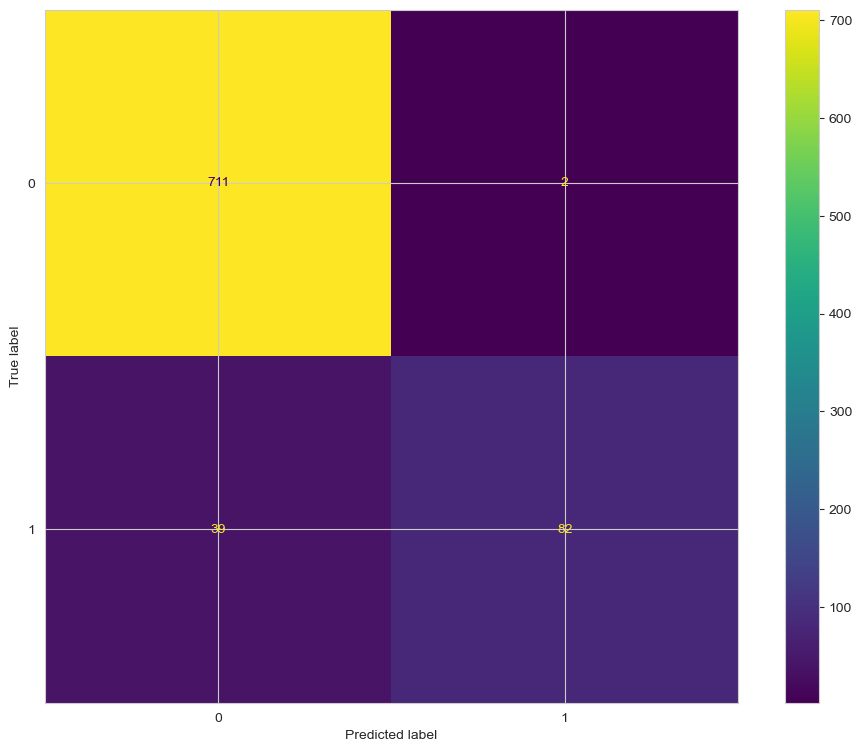

In [450]:
y_pred = clf_xgb.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=clf_xgb.classes_)
disp.plot()
plt.show()

### Задание 5. Рисуем

**дополнительно 0.5 балла**

Наверняка, в процессе выполнения этого задания вас переполняли какие-то эмоции. Нарисуйте что-то, что бы могло бы передать их (я сам не умею, так что, если это будет просто квадрат, тоже подойдет). Прикрепите сюда свой рисунок:

In [ ]:
## PASTE YOUR MASTERPIECE HERE (/¯◡ ‿ ◡)/¯☆*##

### Therapy time

Напишите здесь ваши впечатления о задании (можно и не о задании): было ли интересно, было ли слишком легко или наоборот сложно и тд. Также сюда можно написать свои идеи по улучшению заданий, а также предложить данные, на основе которых вы бы хотели построить следующие дз.

**Ваши мысли:**